# Part 1, Re-track IBB Index

If you have read the paper, you may notice that the first part of application in the paper is to select a subset of stocks from IBB Index to re-track the Index.


OK, let's start.

An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction.

The goal of our paper is to provide a theory of deep portfolios. While we base our construction
on Markowitz’s original idea that portfolio allocation is a trade-off between
risk and return, our approach differs in a number of ways.

The objective of deep portfolio theory is twofold. First, we reduce model dependence to a minimum through a data
driven approach which establishes the risk-return balance as part of the validation phase
of a supervised learning routine, a concept familiar from machine learning.

Second, we construct an auto-encoder and multivariate portfolio payouts, denoted by Fm(X) and
Fp(X) respectively, for a market m and portfolio objective p, from a set of base assets,
denoted by X, via a hierarchical (or deep) set of layers of univariate nonlinear payouts
of sub-portfolios.

We provide a four-step procedure of encode, calibrate, validate and verify
to formulate the portfolio selection process. Encoding finds the market-map, calibration
finds the portfolio-map given a target based on a variety of portfolio objective functions.
The validation step trades-off the amount of regularization and errors involved in the
encode and calibrate steps. The verification step uses a cross validation approach to
trace out an efficient deep frontier of portfolios.



In [1]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [2]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict) # Prespecified dictionary in disctionary 

In [4]:
stock_lp = pd.read_csv('data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]

In [5]:
stock_lp.head()

CELG    US Equity  GILD    US Equity  BIIB    US Equity  \
1/6/2012           67.220001          42.779999         115.500000   
1/13/2012          72.629997          44.889999         116.029999   
1/20/2012          73.839996          47.439999         118.139999   
1/27/2012          73.370003          48.720001         118.559998   
2/3/2012           73.209999          54.695000         121.879997   

           AMGN    US Equity  REGN    US Equity  INCY    US Equity  \
1/6/2012           64.760002          65.790001          16.299999   
1/13/2012          67.599998          78.919998          16.870001   
1/20/2012          69.570000          78.330002          17.280001   
1/27/2012          68.339996          85.540001          17.920000   
2/3/2012           69.279999          96.860001          17.660000   

           ILMN    US Equity  MYL     US Equity  VRTX    US Equity  \
1/6/2012           31.770000          21.469999          34.049999   
1/13/2012          35.709999          21.709999          36.810001   
1/20/2012          36.299999          21.559999          36.310001   
1/27/2012          51.685001          21.040001          35.980000   
2/3/2012           51.840000          22.440001          36.779999   

           ALXN    US Equity        ...          AVDL    US Equity  \
1/6/2012           74.449997        ...                       5.70   
1/13/2012          74.620003        ...                       5.76   
1/20/2012          73.580002        ...                       5.52   
1/27/2012          75.400002        ...                       6.08   
2/3/2012           78.875000        ...                       6.57   

           ARNA    US Equity  GERN    US Equity  NVAX    US Equity  \
1/6/2012                1.62              1.670               1.37   
1/13/2012               1.65              1.690               1.31   
1/20/2012               1.62              1.730               1.31   
1/27/2012               1.59              1.960               1.45   
2/3/2012                1.87              2.075               1.49   

           PDLI    US Equity  SGMO    US Equity  ZGNX    US Equity  \
1/6/2012                6.13               3.03               2.82   
1/13/2012               6.11               3.27               2.57   
1/20/2012               6.33               3.20               2.49   
1/27/2012               6.40               3.30               2.68   
2/3/2012                6.48               4.55               2.73   

           CGEN    US Equity  MNOV    US Equity  ARWR    US Equity  
1/6/2012                5.09               1.81              5.290  
1/13/2012               5.46               1.85              5.260  
1/20/2012               5.32               1.85              5.390  
1/27/2012               5.47               1.80              4.881  
2/3/2012                5.89               2.25              5.050  

[5 rows x 83 columns]

In [6]:
## Biotechnology without component weights

# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

In [8]:
ibb_full.head()

PX_LAST  Change  % Change
Date                                   
6/1/2012   107.209999    0.00  0.000000
13/1/2012  112.349998    5.14  4.794329
20/1/2012  113.000000    0.65  0.578549
27/1/2012  116.260002    3.26  2.884956
3/2/2012   120.639999    4.38  3.767418

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [11]:
data.head()

CELG    US Equity  GILD    US Equity  BIIB    US Equity  \
1/6/2012               -0.38              1.850               5.45   
1/13/2012               5.41              2.110               0.53   
1/20/2012               1.21              2.550               2.11   
1/27/2012              -0.47              1.280               0.42   
2/3/2012               -0.16              5.975               3.32   

           AMGN    US Equity  REGN    US Equity  INCY    US Equity  \
1/6/2012                0.55              10.36               1.29   
1/13/2012               2.84              13.13               0.57   
1/20/2012               1.97              -0.59               0.41   
1/27/2012              -1.23               7.21               0.64   
2/3/2012                0.94              11.32              -0.26   

           ILMN    US Equity  MYL     US Equity  VRTX    US Equity  \
1/6/2012               1.290               0.01               0.84   
1/13/2012              3.940               0.24               2.76   
1/20/2012              0.590              -0.15              -0.50   
1/27/2012             15.385              -0.52              -0.33   
2/3/2012               0.155               1.40               0.80   

           ALXN    US Equity        ...          AVDL    US Equity  \
1/6/2012               2.950        ...                       0.49   
1/13/2012              0.170        ...                       0.06   
1/20/2012             -1.040        ...                      -0.24   
1/27/2012              1.820        ...                       0.56   
2/3/2012               3.475        ...                       0.49   

           ARNA    US Equity  GERN    US Equity  NVAX    US Equity  \
1/6/2012               -0.25              0.190               0.11   
1/13/2012               0.03              0.020              -0.06   
1/20/2012              -0.03              0.040               0.00   
1/27/2012              -0.03              0.230               0.14   
2/3/2012                0.28              0.115               0.04   

           PDLI    US Equity  SGMO    US Equity  ZGNX    US Equity  \
1/6/2012               -0.07               0.19               0.60   
1/13/2012              -0.02               0.24              -0.25   
1/20/2012               0.22              -0.07              -0.08   
1/27/2012               0.07               0.10               0.19   
2/3/2012                0.08               1.25               0.05   

           CGEN    US Equity  MNOV    US Equity  ARWR    US Equity  
1/6/2012                0.14               0.11              1.100  
1/13/2012               0.37               0.04             -0.030  
1/20/2012              -0.14               0.00              0.130  
1/27/2012               0.15              -0.05             -0.509  
2/3/2012                0.42               0.45              0.169  

[5 rows x 83 columns]

In [9]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/500
104/104 [==============================] - 0s 2ms/step - loss: 6.1449
Epoch 2/500
104/104 [==============================] - 0s 303us/step - loss: 5.7192
Epoch 3/500
104/104 [==============================] - 0s 222us/step - loss: 5.5917
Epoch 4/500
104/104 [==============================] - 0s 207us/step - loss: 5.5296
Epoch 5/500
104/104 [==============================] - 0s 206us/step - loss: 5.4843
Epoch 6/500
104/104 [==============================] - 0s 208us/step - loss: 5.4466
Epoch 7/500
104/104 [==============================] - 0s 171us/step - loss: 5.4159
Epoch 8/500
104/104 [==============================] - 0s 189us/step - loss: 5.3859
Epoch 9/500
104/104 [==============================] - 0s 212us/step - loss: 5.3571
Epoch 10/500
104/104 [==============================] - 0s 189us/step - loss: 5.3293
Epoch 11/500
104/104 [==============================] - 0s 199us/step - loss: 5.3018
Epoch 12/500
104/104 [==============================] - 0s 185us/step - loss

104/104 [==============================] - 0s 302us/step - loss: 3.0666
Epoch 98/500
104/104 [==============================] - 0s 397us/step - loss: 3.0629
Epoch 99/500
104/104 [==============================] - 0s 190us/step - loss: 3.0592
Epoch 100/500
104/104 [==============================] - 0s 172us/step - loss: 3.0554
Epoch 101/500
104/104 [==============================] - 0s 294us/step - loss: 3.0515
Epoch 102/500
104/104 [==============================] - 0s 323us/step - loss: 3.0475
Epoch 103/500
104/104 [==============================] - 0s 320us/step - loss: 3.0435
Epoch 104/500
104/104 [==============================] - 0s 291us/step - loss: 3.0393
Epoch 105/500
104/104 [==============================] - 0s 343us/step - loss: 3.0349
Epoch 106/500
104/104 [==============================] - 0s 311us/step - loss: 3.0304
Epoch 107/500
104/104 [==============================] - 0s 263us/step - loss: 3.0258
Epoch 108/500
104/104 [==============================] - 0s 303us/step

104/104 [==============================] - 0s 268us/step - loss: 2.5503
Epoch 193/500
104/104 [==============================] - 0s 308us/step - loss: 2.5476
Epoch 194/500
104/104 [==============================] - 0s 278us/step - loss: 2.5450
Epoch 195/500
104/104 [==============================] - 0s 339us/step - loss: 2.5424
Epoch 196/500
104/104 [==============================] - 0s 305us/step - loss: 2.5398
Epoch 197/500
104/104 [==============================] - 0s 284us/step - loss: 2.5373
Epoch 198/500
104/104 [==============================] - 0s 850us/step - loss: 2.5348
Epoch 199/500
104/104 [==============================] - 0s 280us/step - loss: 2.5323
Epoch 200/500
104/104 [==============================] - 0s 360us/step - loss: 2.5298
Epoch 201/500
104/104 [==============================] - 0s 338us/step - loss: 2.5274
Epoch 202/500
104/104 [==============================] - 0s 288us/step - loss: 2.5250
Epoch 203/500
104/104 [==============================] - 0s 296us/st

104/104 [==============================] - 0s 280us/step - loss: 2.3971
Epoch 288/500
104/104 [==============================] - 0s 256us/step - loss: 2.3963
Epoch 289/500
104/104 [==============================] - 0s 348us/step - loss: 2.3954
Epoch 290/500
104/104 [==============================] - 0s 201us/step - loss: 2.3945
Epoch 291/500
104/104 [==============================] - 0s 197us/step - loss: 2.3937
Epoch 292/500
104/104 [==============================] - 0s 143us/step - loss: 2.3928
Epoch 293/500
104/104 [==============================] - 0s 205us/step - loss: 2.3920
Epoch 294/500
104/104 [==============================] - 0s 174us/step - loss: 2.3912
Epoch 295/500
104/104 [==============================] - 0s 175us/step - loss: 2.3903
Epoch 296/500
104/104 [==============================] - 0s 227us/step - loss: 2.3895
Epoch 297/500
104/104 [==============================] - 0s 174us/step - loss: 2.3887
Epoch 298/500
104/104 [==============================] - 0s 162us/st

104/104 [==============================] - 0s 308us/step - loss: 2.3216
Epoch 382/500
104/104 [==============================] - 0s 338us/step - loss: 2.3209
Epoch 383/500
104/104 [==============================] - 0s 285us/step - loss: 2.3201
Epoch 384/500
104/104 [==============================] - 0s 340us/step - loss: 2.3194
Epoch 385/500
104/104 [==============================] - 0s 222us/step - loss: 2.3187
Epoch 386/500
104/104 [==============================] - 0s 162us/step - loss: 2.3180
Epoch 387/500
104/104 [==============================] - 0s 198us/step - loss: 2.3173
Epoch 388/500
104/104 [==============================] - 0s 221us/step - loss: 2.3165
Epoch 389/500
104/104 [==============================] - 0s 198us/step - loss: 2.3158
Epoch 390/500
104/104 [==============================] - 0s 190us/step - loss: 2.3151
Epoch 391/500
104/104 [==============================] - 0s 252us/step - loss: 2.3144
Epoch 392/500
104/104 [==============================] - 0s 228us/st

104/104 [==============================] - 0s 300us/step - loss: 2.2759
Epoch 476/500
104/104 [==============================] - 0s 368us/step - loss: 2.2756
Epoch 477/500
104/104 [==============================] - 0s 286us/step - loss: 2.2753
Epoch 478/500
104/104 [==============================] - 0s 181us/step - loss: 2.2750
Epoch 479/500
104/104 [==============================] - 0s 239us/step - loss: 2.2747
Epoch 480/500
104/104 [==============================] - 0s 214us/step - loss: 2.2744
Epoch 481/500
104/104 [==============================] - 0s 196us/step - loss: 2.2741
Epoch 482/500
104/104 [==============================] - 0s 188us/step - loss: 2.2739
Epoch 483/500
104/104 [==============================] - 0s 221us/step - loss: 2.2736
Epoch 484/500
104/104 [==============================] - 0s 196us/step - loss: 2.2733
Epoch 485/500
104/104 [==============================] - 0s 171us/step - loss: 2.2731
Epoch 486/500
104/104 [==============================] - 0s 227us/st

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [12]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
68 1.3009974956512451 TLGT    US Equity
65 1.302320957183838 INO     US Equity
38 1.6026829481124878 LXRX    US Equity
76 1.8286701440811157 NVAX    US Equity
66 2.1101880073547363 CERS    US Equity
79 2.217332363128662 ZGNX    US Equity
81 2.3744781017303467 MNOV    US Equity
77 2.4394946098327637 PDLI    US Equity
71 2.5242724418640137 CRIS    US Equity
52 2.779340982437134 IMMU    US Equity
17 2.8355255126953125 EXEL    US Equity
49 3.1101386547088623 DEPO    US Equity
75 3.1147618293762207 GERN    US Equity
37 3.407841205596924 ARRY    US Equity
67 3.6772637367248535 PACB    US Equity
73 3.7584381103515625 AVDL    US Equity
48 3.8303074836730957 SGYP    US Equity
19 4.004280090332031 OPK     US Equity
42 4.144550323486328 RGEN    US Equity
31 4.1786885261535645 HZNP    US Equity
72 4.208654880523682 PRTK    US Equity
55 4.252940654754639 BCRX    US Equity
82 4.3235650062561035 ARWR    US Equity
80 4.602684020996094 CGEN    US Equity
44 4.887136936187744 

Let's have a look on how well this auto-encoder works on a certain stock.

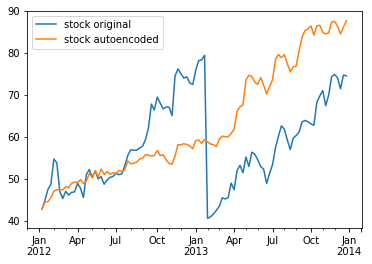

In [13]:
which_stock = 1

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

# Phase 2: Calibrating

In [14]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))

Epoch 1/500
104/104 [==============================] - 0s 2ms/step - loss: 5.8318
Epoch 2/500
104/104 [==============================] - 0s 206us/step - loss: 3.8291
Epoch 3/500
104/104 [==============================] - 0s 187us/step - loss: 3.0210
Epoch 4/500
104/104 [==============================] - 0s 221us/step - loss: 2.4364
Epoch 5/500
104/104 [==============================] - 0s 241us/step - loss: 1.9815
Epoch 6/500
104/104 [==============================] - 0s 243us/step - loss: 1.6742
Epoch 7/500
104/104 [==============================] - 0s 186us/step - loss: 1.4571
Epoch 8/500
104/104 [==============================] - 0s 222us/step - loss: 1.2952
Epoch 9/500
104/104 [==============================] - 0s 267us/step - loss: 1.1652
Epoch 10/500
104/104 [==============================] - 0s 274us/step - loss: 1.0586
Epoch 11/500
104/104 [==============================] - 0s 209us/step - loss: 0.9689
Epoch 12/500
104/104 [==============================] - 0s 212us/step - loss

104/104 [==============================] - 0s 195us/step - loss: 0.3475
Epoch 98/500
104/104 [==============================] - 0s 149us/step - loss: 0.3456
Epoch 99/500
104/104 [==============================] - 0s 150us/step - loss: 0.3455
Epoch 100/500
104/104 [==============================] - 0s 166us/step - loss: 0.3424
Epoch 101/500
104/104 [==============================] - 0s 157us/step - loss: 0.3415
Epoch 102/500
104/104 [==============================] - 0s 207us/step - loss: 0.3407
Epoch 103/500
104/104 [==============================] - 0s 263us/step - loss: 0.3377
Epoch 104/500
104/104 [==============================] - 0s 239us/step - loss: 0.3379
Epoch 105/500
104/104 [==============================] - 0s 190us/step - loss: 0.3357
Epoch 106/500
104/104 [==============================] - 0s 330us/step - loss: 0.3338
Epoch 107/500
104/104 [==============================] - 0s 277us/step - loss: 0.3335
Epoch 108/500
104/104 [==============================] - 0s 218us/step

104/104 [==============================] - 0s 280us/step - loss: 0.2651
Epoch 193/500
104/104 [==============================] - 0s 298us/step - loss: 0.2634
Epoch 194/500
104/104 [==============================] - 0s 304us/step - loss: 0.2627
Epoch 195/500
104/104 [==============================] - 0s 307us/step - loss: 0.2619
Epoch 196/500
104/104 [==============================] - 0s 313us/step - loss: 0.2586
Epoch 197/500
104/104 [==============================] - 0s 304us/step - loss: 0.2553
Epoch 198/500
104/104 [==============================] - 0s 271us/step - loss: 0.2530
Epoch 199/500
104/104 [==============================] - 0s 311us/step - loss: 0.2517
Epoch 200/500
104/104 [==============================] - 0s 276us/step - loss: 0.2507
Epoch 201/500
104/104 [==============================] - 0s 324us/step - loss: 0.2498
Epoch 202/500
104/104 [==============================] - 0s 287us/step - loss: 0.2489
Epoch 203/500
104/104 [==============================] - 0s 326us/st

104/104 [==============================] - 0s 281us/step - loss: 0.2157
Epoch 287/500
104/104 [==============================] - 0s 298us/step - loss: 0.2154
Epoch 288/500
104/104 [==============================] - 0s 328us/step - loss: 0.2148
Epoch 289/500
104/104 [==============================] - 0s 358us/step - loss: 0.2149
Epoch 290/500
104/104 [==============================] - 0s 329us/step - loss: 0.2148
Epoch 291/500
104/104 [==============================] - 0s 215us/step - loss: 0.2147
Epoch 292/500
104/104 [==============================] - 0s 349us/step - loss: 0.2148
Epoch 293/500
104/104 [==============================] - 0s 333us/step - loss: 0.2142
Epoch 294/500
104/104 [==============================] - 0s 313us/step - loss: 0.2143
Epoch 295/500
104/104 [==============================] - 0s 262us/step - loss: 0.2135
Epoch 296/500
104/104 [==============================] - 0s 594us/step - loss: 0.2140
Epoch 297/500
104/104 [==============================] - 0s 442us/st

104/104 [==============================] - 0s 343us/step - loss: 0.2002
Epoch 381/500
104/104 [==============================] - 0s 290us/step - loss: 0.2004
Epoch 382/500
104/104 [==============================] - 0s 313us/step - loss: 0.2000
Epoch 383/500
104/104 [==============================] - 0s 340us/step - loss: 0.1999
Epoch 384/500
104/104 [==============================] - 0s 301us/step - loss: 0.1998
Epoch 385/500
104/104 [==============================] - 0s 328us/step - loss: 0.2000
Epoch 386/500
104/104 [==============================] - 0s 322us/step - loss: 0.1996
Epoch 387/500
104/104 [==============================] - 0s 342us/step - loss: 0.1995
Epoch 388/500
104/104 [==============================] - 0s 336us/step - loss: 0.1994
Epoch 389/500
104/104 [==============================] - 0s 296us/step - loss: 0.1993
Epoch 390/500
104/104 [==============================] - 0s 373us/step - loss: 0.1994
Epoch 391/500
104/104 [==============================] - 0s 264us/st

104/104 [==============================] - 0s 276us/step - loss: 0.1930
Epoch 475/500
104/104 [==============================] - 0s 294us/step - loss: 0.1928
Epoch 476/500
104/104 [==============================] - 0s 274us/step - loss: 0.1930
Epoch 477/500
104/104 [==============================] - 0s 311us/step - loss: 0.1927
Epoch 478/500
104/104 [==============================] - 0s 271us/step - loss: 0.1926
Epoch 479/500
104/104 [==============================] - 0s 288us/step - loss: 0.1926
Epoch 480/500
104/104 [==============================] - 0s 299us/step - loss: 0.1927
Epoch 481/500
104/104 [==============================] - 0s 307us/step - loss: 0.1925
Epoch 482/500
104/104 [==============================] - 0s 293us/step - loss: 0.1927
Epoch 483/500
104/104 [==============================] - 0s 272us/step - loss: 0.1923
Epoch 484/500
104/104 [==============================] - 0s 304us/step - loss: 0.1924
Epoch 485/500
104/104 [==============================] - 0s 314us/st

104/104 [==============================] - 0s 297us/step - loss: 0.1804
Epoch 71/500
104/104 [==============================] - 0s 402us/step - loss: 0.1793
Epoch 72/500
104/104 [==============================] - 0s 314us/step - loss: 0.1783
Epoch 73/500
104/104 [==============================] - 0s 434us/step - loss: 0.1772
Epoch 74/500
104/104 [==============================] - 0s 299us/step - loss: 0.1762
Epoch 75/500
104/104 [==============================] - 0s 380us/step - loss: 0.1752
Epoch 76/500
104/104 [==============================] - 0s 364us/step - loss: 0.1742
Epoch 77/500
104/104 [==============================] - 0s 295us/step - loss: 0.1733
Epoch 78/500
104/104 [==============================] - 0s 359us/step - loss: 0.1723
Epoch 79/500
104/104 [==============================] - 0s 301us/step - loss: 0.1714
Epoch 80/500
104/104 [==============================] - 0s 365us/step - loss: 0.1705
Epoch 81/500
104/104 [==============================] - 0s 362us/step - loss: 

104/104 [==============================] - 0s 298us/step - loss: 0.1336
Epoch 166/500
104/104 [==============================] - 0s 401us/step - loss: 0.1333
Epoch 167/500
104/104 [==============================] - 0s 316us/step - loss: 0.1331
Epoch 168/500
104/104 [==============================] - 0s 457us/step - loss: 0.1329
Epoch 169/500
104/104 [==============================] - 0s 237us/step - loss: 0.1327
Epoch 170/500
104/104 [==============================] - 0s 392us/step - loss: 0.1325
Epoch 171/500
104/104 [==============================] - 0s 412us/step - loss: 0.1322
Epoch 172/500
104/104 [==============================] - 0s 291us/step - loss: 0.1320
Epoch 173/500
104/104 [==============================] - 0s 360us/step - loss: 0.1319
Epoch 174/500
104/104 [==============================] - 0s 305us/step - loss: 0.1317
Epoch 175/500
104/104 [==============================] - 0s 315us/step - loss: 0.1315
Epoch 176/500
104/104 [==============================] - 0s 313us/st

104/104 [==============================] - 0s 311us/step - loss: 0.1071
Epoch 260/500
104/104 [==============================] - 0s 309us/step - loss: 0.1069
Epoch 261/500
104/104 [==============================] - ETA: 0s - loss: 0.108 - 0s 295us/step - loss: 0.1067
Epoch 262/500
104/104 [==============================] - 0s 309us/step - loss: 0.1065
Epoch 263/500
104/104 [==============================] - 0s 351us/step - loss: 0.1063
Epoch 264/500
104/104 [==============================] - 0s 351us/step - loss: 0.1062
Epoch 265/500
104/104 [==============================] - 0s 314us/step - loss: 0.1060
Epoch 266/500
104/104 [==============================] - 0s 289us/step - loss: 0.1058
Epoch 267/500
104/104 [==============================] - 0s 422us/step - loss: 0.1057
Epoch 268/500
104/104 [==============================] - 0s 337us/step - loss: 0.1055
Epoch 269/500
104/104 [==============================] - 0s 282us/step - loss: 0.1053
Epoch 270/500
104/104 [=====================

104/104 [==============================] - 0s 353us/step - loss: 0.0974
Epoch 354/500
104/104 [==============================] - 0s 342us/step - loss: 0.0974
Epoch 355/500
104/104 [==============================] - 0s 301us/step - loss: 0.0973
Epoch 356/500
104/104 [==============================] - 0s 309us/step - loss: 0.0973
Epoch 357/500
104/104 [==============================] - 0s 346us/step - loss: 0.0972
Epoch 358/500
104/104 [==============================] - 0s 342us/step - loss: 0.0971
Epoch 359/500
104/104 [==============================] - 0s 306us/step - loss: 0.0971
Epoch 360/500
104/104 [==============================] - 0s 377us/step - loss: 0.0970
Epoch 361/500
104/104 [==============================] - 0s 328us/step - loss: 0.0970
Epoch 362/500
104/104 [==============================] - 0s 394us/step - loss: 0.0969
Epoch 363/500
104/104 [==============================] - 0s 329us/step - loss: 0.0968
Epoch 364/500
104/104 [==============================] - 0s 342us/st

104/104 [==============================] - 0s 278us/step - loss: 0.0925
Epoch 448/500
104/104 [==============================] - 0s 278us/step - loss: 0.0925
Epoch 449/500
104/104 [==============================] - 0s 296us/step - loss: 0.0925
Epoch 450/500
104/104 [==============================] - 0s 311us/step - loss: 0.0924
Epoch 451/500
104/104 [==============================] - 0s 271us/step - loss: 0.0923
Epoch 452/500
104/104 [==============================] - 0s 248us/step - loss: 0.0923
Epoch 453/500
104/104 [==============================] - 0s 278us/step - loss: 0.0923
Epoch 454/500
104/104 [==============================] - 0s 307us/step - loss: 0.0922
Epoch 455/500
104/104 [==============================] - 0s 281us/step - loss: 0.0922
Epoch 456/500
104/104 [==============================] - 0s 335us/step - loss: 0.0922
Epoch 457/500
104/104 [==============================] - 0s 349us/step - loss: 0.0921
Epoch 458/500
104/104 [==============================] - 0s 375us/st

104/104 [==============================] - 0s 268us/step - loss: 0.1745
Epoch 43/500
104/104 [==============================] - 0s 253us/step - loss: 0.1720
Epoch 44/500
104/104 [==============================] - 0s 339us/step - loss: 0.1710
Epoch 45/500
104/104 [==============================] - 0s 349us/step - loss: 0.1692
Epoch 46/500
104/104 [==============================] - 0s 267us/step - loss: 0.1672
Epoch 47/500
104/104 [==============================] - 0s 268us/step - loss: 0.1662
Epoch 48/500
104/104 [==============================] - 0s 332us/step - loss: 0.1646
Epoch 49/500
104/104 [==============================] - 0s 295us/step - loss: 0.1627
Epoch 50/500
104/104 [==============================] - 0s 293us/step - loss: 0.1618
Epoch 51/500
104/104 [==============================] - ETA: 0s - loss: 0.199 - 0s 308us/step - loss: 0.1603
Epoch 52/500
104/104 [==============================] - 0s 279us/step - loss: 0.1585
Epoch 53/500
104/104 [==============================] 

Epoch 137/500
104/104 [==============================] - 0s 313us/step - loss: 0.1125
Epoch 138/500
104/104 [==============================] - 0s 285us/step - loss: 0.1122
Epoch 139/500
104/104 [==============================] - 0s 287us/step - loss: 0.1119
Epoch 140/500
104/104 [==============================] - 0s 387us/step - loss: 0.1117
Epoch 141/500
104/104 [==============================] - 0s 318us/step - loss: 0.1114
Epoch 142/500
104/104 [==============================] - 0s 320us/step - loss: 0.1111
Epoch 143/500
104/104 [==============================] - 0s 268us/step - loss: 0.1109
Epoch 144/500
104/104 [==============================] - 0s 267us/step - loss: 0.1106
Epoch 145/500
104/104 [==============================] - 0s 266us/step - loss: 0.1104
Epoch 146/500
104/104 [==============================] - 0s 262us/step - loss: 0.1101
Epoch 147/500
104/104 [==============================] - 0s 272us/step - loss: 0.1099
Epoch 148/500
104/104 [==============================]

Epoch 232/500
104/104 [==============================] - 0s 236us/step - loss: 0.0918
Epoch 233/500
104/104 [==============================] - 0s 254us/step - loss: 0.0917
Epoch 234/500
104/104 [==============================] - 0s 334us/step - loss: 0.0915
Epoch 235/500
104/104 [==============================] - 0s 310us/step - loss: 0.0913
Epoch 236/500
104/104 [==============================] - 0s 296us/step - loss: 0.0911
Epoch 237/500
104/104 [==============================] - 0s 275us/step - loss: 0.0910
Epoch 238/500
104/104 [==============================] - 0s 292us/step - loss: 0.0908
Epoch 239/500
104/104 [==============================] - 0s 344us/step - loss: 0.0907
Epoch 240/500
104/104 [==============================] - 0s 306us/step - loss: 0.0905
Epoch 241/500
104/104 [==============================] - 0s 332us/step - loss: 0.0904
Epoch 242/500
104/104 [==============================] - 0s 369us/step - loss: 0.0903
Epoch 243/500
104/104 [==============================]

104/104 [==============================] - 0s 268us/step - loss: 0.0822
Epoch 327/500
104/104 [==============================] - 0s 289us/step - loss: 0.0821
Epoch 328/500
104/104 [==============================] - 0s 280us/step - loss: 0.0820
Epoch 329/500
104/104 [==============================] - 0s 321us/step - loss: 0.0820
Epoch 330/500
104/104 [==============================] - 0s 359us/step - loss: 0.0819
Epoch 331/500
104/104 [==============================] - 0s 356us/step - loss: 0.0818
Epoch 332/500
104/104 [==============================] - 0s 312us/step - loss: 0.0817
Epoch 333/500
104/104 [==============================] - 0s 323us/step - loss: 0.0817
Epoch 334/500
104/104 [==============================] - 0s 285us/step - loss: 0.0816
Epoch 335/500
104/104 [==============================] - 0s 335us/step - loss: 0.0815
Epoch 336/500
104/104 [==============================] - 0s 302us/step - loss: 0.0814
Epoch 337/500
104/104 [==============================] - 0s 235us/st

104/104 [==============================] - 0s 307us/step - loss: 0.0764
Epoch 421/500
104/104 [==============================] - 0s 246us/step - loss: 0.0763
Epoch 422/500
104/104 [==============================] - 0s 317us/step - loss: 0.0763
Epoch 423/500
104/104 [==============================] - 0s 336us/step - loss: 0.0762
Epoch 424/500
104/104 [==============================] - 0s 261us/step - loss: 0.0762
Epoch 425/500
104/104 [==============================] - 0s 340us/step - loss: 0.0761
Epoch 426/500
104/104 [==============================] - 0s 300us/step - loss: 0.0761
Epoch 427/500
104/104 [==============================] - 0s 284us/step - loss: 0.0760
Epoch 428/500
104/104 [==============================] - 0s 274us/step - loss: 0.0760
Epoch 429/500
104/104 [==============================] - 0s 293us/step - loss: 0.0759
Epoch 430/500
104/104 [==============================] - 0s 355us/step - loss: 0.0759
Epoch 431/500
104/104 [==============================] - 0s 269us/st

Now we would like to see how similar these 3 portfolios perform as the original IBB Index does on training dates.

S25 2-norm difference:  12.613118
S45 2-norm difference:  7.0587907
S65 2-norm difference:  6.7724237


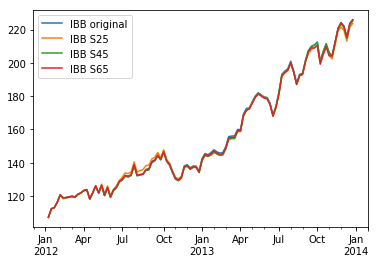

In [15]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB original', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    


# Phase 3: Validating

In [16]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + '.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

S25 2-norm difference:  526.634
S45 2-norm difference:  929.4843
S65 2-norm difference:  327.85175


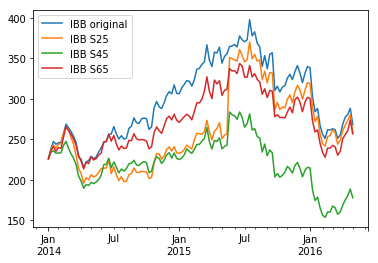

In [17]:
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

# Phase 4: Verifying

- x-axis: 2-norm error  
- y-axis: # of stocks in the portfolios: 10, 11, 12, ..., 

From my perspective, Efficient Deep Frontier has nothing to do with the one in Modern Portfolio Theory. It just reflects the trade-off between more stocks in the portfolios and higher MSE.

In [18]:
### It is slightly unstable but can be improved on

error = []
for non_communal in range(5, 79, 1):  
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))    

Epoch 1/500
104/104 [==============================] - 0s 3ms/step - loss: 7.9916
Epoch 2/500
104/104 [==============================] - 0s 265us/step - loss: 6.2489
Epoch 3/500
104/104 [==============================] - 0s 207us/step - loss: 5.3539
Epoch 4/500
104/104 [==============================] - 0s 211us/step - loss: 4.6370
Epoch 5/500
104/104 [==============================] - 0s 198us/step - loss: 4.0406
Epoch 6/500
104/104 [==============================] - 0s 227us/step - loss: 3.5484
Epoch 7/500
104/104 [==============================] - 0s 257us/step - loss: 3.1390
Epoch 8/500
104/104 [==============================] - 0s 233us/step - loss: 2.8570
Epoch 9/500
104/104 [==============================] - 0s 187us/step - loss: 2.6669
Epoch 10/500
104/104 [==============================] - 0s 196us/step - loss: 2.5090
Epoch 11/500
104/104 [==============================] - 0s 235us/step - loss: 2.3621
Epoch 12/500
104/104 [==============================] - 0s 220us/step - loss

104/104 [==============================] - 0s 317us/step - loss: 0.9779
Epoch 98/500
104/104 [==============================] - 0s 359us/step - loss: 0.9756
Epoch 99/500
104/104 [==============================] - 0s 448us/step - loss: 0.9717
Epoch 100/500
104/104 [==============================] - 0s 331us/step - loss: 0.9704
Epoch 101/500
104/104 [==============================] - 0s 357us/step - loss: 0.9666
Epoch 102/500
104/104 [==============================] - 0s 336us/step - loss: 0.9620
Epoch 103/500
104/104 [==============================] - 0s 330us/step - loss: 0.9583
Epoch 104/500
104/104 [==============================] - 0s 347us/step - loss: 0.9576
Epoch 105/500
104/104 [==============================] - 0s 343us/step - loss: 0.9543
Epoch 106/500
104/104 [==============================] - 0s 354us/step - loss: 0.9482
Epoch 107/500
104/104 [==============================] - 0s 365us/step - loss: 0.9461
Epoch 108/500
104/104 [==============================] - 0s 353us/step

104/104 [==============================] - 0s 343us/step - loss: 0.7831
Epoch 193/500
104/104 [==============================] - 0s 310us/step - loss: 0.7804
Epoch 194/500
104/104 [==============================] - 0s 388us/step - loss: 0.7804
Epoch 195/500
104/104 [==============================] - 0s 295us/step - loss: 0.7792
Epoch 196/500
104/104 [==============================] - 0s 396us/step - loss: 0.7781
Epoch 197/500
104/104 [==============================] - 0s 371us/step - loss: 0.7771
Epoch 198/500
104/104 [==============================] - 0s 399us/step - loss: 0.7766
Epoch 199/500
104/104 [==============================] - 0s 315us/step - loss: 0.7772
Epoch 200/500
104/104 [==============================] - 0s 283us/step - loss: 0.7744
Epoch 201/500
104/104 [==============================] - 0s 296us/step - loss: 0.7733
Epoch 202/500
104/104 [==============================] - 0s 336us/step - loss: 0.7729
Epoch 203/500
104/104 [==============================] - 0s 283us/st

104/104 [==============================] - 0s 282us/step - loss: 0.7412
Epoch 287/500
104/104 [==============================] - 0s 275us/step - loss: 0.7395
Epoch 288/500
104/104 [==============================] - 0s 345us/step - loss: 0.7399
Epoch 289/500
104/104 [==============================] - 0s 356us/step - loss: 0.7389
Epoch 290/500
104/104 [==============================] - 0s 363us/step - loss: 0.7408
Epoch 291/500
104/104 [==============================] - 0s 270us/step - loss: 0.7395
Epoch 292/500
104/104 [==============================] - 0s 412us/step - loss: 0.7387
Epoch 293/500
104/104 [==============================] - 0s 371us/step - loss: 0.7390
Epoch 294/500
104/104 [==============================] - 0s 323us/step - loss: 0.7389
Epoch 295/500
104/104 [==============================] - 0s 261us/step - loss: 0.7375
Epoch 296/500
104/104 [==============================] - 0s 324us/step - loss: 0.7395
Epoch 297/500
104/104 [==============================] - 0s 317us/st

104/104 [==============================] - 0s 176us/step - loss: 0.7315
Epoch 381/500
104/104 [==============================] - 0s 166us/step - loss: 0.7322
Epoch 382/500
104/104 [==============================] - 0s 250us/step - loss: 0.7309
Epoch 383/500
104/104 [==============================] - 0s 257us/step - loss: 0.7321
Epoch 384/500
104/104 [==============================] - 0s 256us/step - loss: 0.7318
Epoch 385/500
104/104 [==============================] - 0s 146us/step - loss: 0.7319
Epoch 386/500
104/104 [==============================] - 0s 221us/step - loss: 0.7321
Epoch 387/500
104/104 [==============================] - 0s 191us/step - loss: 0.7311
Epoch 388/500
104/104 [==============================] - 0s 151us/step - loss: 0.7308
Epoch 389/500
104/104 [==============================] - 0s 222us/step - loss: 0.7328
Epoch 390/500
104/104 [==============================] - 0s 192us/step - loss: 0.7308
Epoch 391/500
104/104 [==============================] - 0s 163us/st

104/104 [==============================] - 0s 161us/step - loss: 0.7266
Epoch 476/500
104/104 [==============================] - 0s 177us/step - loss: 0.7267
Epoch 477/500
104/104 [==============================] - 0s 158us/step - loss: 0.7281
Epoch 478/500
104/104 [==============================] - 0s 178us/step - loss: 0.7288
Epoch 479/500
104/104 [==============================] - 0s 152us/step - loss: 0.7278
Epoch 480/500
104/104 [==============================] - 0s 221us/step - loss: 0.7276
Epoch 481/500
104/104 [==============================] - 0s 184us/step - loss: 0.7275
Epoch 482/500
104/104 [==============================] - 0s 160us/step - loss: 0.7276
Epoch 483/500
104/104 [==============================] - 0s 216us/step - loss: 0.7274
Epoch 484/500
104/104 [==============================] - 0s 182us/step - loss: 0.7288
Epoch 485/500
104/104 [==============================] - 0s 159us/step - loss: 0.7257
Epoch 486/500
104/104 [==============================] - 0s 195us/st

104/104 [==============================] - 0s 183us/step - loss: 1.1357
Epoch 72/500
104/104 [==============================] - 0s 178us/step - loss: 1.1244
Epoch 73/500
104/104 [==============================] - 0s 148us/step - loss: 1.1108
Epoch 74/500
104/104 [==============================] - 0s 174us/step - loss: 1.0991
Epoch 75/500
104/104 [==============================] - 0s 141us/step - loss: 1.0839
Epoch 76/500
104/104 [==============================] - 0s 195us/step - loss: 1.0782
Epoch 77/500
104/104 [==============================] - 0s 135us/step - loss: 1.0641
Epoch 78/500
104/104 [==============================] - 0s 194us/step - loss: 1.0566
Epoch 79/500
104/104 [==============================] - 0s 147us/step - loss: 1.0446
Epoch 80/500
104/104 [==============================] - 0s 147us/step - loss: 1.0372
Epoch 81/500
104/104 [==============================] - 0s 167us/step - loss: 1.0295
Epoch 82/500
104/104 [==============================] - 0s 144us/step - loss: 

104/104 [==============================] - 0s 179us/step - loss: 0.7778
Epoch 167/500
104/104 [==============================] - 0s 256us/step - loss: 0.7803
Epoch 168/500
104/104 [==============================] - 0s 226us/step - loss: 0.7773
Epoch 169/500
104/104 [==============================] - 0s 144us/step - loss: 0.7787
Epoch 170/500
104/104 [==============================] - 0s 193us/step - loss: 0.7758
Epoch 171/500
104/104 [==============================] - 0s 138us/step - loss: 0.7743
Epoch 172/500
104/104 [==============================] - 0s 177us/step - loss: 0.7771
Epoch 173/500
104/104 [==============================] - 0s 171us/step - loss: 0.7716
Epoch 174/500
104/104 [==============================] - 0s 161us/step - loss: 0.7768
Epoch 175/500
104/104 [==============================] - 0s 189us/step - loss: 0.7715
Epoch 176/500
104/104 [==============================] - 0s 166us/step - loss: 0.7705
Epoch 177/500
104/104 [==============================] - 0s 268us/st

104/104 [==============================] - 0s 215us/step - loss: 0.7154
Epoch 261/500
104/104 [==============================] - 0s 230us/step - loss: 0.7157
Epoch 262/500
104/104 [==============================] - 0s 174us/step - loss: 0.7161
Epoch 263/500
104/104 [==============================] - 0s 185us/step - loss: 0.7133
Epoch 264/500
104/104 [==============================] - 0s 200us/step - loss: 0.7160
Epoch 265/500
104/104 [==============================] - 0s 227us/step - loss: 0.7121
Epoch 266/500
104/104 [==============================] - 0s 214us/step - loss: 0.7163
Epoch 267/500
104/104 [==============================] - 0s 219us/step - loss: 0.7128
Epoch 268/500
104/104 [==============================] - 0s 193us/step - loss: 0.7142
Epoch 269/500
104/104 [==============================] - 0s 209us/step - loss: 0.7109
Epoch 270/500
104/104 [==============================] - 0s 228us/step - loss: 0.7136
Epoch 271/500
104/104 [==============================] - 0s 211us/st

104/104 [==============================] - 0s 165us/step - loss: 0.6283
Epoch 355/500
104/104 [==============================] - 0s 183us/step - loss: 0.6280
Epoch 356/500
104/104 [==============================] - 0s 162us/step - loss: 0.6255
Epoch 357/500
104/104 [==============================] - 0s 226us/step - loss: 0.6265
Epoch 358/500
104/104 [==============================] - 0s 216us/step - loss: 0.6277
Epoch 359/500
104/104 [==============================] - 0s 157us/step - loss: 0.6235
Epoch 360/500
104/104 [==============================] - 0s 208us/step - loss: 0.6239
Epoch 361/500
104/104 [==============================] - 0s 173us/step - loss: 0.6261
Epoch 362/500
104/104 [==============================] - 0s 171us/step - loss: 0.6239
Epoch 363/500
104/104 [==============================] - 0s 235us/step - loss: 0.6248
Epoch 364/500
104/104 [==============================] - 0s 217us/step - loss: 0.6233
Epoch 365/500
104/104 [==============================] - 0s 216us/st

104/104 [==============================] - 0s 157us/step - loss: 0.6037
Epoch 450/500
104/104 [==============================] - 0s 202us/step - loss: 0.6028
Epoch 451/500
104/104 [==============================] - 0s 205us/step - loss: 0.6040
Epoch 452/500
104/104 [==============================] - 0s 203us/step - loss: 0.6034
Epoch 453/500
104/104 [==============================] - 0s 207us/step - loss: 0.6039
Epoch 454/500
104/104 [==============================] - 0s 148us/step - loss: 0.6040
Epoch 455/500
104/104 [==============================] - 0s 177us/step - loss: 0.6020
Epoch 456/500
104/104 [==============================] - 0s 169us/step - loss: 0.6044
Epoch 457/500
104/104 [==============================] - 0s 158us/step - loss: 0.6033
Epoch 458/500
104/104 [==============================] - 0s 181us/step - loss: 0.6035
Epoch 459/500
104/104 [==============================] - 0s 150us/step - loss: 0.6039
Epoch 460/500
104/104 [==============================] - 0s 199us/st

104/104 [==============================] - 0s 165us/step - loss: 1.0968
Epoch 46/500
104/104 [==============================] - 0s 153us/step - loss: 1.0867
Epoch 47/500
104/104 [==============================] - ETA: 0s - loss: 0.597 - 0s 188us/step - loss: 1.0759
Epoch 48/500
104/104 [==============================] - 0s 153us/step - loss: 1.0660
Epoch 49/500
104/104 [==============================] - 0s 244us/step - loss: 1.0548
Epoch 50/500
104/104 [==============================] - 0s 216us/step - loss: 1.0458
Epoch 51/500
104/104 [==============================] - 0s 165us/step - loss: 1.0352
Epoch 52/500
104/104 [==============================] - 0s 193us/step - loss: 1.0219
Epoch 53/500
104/104 [==============================] - 0s 213us/step - loss: 1.0118
Epoch 54/500
104/104 [==============================] - 0s 298us/step - loss: 1.0033
Epoch 55/500
104/104 [==============================] - 0s 166us/step - loss: 0.9876
Epoch 56/500
104/104 [==============================] 

Epoch 140/500
104/104 [==============================] - 0s 152us/step - loss: 0.6998
Epoch 141/500
104/104 [==============================] - 0s 178us/step - loss: 0.6980
Epoch 142/500
104/104 [==============================] - 0s 140us/step - loss: 0.6938
Epoch 143/500
104/104 [==============================] - 0s 185us/step - loss: 0.6912
Epoch 144/500
104/104 [==============================] - 0s 145us/step - loss: 0.6880
Epoch 145/500
104/104 [==============================] - 0s 179us/step - loss: 0.6854
Epoch 146/500
104/104 [==============================] - 0s 142us/step - loss: 0.6833
Epoch 147/500
104/104 [==============================] - 0s 148us/step - loss: 0.6812
Epoch 148/500
104/104 [==============================] - 0s 162us/step - loss: 0.6792
Epoch 149/500
104/104 [==============================] - 0s 145us/step - loss: 0.6770
Epoch 150/500
104/104 [==============================] - 0s 184us/step - loss: 0.6735
Epoch 151/500
104/104 [==============================]

104/104 [==============================] - 0s 140us/step - loss: 0.5860
Epoch 236/500
104/104 [==============================] - 0s 187us/step - loss: 0.5871
Epoch 237/500
104/104 [==============================] - 0s 142us/step - loss: 0.5861
Epoch 238/500
104/104 [==============================] - 0s 189us/step - loss: 0.5865
Epoch 239/500
104/104 [==============================] - 0s 150us/step - loss: 0.5860
Epoch 240/500
104/104 [==============================] - 0s 154us/step - loss: 0.5847
Epoch 241/500
104/104 [==============================] - 0s 167us/step - loss: 0.5850
Epoch 242/500
104/104 [==============================] - 0s 145us/step - loss: 0.5851
Epoch 243/500
104/104 [==============================] - 0s 171us/step - loss: 0.5848
Epoch 244/500
104/104 [==============================] - 0s 142us/step - loss: 0.5842
Epoch 245/500
104/104 [==============================] - 0s 191us/step - loss: 0.5839
Epoch 246/500
104/104 [==============================] - 0s 136us/st

104/104 [==============================] - 0s 164us/step - loss: 0.5622
Epoch 331/500
104/104 [==============================] - ETA: 0s - loss: 0.549 - 0s 185us/step - loss: 0.5631
Epoch 332/500
104/104 [==============================] - 0s 196us/step - loss: 0.5621
Epoch 333/500
104/104 [==============================] - 0s 148us/step - loss: 0.5603
Epoch 334/500
104/104 [==============================] - 0s 231us/step - loss: 0.5620
Epoch 335/500
104/104 [==============================] - ETA: 0s - loss: 0.553 - 0s 154us/step - loss: 0.5603
Epoch 336/500
104/104 [==============================] - ETA: 0s - loss: 0.550 - 0s 154us/step - loss: 0.5602
Epoch 337/500
104/104 [==============================] - 0s 172us/step - loss: 0.5599
Epoch 338/500
104/104 [==============================] - 0s 152us/step - loss: 0.5597
Epoch 339/500
104/104 [==============================] - 0s 203us/step - loss: 0.5600
Epoch 340/500
104/104 [==============================] - 0s 138us/step - loss: 0.5

104/104 [==============================] - 0s 176us/step - loss: 0.5404
Epoch 425/500
104/104 [==============================] - 0s 153us/step - loss: 0.5415
Epoch 426/500
104/104 [==============================] - 0s 199us/step - loss: 0.5411
Epoch 427/500
104/104 [==============================] - 0s 131us/step - loss: 0.5405
Epoch 428/500
104/104 [==============================] - 0s 217us/step - loss: 0.5403
Epoch 429/500
104/104 [==============================] - 0s 176us/step - loss: 0.5406
Epoch 430/500
104/104 [==============================] - ETA: 0s - loss: 0.548 - 0s 144us/step - loss: 0.5409
Epoch 431/500
104/104 [==============================] - 0s 203us/step - loss: 0.5395
Epoch 432/500
104/104 [==============================] - 0s 137us/step - loss: 0.5410
Epoch 433/500
104/104 [==============================] - 0s 184us/step - loss: 0.5400
Epoch 434/500
104/104 [==============================] - 0s 175us/step - loss: 0.5408
Epoch 435/500
104/104 [=====================

104/104 [==============================] - 0s 149us/step - loss: 1.2338
Epoch 19/500
104/104 [==============================] - 0s 189us/step - loss: 1.2069
Epoch 20/500
104/104 [==============================] - 0s 134us/step - loss: 1.1800
Epoch 21/500
104/104 [==============================] - 0s 186us/step - loss: 1.1613
Epoch 22/500
104/104 [==============================] - 0s 123us/step - loss: 1.1401
Epoch 23/500
104/104 [==============================] - 0s 180us/step - loss: 1.1167
Epoch 24/500
104/104 [==============================] - 0s 164us/step - loss: 1.1003
Epoch 25/500
104/104 [==============================] - 0s 144us/step - loss: 1.0834
Epoch 26/500
104/104 [==============================] - 0s 168us/step - loss: 1.0664
Epoch 27/500
104/104 [==============================] - 0s 152us/step - loss: 1.0482
Epoch 28/500
104/104 [==============================] - 0s 197us/step - loss: 1.0312
Epoch 29/500
104/104 [==============================] - 0s 166us/step - loss: 

104/104 [==============================] - 0s 163us/step - loss: 0.5281
Epoch 115/500
104/104 [==============================] - 0s 192us/step - loss: 0.5256
Epoch 116/500
104/104 [==============================] - 0s 157us/step - loss: 0.5243
Epoch 117/500
104/104 [==============================] - 0s 214us/step - loss: 0.5216
Epoch 118/500
104/104 [==============================] - 0s 186us/step - loss: 0.5224
Epoch 119/500
104/104 [==============================] - ETA: 0s - loss: 0.341 - 0s 160us/step - loss: 0.5198
Epoch 120/500
104/104 [==============================] - 0s 219us/step - loss: 0.5180
Epoch 121/500
104/104 [==============================] - 0s 124us/step - loss: 0.5173
Epoch 122/500
104/104 [==============================] - 0s 185us/step - loss: 0.5163
Epoch 123/500
104/104 [==============================] - ETA: 0s - loss: 0.339 - 0s 161us/step - loss: 0.5152
Epoch 124/500
104/104 [==============================] - 0s 168us/step - loss: 0.5123
Epoch 125/500
104/10

104/104 [==============================] - 0s 169us/step - loss: 0.4482
Epoch 209/500
104/104 [==============================] - 0s 153us/step - loss: 0.4481
Epoch 210/500
104/104 [==============================] - 0s 184us/step - loss: 0.4470
Epoch 211/500
104/104 [==============================] - 0s 151us/step - loss: 0.4462
Epoch 212/500
104/104 [==============================] - 0s 180us/step - loss: 0.4467
Epoch 213/500
104/104 [==============================] - 0s 172us/step - loss: 0.4453
Epoch 214/500
104/104 [==============================] - 0s 148us/step - loss: 0.4459
Epoch 215/500
104/104 [==============================] - 0s 163us/step - loss: 0.4443
Epoch 216/500
104/104 [==============================] - 0s 143us/step - loss: 0.4427
Epoch 217/500
104/104 [==============================] - 0s 168us/step - loss: 0.4434
Epoch 218/500
104/104 [==============================] - 0s 145us/step - loss: 0.4426
Epoch 219/500
104/104 [==============================] - 0s 185us/st

104/104 [==============================] - 0s 194us/step - loss: 0.4246
Epoch 303/500
104/104 [==============================] - 0s 141us/step - loss: 0.4237
Epoch 304/500
104/104 [==============================] - 0s 184us/step - loss: 0.4238
Epoch 305/500
104/104 [==============================] - 0s 163us/step - loss: 0.4224
Epoch 306/500
104/104 [==============================] - 0s 172us/step - loss: 0.4224
Epoch 307/500
104/104 [==============================] - 0s 190us/step - loss: 0.4209
Epoch 308/500
104/104 [==============================] - 0s 145us/step - loss: 0.4221
Epoch 309/500
104/104 [==============================] - 0s 185us/step - loss: 0.4201
Epoch 310/500
104/104 [==============================] - 0s 128us/step - loss: 0.4213
Epoch 311/500
104/104 [==============================] - 0s 187us/step - loss: 0.4200
Epoch 312/500
104/104 [==============================] - 0s 124us/step - loss: 0.4188
Epoch 313/500
104/104 [==============================] - 0s 185us/st

104/104 [==============================] - 0s 212us/step - loss: 0.4047
Epoch 397/500
104/104 [==============================] - 0s 226us/step - loss: 0.4022
Epoch 398/500
104/104 [==============================] - 0s 297us/step - loss: 0.4049
Epoch 399/500
104/104 [==============================] - 0s 240us/step - loss: 0.4032
Epoch 400/500
104/104 [==============================] - 0s 162us/step - loss: 0.4040
Epoch 401/500
104/104 [==============================] - 0s 225us/step - loss: 0.4038
Epoch 402/500
104/104 [==============================] - 0s 282us/step - loss: 0.4039
Epoch 403/500
104/104 [==============================] - 0s 264us/step - loss: 0.4033
Epoch 404/500
104/104 [==============================] - 0s 169us/step - loss: 0.4030
Epoch 405/500
104/104 [==============================] - 0s 362us/step - loss: 0.4026
Epoch 406/500
104/104 [==============================] - 0s 376us/step - loss: 0.4045
Epoch 407/500
104/104 [==============================] - 0s 398us/st

104/104 [==============================] - 0s 290us/step - loss: 0.3943
Epoch 491/500
104/104 [==============================] - 0s 282us/step - loss: 0.3969
Epoch 492/500
104/104 [==============================] - 0s 357us/step - loss: 0.3948
Epoch 493/500
104/104 [==============================] - 0s 287us/step - loss: 0.3959
Epoch 494/500
104/104 [==============================] - ETA: 0s - loss: 0.294 - 0s 271us/step - loss: 0.3954
Epoch 495/500
104/104 [==============================] - 0s 302us/step - loss: 0.3963
Epoch 496/500
104/104 [==============================] - 0s 265us/step - loss: 0.3956
Epoch 497/500
104/104 [==============================] - 0s 322us/step - loss: 0.3943
Epoch 498/500
104/104 [==============================] - 0s 281us/step - loss: 0.3962
Epoch 499/500
104/104 [==============================] - 0s 314us/step - loss: 0.3946
Epoch 500/500
104/104 [==============================] - 0s 202us/step - loss: 0.3960
Epoch 1/500
104/104 [=======================

104/104 [==============================] - 0s 325us/step - loss: 0.5233
Epoch 87/500
104/104 [==============================] - 0s 224us/step - loss: 0.5207
Epoch 88/500
104/104 [==============================] - 0s 222us/step - loss: 0.5156
Epoch 89/500
104/104 [==============================] - 0s 304us/step - loss: 0.5142
Epoch 90/500
104/104 [==============================] - 0s 277us/step - loss: 0.5091
Epoch 91/500
104/104 [==============================] - 0s 284us/step - loss: 0.5049
Epoch 92/500
104/104 [==============================] - 0s 317us/step - loss: 0.5018
Epoch 93/500
104/104 [==============================] - ETA: 0s - loss: 0.245 - 0s 280us/step - loss: 0.4992
Epoch 94/500
104/104 [==============================] - 0s 300us/step - loss: 0.4946
Epoch 95/500
104/104 [==============================] - 0s 246us/step - loss: 0.4917
Epoch 96/500
104/104 [==============================] - 0s 279us/step - loss: 0.4851
Epoch 97/500
104/104 [==============================] 

104/104 [==============================] - 0s 149us/step - loss: 0.3453
Epoch 181/500
104/104 [==============================] - 0s 156us/step - loss: 0.3447
Epoch 182/500
104/104 [==============================] - 0s 147us/step - loss: 0.3439
Epoch 183/500
104/104 [==============================] - 0s 153us/step - loss: 0.3447
Epoch 184/500
104/104 [==============================] - 0s 145us/step - loss: 0.3433
Epoch 185/500
104/104 [==============================] - 0s 148us/step - loss: 0.3429
Epoch 186/500
104/104 [==============================] - 0s 150us/step - loss: 0.3423
Epoch 187/500
104/104 [==============================] - 0s 141us/step - loss: 0.3427
Epoch 188/500
104/104 [==============================] - 0s 142us/step - loss: 0.3416
Epoch 189/500
104/104 [==============================] - 0s 159us/step - loss: 0.3414
Epoch 190/500
104/104 [==============================] - 0s 163us/step - loss: 0.3410
Epoch 191/500
104/104 [==============================] - 0s 150us/st

104/104 [==============================] - 0s 159us/step - loss: 0.3205
Epoch 276/500
104/104 [==============================] - 0s 270us/step - loss: 0.3205
Epoch 277/500
104/104 [==============================] - 0s 192us/step - loss: 0.3197
Epoch 278/500
104/104 [==============================] - 0s 248us/step - loss: 0.3193
Epoch 279/500
104/104 [==============================] - 0s 217us/step - loss: 0.3201
Epoch 280/500
104/104 [==============================] - 0s 186us/step - loss: 0.3194
Epoch 281/500
104/104 [==============================] - 0s 178us/step - loss: 0.3189
Epoch 282/500
104/104 [==============================] - 0s 179us/step - loss: 0.3194
Epoch 283/500
104/104 [==============================] - 0s 403us/step - loss: 0.3191
Epoch 284/500
104/104 [==============================] - 0s 249us/step - loss: 0.3189
Epoch 285/500
104/104 [==============================] - 0s 186us/step - loss: 0.3190
Epoch 286/500
104/104 [==============================] - 0s 279us/st

104/104 [==============================] - 0s 141us/step - loss: 0.3092
Epoch 370/500
104/104 [==============================] - 0s 156us/step - loss: 0.3086
Epoch 371/500
104/104 [==============================] - 0s 142us/step - loss: 0.3098
Epoch 372/500
104/104 [==============================] - 0s 139us/step - loss: 0.3087
Epoch 373/500
104/104 [==============================] - 0s 136us/step - loss: 0.3080
Epoch 374/500
104/104 [==============================] - 0s 151us/step - loss: 0.3089
Epoch 375/500
104/104 [==============================] - 0s 161us/step - loss: 0.3087
Epoch 376/500
104/104 [==============================] - 0s 151us/step - loss: 0.3083
Epoch 377/500
104/104 [==============================] - 0s 163us/step - loss: 0.3085
Epoch 378/500
104/104 [==============================] - 0s 141us/step - loss: 0.3082
Epoch 379/500
104/104 [==============================] - 0s 143us/step - loss: 0.3075
Epoch 380/500
104/104 [==============================] - 0s 154us/st

104/104 [==============================] - 0s 203us/step - loss: 0.3023
Epoch 464/500
104/104 [==============================] - 0s 145us/step - loss: 0.3033
Epoch 465/500
104/104 [==============================] - 0s 172us/step - loss: 0.3018
Epoch 466/500
104/104 [==============================] - 0s 161us/step - loss: 0.3017
Epoch 467/500
104/104 [==============================] - 0s 142us/step - loss: 0.3025
Epoch 468/500
104/104 [==============================] - 0s 143us/step - loss: 0.3015
Epoch 469/500
104/104 [==============================] - 0s 143us/step - loss: 0.3016
Epoch 470/500
104/104 [==============================] - 0s 146us/step - loss: 0.3020
Epoch 471/500
104/104 [==============================] - 0s 146us/step - loss: 0.3015
Epoch 472/500
104/104 [==============================] - 0s 166us/step - loss: 0.3025
Epoch 473/500
104/104 [==============================] - 0s 217us/step - loss: 0.3020
Epoch 474/500
104/104 [==============================] - 0s 188us/st

104/104 [==============================] - 0s 240us/step - loss: 0.5923
Epoch 60/500
104/104 [==============================] - 0s 229us/step - loss: 0.5894
Epoch 61/500
104/104 [==============================] - 0s 238us/step - loss: 0.5847
Epoch 62/500
104/104 [==============================] - 0s 205us/step - loss: 0.5808
Epoch 63/500
104/104 [==============================] - 0s 228us/step - loss: 0.5758
Epoch 64/500
104/104 [==============================] - 0s 450us/step - loss: 0.5716
Epoch 65/500
104/104 [==============================] - ETA: 0s - loss: 0.651 - 0s 254us/step - loss: 0.5668
Epoch 66/500
104/104 [==============================] - 0s 427us/step - loss: 0.5615
Epoch 67/500
104/104 [==============================] - 0s 262us/step - loss: 0.5579
Epoch 68/500
104/104 [==============================] - 0s 249us/step - loss: 0.5537
Epoch 69/500
104/104 [==============================] - 0s 205us/step - loss: 0.5494
Epoch 70/500
104/104 [==============================] 

104/104 [==============================] - 0s 317us/step - loss: 0.3846
Epoch 155/500
104/104 [==============================] - 0s 233us/step - loss: 0.3848
Epoch 156/500
104/104 [==============================] - 0s 194us/step - loss: 0.3834
Epoch 157/500
104/104 [==============================] - 0s 175us/step - loss: 0.3836
Epoch 158/500
104/104 [==============================] - 0s 261us/step - loss: 0.3825
Epoch 159/500
104/104 [==============================] - 0s 177us/step - loss: 0.3824
Epoch 160/500
104/104 [==============================] - 0s 266us/step - loss: 0.3809
Epoch 161/500
104/104 [==============================] - 0s 299us/step - loss: 0.3810
Epoch 162/500
104/104 [==============================] - 0s 220us/step - loss: 0.3798
Epoch 163/500
104/104 [==============================] - 0s 175us/step - loss: 0.3797
Epoch 164/500
104/104 [==============================] - 0s 181us/step - loss: 0.3788
Epoch 165/500
104/104 [==============================] - 0s 187us/st

104/104 [==============================] - 0s 206us/step - loss: 0.3363
Epoch 250/500
104/104 [==============================] - 0s 157us/step - loss: 0.3355
Epoch 251/500
104/104 [==============================] - 0s 176us/step - loss: 0.3365
Epoch 252/500
104/104 [==============================] - 0s 153us/step - loss: 0.3344
Epoch 253/500
104/104 [==============================] - 0s 140us/step - loss: 0.3340
Epoch 254/500
104/104 [==============================] - 0s 170us/step - loss: 0.3337
Epoch 255/500
104/104 [==============================] - 0s 155us/step - loss: 0.3332
Epoch 256/500
104/104 [==============================] - 0s 153us/step - loss: 0.3331
Epoch 257/500
104/104 [==============================] - 0s 194us/step - loss: 0.3312
Epoch 258/500
104/104 [==============================] - 0s 136us/step - loss: 0.3322
Epoch 259/500
104/104 [==============================] - 0s 156us/step - loss: 0.3308
Epoch 260/500
104/104 [==============================] - 0s 173us/st

104/104 [==============================] - 0s 146us/step - loss: 0.3083
Epoch 344/500
104/104 [==============================] - 0s 149us/step - loss: 0.3080
Epoch 345/500
104/104 [==============================] - 0s 172us/step - loss: 0.3075
Epoch 346/500
104/104 [==============================] - 0s 158us/step - loss: 0.3083
Epoch 347/500
104/104 [==============================] - 0s 177us/step - loss: 0.3074
Epoch 348/500
104/104 [==============================] - 0s 167us/step - loss: 0.3078
Epoch 349/500
104/104 [==============================] - 0s 150us/step - loss: 0.3083
Epoch 350/500
104/104 [==============================] - 0s 198us/step - loss: 0.3070
Epoch 351/500
104/104 [==============================] - 0s 149us/step - loss: 0.3079
Epoch 352/500
104/104 [==============================] - ETA: 0s - loss: 0.177 - 0s 160us/step - loss: 0.3071
Epoch 353/500
104/104 [==============================] - 0s 194us/step - loss: 0.3074
Epoch 354/500
104/104 [=====================

104/104 [==============================] - 0s 148us/step - loss: 0.2992
Epoch 438/500
104/104 [==============================] - ETA: 0s - loss: 0.170 - 0s 149us/step - loss: 0.2987
Epoch 439/500
104/104 [==============================] - 0s 189us/step - loss: 0.2991
Epoch 440/500
104/104 [==============================] - 0s 185us/step - loss: 0.2990
Epoch 441/500
104/104 [==============================] - 0s 146us/step - loss: 0.2981
Epoch 442/500
104/104 [==============================] - 0s 185us/step - loss: 0.2989
Epoch 443/500
104/104 [==============================] - 0s 162us/step - loss: 0.2986
Epoch 444/500
104/104 [==============================] - 0s 163us/step - loss: 0.2985
Epoch 445/500
104/104 [==============================] - 0s 155us/step - loss: 0.2987
Epoch 446/500
104/104 [==============================] - 0s 145us/step - loss: 0.2982
Epoch 447/500
104/104 [==============================] - 0s 158us/step - loss: 0.2979
Epoch 448/500
104/104 [=====================

104/104 [==============================] - 0s 171us/step - loss: 0.5540
Epoch 32/500
104/104 [==============================] - 0s 149us/step - loss: 0.5473
Epoch 33/500
104/104 [==============================] - 0s 154us/step - loss: 0.5410
Epoch 34/500
104/104 [==============================] - 0s 150us/step - loss: 0.5357
Epoch 35/500
104/104 [==============================] - 0s 137us/step - loss: 0.5303
Epoch 36/500
104/104 [==============================] - 0s 138us/step - loss: 0.5251
Epoch 37/500
104/104 [==============================] - 0s 154us/step - loss: 0.5203
Epoch 38/500
104/104 [==============================] - 0s 147us/step - loss: 0.5161
Epoch 39/500
104/104 [==============================] - 0s 135us/step - loss: 0.5117
Epoch 40/500
104/104 [==============================] - 0s 161us/step - loss: 0.5081
Epoch 41/500
104/104 [==============================] - 0s 158us/step - loss: 0.5039
Epoch 42/500
104/104 [==============================] - 0s 155us/step - loss: 

104/104 [==============================] - 0s 148us/step - loss: 0.3454
Epoch 126/500
104/104 [==============================] - 0s 155us/step - loss: 0.3446
Epoch 127/500
104/104 [==============================] - 0s 171us/step - loss: 0.3438
Epoch 128/500
104/104 [==============================] - 0s 165us/step - loss: 0.3424
Epoch 129/500
104/104 [==============================] - 0s 167us/step - loss: 0.3411
Epoch 130/500
104/104 [==============================] - 0s 143us/step - loss: 0.3404
Epoch 131/500
104/104 [==============================] - 0s 169us/step - loss: 0.3396
Epoch 132/500
104/104 [==============================] - 0s 164us/step - loss: 0.3385
Epoch 133/500
104/104 [==============================] - ETA: 0s - loss: 0.329 - 0s 173us/step - loss: 0.3374
Epoch 134/500
104/104 [==============================] - 0s 150us/step - loss: 0.3368
Epoch 135/500
104/104 [==============================] - 0s 181us/step - loss: 0.3351
Epoch 136/500
104/104 [=====================

104/104 [==============================] - 0s 158us/step - loss: 0.2985
Epoch 220/500
104/104 [==============================] - 0s 140us/step - loss: 0.2993
Epoch 221/500
104/104 [==============================] - 0s 142us/step - loss: 0.2987
Epoch 222/500
104/104 [==============================] - 0s 151us/step - loss: 0.2975
Epoch 223/500
104/104 [==============================] - 0s 151us/step - loss: 0.2982
Epoch 224/500
104/104 [==============================] - 0s 140us/step - loss: 0.2978
Epoch 225/500
104/104 [==============================] - 0s 172us/step - loss: 0.2974
Epoch 226/500
104/104 [==============================] - 0s 143us/step - loss: 0.2971
Epoch 227/500
104/104 [==============================] - 0s 137us/step - loss: 0.2965
Epoch 228/500
104/104 [==============================] - 0s 168us/step - loss: 0.2970
Epoch 229/500
104/104 [==============================] - 0s 152us/step - loss: 0.2963
Epoch 230/500
104/104 [==============================] - 0s 141us/st

104/104 [==============================] - 0s 145us/step - loss: 0.2858
Epoch 315/500
104/104 [==============================] - 0s 146us/step - loss: 0.2861
Epoch 316/500
104/104 [==============================] - 0s 162us/step - loss: 0.2857
Epoch 317/500
104/104 [==============================] - 0s 142us/step - loss: 0.2865
Epoch 318/500
104/104 [==============================] - 0s 142us/step - loss: 0.2855
Epoch 319/500
104/104 [==============================] - 0s 156us/step - loss: 0.2860
Epoch 320/500
104/104 [==============================] - 0s 138us/step - loss: 0.2860
Epoch 321/500
104/104 [==============================] - 0s 152us/step - loss: 0.2852
Epoch 322/500
104/104 [==============================] - 0s 162us/step - loss: 0.2859
Epoch 323/500
104/104 [==============================] - 0s 139us/step - loss: 0.2850
Epoch 324/500
104/104 [==============================] - 0s 140us/step - loss: 0.2855
Epoch 325/500
104/104 [==============================] - 0s 152us/st

104/104 [==============================] - 0s 147us/step - loss: 0.2715
Epoch 410/500
104/104 [==============================] - 0s 181us/step - loss: 0.2724
Epoch 411/500
104/104 [==============================] - 0s 146us/step - loss: 0.2719
Epoch 412/500
104/104 [==============================] - 0s 155us/step - loss: 0.2712
Epoch 413/500
104/104 [==============================] - 0s 162us/step - loss: 0.2723
Epoch 414/500
104/104 [==============================] - 0s 152us/step - loss: 0.2708
Epoch 415/500
104/104 [==============================] - 0s 140us/step - loss: 0.2721
Epoch 416/500
104/104 [==============================] - 0s 175us/step - loss: 0.2712
Epoch 417/500
104/104 [==============================] - 0s 141us/step - loss: 0.2709
Epoch 418/500
104/104 [==============================] - 0s 144us/step - loss: 0.2715
Epoch 419/500
104/104 [==============================] - 0s 195us/step - loss: 0.2711
Epoch 420/500
104/104 [==============================] - 0s 162us/st

104/104 [==============================] - 0s 154us/step - loss: 1.8274
Epoch 5/500
104/104 [==============================] - 0s 146us/step - loss: 1.5297
Epoch 6/500
104/104 [==============================] - 0s 208us/step - loss: 1.3382
Epoch 7/500
104/104 [==============================] - 0s 154us/step - loss: 1.2031
Epoch 8/500
104/104 [==============================] - 0s 140us/step - loss: 1.1002
Epoch 9/500
104/104 [==============================] - 0s 159us/step - loss: 1.0227
Epoch 10/500
104/104 [==============================] - 0s 147us/step - loss: 0.9617
Epoch 11/500
104/104 [==============================] - 0s 152us/step - loss: 0.9118
Epoch 12/500
104/104 [==============================] - 0s 152us/step - loss: 0.8664
Epoch 13/500
104/104 [==============================] - 0s 138us/step - loss: 0.8217
Epoch 14/500
104/104 [==============================] - 0s 147us/step - loss: 0.7865
Epoch 15/500
104/104 [==============================] - 0s 148us/step - loss: 0.758

104/104 [==============================] - 0s 157us/step - loss: 0.3854
Epoch 101/500
104/104 [==============================] - 0s 140us/step - loss: 0.3826
Epoch 102/500
104/104 [==============================] - 0s 155us/step - loss: 0.3808
Epoch 103/500
104/104 [==============================] - 0s 151us/step - loss: 0.3791
Epoch 104/500
104/104 [==============================] - 0s 138us/step - loss: 0.3769
Epoch 105/500
104/104 [==============================] - 0s 140us/step - loss: 0.3750
Epoch 106/500
104/104 [==============================] - 0s 157us/step - loss: 0.3728
Epoch 107/500
104/104 [==============================] - 0s 162us/step - loss: 0.3715
Epoch 108/500
104/104 [==============================] - 0s 159us/step - loss: 0.3696
Epoch 109/500
104/104 [==============================] - 0s 165us/step - loss: 0.3673
Epoch 110/500
104/104 [==============================] - 0s 140us/step - loss: 0.3660
Epoch 111/500
104/104 [==============================] - 0s 144us/st

104/104 [==============================] - 0s 147us/step - loss: 0.2693
Epoch 196/500
104/104 [==============================] - 0s 144us/step - loss: 0.2689
Epoch 197/500
104/104 [==============================] - 0s 161us/step - loss: 0.2679
Epoch 198/500
104/104 [==============================] - 0s 140us/step - loss: 0.2676
Epoch 199/500
104/104 [==============================] - 0s 153us/step - loss: 0.2667
Epoch 200/500
104/104 [==============================] - 0s 150us/step - loss: 0.2662
Epoch 201/500
104/104 [==============================] - 0s 144us/step - loss: 0.2654
Epoch 202/500
104/104 [==============================] - 0s 147us/step - loss: 0.2649
Epoch 203/500
104/104 [==============================] - 0s 150us/step - loss: 0.2641
Epoch 204/500
104/104 [==============================] - 0s 141us/step - loss: 0.2633
Epoch 205/500
104/104 [==============================] - 0s 162us/step - loss: 0.2629
Epoch 206/500
104/104 [==============================] - 0s 152us/st

104/104 [==============================] - 0s 147us/step - loss: 0.2282
Epoch 291/500
104/104 [==============================] - 0s 146us/step - loss: 0.2275
Epoch 292/500
104/104 [==============================] - 0s 149us/step - loss: 0.2267
Epoch 293/500
104/104 [==============================] - 0s 161us/step - loss: 0.2266
Epoch 294/500
104/104 [==============================] - 0s 147us/step - loss: 0.2264
Epoch 295/500
104/104 [==============================] - 0s 150us/step - loss: 0.2258
Epoch 296/500
104/104 [==============================] - ETA: 0s - loss: 0.193 - 0s 137us/step - loss: 0.2257
Epoch 297/500
104/104 [==============================] - 0s 157us/step - loss: 0.2248
Epoch 298/500
104/104 [==============================] - ETA: 0s - loss: 0.193 - 0s 145us/step - loss: 0.2249
Epoch 299/500
104/104 [==============================] - 0s 154us/step - loss: 0.2245
Epoch 300/500
104/104 [==============================] - 0s 145us/step - loss: 0.2243
Epoch 301/500
104/10

104/104 [==============================] - 0s 146us/step - loss: 0.2039
Epoch 384/500
104/104 [==============================] - 0s 150us/step - loss: 0.2034
Epoch 385/500
104/104 [==============================] - 0s 146us/step - loss: 0.2036
Epoch 386/500
104/104 [==============================] - 0s 165us/step - loss: 0.2032
Epoch 387/500
104/104 [==============================] - 0s 135us/step - loss: 0.2029
Epoch 388/500
104/104 [==============================] - 0s 168us/step - loss: 0.2030
Epoch 389/500
104/104 [==============================] - 0s 152us/step - loss: 0.2027
Epoch 390/500
104/104 [==============================] - 0s 159us/step - loss: 0.2024
Epoch 391/500
104/104 [==============================] - 0s 138us/step - loss: 0.2024
Epoch 392/500
104/104 [==============================] - 0s 159us/step - loss: 0.2020
Epoch 393/500
104/104 [==============================] - 0s 139us/step - loss: 0.2022
Epoch 394/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 195us/step - loss: 0.1950
Epoch 478/500
104/104 [==============================] - 0s 168us/step - loss: 0.1951
Epoch 479/500
104/104 [==============================] - 0s 162us/step - loss: 0.1949
Epoch 480/500
104/104 [==============================] - 0s 137us/step - loss: 0.1948
Epoch 481/500
104/104 [==============================] - 0s 154us/step - loss: 0.1949
Epoch 482/500
104/104 [==============================] - 0s 136us/step - loss: 0.1947
Epoch 483/500
104/104 [==============================] - 0s 162us/step - loss: 0.1947
Epoch 484/500
104/104 [==============================] - 0s 185us/step - loss: 0.1949
Epoch 485/500
104/104 [==============================] - 0s 151us/step - loss: 0.1946
Epoch 486/500
104/104 [==============================] - 0s 174us/step - loss: 0.1946
Epoch 487/500
104/104 [==============================] - 0s 144us/step - loss: 0.1946
Epoch 488/500
104/104 [==============================] - 0s 186us/st

104/104 [==============================] - 0s 174us/step - loss: 0.3905
Epoch 74/500
104/104 [==============================] - 0s 155us/step - loss: 0.3886
Epoch 75/500
104/104 [==============================] - 0s 152us/step - loss: 0.3859
Epoch 76/500
104/104 [==============================] - 0s 159us/step - loss: 0.3840
Epoch 77/500
104/104 [==============================] - 0s 175us/step - loss: 0.3818
Epoch 78/500
104/104 [==============================] - 0s 146us/step - loss: 0.3791
Epoch 79/500
104/104 [==============================] - 0s 156us/step - loss: 0.3764
Epoch 80/500
104/104 [==============================] - 0s 136us/step - loss: 0.3741
Epoch 81/500
104/104 [==============================] - 0s 141us/step - loss: 0.3722
Epoch 82/500
104/104 [==============================] - 0s 169us/step - loss: 0.3708
Epoch 83/500
104/104 [==============================] - 0s 144us/step - loss: 0.3685
Epoch 84/500
104/104 [==============================] - 0s 139us/step - loss: 

104/104 [==============================] - 0s 149us/step - loss: 0.2808
Epoch 169/500
104/104 [==============================] - 0s 158us/step - loss: 0.2805
Epoch 170/500
104/104 [==============================] - 0s 144us/step - loss: 0.2799
Epoch 171/500
104/104 [==============================] - 0s 165us/step - loss: 0.2792
Epoch 172/500
104/104 [==============================] - 0s 159us/step - loss: 0.2794
Epoch 173/500
104/104 [==============================] - 0s 142us/step - loss: 0.2786
Epoch 174/500
104/104 [==============================] - 0s 153us/step - loss: 0.2780
Epoch 175/500
104/104 [==============================] - 0s 151us/step - loss: 0.2781
Epoch 176/500
104/104 [==============================] - 0s 143us/step - loss: 0.2776
Epoch 177/500
104/104 [==============================] - ETA: 0s - loss: 0.251 - 0s 140us/step - loss: 0.2767
Epoch 178/500
104/104 [==============================] - 0s 178us/step - loss: 0.2766
Epoch 179/500
104/104 [=====================

104/104 [==============================] - 0s 142us/step - loss: 0.2332
Epoch 263/500
104/104 [==============================] - 0s 157us/step - loss: 0.2329
Epoch 264/500
104/104 [==============================] - 0s 144us/step - loss: 0.2325
Epoch 265/500
104/104 [==============================] - 0s 155us/step - loss: 0.2325
Epoch 266/500
104/104 [==============================] - 0s 162us/step - loss: 0.2319
Epoch 267/500
104/104 [==============================] - 0s 142us/step - loss: 0.2316
Epoch 268/500
104/104 [==============================] - 0s 148us/step - loss: 0.2312
Epoch 269/500
104/104 [==============================] - 0s 171us/step - loss: 0.2316
Epoch 270/500
104/104 [==============================] - 0s 157us/step - loss: 0.2309
Epoch 271/500
104/104 [==============================] - 0s 157us/step - loss: 0.2306
Epoch 272/500
104/104 [==============================] - 0s 147us/step - loss: 0.2304
Epoch 273/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 148us/step - loss: 0.2168
Epoch 358/500
104/104 [==============================] - 0s 140us/step - loss: 0.2167
Epoch 359/500
104/104 [==============================] - 0s 159us/step - loss: 0.2160
Epoch 360/500
104/104 [==============================] - 0s 163us/step - loss: 0.2165
Epoch 361/500
104/104 [==============================] - 0s 150us/step - loss: 0.2158
Epoch 362/500
104/104 [==============================] - 0s 154us/step - loss: 0.2160
Epoch 363/500
104/104 [==============================] - 0s 151us/step - loss: 0.2154
Epoch 364/500
104/104 [==============================] - 0s 149us/step - loss: 0.2161
Epoch 365/500
104/104 [==============================] - 0s 159us/step - loss: 0.2153
Epoch 366/500
104/104 [==============================] - 0s 148us/step - loss: 0.2155
Epoch 367/500
104/104 [==============================] - 0s 146us/step - loss: 0.2152
Epoch 368/500
104/104 [==============================] - 0s 161us/st

104/104 [==============================] - 0s 175us/step - loss: 0.2069
Epoch 452/500
104/104 [==============================] - 0s 166us/step - loss: 0.2070
Epoch 453/500
104/104 [==============================] - ETA: 0s - loss: 0.180 - 0s 172us/step - loss: 0.2065
Epoch 454/500
104/104 [==============================] - 0s 188us/step - loss: 0.2068
Epoch 455/500
104/104 [==============================] - 0s 143us/step - loss: 0.2066
Epoch 456/500
104/104 [==============================] - 0s 163us/step - loss: 0.2063
Epoch 457/500
104/104 [==============================] - 0s 150us/step - loss: 0.2064
Epoch 458/500
104/104 [==============================] - 0s 151us/step - loss: 0.2059
Epoch 459/500
104/104 [==============================] - 0s 157us/step - loss: 0.2062
Epoch 460/500
104/104 [==============================] - 0s 157us/step - loss: 0.2057
Epoch 461/500
104/104 [==============================] - 0s 170us/step - loss: 0.2058
Epoch 462/500
104/104 [=====================

104/104 [==============================] - 0s 150us/step - loss: 0.4061
Epoch 46/500
104/104 [==============================] - 0s 144us/step - loss: 0.4038
Epoch 47/500
104/104 [==============================] - 0s 161us/step - loss: 0.4000
Epoch 48/500
104/104 [==============================] - 0s 171us/step - loss: 0.4003
Epoch 49/500
104/104 [==============================] - 0s 143us/step - loss: 0.3980
Epoch 50/500
104/104 [==============================] - 0s 145us/step - loss: 0.3961
Epoch 51/500
104/104 [==============================] - 0s 163us/step - loss: 0.3927
Epoch 52/500
104/104 [==============================] - 0s 136us/step - loss: 0.3925
Epoch 53/500
104/104 [==============================] - 0s 137us/step - loss: 0.3915
Epoch 54/500
104/104 [==============================] - 0s 155us/step - loss: 0.3898
Epoch 55/500
104/104 [==============================] - 0s 140us/step - loss: 0.3868
Epoch 56/500
104/104 [==============================] - 0s 142us/step - loss: 

104/104 [==============================] - 0s 161us/step - loss: 0.3308
Epoch 142/500
104/104 [==============================] - 0s 162us/step - loss: 0.3303
Epoch 143/500
104/104 [==============================] - 0s 150us/step - loss: 0.3285
Epoch 144/500
104/104 [==============================] - 0s 141us/step - loss: 0.3292
Epoch 145/500
104/104 [==============================] - 0s 143us/step - loss: 0.3286
Epoch 146/500
104/104 [==============================] - 0s 152us/step - loss: 0.3279
Epoch 147/500
104/104 [==============================] - 0s 144us/step - loss: 0.3259
Epoch 148/500
104/104 [==============================] - 0s 153us/step - loss: 0.3271
Epoch 149/500
104/104 [==============================] - 0s 138us/step - loss: 0.3269
Epoch 150/500
104/104 [==============================] - 0s 167us/step - loss: 0.3258
Epoch 151/500
104/104 [==============================] - 0s 145us/step - loss: 0.3253
Epoch 152/500
104/104 [==============================] - 0s 145us/st

104/104 [==============================] - 0s 144us/step - loss: 0.3036
Epoch 237/500
104/104 [==============================] - 0s 142us/step - loss: 0.3042
Epoch 238/500
104/104 [==============================] - 0s 145us/step - loss: 0.3028
Epoch 239/500
104/104 [==============================] - 0s 168us/step - loss: 0.3034
Epoch 240/500
104/104 [==============================] - 0s 140us/step - loss: 0.3034
Epoch 241/500
104/104 [==============================] - 0s 153us/step - loss: 0.3032
Epoch 242/500
104/104 [==============================] - 0s 154us/step - loss: 0.3033
Epoch 243/500
104/104 [==============================] - 0s 145us/step - loss: 0.3025
Epoch 244/500
104/104 [==============================] - 0s 155us/step - loss: 0.3026
Epoch 245/500
104/104 [==============================] - 0s 137us/step - loss: 0.3025
Epoch 246/500
104/104 [==============================] - 0s 151us/step - loss: 0.3026
Epoch 247/500
104/104 [==============================] - 0s 156us/st

104/104 [==============================] - 0s 169us/step - loss: 0.2929
Epoch 330/500
104/104 [==============================] - 0s 148us/step - loss: 0.2924
Epoch 331/500
104/104 [==============================] - 0s 145us/step - loss: 0.2925
Epoch 332/500
104/104 [==============================] - 0s 179us/step - loss: 0.2920
Epoch 333/500
104/104 [==============================] - 0s 160us/step - loss: 0.2920
Epoch 334/500
104/104 [==============================] - 0s 173us/step - loss: 0.2916
Epoch 335/500
104/104 [==============================] - 0s 155us/step - loss: 0.2914
Epoch 336/500
104/104 [==============================] - 0s 168us/step - loss: 0.2903
Epoch 337/500
104/104 [==============================] - 0s 149us/step - loss: 0.2908
Epoch 338/500
104/104 [==============================] - 0s 160us/step - loss: 0.2907
Epoch 339/500
104/104 [==============================] - 0s 137us/step - loss: 0.2905
Epoch 340/500
104/104 [==============================] - 0s 153us/st

104/104 [==============================] - 0s 143us/step - loss: 0.2723
Epoch 425/500
104/104 [==============================] - 0s 176us/step - loss: 0.2715
Epoch 426/500
104/104 [==============================] - 0s 143us/step - loss: 0.2710
Epoch 427/500
104/104 [==============================] - 0s 145us/step - loss: 0.2716
Epoch 428/500
104/104 [==============================] - 0s 160us/step - loss: 0.2708
Epoch 429/500
104/104 [==============================] - 0s 149us/step - loss: 0.2710
Epoch 430/500
104/104 [==============================] - 0s 145us/step - loss: 0.2705
Epoch 431/500
104/104 [==============================] - 0s 169us/step - loss: 0.2701
Epoch 432/500
104/104 [==============================] - 0s 146us/step - loss: 0.2708
Epoch 433/500
104/104 [==============================] - 0s 141us/step - loss: 0.2704
Epoch 434/500
104/104 [==============================] - 0s 156us/step - loss: 0.2701
Epoch 435/500
104/104 [==============================] - 0s 145us/st

104/104 [==============================] - 0s 159us/step - loss: 0.6787
Epoch 20/500
104/104 [==============================] - 0s 193us/step - loss: 0.6616
Epoch 21/500
104/104 [==============================] - 0s 143us/step - loss: 0.6462
Epoch 22/500
104/104 [==============================] - 0s 147us/step - loss: 0.6298
Epoch 23/500
104/104 [==============================] - 0s 164us/step - loss: 0.6172
Epoch 24/500
104/104 [==============================] - 0s 175us/step - loss: 0.6054
Epoch 25/500
104/104 [==============================] - 0s 169us/step - loss: 0.5949
Epoch 26/500
104/104 [==============================] - 0s 152us/step - loss: 0.5845
Epoch 27/500
104/104 [==============================] - 0s 168us/step - loss: 0.5769
Epoch 28/500
104/104 [==============================] - 0s 170us/step - loss: 0.5672
Epoch 29/500
104/104 [==============================] - 0s 148us/step - loss: 0.5617
Epoch 30/500
104/104 [==============================] - 0s 173us/step - loss: 

104/104 [==============================] - 0s 166us/step - loss: 0.3979
Epoch 115/500
104/104 [==============================] - 0s 145us/step - loss: 0.3954
Epoch 116/500
104/104 [==============================] - 0s 144us/step - loss: 0.3952
Epoch 117/500
104/104 [==============================] - 0s 159us/step - loss: 0.3941
Epoch 118/500
104/104 [==============================] - 0s 147us/step - loss: 0.3926
Epoch 119/500
104/104 [==============================] - 0s 141us/step - loss: 0.3920
Epoch 120/500
104/104 [==============================] - 0s 177us/step - loss: 0.3902
Epoch 121/500
104/104 [==============================] - 0s 151us/step - loss: 0.3897
Epoch 122/500
104/104 [==============================] - 0s 142us/step - loss: 0.3878
Epoch 123/500
104/104 [==============================] - 0s 161us/step - loss: 0.3881
Epoch 124/500
104/104 [==============================] - 0s 181us/step - loss: 0.3858
Epoch 125/500
104/104 [==============================] - 0s 162us/st

104/104 [==============================] - 0s 142us/step - loss: 0.2913
Epoch 210/500
104/104 [==============================] - 0s 170us/step - loss: 0.2898
Epoch 211/500
104/104 [==============================] - 0s 148us/step - loss: 0.2895
Epoch 212/500
104/104 [==============================] - 0s 139us/step - loss: 0.2888
Epoch 213/500
104/104 [==============================] - 0s 158us/step - loss: 0.2878
Epoch 214/500
104/104 [==============================] - 0s 140us/step - loss: 0.2871
Epoch 215/500
104/104 [==============================] - 0s 148us/step - loss: 0.2864
Epoch 216/500
104/104 [==============================] - 0s 157us/step - loss: 0.2861
Epoch 217/500
104/104 [==============================] - 0s 145us/step - loss: 0.2846
Epoch 218/500
104/104 [==============================] - 0s 159us/step - loss: 0.2841
Epoch 219/500
104/104 [==============================] - 0s 161us/step - loss: 0.2839
Epoch 220/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 163us/step - loss: 0.2254
Epoch 305/500
104/104 [==============================] - 0s 159us/step - loss: 0.2249
Epoch 306/500
104/104 [==============================] - 0s 151us/step - loss: 0.2239
Epoch 307/500
104/104 [==============================] - 0s 173us/step - loss: 0.2237
Epoch 308/500
104/104 [==============================] - 0s 191us/step - loss: 0.2239
Epoch 309/500
104/104 [==============================] - 0s 215us/step - loss: 0.2232
Epoch 310/500
104/104 [==============================] - 0s 188us/step - loss: 0.2224
Epoch 311/500
104/104 [==============================] - 0s 155us/step - loss: 0.2218
Epoch 312/500
104/104 [==============================] - 0s 211us/step - loss: 0.2216
Epoch 313/500
104/104 [==============================] - 0s 156us/step - loss: 0.2214
Epoch 314/500
104/104 [==============================] - 0s 267us/step - loss: 0.2213
Epoch 315/500
104/104 [==============================] - 0s 147us/st

104/104 [==============================] - 0s 154us/step - loss: 0.1945
Epoch 399/500
104/104 [==============================] - 0s 181us/step - loss: 0.1945
Epoch 400/500
104/104 [==============================] - 0s 154us/step - loss: 0.1944
Epoch 401/500
104/104 [==============================] - 0s 178us/step - loss: 0.1942
Epoch 402/500
104/104 [==============================] - 0s 171us/step - loss: 0.1938
Epoch 403/500
104/104 [==============================] - 0s 164us/step - loss: 0.1940
Epoch 404/500
104/104 [==============================] - 0s 158us/step - loss: 0.1939
Epoch 405/500
104/104 [==============================] - 0s 154us/step - loss: 0.1935
Epoch 406/500
104/104 [==============================] - 0s 151us/step - loss: 0.1931
Epoch 407/500
104/104 [==============================] - 0s 148us/step - loss: 0.1935
Epoch 408/500
104/104 [==============================] - 0s 147us/step - loss: 0.1933
Epoch 409/500
104/104 [==============================] - 0s 154us/st

104/104 [==============================] - 0s 163us/step - loss: 0.1819
Epoch 494/500
104/104 [==============================] - 0s 164us/step - loss: 0.1818
Epoch 495/500
104/104 [==============================] - 0s 170us/step - loss: 0.1816
Epoch 496/500
104/104 [==============================] - 0s 166us/step - loss: 0.1820
Epoch 497/500
104/104 [==============================] - 0s 156us/step - loss: 0.1815
Epoch 498/500
104/104 [==============================] - 0s 180us/step - loss: 0.1814
Epoch 499/500
104/104 [==============================] - 0s 161us/step - loss: 0.1810
Epoch 500/500
104/104 [==============================] - 0s 162us/step - loss: 0.1810
Epoch 1/500
104/104 [==============================] - 0s 4ms/step - loss: 5.4794
Epoch 2/500
104/104 [==============================] - 0s 173us/step - loss: 3.4655
Epoch 3/500
104/104 [==============================] - 0s 156us/step - loss: 2.9639
Epoch 4/500
104/104 [==============================] - 0s 154us/step - loss:

104/104 [==============================] - 0s 167us/step - loss: 0.3288
Epoch 90/500
104/104 [==============================] - 0s 183us/step - loss: 0.3282
Epoch 91/500
104/104 [==============================] - 0s 189us/step - loss: 0.3257
Epoch 92/500
104/104 [==============================] - 0s 151us/step - loss: 0.3250
Epoch 93/500
104/104 [==============================] - 0s 157us/step - loss: 0.3230
Epoch 94/500
104/104 [==============================] - 0s 179us/step - loss: 0.3214
Epoch 95/500
104/104 [==============================] - 0s 159us/step - loss: 0.3203
Epoch 96/500
104/104 [==============================] - 0s 165us/step - loss: 0.3192
Epoch 97/500
104/104 [==============================] - ETA: 0s - loss: 0.330 - 0s 150us/step - loss: 0.3176
Epoch 98/500
104/104 [==============================] - 0s 161us/step - loss: 0.3161
Epoch 99/500
104/104 [==============================] - 0s 163us/step - loss: 0.3153
Epoch 100/500
104/104 [==============================]

Epoch 184/500
104/104 [==============================] - 0s 158us/step - loss: 0.2575
Epoch 185/500
104/104 [==============================] - 0s 168us/step - loss: 0.2569
Epoch 186/500
104/104 [==============================] - 0s 155us/step - loss: 0.2572
Epoch 187/500
104/104 [==============================] - 0s 141us/step - loss: 0.2573
Epoch 188/500
104/104 [==============================] - 0s 184us/step - loss: 0.2565
Epoch 189/500
104/104 [==============================] - 0s 151us/step - loss: 0.2555
Epoch 190/500
104/104 [==============================] - 0s 184us/step - loss: 0.2555
Epoch 191/500
104/104 [==============================] - 0s 150us/step - loss: 0.2554
Epoch 192/500
104/104 [==============================] - 0s 137us/step - loss: 0.2550
Epoch 193/500
104/104 [==============================] - 0s 177us/step - loss: 0.2548
Epoch 194/500
104/104 [==============================] - 0s 180us/step - loss: 0.2541
Epoch 195/500
104/104 [==============================]

104/104 [==============================] - 0s 157us/step - loss: 0.2317
Epoch 279/500
104/104 [==============================] - 0s 154us/step - loss: 0.2312
Epoch 280/500
104/104 [==============================] - 0s 151us/step - loss: 0.2307
Epoch 281/500
104/104 [==============================] - 0s 164us/step - loss: 0.2307
Epoch 282/500
104/104 [==============================] - 0s 146us/step - loss: 0.2295
Epoch 283/500
104/104 [==============================] - 0s 163us/step - loss: 0.2301
Epoch 284/500
104/104 [==============================] - 0s 159us/step - loss: 0.2299
Epoch 285/500
104/104 [==============================] - 0s 152us/step - loss: 0.2296
Epoch 286/500
104/104 [==============================] - 0s 148us/step - loss: 0.2287
Epoch 287/500
104/104 [==============================] - 0s 167us/step - loss: 0.2293
Epoch 288/500
104/104 [==============================] - 0s 148us/step - loss: 0.2287
Epoch 289/500
104/104 [==============================] - 0s 152us/st

104/104 [==============================] - 0s 152us/step - loss: 0.2183
Epoch 374/500
104/104 [==============================] - 0s 141us/step - loss: 0.2181
Epoch 375/500
104/104 [==============================] - 0s 140us/step - loss: 0.2177
Epoch 376/500
104/104 [==============================] - 0s 152us/step - loss: 0.2183
Epoch 377/500
104/104 [==============================] - 0s 143us/step - loss: 0.2180
Epoch 378/500
104/104 [==============================] - 0s 145us/step - loss: 0.2179
Epoch 379/500
104/104 [==============================] - 0s 158us/step - loss: 0.2180
Epoch 380/500
104/104 [==============================] - 0s 150us/step - loss: 0.2178
Epoch 381/500
104/104 [==============================] - 0s 149us/step - loss: 0.2172
Epoch 382/500
104/104 [==============================] - 0s 149us/step - loss: 0.2177
Epoch 383/500
104/104 [==============================] - 0s 151us/step - loss: 0.2173
Epoch 384/500
104/104 [==============================] - 0s 176us/st

Epoch 468/500
104/104 [==============================] - 0s 169us/step - loss: 0.2144
Epoch 469/500
104/104 [==============================] - 0s 144us/step - loss: 0.2142
Epoch 470/500
104/104 [==============================] - 0s 147us/step - loss: 0.2145
Epoch 471/500
104/104 [==============================] - 0s 161us/step - loss: 0.2139
Epoch 472/500
104/104 [==============================] - 0s 147us/step - loss: 0.2143
Epoch 473/500
104/104 [==============================] - 0s 144us/step - loss: 0.2143
Epoch 474/500
104/104 [==============================] - 0s 149us/step - loss: 0.2144
Epoch 475/500
104/104 [==============================] - 0s 148us/step - loss: 0.2140
Epoch 476/500
104/104 [==============================] - 0s 151us/step - loss: 0.2140
Epoch 477/500
104/104 [==============================] - 0s 148us/step - loss: 0.2141
Epoch 478/500
104/104 [==============================] - 0s 156us/step - loss: 0.2143
Epoch 479/500
104/104 [==============================]

104/104 [==============================] - 0s 151us/step - loss: 0.3856
Epoch 64/500
104/104 [==============================] - ETA: 0s - loss: 0.469 - 0s 167us/step - loss: 0.3830
Epoch 65/500
104/104 [==============================] - 0s 155us/step - loss: 0.3808
Epoch 66/500
104/104 [==============================] - 0s 173us/step - loss: 0.3797
Epoch 67/500
104/104 [==============================] - 0s 139us/step - loss: 0.3771
Epoch 68/500
104/104 [==============================] - 0s 144us/step - loss: 0.3758
Epoch 69/500
104/104 [==============================] - 0s 172us/step - loss: 0.3736
Epoch 70/500
104/104 [==============================] - 0s 163us/step - loss: 0.3711
Epoch 71/500
104/104 [==============================] - 0s 157us/step - loss: 0.3705
Epoch 72/500
104/104 [==============================] - 0s 182us/step - loss: 0.3680
Epoch 73/500
104/104 [==============================] - 0s 147us/step - loss: 0.3671
Epoch 74/500
104/104 [==============================] 

104/104 [==============================] - 0s 158us/step - loss: 0.2677
Epoch 158/500
104/104 [==============================] - 0s 154us/step - loss: 0.2678
Epoch 159/500
104/104 [==============================] - 0s 145us/step - loss: 0.2667
Epoch 160/500
104/104 [==============================] - 0s 150us/step - loss: 0.2663
Epoch 161/500
104/104 [==============================] - 0s 144us/step - loss: 0.2652
Epoch 162/500
104/104 [==============================] - 0s 153us/step - loss: 0.2651
Epoch 163/500
104/104 [==============================] - 0s 149us/step - loss: 0.2640
Epoch 164/500
104/104 [==============================] - 0s 146us/step - loss: 0.2630
Epoch 165/500
104/104 [==============================] - 0s 148us/step - loss: 0.2633
Epoch 166/500
104/104 [==============================] - 0s 173us/step - loss: 0.2623
Epoch 167/500
104/104 [==============================] - 0s 158us/step - loss: 0.2619
Epoch 168/500
104/104 [==============================] - 0s 148us/st

104/104 [==============================] - 0s 169us/step - loss: 0.2244
Epoch 253/500
104/104 [==============================] - 0s 167us/step - loss: 0.2238
Epoch 254/500
104/104 [==============================] - 0s 174us/step - loss: 0.2228
Epoch 255/500
104/104 [==============================] - 0s 166us/step - loss: 0.2233
Epoch 256/500
104/104 [==============================] - 0s 177us/step - loss: 0.2227
Epoch 257/500
104/104 [==============================] - 0s 146us/step - loss: 0.2221
Epoch 258/500
104/104 [==============================] - 0s 144us/step - loss: 0.2218
Epoch 259/500
104/104 [==============================] - 0s 172us/step - loss: 0.2215
Epoch 260/500
104/104 [==============================] - 0s 144us/step - loss: 0.2211
Epoch 261/500
104/104 [==============================] - 0s 153us/step - loss: 0.2203
Epoch 262/500
104/104 [==============================] - 0s 151us/step - loss: 0.2205
Epoch 263/500
104/104 [==============================] - 0s 172us/st

104/104 [==============================] - 0s 167us/step - loss: 0.1938
Epoch 347/500
104/104 [==============================] - 0s 149us/step - loss: 0.1937
Epoch 348/500
104/104 [==============================] - 0s 150us/step - loss: 0.1933
Epoch 349/500
104/104 [==============================] - 0s 162us/step - loss: 0.1928
Epoch 350/500
104/104 [==============================] - 0s 154us/step - loss: 0.1930
Epoch 351/500
104/104 [==============================] - 0s 157us/step - loss: 0.1927
Epoch 352/500
104/104 [==============================] - 0s 151us/step - loss: 0.1924
Epoch 353/500
104/104 [==============================] - 0s 149us/step - loss: 0.1922
Epoch 354/500
104/104 [==============================] - 0s 153us/step - loss: 0.1919
Epoch 355/500
104/104 [==============================] - 0s 161us/step - loss: 0.1920
Epoch 356/500
104/104 [==============================] - 0s 150us/step - loss: 0.1918
Epoch 357/500
104/104 [==============================] - 0s 165us/st

104/104 [==============================] - 0s 153us/step - loss: 0.1820
Epoch 442/500
104/104 [==============================] - 0s 166us/step - loss: 0.1822
Epoch 443/500
104/104 [==============================] - 0s 144us/step - loss: 0.1818
Epoch 444/500
104/104 [==============================] - 0s 144us/step - loss: 0.1821
Epoch 445/500
104/104 [==============================] - 0s 154us/step - loss: 0.1820
Epoch 446/500
104/104 [==============================] - 0s 158us/step - loss: 0.1818
Epoch 447/500
104/104 [==============================] - 0s 141us/step - loss: 0.1820
Epoch 448/500
104/104 [==============================] - 0s 162us/step - loss: 0.1818
Epoch 449/500
104/104 [==============================] - 0s 155us/step - loss: 0.1820
Epoch 450/500
104/104 [==============================] - 0s 149us/step - loss: 0.1817
Epoch 451/500
104/104 [==============================] - 0s 163us/step - loss: 0.1815
Epoch 452/500
104/104 [==============================] - 0s 147us/st

Epoch 37/500
104/104 [==============================] - 0s 152us/step - loss: 0.4478
Epoch 38/500
104/104 [==============================] - 0s 161us/step - loss: 0.4418
Epoch 39/500
104/104 [==============================] - 0s 147us/step - loss: 0.4372
Epoch 40/500
104/104 [==============================] - 0s 162us/step - loss: 0.4312
Epoch 41/500
104/104 [==============================] - 0s 170us/step - loss: 0.4269
Epoch 42/500
104/104 [==============================] - 0s 197us/step - loss: 0.4220
Epoch 43/500
104/104 [==============================] - 0s 158us/step - loss: 0.4182
Epoch 44/500
104/104 [==============================] - 0s 165us/step - loss: 0.4138
Epoch 45/500
104/104 [==============================] - 0s 161us/step - loss: 0.4103
Epoch 46/500
104/104 [==============================] - 0s 176us/step - loss: 0.4064
Epoch 47/500
104/104 [==============================] - 0s 163us/step - loss: 0.4028
Epoch 48/500
104/104 [==============================] - 0s 142us/

104/104 [==============================] - 0s 171us/step - loss: 0.2784
Epoch 132/500
104/104 [==============================] - 0s 150us/step - loss: 0.2786
Epoch 133/500
104/104 [==============================] - 0s 147us/step - loss: 0.2781
Epoch 134/500
104/104 [==============================] - 0s 165us/step - loss: 0.2775
Epoch 135/500
104/104 [==============================] - 0s 153us/step - loss: 0.2762
Epoch 136/500
104/104 [==============================] - 0s 213us/step - loss: 0.2765
Epoch 137/500
104/104 [==============================] - 0s 150us/step - loss: 0.2760
Epoch 138/500
104/104 [==============================] - 0s 155us/step - loss: 0.2748
Epoch 139/500
104/104 [==============================] - 0s 171us/step - loss: 0.2751
Epoch 140/500
104/104 [==============================] - 0s 163us/step - loss: 0.2745
Epoch 141/500
104/104 [==============================] - 0s 198us/step - loss: 0.2731
Epoch 142/500
104/104 [==============================] - 0s 161us/st

104/104 [==============================] - 0s 174us/step - loss: 0.2454
Epoch 227/500
104/104 [==============================] - 0s 166us/step - loss: 0.2445
Epoch 228/500
104/104 [==============================] - 0s 146us/step - loss: 0.2451
Epoch 229/500
104/104 [==============================] - 0s 169us/step - loss: 0.2443
Epoch 230/500
104/104 [==============================] - ETA: 0s - loss: 0.301 - 0s 154us/step - loss: 0.2447
Epoch 231/500
104/104 [==============================] - 0s 169us/step - loss: 0.2440
Epoch 232/500
104/104 [==============================] - ETA: 0s - loss: 0.301 - 0s 154us/step - loss: 0.2444
Epoch 233/500
104/104 [==============================] - 0s 159us/step - loss: 0.2437
Epoch 234/500
104/104 [==============================] - 0s 153us/step - loss: 0.2441
Epoch 235/500
104/104 [==============================] - 0s 153us/step - loss: 0.2432
Epoch 236/500
104/104 [==============================] - 0s 175us/step - loss: 0.2439
Epoch 237/500
104/10

104/104 [==============================] - 0s 178us/step - loss: 0.2272
Epoch 320/500
104/104 [==============================] - 0s 155us/step - loss: 0.2263
Epoch 321/500
104/104 [==============================] - 0s 156us/step - loss: 0.2259
Epoch 322/500
104/104 [==============================] - 0s 167us/step - loss: 0.2267
Epoch 323/500
104/104 [==============================] - 0s 170us/step - loss: 0.2259
Epoch 324/500
104/104 [==============================] - 0s 151us/step - loss: 0.2254
Epoch 325/500
104/104 [==============================] - 0s 172us/step - loss: 0.2265
Epoch 326/500
104/104 [==============================] - 0s 141us/step - loss: 0.2253
Epoch 327/500
104/104 [==============================] - 0s 157us/step - loss: 0.2251
Epoch 328/500
104/104 [==============================] - 0s 154us/step - loss: 0.2258
Epoch 329/500
104/104 [==============================] - 0s 141us/step - loss: 0.2251
Epoch 330/500
104/104 [==============================] - 0s 155us/st

104/104 [==============================] - 0s 153us/step - loss: 0.2133
Epoch 415/500
104/104 [==============================] - 0s 157us/step - loss: 0.2142
Epoch 416/500
104/104 [==============================] - 0s 152us/step - loss: 0.2133
Epoch 417/500
104/104 [==============================] - 0s 166us/step - loss: 0.2128
Epoch 418/500
104/104 [==============================] - 0s 145us/step - loss: 0.2141
Epoch 419/500
104/104 [==============================] - 0s 172us/step - loss: 0.2127
Epoch 420/500
104/104 [==============================] - 0s 153us/step - loss: 0.2126
Epoch 421/500
104/104 [==============================] - 0s 142us/step - loss: 0.2137
Epoch 422/500
104/104 [==============================] - 0s 144us/step - loss: 0.2126
Epoch 423/500
104/104 [==============================] - 0s 174us/step - loss: 0.2121
Epoch 424/500
104/104 [==============================] - 0s 145us/step - loss: 0.2134
Epoch 425/500
104/104 [==============================] - 0s 152us/st

104/104 [==============================] - 0s 163us/step - loss: 1.3567
Epoch 10/500
104/104 [==============================] - 0s 148us/step - loss: 1.1531
Epoch 11/500
104/104 [==============================] - 0s 143us/step - loss: 1.0172
Epoch 12/500
104/104 [==============================] - 0s 175us/step - loss: 0.9156
Epoch 13/500
104/104 [==============================] - 0s 153us/step - loss: 0.8412
Epoch 14/500
104/104 [==============================] - 0s 149us/step - loss: 0.7846
Epoch 15/500
104/104 [==============================] - 0s 167us/step - loss: 0.7387
Epoch 16/500
104/104 [==============================] - 0s 148us/step - loss: 0.6999
Epoch 17/500
104/104 [==============================] - 0s 143us/step - loss: 0.6670
Epoch 18/500
104/104 [==============================] - 0s 163us/step - loss: 0.6384
Epoch 19/500
104/104 [==============================] - 0s 143us/step - loss: 0.6127
Epoch 20/500
104/104 [==============================] - 0s 154us/step - loss: 

104/104 [==============================] - 0s 148us/step - loss: 0.2587
Epoch 105/500
104/104 [==============================] - 0s 146us/step - loss: 0.2584
Epoch 106/500
104/104 [==============================] - 0s 172us/step - loss: 0.2561
Epoch 107/500
104/104 [==============================] - 0s 154us/step - loss: 0.2572
Epoch 108/500
104/104 [==============================] - 0s 160us/step - loss: 0.2563
Epoch 109/500
104/104 [==============================] - 0s 154us/step - loss: 0.2535
Epoch 110/500
104/104 [==============================] - 0s 151us/step - loss: 0.2545
Epoch 111/500
104/104 [==============================] - 0s 168us/step - loss: 0.2532
Epoch 112/500
104/104 [==============================] - 0s 159us/step - loss: 0.2519
Epoch 113/500
104/104 [==============================] - 0s 154us/step - loss: 0.2503
Epoch 114/500
104/104 [==============================] - 0s 168us/step - loss: 0.2504
Epoch 115/500
104/104 [==============================] - 0s 160us/st

104/104 [==============================] - 0s 156us/step - loss: 0.1943
Epoch 200/500
104/104 [==============================] - 0s 153us/step - loss: 0.1956
Epoch 201/500
104/104 [==============================] - 0s 145us/step - loss: 0.1945
Epoch 202/500
104/104 [==============================] - 0s 158us/step - loss: 0.1940
Epoch 203/500
104/104 [==============================] - 0s 143us/step - loss: 0.1935
Epoch 204/500
104/104 [==============================] - 0s 144us/step - loss: 0.1934
Epoch 205/500
104/104 [==============================] - 0s 153us/step - loss: 0.1933
Epoch 206/500
104/104 [==============================] - 0s 147us/step - loss: 0.1925
Epoch 207/500
104/104 [==============================] - 0s 153us/step - loss: 0.1919
Epoch 208/500
104/104 [==============================] - 0s 156us/step - loss: 0.1921
Epoch 209/500
104/104 [==============================] - 0s 141us/step - loss: 0.1920
Epoch 210/500
104/104 [==============================] - 0s 157us/st

104/104 [==============================] - 0s 155us/step - loss: 0.1626
Epoch 295/500
104/104 [==============================] - 0s 153us/step - loss: 0.1633
Epoch 296/500
104/104 [==============================] - 0s 142us/step - loss: 0.1623
Epoch 297/500
104/104 [==============================] - 0s 155us/step - loss: 0.1628
Epoch 298/500
104/104 [==============================] - 0s 147us/step - loss: 0.1613
Epoch 299/500
104/104 [==============================] - 0s 154us/step - loss: 0.1623
Epoch 300/500
104/104 [==============================] - 0s 174us/step - loss: 0.1613
Epoch 301/500
104/104 [==============================] - 0s 157us/step - loss: 0.1613
Epoch 302/500
104/104 [==============================] - 0s 164us/step - loss: 0.1613
Epoch 303/500
104/104 [==============================] - 0s 251us/step - loss: 0.1615
Epoch 304/500
104/104 [==============================] - 0s 199us/step - loss: 0.1604
Epoch 305/500
104/104 [==============================] - 0s 156us/st

104/104 [==============================] - 0s 178us/step - loss: 0.1509
Epoch 389/500
104/104 [==============================] - 0s 146us/step - loss: 0.1508
Epoch 390/500
104/104 [==============================] - 0s 158us/step - loss: 0.1499
Epoch 391/500
104/104 [==============================] - 0s 156us/step - loss: 0.1511
Epoch 392/500
104/104 [==============================] - 0s 167us/step - loss: 0.1504
Epoch 393/500
104/104 [==============================] - 0s 154us/step - loss: 0.1505
Epoch 394/500
104/104 [==============================] - 0s 156us/step - loss: 0.1504
Epoch 395/500
104/104 [==============================] - 0s 146us/step - loss: 0.1502
Epoch 396/500
104/104 [==============================] - 0s 153us/step - loss: 0.1501
Epoch 397/500
104/104 [==============================] - 0s 177us/step - loss: 0.1502
Epoch 398/500
104/104 [==============================] - 0s 161us/step - loss: 0.1502
Epoch 399/500
104/104 [==============================] - 0s 180us/st

104/104 [==============================] - 0s 245us/step - loss: 0.1461
Epoch 483/500
104/104 [==============================] - 0s 245us/step - loss: 0.1458
Epoch 484/500
104/104 [==============================] - 0s 238us/step - loss: 0.1462
Epoch 485/500
104/104 [==============================] - 0s 215us/step - loss: 0.1461
Epoch 486/500
104/104 [==============================] - 0s 226us/step - loss: 0.1461
Epoch 487/500
104/104 [==============================] - 0s 151us/step - loss: 0.1462
Epoch 488/500
104/104 [==============================] - 0s 170us/step - loss: 0.1455
Epoch 489/500
104/104 [==============================] - 0s 149us/step - loss: 0.1461
Epoch 490/500
104/104 [==============================] - 0s 162us/step - loss: 0.1458
Epoch 491/500
104/104 [==============================] - 0s 169us/step - loss: 0.1459
Epoch 492/500
104/104 [==============================] - 0s 182us/step - loss: 0.1460
Epoch 493/500
104/104 [==============================] - 0s 155us/st

104/104 [==============================] - 0s 234us/step - loss: 0.2121
Epoch 79/500
104/104 [==============================] - 0s 213us/step - loss: 0.2114
Epoch 80/500
104/104 [==============================] - 0s 219us/step - loss: 0.2093
Epoch 81/500
104/104 [==============================] - 0s 226us/step - loss: 0.2073
Epoch 82/500
104/104 [==============================] - 0s 206us/step - loss: 0.2071
Epoch 83/500
104/104 [==============================] - ETA: 0s - loss: 0.312 - 0s 184us/step - loss: 0.2056
Epoch 84/500
104/104 [==============================] - 0s 288us/step - loss: 0.2049
Epoch 85/500
104/104 [==============================] - 0s 181us/step - loss: 0.2019
Epoch 86/500
104/104 [==============================] - 0s 199us/step - loss: 0.2035
Epoch 87/500
104/104 [==============================] - 0s 301us/step - loss: 0.2012
Epoch 88/500
104/104 [==============================] - 0s 251us/step - loss: 0.1999
Epoch 89/500
104/104 [==============================] 

104/104 [==============================] - 0s 180us/step - loss: 0.1519
Epoch 174/500
104/104 [==============================] - 0s 239us/step - loss: 0.1519
Epoch 175/500
104/104 [==============================] - 0s 242us/step - loss: 0.1515
Epoch 176/500
104/104 [==============================] - 0s 221us/step - loss: 0.1507
Epoch 177/500
104/104 [==============================] - 0s 185us/step - loss: 0.1509
Epoch 178/500
104/104 [==============================] - 0s 203us/step - loss: 0.1504
Epoch 179/500
104/104 [==============================] - 0s 181us/step - loss: 0.1500
Epoch 180/500
104/104 [==============================] - 0s 182us/step - loss: 0.1495
Epoch 181/500
104/104 [==============================] - 0s 285us/step - loss: 0.1490
Epoch 182/500
104/104 [==============================] - 0s 290us/step - loss: 0.1493
Epoch 183/500
104/104 [==============================] - 0s 258us/step - loss: 0.1490
Epoch 184/500
104/104 [==============================] - 0s 229us/st

104/104 [==============================] - 0s 205us/step - loss: 0.1345
Epoch 269/500
104/104 [==============================] - 0s 175us/step - loss: 0.1343
Epoch 270/500
104/104 [==============================] - 0s 203us/step - loss: 0.1344
Epoch 271/500
104/104 [==============================] - 0s 188us/step - loss: 0.1342
Epoch 272/500
104/104 [==============================] - 0s 181us/step - loss: 0.1339
Epoch 273/500
104/104 [==============================] - 0s 186us/step - loss: 0.1340
Epoch 274/500
104/104 [==============================] - 0s 224us/step - loss: 0.1339
Epoch 275/500
104/104 [==============================] - 0s 208us/step - loss: 0.1338
Epoch 276/500
104/104 [==============================] - 0s 186us/step - loss: 0.1337
Epoch 277/500
104/104 [==============================] - 0s 216us/step - loss: 0.1339
Epoch 278/500
104/104 [==============================] - 0s 207us/step - loss: 0.1337
Epoch 279/500
104/104 [==============================] - 0s 171us/st

104/104 [==============================] - 0s 175us/step - loss: 0.1290
Epoch 364/500
104/104 [==============================] - 0s 174us/step - loss: 0.1288
Epoch 365/500
104/104 [==============================] - 0s 201us/step - loss: 0.1290
Epoch 366/500
104/104 [==============================] - 0s 152us/step - loss: 0.1289
Epoch 367/500
104/104 [==============================] - 0s 171us/step - loss: 0.1288
Epoch 368/500
104/104 [==============================] - 0s 178us/step - loss: 0.1288
Epoch 369/500
104/104 [==============================] - 0s 152us/step - loss: 0.1288
Epoch 370/500
104/104 [==============================] - 0s 201us/step - loss: 0.1286
Epoch 371/500
104/104 [==============================] - 0s 153us/step - loss: 0.1288
Epoch 372/500
104/104 [==============================] - 0s 155us/step - loss: 0.1286
Epoch 373/500
104/104 [==============================] - 0s 191us/step - loss: 0.1287
Epoch 374/500
104/104 [==============================] - 0s 147us/st

104/104 [==============================] - 0s 222us/step - loss: 0.1263
Epoch 458/500
104/104 [==============================] - ETA: 0s - loss: 0.124 - 0s 177us/step - loss: 0.1264
Epoch 459/500
104/104 [==============================] - 0s 256us/step - loss: 0.1264
Epoch 460/500
104/104 [==============================] - 0s 145us/step - loss: 0.1261
Epoch 461/500
104/104 [==============================] - 0s 215us/step - loss: 0.1265
Epoch 462/500
104/104 [==============================] - 0s 151us/step - loss: 0.1263
Epoch 463/500
104/104 [==============================] - 0s 145us/step - loss: 0.1261
Epoch 464/500
104/104 [==============================] - 0s 169us/step - loss: 0.1264
Epoch 465/500
104/104 [==============================] - 0s 148us/step - loss: 0.1262
Epoch 466/500
104/104 [==============================] - 0s 154us/step - loss: 0.1263
Epoch 467/500
104/104 [==============================] - 0s 180us/step - loss: 0.1262
Epoch 468/500
104/104 [=====================

104/104 [==============================] - 0s 182us/step - loss: 0.3093
Epoch 53/500
104/104 [==============================] - 0s 159us/step - loss: 0.3078
Epoch 54/500
104/104 [==============================] - 0s 231us/step - loss: 0.3049
Epoch 55/500
104/104 [==============================] - 0s 153us/step - loss: 0.3039
Epoch 56/500
104/104 [==============================] - 0s 168us/step - loss: 0.3012
Epoch 57/500
104/104 [==============================] - 0s 170us/step - loss: 0.2991
Epoch 58/500
104/104 [==============================] - 0s 162us/step - loss: 0.2973
Epoch 59/500
104/104 [==============================] - 0s 231us/step - loss: 0.2949
Epoch 60/500
104/104 [==============================] - 0s 168us/step - loss: 0.2932
Epoch 61/500
104/104 [==============================] - 0s 186us/step - loss: 0.2908
Epoch 62/500
104/104 [==============================] - 0s 182us/step - loss: 0.2893
Epoch 63/500
104/104 [==============================] - 0s 169us/step - loss: 

Epoch 148/500
104/104 [==============================] - 0s 193us/step - loss: 0.1847
Epoch 149/500
104/104 [==============================] - 0s 165us/step - loss: 0.1844
Epoch 150/500
104/104 [==============================] - 0s 204us/step - loss: 0.1834
Epoch 151/500
104/104 [==============================] - 0s 154us/step - loss: 0.1831
Epoch 152/500
104/104 [==============================] - 0s 154us/step - loss: 0.1822
Epoch 153/500
104/104 [==============================] - 0s 188us/step - loss: 0.1814
Epoch 154/500
104/104 [==============================] - 0s 157us/step - loss: 0.1814
Epoch 155/500
104/104 [==============================] - 0s 199us/step - loss: 0.1803
Epoch 156/500
104/104 [==============================] - 0s 184us/step - loss: 0.1801
Epoch 157/500
104/104 [==============================] - 0s 181us/step - loss: 0.1792
Epoch 158/500
104/104 [==============================] - 0s 197us/step - loss: 0.1789
Epoch 159/500
104/104 [==============================]

104/104 [==============================] - 0s 145us/step - loss: 0.1498
Epoch 243/500
104/104 [==============================] - 0s 172us/step - loss: 0.1501
Epoch 244/500
104/104 [==============================] - 0s 161us/step - loss: 0.1495
Epoch 245/500
104/104 [==============================] - 0s 165us/step - loss: 0.1486
Epoch 246/500
104/104 [==============================] - 0s 200us/step - loss: 0.1496
Epoch 247/500
104/104 [==============================] - ETA: 0s - loss: 0.186 - 0s 152us/step - loss: 0.1491
Epoch 248/500
104/104 [==============================] - 0s 174us/step - loss: 0.1491
Epoch 249/500
104/104 [==============================] - 0s 174us/step - loss: 0.1487
Epoch 250/500
104/104 [==============================] - 0s 166us/step - loss: 0.1486
Epoch 251/500
104/104 [==============================] - 0s 299us/step - loss: 0.1482
Epoch 252/500
104/104 [==============================] - 0s 208us/step - loss: 0.1480
Epoch 253/500
104/104 [=====================

104/104 [==============================] - 0s 180us/step - loss: 0.1392
Epoch 338/500
104/104 [==============================] - 0s 161us/step - loss: 0.1388
Epoch 339/500
104/104 [==============================] - 0s 153us/step - loss: 0.1386
Epoch 340/500
104/104 [==============================] - 0s 164us/step - loss: 0.1390
Epoch 341/500
104/104 [==============================] - 0s 154us/step - loss: 0.1387
Epoch 342/500
104/104 [==============================] - 0s 150us/step - loss: 0.1385
Epoch 343/500
104/104 [==============================] - 0s 166us/step - loss: 0.1387
Epoch 344/500
104/104 [==============================] - 0s 153us/step - loss: 0.1385
Epoch 345/500
104/104 [==============================] - 0s 173us/step - loss: 0.1383
Epoch 346/500
104/104 [==============================] - 0s 168us/step - loss: 0.1386
Epoch 347/500
104/104 [==============================] - 0s 199us/step - loss: 0.1383
Epoch 348/500
104/104 [==============================] - 0s 164us/st

104/104 [==============================] - 0s 151us/step - loss: 0.1334
Epoch 433/500
104/104 [==============================] - 0s 175us/step - loss: 0.1326
Epoch 434/500
104/104 [==============================] - 0s 147us/step - loss: 0.1335
Epoch 435/500
104/104 [==============================] - 0s 174us/step - loss: 0.1326
Epoch 436/500
104/104 [==============================] - 0s 182us/step - loss: 0.1332
Epoch 437/500
104/104 [==============================] - 0s 152us/step - loss: 0.1324
Epoch 438/500
104/104 [==============================] - 0s 189us/step - loss: 0.1333
Epoch 439/500
104/104 [==============================] - 0s 149us/step - loss: 0.1325
Epoch 440/500
104/104 [==============================] - 0s 166us/step - loss: 0.1331
Epoch 441/500
104/104 [==============================] - 0s 173us/step - loss: 0.1322
Epoch 442/500
104/104 [==============================] - 0s 145us/step - loss: 0.1332
Epoch 443/500
104/104 [==============================] - 0s 193us/st

104/104 [==============================] - 0s 145us/step - loss: 0.3840
Epoch 28/500
104/104 [==============================] - 0s 158us/step - loss: 0.3778
Epoch 29/500
104/104 [==============================] - 0s 152us/step - loss: 0.3722
Epoch 30/500
104/104 [==============================] - 0s 140us/step - loss: 0.3664
Epoch 31/500
104/104 [==============================] - 0s 169us/step - loss: 0.3615
Epoch 32/500
104/104 [==============================] - 0s 144us/step - loss: 0.3565
Epoch 33/500
104/104 [==============================] - 0s 148us/step - loss: 0.3518
Epoch 34/500
104/104 [==============================] - 0s 164us/step - loss: 0.3473
Epoch 35/500
104/104 [==============================] - 0s 140us/step - loss: 0.3431
Epoch 36/500
104/104 [==============================] - 0s 140us/step - loss: 0.3389
Epoch 37/500
104/104 [==============================] - 0s 154us/step - loss: 0.3349
Epoch 38/500
104/104 [==============================] - 0s 144us/step - loss: 

104/104 [==============================] - 0s 191us/step - loss: 0.1985
Epoch 124/500
104/104 [==============================] - 0s 213us/step - loss: 0.1980
Epoch 125/500
104/104 [==============================] - 0s 156us/step - loss: 0.1974
Epoch 126/500
104/104 [==============================] - 0s 176us/step - loss: 0.1968
Epoch 127/500
104/104 [==============================] - 0s 161us/step - loss: 0.1962
Epoch 128/500
104/104 [==============================] - 0s 148us/step - loss: 0.1957
Epoch 129/500
104/104 [==============================] - 0s 150us/step - loss: 0.1950
Epoch 130/500
104/104 [==============================] - 0s 157us/step - loss: 0.1946
Epoch 131/500
104/104 [==============================] - 0s 193us/step - loss: 0.1939
Epoch 132/500
104/104 [==============================] - 0s 197us/step - loss: 0.1935
Epoch 133/500
104/104 [==============================] - 0s 159us/step - loss: 0.1930
Epoch 134/500
104/104 [==============================] - 0s 159us/st

104/104 [==============================] - 0s 162us/step - loss: 0.1649
Epoch 218/500
104/104 [==============================] - 0s 181us/step - loss: 0.1647
Epoch 219/500
104/104 [==============================] - 0s 158us/step - loss: 0.1646
Epoch 220/500
104/104 [==============================] - 0s 187us/step - loss: 0.1643
Epoch 221/500
104/104 [==============================] - 0s 185us/step - loss: 0.1642
Epoch 222/500
104/104 [==============================] - 0s 171us/step - loss: 0.1639
Epoch 223/500
104/104 [==============================] - 0s 162us/step - loss: 0.1638
Epoch 224/500
104/104 [==============================] - 0s 148us/step - loss: 0.1634
Epoch 225/500
104/104 [==============================] - 0s 163us/step - loss: 0.1634
Epoch 226/500
104/104 [==============================] - 0s 169us/step - loss: 0.1631
Epoch 227/500
104/104 [==============================] - 0s 153us/step - loss: 0.1623
Epoch 228/500
104/104 [==============================] - 0s 169us/st

Epoch 312/500
104/104 [==============================] - 0s 272us/step - loss: 0.1511
Epoch 313/500
104/104 [==============================] - 0s 256us/step - loss: 0.1510
Epoch 314/500
104/104 [==============================] - 0s 281us/step - loss: 0.1509
Epoch 315/500
104/104 [==============================] - 0s 259us/step - loss: 0.1509
Epoch 316/500
104/104 [==============================] - 0s 407us/step - loss: 0.1507
Epoch 317/500
104/104 [==============================] - 0s 154us/step - loss: 0.1506
Epoch 318/500
104/104 [==============================] - 0s 185us/step - loss: 0.1505
Epoch 319/500
104/104 [==============================] - 0s 185us/step - loss: 0.1505
Epoch 320/500
104/104 [==============================] - 0s 151us/step - loss: 0.1504
Epoch 321/500
104/104 [==============================] - 0s 164us/step - loss: 0.1503
Epoch 322/500
104/104 [==============================] - 0s 207us/step - loss: 0.1503
Epoch 323/500
104/104 [==============================]

Epoch 407/500
104/104 [==============================] - 0s 157us/step - loss: 0.1447
Epoch 408/500
104/104 [==============================] - 0s 153us/step - loss: 0.1444
Epoch 409/500
104/104 [==============================] - 0s 156us/step - loss: 0.1444
Epoch 410/500
104/104 [==============================] - 0s 171us/step - loss: 0.1445
Epoch 411/500
104/104 [==============================] - 0s 268us/step - loss: 0.1443
Epoch 412/500
104/104 [==============================] - 0s 226us/step - loss: 0.1443
Epoch 413/500
104/104 [==============================] - 0s 154us/step - loss: 0.1441
Epoch 414/500
104/104 [==============================] - 0s 195us/step - loss: 0.1442
Epoch 415/500
104/104 [==============================] - 0s 183us/step - loss: 0.1442
Epoch 416/500
104/104 [==============================] - 0s 157us/step - loss: 0.1441
Epoch 417/500
104/104 [==============================] - 0s 170us/step - loss: 0.1440
Epoch 418/500
104/104 [==============================]

104/104 [==============================] - 0s 255us/step - loss: 3.7245
Epoch 3/500
104/104 [==============================] - 0s 214us/step - loss: 2.9447
Epoch 4/500
104/104 [==============================] - 0s 172us/step - loss: 2.2855
Epoch 5/500
104/104 [==============================] - 0s 196us/step - loss: 1.6757
Epoch 6/500
104/104 [==============================] - 0s 172us/step - loss: 1.2903
Epoch 7/500
104/104 [==============================] - 0s 252us/step - loss: 1.0983
Epoch 8/500
104/104 [==============================] - 0s 219us/step - loss: 0.9858
Epoch 9/500
104/104 [==============================] - 0s 195us/step - loss: 0.9054
Epoch 10/500
104/104 [==============================] - 0s 205us/step - loss: 0.8378
Epoch 11/500
104/104 [==============================] - 0s 337us/step - loss: 0.7830
Epoch 12/500
104/104 [==============================] - 0s 376us/step - loss: 0.7346
Epoch 13/500
104/104 [==============================] - 0s 204us/step - loss: 0.6940


104/104 [==============================] - 0s 211us/step - loss: 0.2437
Epoch 99/500
104/104 [==============================] - 0s 210us/step - loss: 0.2434
Epoch 100/500
104/104 [==============================] - 0s 179us/step - loss: 0.2417
Epoch 101/500
104/104 [==============================] - 0s 193us/step - loss: 0.2401
Epoch 102/500
104/104 [==============================] - 0s 149us/step - loss: 0.2377
Epoch 103/500
104/104 [==============================] - 0s 162us/step - loss: 0.2370
Epoch 104/500
104/104 [==============================] - 0s 194us/step - loss: 0.2357
Epoch 105/500
104/104 [==============================] - 0s 157us/step - loss: 0.2333
Epoch 106/500
104/104 [==============================] - 0s 179us/step - loss: 0.2329
Epoch 107/500
104/104 [==============================] - 0s 155us/step - loss: 0.2316
Epoch 108/500
104/104 [==============================] - 0s 150us/step - loss: 0.2298
Epoch 109/500
104/104 [==============================] - 0s 175us/ste

104/104 [==============================] - 0s 204us/step - loss: 0.1665
Epoch 194/500
104/104 [==============================] - 0s 161us/step - loss: 0.1663
Epoch 195/500
104/104 [==============================] - 0s 223us/step - loss: 0.1647
Epoch 196/500
104/104 [==============================] - 0s 160us/step - loss: 0.1657
Epoch 197/500
104/104 [==============================] - 0s 151us/step - loss: 0.1643
Epoch 198/500
104/104 [==============================] - 0s 165us/step - loss: 0.1639
Epoch 199/500
104/104 [==============================] - 0s 143us/step - loss: 0.1642
Epoch 200/500
104/104 [==============================] - 0s 147us/step - loss: 0.1631
Epoch 201/500
104/104 [==============================] - 0s 164us/step - loss: 0.1623
Epoch 202/500
104/104 [==============================] - 0s 148us/step - loss: 0.1623
Epoch 203/500
104/104 [==============================] - 0s 147us/step - loss: 0.1623
Epoch 204/500
104/104 [==============================] - 0s 169us/st

104/104 [==============================] - 0s 176us/step - loss: 0.1386
Epoch 288/500
104/104 [==============================] - ETA: 0s - loss: 0.178 - 0s 146us/step - loss: 0.1377
Epoch 289/500
104/104 [==============================] - 0s 160us/step - loss: 0.1381
Epoch 290/500
104/104 [==============================] - 0s 143us/step - loss: 0.1381
Epoch 291/500
104/104 [==============================] - 0s 151us/step - loss: 0.1372
Epoch 292/500
104/104 [==============================] - 0s 169us/step - loss: 0.1379
Epoch 293/500
104/104 [==============================] - 0s 148us/step - loss: 0.1372
Epoch 294/500
104/104 [==============================] - 0s 168us/step - loss: 0.1368
Epoch 295/500
104/104 [==============================] - 0s 189us/step - loss: 0.1370
Epoch 296/500
104/104 [==============================] - ETA: 0s - loss: 0.174 - 0s 161us/step - loss: 0.1366
Epoch 297/500
104/104 [==============================] - 0s 167us/step - loss: 0.1363
Epoch 298/500
104/10

104/104 [==============================] - 0s 194us/step - loss: 0.1249
Epoch 382/500
104/104 [==============================] - 0s 205us/step - loss: 0.1247
Epoch 383/500
104/104 [==============================] - 0s 168us/step - loss: 0.1247
Epoch 384/500
104/104 [==============================] - 0s 200us/step - loss: 0.1247
Epoch 385/500
104/104 [==============================] - 0s 143us/step - loss: 0.1243
Epoch 386/500
104/104 [==============================] - 0s 168us/step - loss: 0.1245
Epoch 387/500
104/104 [==============================] - 0s 206us/step - loss: 0.1241
Epoch 388/500
104/104 [==============================] - 0s 172us/step - loss: 0.1244
Epoch 389/500
104/104 [==============================] - 0s 188us/step - loss: 0.1244
Epoch 390/500
104/104 [==============================] - 0s 174us/step - loss: 0.1239
Epoch 391/500
104/104 [==============================] - 0s 160us/step - loss: 0.1240
Epoch 392/500
104/104 [==============================] - 0s 201us/st

104/104 [==============================] - 0s 349us/step - loss: 0.1195
Epoch 477/500
104/104 [==============================] - 0s 483us/step - loss: 0.1195
Epoch 478/500
104/104 [==============================] - 0s 329us/step - loss: 0.1195
Epoch 479/500
104/104 [==============================] - 0s 432us/step - loss: 0.1192
Epoch 480/500
104/104 [==============================] - 0s 343us/step - loss: 0.1196
Epoch 481/500
104/104 [==============================] - 0s 393us/step - loss: 0.1193
Epoch 482/500
104/104 [==============================] - 0s 432us/step - loss: 0.1190
Epoch 483/500
104/104 [==============================] - 0s 286us/step - loss: 0.1194
Epoch 484/500
104/104 [==============================] - 0s 244us/step - loss: 0.1191
Epoch 485/500
104/104 [==============================] - 0s 241us/step - loss: 0.1190
Epoch 486/500
104/104 [==============================] - 0s 487us/step - loss: 0.1191
Epoch 487/500
104/104 [==============================] - 0s 322us/st

104/104 [==============================] - 0s 296us/step - loss: 0.2725
Epoch 72/500
104/104 [==============================] - 0s 305us/step - loss: 0.2712
Epoch 73/500
104/104 [==============================] - 0s 318us/step - loss: 0.2694
Epoch 74/500
104/104 [==============================] - 0s 344us/step - loss: 0.2680
Epoch 75/500
104/104 [==============================] - 0s 336us/step - loss: 0.2667
Epoch 76/500
104/104 [==============================] - 0s 263us/step - loss: 0.2655
Epoch 77/500
104/104 [==============================] - 0s 296us/step - loss: 0.2639
Epoch 78/500
104/104 [==============================] - 0s 303us/step - loss: 0.2624
Epoch 79/500
104/104 [==============================] - 0s 255us/step - loss: 0.2611
Epoch 80/500
104/104 [==============================] - 0s 357us/step - loss: 0.2601
Epoch 81/500
104/104 [==============================] - 0s 415us/step - loss: 0.2585
Epoch 82/500
104/104 [==============================] - 0s 280us/step - loss: 

104/104 [==============================] - 0s 440us/step - loss: 0.1884
Epoch 167/500
104/104 [==============================] - 0s 362us/step - loss: 0.1875
Epoch 168/500
104/104 [==============================] - 0s 304us/step - loss: 0.1866
Epoch 169/500
104/104 [==============================] - 0s 304us/step - loss: 0.1861
Epoch 170/500
104/104 [==============================] - 0s 257us/step - loss: 0.1852
Epoch 171/500
104/104 [==============================] - 0s 251us/step - loss: 0.1847
Epoch 172/500
104/104 [==============================] - 0s 262us/step - loss: 0.1839
Epoch 173/500
104/104 [==============================] - 0s 257us/step - loss: 0.1835
Epoch 174/500
104/104 [==============================] - 0s 322us/step - loss: 0.1824
Epoch 175/500
104/104 [==============================] - 0s 336us/step - loss: 0.1820
Epoch 176/500
104/104 [==============================] - 0s 318us/step - loss: 0.1813
Epoch 177/500
104/104 [==============================] - 0s 282us/st

104/104 [==============================] - 0s 379us/step - loss: 0.1405
Epoch 262/500
104/104 [==============================] - 0s 393us/step - loss: 0.1401
Epoch 263/500
104/104 [==============================] - 0s 382us/step - loss: 0.1400
Epoch 264/500
104/104 [==============================] - 0s 231us/step - loss: 0.1395
Epoch 265/500
104/104 [==============================] - 0s 312us/step - loss: 0.1394
Epoch 266/500
104/104 [==============================] - 0s 281us/step - loss: 0.1389
Epoch 267/500
104/104 [==============================] - 0s 284us/step - loss: 0.1387
Epoch 268/500
104/104 [==============================] - 0s 328us/step - loss: 0.1384
Epoch 269/500
104/104 [==============================] - 0s 349us/step - loss: 0.1382
Epoch 270/500
104/104 [==============================] - 0s 437us/step - loss: 0.1378
Epoch 271/500
104/104 [==============================] - 0s 287us/step - loss: 0.1376
Epoch 272/500
104/104 [==============================] - 0s 302us/st

104/104 [==============================] - 0s 180us/step - loss: 0.1234
Epoch 357/500
104/104 [==============================] - 0s 175us/step - loss: 0.1230
Epoch 358/500
104/104 [==============================] - 0s 170us/step - loss: 0.1230
Epoch 359/500
104/104 [==============================] - 0s 155us/step - loss: 0.1228
Epoch 360/500
104/104 [==============================] - 0s 162us/step - loss: 0.1228
Epoch 361/500
104/104 [==============================] - 0s 204us/step - loss: 0.1226
Epoch 362/500
104/104 [==============================] - 0s 188us/step - loss: 0.1225
Epoch 363/500
104/104 [==============================] - 0s 177us/step - loss: 0.1225
Epoch 364/500
104/104 [==============================] - 0s 192us/step - loss: 0.1223
Epoch 365/500
104/104 [==============================] - 0s 180us/step - loss: 0.1223
Epoch 366/500
104/104 [==============================] - 0s 250us/step - loss: 0.1221
Epoch 367/500
104/104 [==============================] - 0s 212us/st

104/104 [==============================] - 0s 426us/step - loss: 0.1160
Epoch 451/500
104/104 [==============================] - 0s 441us/step - loss: 0.1160
Epoch 452/500
104/104 [==============================] - 0s 299us/step - loss: 0.1159
Epoch 453/500
104/104 [==============================] - ETA: 0s - loss: 0.114 - 0s 332us/step - loss: 0.1159
Epoch 454/500
104/104 [==============================] - 0s 349us/step - loss: 0.1157
Epoch 455/500
104/104 [==============================] - ETA: 0s - loss: 0.114 - 0s 361us/step - loss: 0.1158
Epoch 456/500
104/104 [==============================] - 0s 361us/step - loss: 0.1156
Epoch 457/500
104/104 [==============================] - 0s 342us/step - loss: 0.1156
Epoch 458/500
104/104 [==============================] - 0s 520us/step - loss: 0.1157
Epoch 459/500
104/104 [==============================] - 0s 358us/step - loss: 0.1155
Epoch 460/500
104/104 [==============================] - 0s 394us/step - loss: 0.1154
Epoch 461/500
104/10

104/104 [==============================] - 0s 333us/step - loss: 0.3037
Epoch 46/500
104/104 [==============================] - 0s 486us/step - loss: 0.3013
Epoch 47/500
104/104 [==============================] - 0s 358us/step - loss: 0.2991
Epoch 48/500
104/104 [==============================] - 0s 341us/step - loss: 0.2972
Epoch 49/500
104/104 [==============================] - 0s 221us/step - loss: 0.2953
Epoch 50/500
104/104 [==============================] - 0s 282us/step - loss: 0.2933
Epoch 51/500
104/104 [==============================] - 0s 261us/step - loss: 0.2918
Epoch 52/500
104/104 [==============================] - 0s 282us/step - loss: 0.2899
Epoch 53/500
104/104 [==============================] - 0s 299us/step - loss: 0.2881
Epoch 54/500
104/104 [==============================] - 0s 284us/step - loss: 0.2862
Epoch 55/500
104/104 [==============================] - 0s 281us/step - loss: 0.2845
Epoch 56/500
104/104 [==============================] - 0s 289us/step - loss: 

104/104 [==============================] - 0s 243us/step - loss: 0.1927
Epoch 141/500
104/104 [==============================] - 0s 288us/step - loss: 0.1916
Epoch 142/500
104/104 [==============================] - 0s 279us/step - loss: 0.1904
Epoch 143/500
104/104 [==============================] - 0s 328us/step - loss: 0.1895
Epoch 144/500
104/104 [==============================] - 0s 266us/step - loss: 0.1883
Epoch 145/500
104/104 [==============================] - 0s 317us/step - loss: 0.1873
Epoch 146/500
104/104 [==============================] - 0s 299us/step - loss: 0.1862
Epoch 147/500
104/104 [==============================] - 0s 302us/step - loss: 0.1852
Epoch 148/500
104/104 [==============================] - 0s 296us/step - loss: 0.1840
Epoch 149/500
104/104 [==============================] - 0s 350us/step - loss: 0.1831
Epoch 150/500
104/104 [==============================] - 0s 424us/step - loss: 0.1820
Epoch 151/500
104/104 [==============================] - 0s 336us/st

104/104 [==============================] - 0s 317us/step - loss: 0.1321
Epoch 236/500
104/104 [==============================] - 0s 338us/step - loss: 0.1318
Epoch 237/500
104/104 [==============================] - 0s 331us/step - loss: 0.1315
Epoch 238/500
104/104 [==============================] - 0s 299us/step - loss: 0.1314
Epoch 239/500
104/104 [==============================] - 0s 416us/step - loss: 0.1310
Epoch 240/500
104/104 [==============================] - 0s 229us/step - loss: 0.1307
Epoch 241/500
104/104 [==============================] - 0s 217us/step - loss: 0.1307
Epoch 242/500
104/104 [==============================] - 0s 245us/step - loss: 0.1301
Epoch 243/500
104/104 [==============================] - 0s 308us/step - loss: 0.1300
Epoch 244/500
104/104 [==============================] - 0s 348us/step - loss: 0.1300
Epoch 245/500
104/104 [==============================] - 0s 503us/step - loss: 0.1295
Epoch 246/500
104/104 [==============================] - 0s 239us/st

104/104 [==============================] - 0s 371us/step - loss: 0.1157
Epoch 330/500
104/104 [==============================] - 0s 557us/step - loss: 0.1157
Epoch 331/500
104/104 [==============================] - ETA: 0s - loss: 0.149 - 0s 347us/step - loss: 0.1149
Epoch 332/500
104/104 [==============================] - 0s 343us/step - loss: 0.1154
Epoch 333/500
104/104 [==============================] - 0s 301us/step - loss: 0.1155
Epoch 334/500
104/104 [==============================] - 0s 422us/step - loss: 0.1145
Epoch 335/500
104/104 [==============================] - 0s 398us/step - loss: 0.1152
Epoch 336/500
104/104 [==============================] - 0s 365us/step - loss: 0.1151
Epoch 337/500
104/104 [==============================] - ETA: 0s - loss: 0.148 - 0s 322us/step - loss: 0.1142
Epoch 338/500
104/104 [==============================] - 0s 389us/step - loss: 0.1149
Epoch 339/500
104/104 [==============================] - 0s 401us/step - loss: 0.1149
Epoch 340/500
104/10

104/104 [==============================] - 0s 304us/step - loss: 0.1091
Epoch 424/500
104/104 [==============================] - 0s 374us/step - loss: 0.1086
Epoch 425/500
104/104 [==============================] - 0s 293us/step - loss: 0.1092
Epoch 426/500
104/104 [==============================] - 0s 422us/step - loss: 0.1084
Epoch 427/500
104/104 [==============================] - 0s 333us/step - loss: 0.1091
Epoch 428/500
104/104 [==============================] - 0s 402us/step - loss: 0.1090
Epoch 429/500
104/104 [==============================] - 0s 420us/step - loss: 0.1083
Epoch 430/500
104/104 [==============================] - 0s 396us/step - loss: 0.1089
Epoch 431/500
104/104 [==============================] - 0s 250us/step - loss: 0.1087
Epoch 432/500
104/104 [==============================] - 0s 301us/step - loss: 0.1083
Epoch 433/500
104/104 [==============================] - 0s 355us/step - loss: 0.1087
Epoch 434/500
104/104 [==============================] - 0s 352us/st

104/104 [==============================] - 0s 212us/step - loss: 0.5782
Epoch 19/500
104/104 [==============================] - 0s 203us/step - loss: 0.5505
Epoch 20/500
104/104 [==============================] - 0s 229us/step - loss: 0.5263
Epoch 21/500
104/104 [==============================] - 0s 248us/step - loss: 0.5043
Epoch 22/500
104/104 [==============================] - 0s 265us/step - loss: 0.4850
Epoch 23/500
104/104 [==============================] - 0s 368us/step - loss: 0.4673
Epoch 24/500
104/104 [==============================] - 0s 316us/step - loss: 0.4519
Epoch 25/500
104/104 [==============================] - ETA: 0s - loss: 0.914 - 0s 305us/step - loss: 0.4373
Epoch 26/500
104/104 [==============================] - 0s 365us/step - loss: 0.4243
Epoch 27/500
104/104 [==============================] - 0s 298us/step - loss: 0.4130
Epoch 28/500
104/104 [==============================] - 0s 258us/step - loss: 0.4017
Epoch 29/500
104/104 [==============================] 

104/104 [==============================] - 0s 323us/step - loss: 0.1990
Epoch 115/500
104/104 [==============================] - 0s 487us/step - loss: 0.1979
Epoch 116/500
104/104 [==============================] - 0s 733us/step - loss: 0.1977
Epoch 117/500
104/104 [==============================] - 0s 485us/step - loss: 0.1966
Epoch 118/500
104/104 [==============================] - 0s 388us/step - loss: 0.1962
Epoch 119/500
104/104 [==============================] - 0s 373us/step - loss: 0.1952
Epoch 120/500
104/104 [==============================] - 0s 509us/step - loss: 0.1942
Epoch 121/500
104/104 [==============================] - 0s 529us/step - loss: 0.1936
Epoch 122/500
104/104 [==============================] - 0s 380us/step - loss: 0.1927
Epoch 123/500
104/104 [==============================] - 0s 313us/step - loss: 0.1917
Epoch 124/500
104/104 [==============================] - 0s 393us/step - loss: 0.1912
Epoch 125/500
104/104 [==============================] - 0s 330us/st

104/104 [==============================] - 0s 357us/step - loss: 0.1484
Epoch 210/500
104/104 [==============================] - 0s 416us/step - loss: 0.1481
Epoch 211/500
104/104 [==============================] - 0s 614us/step - loss: 0.1476
Epoch 212/500
104/104 [==============================] - 0s 351us/step - loss: 0.1476
Epoch 213/500
104/104 [==============================] - 0s 442us/step - loss: 0.1474
Epoch 214/500
104/104 [==============================] - 0s 644us/step - loss: 0.1471
Epoch 215/500
104/104 [==============================] - 0s 515us/step - loss: 0.1467
Epoch 216/500
104/104 [==============================] - 0s 337us/step - loss: 0.1465
Epoch 217/500
104/104 [==============================] - 0s 286us/step - loss: 0.1462
Epoch 218/500
104/104 [==============================] - 0s 369us/step - loss: 0.1458
Epoch 219/500
104/104 [==============================] - 0s 373us/step - loss: 0.1457
Epoch 220/500
104/104 [==============================] - 0s 748us/st

104/104 [==============================] - 0s 705us/step - loss: 0.1336
Epoch 305/500
104/104 [==============================] - 0s 364us/step - loss: 0.1335
Epoch 306/500
104/104 [==============================] - ETA: 0s - loss: 0.122 - 0s 2ms/step - loss: 0.1335
Epoch 307/500
104/104 [==============================] - 0s 1ms/step - loss: 0.1336
Epoch 308/500
104/104 [==============================] - 0s 332us/step - loss: 0.1334
Epoch 309/500
104/104 [==============================] - 0s 323us/step - loss: 0.1332
Epoch 310/500
104/104 [==============================] - 0s 2ms/step - loss: 0.1332
Epoch 311/500
104/104 [==============================] - 0s 482us/step - loss: 0.1330
Epoch 312/500
104/104 [==============================] - 0s 715us/step - loss: 0.1330
Epoch 313/500
104/104 [==============================] - 0s 452us/step - loss: 0.1328
Epoch 314/500
104/104 [==============================] - 0s 441us/step - loss: 0.1326
Epoch 315/500
104/104 [===========================

Epoch 399/500
104/104 [==============================] - 0s 317us/step - loss: 0.1270
Epoch 400/500
104/104 [==============================] - 0s 356us/step - loss: 0.1270
Epoch 401/500
104/104 [==============================] - 0s 330us/step - loss: 0.1271
Epoch 402/500
104/104 [==============================] - 0s 331us/step - loss: 0.1269
Epoch 403/500
104/104 [==============================] - 0s 418us/step - loss: 0.1269
Epoch 404/500
104/104 [==============================] - 0s 320us/step - loss: 0.1267
Epoch 405/500
104/104 [==============================] - 0s 241us/step - loss: 0.1267
Epoch 406/500
104/104 [==============================] - 0s 299us/step - loss: 0.1266
Epoch 407/500
104/104 [==============================] - 0s 337us/step - loss: 0.1265
Epoch 408/500
104/104 [==============================] - 0s 303us/step - loss: 0.1265
Epoch 409/500
104/104 [==============================] - 0s 324us/step - loss: 0.1268
Epoch 410/500
104/104 [==============================]

Epoch 494/500
104/104 [==============================] - 0s 214us/step - loss: 0.1217
Epoch 495/500
104/104 [==============================] - 0s 300us/step - loss: 0.1216
Epoch 496/500
104/104 [==============================] - 0s 348us/step - loss: 0.1215
Epoch 497/500
104/104 [==============================] - 0s 265us/step - loss: 0.1221
Epoch 498/500
104/104 [==============================] - 0s 324us/step - loss: 0.1218
Epoch 499/500
104/104 [==============================] - 0s 360us/step - loss: 0.1216
Epoch 500/500
104/104 [==============================] - 0s 347us/step - loss: 0.1216
Epoch 1/500
104/104 [==============================] - 1s 13ms/step - loss: 6.5149
Epoch 2/500
104/104 [==============================] - 0s 284us/step - loss: 2.7453
Epoch 3/500
104/104 [==============================] - 0s 250us/step - loss: 1.7210
Epoch 4/500
104/104 [==============================] - 0s 278us/step - loss: 1.3062
Epoch 5/500
104/104 [==============================] - 0s 278us

104/104 [==============================] - 0s 157us/step - loss: 0.2039
Epoch 91/500
104/104 [==============================] - 0s 171us/step - loss: 0.2032
Epoch 92/500
104/104 [==============================] - 0s 175us/step - loss: 0.2023
Epoch 93/500
104/104 [==============================] - 0s 152us/step - loss: 0.2014
Epoch 94/500
104/104 [==============================] - 0s 193us/step - loss: 0.2006
Epoch 95/500
104/104 [==============================] - 0s 155us/step - loss: 0.1998
Epoch 96/500
104/104 [==============================] - 0s 155us/step - loss: 0.1990
Epoch 97/500
104/104 [==============================] - 0s 206us/step - loss: 0.1984
Epoch 98/500
104/104 [==============================] - 0s 153us/step - loss: 0.1974
Epoch 99/500
104/104 [==============================] - 0s 188us/step - loss: 0.1966
Epoch 100/500
104/104 [==============================] - 0s 164us/step - loss: 0.1960
Epoch 101/500
104/104 [==============================] - 0s 161us/step - loss

104/104 [==============================] - 0s 191us/step - loss: 0.1576
Epoch 186/500
104/104 [==============================] - 0s 173us/step - loss: 0.1573
Epoch 187/500
104/104 [==============================] - 0s 183us/step - loss: 0.1571
Epoch 188/500
104/104 [==============================] - 0s 177us/step - loss: 0.1566
Epoch 189/500
104/104 [==============================] - 0s 224us/step - loss: 0.1562
Epoch 190/500
104/104 [==============================] - 0s 418us/step - loss: 0.1561
Epoch 191/500
104/104 [==============================] - 0s 224us/step - loss: 0.1556
Epoch 192/500
104/104 [==============================] - 0s 240us/step - loss: 0.1554
Epoch 193/500
104/104 [==============================] - 0s 198us/step - loss: 0.1551
Epoch 194/500
104/104 [==============================] - 0s 183us/step - loss: 0.1547
Epoch 195/500
104/104 [==============================] - 0s 192us/step - loss: 0.1544
Epoch 196/500
104/104 [==============================] - 0s 253us/st

104/104 [==============================] - 0s 234us/step - loss: 0.1350
Epoch 281/500
104/104 [==============================] - 0s 296us/step - loss: 0.1349
Epoch 282/500
104/104 [==============================] - 0s 206us/step - loss: 0.1346
Epoch 283/500
104/104 [==============================] - 0s 200us/step - loss: 0.1345
Epoch 284/500
104/104 [==============================] - 0s 192us/step - loss: 0.1344
Epoch 285/500
104/104 [==============================] - 0s 179us/step - loss: 0.1340
Epoch 286/500
104/104 [==============================] - 0s 149us/step - loss: 0.1337
Epoch 287/500
104/104 [==============================] - 0s 156us/step - loss: 0.1333
Epoch 288/500
104/104 [==============================] - 0s 154us/step - loss: 0.1331
Epoch 289/500
104/104 [==============================] - 0s 157us/step - loss: 0.1328
Epoch 290/500
104/104 [==============================] - 0s 174us/step - loss: 0.1325
Epoch 291/500
104/104 [==============================] - 0s 160us/st

104/104 [==============================] - 0s 702us/step - loss: 0.1213
Epoch 376/500
104/104 [==============================] - 0s 732us/step - loss: 0.1210
Epoch 377/500
104/104 [==============================] - 0s 307us/step - loss: 0.1210
Epoch 378/500
104/104 [==============================] - 0s 404us/step - loss: 0.1209
Epoch 379/500
104/104 [==============================] - 0s 504us/step - loss: 0.1209
Epoch 380/500
104/104 [==============================] - 0s 364us/step - loss: 0.1208
Epoch 381/500
104/104 [==============================] - 0s 445us/step - loss: 0.1205
Epoch 382/500
104/104 [==============================] - 0s 391us/step - loss: 0.1207
Epoch 383/500
104/104 [==============================] - 0s 646us/step - loss: 0.1205
Epoch 384/500
104/104 [==============================] - 0s 269us/step - loss: 0.1204
Epoch 385/500
104/104 [==============================] - 0s 245us/step - loss: 0.1203
Epoch 386/500
104/104 [==============================] - 0s 215us/st

104/104 [==============================] - 0s 296us/step - loss: 0.1154
Epoch 470/500
104/104 [==============================] - 0s 407us/step - loss: 0.1152
Epoch 471/500
104/104 [==============================] - 0s 277us/step - loss: 0.1151
Epoch 472/500
104/104 [==============================] - 0s 361us/step - loss: 0.1151
Epoch 473/500
104/104 [==============================] - 0s 952us/step - loss: 0.1152
Epoch 474/500
104/104 [==============================] - 0s 1ms/step - loss: 0.1151
Epoch 475/500
104/104 [==============================] - 0s 342us/step - loss: 0.1151
Epoch 476/500
104/104 [==============================] - 0s 423us/step - loss: 0.1149
Epoch 477/500
104/104 [==============================] - 0s 205us/step - loss: 0.1150
Epoch 478/500
104/104 [==============================] - 0s 231us/step - loss: 0.1149
Epoch 479/500
104/104 [==============================] - 0s 320us/step - loss: 0.1149
Epoch 480/500
104/104 [==============================] - 0s 390us/step

104/104 [==============================] - 0s 163us/step - loss: 0.2049
Epoch 66/500
104/104 [==============================] - 0s 165us/step - loss: 0.2020
Epoch 67/500
104/104 [==============================] - 0s 176us/step - loss: 0.1992
Epoch 68/500
104/104 [==============================] - 0s 176us/step - loss: 0.1963
Epoch 69/500
104/104 [==============================] - 0s 194us/step - loss: 0.1943
Epoch 70/500
104/104 [==============================] - 0s 176us/step - loss: 0.1919
Epoch 71/500
104/104 [==============================] - 0s 195us/step - loss: 0.1902
Epoch 72/500
104/104 [==============================] - 0s 184us/step - loss: 0.1883
Epoch 73/500
104/104 [==============================] - 0s 185us/step - loss: 0.1866
Epoch 74/500
104/104 [==============================] - 0s 186us/step - loss: 0.1851
Epoch 75/500
104/104 [==============================] - 0s 176us/step - loss: 0.1837
Epoch 76/500
104/104 [==============================] - 0s 164us/step - loss: 

104/104 [==============================] - 0s 167us/step - loss: 0.1298
Epoch 161/500
104/104 [==============================] - 0s 166us/step - loss: 0.1294
Epoch 162/500
104/104 [==============================] - 0s 176us/step - loss: 0.1292
Epoch 163/500
104/104 [==============================] - 0s 171us/step - loss: 0.1289
Epoch 164/500
104/104 [==============================] - 0s 163us/step - loss: 0.1285
Epoch 165/500
104/104 [==============================] - 0s 159us/step - loss: 0.1283
Epoch 166/500
104/104 [==============================] - 0s 185us/step - loss: 0.1280
Epoch 167/500
104/104 [==============================] - 0s 154us/step - loss: 0.1277
Epoch 168/500
104/104 [==============================] - 0s 169us/step - loss: 0.1275
Epoch 169/500
104/104 [==============================] - 0s 160us/step - loss: 0.1272
Epoch 170/500
104/104 [==============================] - 0s 229us/step - loss: 0.1269
Epoch 171/500
104/104 [==============================] - 0s 221us/st

104/104 [==============================] - 0s 193us/step - loss: 0.1128
Epoch 255/500
104/104 [==============================] - 0s 159us/step - loss: 0.1126
Epoch 256/500
104/104 [==============================] - 0s 223us/step - loss: 0.1125
Epoch 257/500
104/104 [==============================] - 0s 256us/step - loss: 0.1123
Epoch 258/500
104/104 [==============================] - 0s 360us/step - loss: 0.1122
Epoch 259/500
104/104 [==============================] - 0s 319us/step - loss: 0.1121
Epoch 260/500
104/104 [==============================] - 0s 309us/step - loss: 0.1120
Epoch 261/500
104/104 [==============================] - 0s 268us/step - loss: 0.1118
Epoch 262/500
104/104 [==============================] - 0s 244us/step - loss: 0.1117
Epoch 263/500
104/104 [==============================] - 0s 218us/step - loss: 0.1116
Epoch 264/500
104/104 [==============================] - 0s 184us/step - loss: 0.1114
Epoch 265/500
104/104 [==============================] - 0s 180us/st

104/104 [==============================] - 0s 185us/step - loss: 0.1040
Epoch 350/500
104/104 [==============================] - 0s 214us/step - loss: 0.1039
Epoch 351/500
104/104 [==============================] - 0s 181us/step - loss: 0.1038
Epoch 352/500
104/104 [==============================] - 0s 162us/step - loss: 0.1038
Epoch 353/500
104/104 [==============================] - 0s 175us/step - loss: 0.1037
Epoch 354/500
104/104 [==============================] - 0s 154us/step - loss: 0.1037
Epoch 355/500
104/104 [==============================] - 0s 222us/step - loss: 0.1036
Epoch 356/500
104/104 [==============================] - 0s 170us/step - loss: 0.1036
Epoch 357/500
104/104 [==============================] - 0s 177us/step - loss: 0.1035
Epoch 358/500
104/104 [==============================] - 0s 200us/step - loss: 0.1035
Epoch 359/500
104/104 [==============================] - 0s 156us/step - loss: 0.1034
Epoch 360/500
104/104 [==============================] - 0s 225us/st

104/104 [==============================] - 0s 192us/step - loss: 0.0994
Epoch 445/500
104/104 [==============================] - 0s 195us/step - loss: 0.0993
Epoch 446/500
104/104 [==============================] - 0s 258us/step - loss: 0.0993
Epoch 447/500
104/104 [==============================] - 0s 267us/step - loss: 0.0993
Epoch 448/500
104/104 [==============================] - 0s 192us/step - loss: 0.0992
Epoch 449/500
104/104 [==============================] - 0s 183us/step - loss: 0.0992
Epoch 450/500
104/104 [==============================] - 0s 185us/step - loss: 0.0992
Epoch 451/500
104/104 [==============================] - 0s 209us/step - loss: 0.0991
Epoch 452/500
104/104 [==============================] - 0s 183us/step - loss: 0.0991
Epoch 453/500
104/104 [==============================] - 0s 192us/step - loss: 0.0990
Epoch 454/500
104/104 [==============================] - 0s 193us/step - loss: 0.0991
Epoch 455/500
104/104 [==============================] - 0s 225us/st

104/104 [==============================] - 0s 169us/step - loss: 0.3137
Epoch 40/500
104/104 [==============================] - 0s 189us/step - loss: 0.3106
Epoch 41/500
104/104 [==============================] - 0s 173us/step - loss: 0.3071
Epoch 42/500
104/104 [==============================] - 0s 186us/step - loss: 0.3038
Epoch 43/500
104/104 [==============================] - 0s 155us/step - loss: 0.3005
Epoch 44/500
104/104 [==============================] - 0s 177us/step - loss: 0.2974
Epoch 45/500
104/104 [==============================] - 0s 193us/step - loss: 0.2949
Epoch 46/500
104/104 [==============================] - 0s 222us/step - loss: 0.2922
Epoch 47/500
104/104 [==============================] - 0s 210us/step - loss: 0.2899
Epoch 48/500
104/104 [==============================] - 0s 164us/step - loss: 0.2871
Epoch 49/500
104/104 [==============================] - 0s 189us/step - loss: 0.2846
Epoch 50/500
104/104 [==============================] - 0s 162us/step - loss: 

Epoch 134/500
104/104 [==============================] - 0s 192us/step - loss: 0.1731
Epoch 135/500
104/104 [==============================] - 0s 164us/step - loss: 0.1722
Epoch 136/500
104/104 [==============================] - 0s 189us/step - loss: 0.1716
Epoch 137/500
104/104 [==============================] - 0s 164us/step - loss: 0.1707
Epoch 138/500
104/104 [==============================] - ETA: 0s - loss: 0.181 - 0s 204us/step - loss: 0.1701
Epoch 139/500
104/104 [==============================] - 0s 204us/step - loss: 0.1691
Epoch 140/500
104/104 [==============================] - 0s 179us/step - loss: 0.1684
Epoch 141/500
104/104 [==============================] - 0s 228us/step - loss: 0.1676
Epoch 142/500
104/104 [==============================] - 0s 163us/step - loss: 0.1669
Epoch 143/500
104/104 [==============================] - 0s 176us/step - loss: 0.1661
Epoch 144/500
104/104 [==============================] - 0s 160us/step - loss: 0.1654
Epoch 145/500
104/104 [=======

104/104 [==============================] - 0s 216us/step - loss: 0.1286
Epoch 229/500
104/104 [==============================] - 0s 199us/step - loss: 0.1283
Epoch 230/500
104/104 [==============================] - 0s 305us/step - loss: 0.1280
Epoch 231/500
104/104 [==============================] - 0s 248us/step - loss: 0.1278
Epoch 232/500
104/104 [==============================] - 0s 220us/step - loss: 0.1275
Epoch 233/500
104/104 [==============================] - 0s 256us/step - loss: 0.1272
Epoch 234/500
104/104 [==============================] - 0s 240us/step - loss: 0.1271
Epoch 235/500
104/104 [==============================] - 0s 226us/step - loss: 0.1268
Epoch 236/500
104/104 [==============================] - 0s 211us/step - loss: 0.1266
Epoch 237/500
104/104 [==============================] - 0s 190us/step - loss: 0.1263
Epoch 238/500
104/104 [==============================] - 0s 183us/step - loss: 0.1261
Epoch 239/500
104/104 [==============================] - 0s 183us/st

104/104 [==============================] - 0s 257us/step - loss: 0.1109
Epoch 324/500
104/104 [==============================] - 0s 229us/step - loss: 0.1108
Epoch 325/500
104/104 [==============================] - 0s 189us/step - loss: 0.1107
Epoch 326/500
104/104 [==============================] - 0s 158us/step - loss: 0.1105
Epoch 327/500
104/104 [==============================] - 0s 198us/step - loss: 0.1104
Epoch 328/500
104/104 [==============================] - 0s 171us/step - loss: 0.1103
Epoch 329/500
104/104 [==============================] - 0s 156us/step - loss: 0.1101
Epoch 330/500
104/104 [==============================] - 0s 195us/step - loss: 0.1100
Epoch 331/500
104/104 [==============================] - 0s 177us/step - loss: 0.1099
Epoch 332/500
104/104 [==============================] - 0s 171us/step - loss: 0.1097
Epoch 333/500
104/104 [==============================] - 0s 172us/step - loss: 0.1097
Epoch 334/500
104/104 [==============================] - 0s 178us/st

104/104 [==============================] - 0s 233us/step - loss: 0.1029
Epoch 419/500
104/104 [==============================] - 0s 277us/step - loss: 0.1028
Epoch 420/500
104/104 [==============================] - 0s 206us/step - loss: 0.1029
Epoch 421/500
104/104 [==============================] - 0s 236us/step - loss: 0.1027
Epoch 422/500
104/104 [==============================] - 0s 194us/step - loss: 0.1027
Epoch 423/500
104/104 [==============================] - 0s 195us/step - loss: 0.1026
Epoch 424/500
104/104 [==============================] - 0s 228us/step - loss: 0.1025
Epoch 425/500
104/104 [==============================] - 0s 189us/step - loss: 0.1025
Epoch 426/500
104/104 [==============================] - 0s 179us/step - loss: 0.1025
Epoch 427/500
104/104 [==============================] - 0s 233us/step - loss: 0.1023
Epoch 428/500
104/104 [==============================] - 0s 222us/step - loss: 0.1023
Epoch 429/500
104/104 [==============================] - 0s 197us/st

104/104 [==============================] - 0s 225us/step - loss: 0.6256
Epoch 14/500
104/104 [==============================] - 0s 156us/step - loss: 0.5841
Epoch 15/500
104/104 [==============================] - 0s 189us/step - loss: 0.5511
Epoch 16/500
104/104 [==============================] - 0s 162us/step - loss: 0.5223
Epoch 17/500
104/104 [==============================] - 0s 166us/step - loss: 0.4982
Epoch 18/500
104/104 [==============================] - 0s 155us/step - loss: 0.4785
Epoch 19/500
104/104 [==============================] - 0s 158us/step - loss: 0.4602
Epoch 20/500
104/104 [==============================] - 0s 170us/step - loss: 0.4445
Epoch 21/500
104/104 [==============================] - 0s 171us/step - loss: 0.4291
Epoch 22/500
104/104 [==============================] - 0s 185us/step - loss: 0.4146
Epoch 23/500
104/104 [==============================] - 0s 181us/step - loss: 0.4006
Epoch 24/500
104/104 [==============================] - 0s 164us/step - loss: 

104/104 [==============================] - 0s 172us/step - loss: 0.1605
Epoch 109/500
104/104 [==============================] - 0s 168us/step - loss: 0.1600
Epoch 110/500
104/104 [==============================] - 0s 166us/step - loss: 0.1594
Epoch 111/500
104/104 [==============================] - 0s 189us/step - loss: 0.1586
Epoch 112/500
104/104 [==============================] - 0s 225us/step - loss: 0.1576
Epoch 113/500
104/104 [==============================] - 0s 226us/step - loss: 0.1576
Epoch 114/500
104/104 [==============================] - 0s 245us/step - loss: 0.1567
Epoch 115/500
104/104 [==============================] - 0s 207us/step - loss: 0.1560
Epoch 116/500
104/104 [==============================] - 0s 226us/step - loss: 0.1554
Epoch 117/500
104/104 [==============================] - 0s 177us/step - loss: 0.1550
Epoch 118/500
104/104 [==============================] - 0s 216us/step - loss: 0.1542
Epoch 119/500
104/104 [==============================] - 0s 168us/st

Epoch 203/500
104/104 [==============================] - 0s 195us/step - loss: 0.1253
Epoch 204/500
104/104 [==============================] - 0s 181us/step - loss: 0.1251
Epoch 205/500
104/104 [==============================] - 0s 159us/step - loss: 0.1249
Epoch 206/500
104/104 [==============================] - 0s 164us/step - loss: 0.1249
Epoch 207/500
104/104 [==============================] - 0s 164us/step - loss: 0.1247
Epoch 208/500
104/104 [==============================] - 0s 153us/step - loss: 0.1245
Epoch 209/500
104/104 [==============================] - 0s 161us/step - loss: 0.1243
Epoch 210/500
104/104 [==============================] - 0s 192us/step - loss: 0.1242
Epoch 211/500
104/104 [==============================] - 0s 172us/step - loss: 0.1240
Epoch 212/500
104/104 [==============================] - 0s 196us/step - loss: 0.1238
Epoch 213/500
104/104 [==============================] - 0s 161us/step - loss: 0.1238
Epoch 214/500
104/104 [==============================]

104/104 [==============================] - 0s 156us/step - loss: 0.1143
Epoch 298/500
104/104 [==============================] - 0s 163us/step - loss: 0.1142
Epoch 299/500
104/104 [==============================] - 0s 168us/step - loss: 0.1141
Epoch 300/500
104/104 [==============================] - 0s 156us/step - loss: 0.1141
Epoch 301/500
104/104 [==============================] - ETA: 0s - loss: 0.107 - 0s 172us/step - loss: 0.1140
Epoch 302/500
104/104 [==============================] - 0s 176us/step - loss: 0.1138
Epoch 303/500
104/104 [==============================] - 0s 156us/step - loss: 0.1137
Epoch 304/500
104/104 [==============================] - 0s 167us/step - loss: 0.1138
Epoch 305/500
104/104 [==============================] - 0s 166us/step - loss: 0.1137
Epoch 306/500
104/104 [==============================] - 0s 160us/step - loss: 0.1135
Epoch 307/500
104/104 [==============================] - 0s 166us/step - loss: 0.1134
Epoch 308/500
104/104 [=====================

104/104 [==============================] - 0s 176us/step - loss: 0.1057
Epoch 393/500
104/104 [==============================] - 0s 154us/step - loss: 0.1056
Epoch 394/500
104/104 [==============================] - 0s 155us/step - loss: 0.1056
Epoch 395/500
104/104 [==============================] - 0s 165us/step - loss: 0.1055
Epoch 396/500
104/104 [==============================] - 0s 174us/step - loss: 0.1055
Epoch 397/500
104/104 [==============================] - 0s 162us/step - loss: 0.1054
Epoch 398/500
104/104 [==============================] - 0s 171us/step - loss: 0.1054
Epoch 399/500
104/104 [==============================] - 0s 156us/step - loss: 0.1053
Epoch 400/500
104/104 [==============================] - 0s 171us/step - loss: 0.1053
Epoch 401/500
104/104 [==============================] - 0s 160us/step - loss: 0.1052
Epoch 402/500
104/104 [==============================] - 0s 169us/step - loss: 0.1051
Epoch 403/500
104/104 [==============================] - 0s 170us/st

104/104 [==============================] - 0s 163us/step - loss: 0.1020
Epoch 488/500
104/104 [==============================] - ETA: 0s - loss: 0.100 - 0s 160us/step - loss: 0.1020
Epoch 489/500
104/104 [==============================] - 0s 183us/step - loss: 0.1019
Epoch 490/500
104/104 [==============================] - 0s 207us/step - loss: 0.1020
Epoch 491/500
104/104 [==============================] - 0s 159us/step - loss: 0.1019
Epoch 492/500
104/104 [==============================] - 0s 162us/step - loss: 0.1019
Epoch 493/500
104/104 [==============================] - 0s 164us/step - loss: 0.1019
Epoch 494/500
104/104 [==============================] - 0s 155us/step - loss: 0.1018
Epoch 495/500
104/104 [==============================] - 0s 164us/step - loss: 0.1018
Epoch 496/500
104/104 [==============================] - 0s 155us/step - loss: 0.1018
Epoch 497/500
104/104 [==============================] - 0s 154us/step - loss: 0.1017
Epoch 498/500
104/104 [=====================

Epoch 83/500
104/104 [==============================] - 0s 184us/step - loss: 0.2423
Epoch 84/500
104/104 [==============================] - 0s 160us/step - loss: 0.2380
Epoch 85/500
104/104 [==============================] - 0s 164us/step - loss: 0.2380
Epoch 86/500
104/104 [==============================] - 0s 175us/step - loss: 0.2343
Epoch 87/500
104/104 [==============================] - 0s 156us/step - loss: 0.2315
Epoch 88/500
104/104 [==============================] - 0s 167us/step - loss: 0.2289
Epoch 89/500
104/104 [==============================] - 0s 151us/step - loss: 0.2284
Epoch 90/500
104/104 [==============================] - 0s 168us/step - loss: 0.2258
Epoch 91/500
104/104 [==============================] - 0s 172us/step - loss: 0.2221
Epoch 92/500
104/104 [==============================] - 0s 158us/step - loss: 0.2217
Epoch 93/500
104/104 [==============================] - 0s 153us/step - loss: 0.2209
Epoch 94/500
104/104 [==============================] - 0s 171us/

104/104 [==============================] - 0s 187us/step - loss: 0.1565
Epoch 179/500
104/104 [==============================] - 0s 217us/step - loss: 0.1563
Epoch 180/500
104/104 [==============================] - 0s 200us/step - loss: 0.1553
Epoch 181/500
104/104 [==============================] - 0s 213us/step - loss: 0.1552
Epoch 182/500
104/104 [==============================] - 0s 188us/step - loss: 0.1553
Epoch 183/500
104/104 [==============================] - 0s 200us/step - loss: 0.1550
Epoch 184/500
104/104 [==============================] - 0s 155us/step - loss: 0.1546
Epoch 185/500
104/104 [==============================] - 0s 193us/step - loss: 0.1538
Epoch 186/500
104/104 [==============================] - 0s 175us/step - loss: 0.1541
Epoch 187/500
104/104 [==============================] - 0s 193us/step - loss: 0.1533
Epoch 188/500
104/104 [==============================] - 0s 177us/step - loss: 0.1535
Epoch 189/500
104/104 [==============================] - 0s 162us/st

104/104 [==============================] - 0s 175us/step - loss: 0.1348
Epoch 273/500
104/104 [==============================] - 0s 164us/step - loss: 0.1343
Epoch 274/500
104/104 [==============================] - 0s 198us/step - loss: 0.1345
Epoch 275/500
104/104 [==============================] - 0s 161us/step - loss: 0.1343
Epoch 276/500
104/104 [==============================] - 0s 185us/step - loss: 0.1340
Epoch 277/500
104/104 [==============================] - 0s 162us/step - loss: 0.1336
Epoch 278/500
104/104 [==============================] - 0s 174us/step - loss: 0.1336
Epoch 279/500
104/104 [==============================] - 0s 184us/step - loss: 0.1336
Epoch 280/500
104/104 [==============================] - 0s 171us/step - loss: 0.1333
Epoch 281/500
104/104 [==============================] - 0s 170us/step - loss: 0.1334
Epoch 282/500
104/104 [==============================] - 0s 157us/step - loss: 0.1333
Epoch 283/500
104/104 [==============================] - 0s 155us/st

104/104 [==============================] - 0s 156us/step - loss: 0.1242
Epoch 367/500
104/104 [==============================] - 0s 171us/step - loss: 0.1242
Epoch 368/500
104/104 [==============================] - 0s 157us/step - loss: 0.1241
Epoch 369/500
104/104 [==============================] - 0s 172us/step - loss: 0.1241
Epoch 370/500
104/104 [==============================] - 0s 158us/step - loss: 0.1240
Epoch 371/500
104/104 [==============================] - 0s 155us/step - loss: 0.1238
Epoch 372/500
104/104 [==============================] - 0s 185us/step - loss: 0.1239
Epoch 373/500
104/104 [==============================] - 0s 159us/step - loss: 0.1238
Epoch 374/500
104/104 [==============================] - 0s 165us/step - loss: 0.1236
Epoch 375/500
104/104 [==============================] - 0s 193us/step - loss: 0.1237
Epoch 376/500
104/104 [==============================] - 0s 159us/step - loss: 0.1234
Epoch 377/500
104/104 [==============================] - 0s 175us/st

104/104 [==============================] - 0s 164us/step - loss: 0.1185
Epoch 462/500
104/104 [==============================] - 0s 156us/step - loss: 0.1182
Epoch 463/500
104/104 [==============================] - 0s 166us/step - loss: 0.1184
Epoch 464/500
104/104 [==============================] - 0s 167us/step - loss: 0.1183
Epoch 465/500
104/104 [==============================] - 0s 165us/step - loss: 0.1183
Epoch 466/500
104/104 [==============================] - 0s 154us/step - loss: 0.1180
Epoch 467/500
104/104 [==============================] - 0s 170us/step - loss: 0.1180
Epoch 468/500
104/104 [==============================] - 0s 160us/step - loss: 0.1181
Epoch 469/500
104/104 [==============================] - 0s 180us/step - loss: 0.1181
Epoch 470/500
104/104 [==============================] - 0s 174us/step - loss: 0.1178
Epoch 471/500
104/104 [==============================] - 0s 159us/step - loss: 0.1180
Epoch 472/500
104/104 [==============================] - 0s 163us/st

104/104 [==============================] - 0s 278us/step - loss: 0.2994
Epoch 57/500
104/104 [==============================] - 0s 308us/step - loss: 0.2967
Epoch 58/500
104/104 [==============================] - 0s 186us/step - loss: 0.2948
Epoch 59/500
104/104 [==============================] - ETA: 0s - loss: 0.572 - 0s 297us/step - loss: 0.2927
Epoch 60/500
104/104 [==============================] - 0s 228us/step - loss: 0.2904
Epoch 61/500
104/104 [==============================] - 0s 162us/step - loss: 0.2886
Epoch 62/500
104/104 [==============================] - 0s 174us/step - loss: 0.2865
Epoch 63/500
104/104 [==============================] - 0s 184us/step - loss: 0.2845
Epoch 64/500
104/104 [==============================] - 0s 166us/step - loss: 0.2826
Epoch 65/500
104/104 [==============================] - 0s 179us/step - loss: 0.2808
Epoch 66/500
104/104 [==============================] - 0s 172us/step - loss: 0.2788
Epoch 67/500
104/104 [==============================] 

104/104 [==============================] - 0s 174us/step - loss: 0.1887
Epoch 152/500
104/104 [==============================] - 0s 184us/step - loss: 0.1884
Epoch 153/500
104/104 [==============================] - 0s 164us/step - loss: 0.1877
Epoch 154/500
104/104 [==============================] - 0s 157us/step - loss: 0.1869
Epoch 155/500
104/104 [==============================] - 0s 177us/step - loss: 0.1859
Epoch 156/500
104/104 [==============================] - 0s 175us/step - loss: 0.1855
Epoch 157/500
104/104 [==============================] - 0s 206us/step - loss: 0.1847
Epoch 158/500
104/104 [==============================] - 0s 187us/step - loss: 0.1839
Epoch 159/500
104/104 [==============================] - 0s 175us/step - loss: 0.1832
Epoch 160/500
104/104 [==============================] - 0s 196us/step - loss: 0.1825
Epoch 161/500
104/104 [==============================] - 0s 216us/step - loss: 0.1820
Epoch 162/500
104/104 [==============================] - 0s 179us/st

104/104 [==============================] - 0s 186us/step - loss: 0.1476
Epoch 246/500
104/104 [==============================] - 0s 184us/step - loss: 0.1472
Epoch 247/500
104/104 [==============================] - 0s 232us/step - loss: 0.1468
Epoch 248/500
104/104 [==============================] - 0s 160us/step - loss: 0.1469
Epoch 249/500
104/104 [==============================] - 0s 203us/step - loss: 0.1468
Epoch 250/500
104/104 [==============================] - 0s 169us/step - loss: 0.1466
Epoch 251/500
104/104 [==============================] - 0s 171us/step - loss: 0.1460
Epoch 252/500
104/104 [==============================] - 0s 189us/step - loss: 0.1459
Epoch 253/500
104/104 [==============================] - 0s 173us/step - loss: 0.1458
Epoch 254/500
104/104 [==============================] - 0s 206us/step - loss: 0.1459
Epoch 255/500
104/104 [==============================] - 0s 170us/step - loss: 0.1453
Epoch 256/500
104/104 [==============================] - 0s 175us/st

Epoch 339/500
104/104 [==============================] - 0s 192us/step - loss: 0.1287
Epoch 340/500
104/104 [==============================] - 0s 175us/step - loss: 0.1286
Epoch 341/500
104/104 [==============================] - 0s 162us/step - loss: 0.1284
Epoch 342/500
104/104 [==============================] - 0s 189us/step - loss: 0.1284
Epoch 343/500
104/104 [==============================] - 0s 190us/step - loss: 0.1280
Epoch 344/500
104/104 [==============================] - 0s 191us/step - loss: 0.1280
Epoch 345/500
104/104 [==============================] - 0s 199us/step - loss: 0.1276
Epoch 346/500
104/104 [==============================] - 0s 167us/step - loss: 0.1276
Epoch 347/500
104/104 [==============================] - 0s 190us/step - loss: 0.1275
Epoch 348/500
104/104 [==============================] - 0s 179us/step - loss: 0.1271
Epoch 349/500
104/104 [==============================] - 0s 160us/step - loss: 0.1273
Epoch 350/500
104/104 [==============================]

104/104 [==============================] - 0s 189us/step - loss: 0.1180
Epoch 434/500
104/104 [==============================] - 0s 186us/step - loss: 0.1180
Epoch 435/500
104/104 [==============================] - 0s 176us/step - loss: 0.1179
Epoch 436/500
104/104 [==============================] - 0s 175us/step - loss: 0.1178
Epoch 437/500
104/104 [==============================] - 0s 179us/step - loss: 0.1179
Epoch 438/500
104/104 [==============================] - 0s 186us/step - loss: 0.1177
Epoch 439/500
104/104 [==============================] - 0s 155us/step - loss: 0.1177
Epoch 440/500
104/104 [==============================] - 0s 183us/step - loss: 0.1175
Epoch 441/500
104/104 [==============================] - 0s 179us/step - loss: 0.1176
Epoch 442/500
104/104 [==============================] - 0s 189us/step - loss: 0.1173
Epoch 443/500
104/104 [==============================] - 0s 203us/step - loss: 0.1174
Epoch 444/500
104/104 [==============================] - 0s 169us/st

104/104 [==============================] - 0s 194us/step - loss: 0.3289
Epoch 29/500
104/104 [==============================] - 0s 161us/step - loss: 0.3225
Epoch 30/500
104/104 [==============================] - 0s 173us/step - loss: 0.3166
Epoch 31/500
104/104 [==============================] - 0s 160us/step - loss: 0.3111
Epoch 32/500
104/104 [==============================] - 0s 184us/step - loss: 0.3052
Epoch 33/500
104/104 [==============================] - 0s 181us/step - loss: 0.3012
Epoch 34/500
104/104 [==============================] - 0s 166us/step - loss: 0.2964
Epoch 35/500
104/104 [==============================] - 0s 200us/step - loss: 0.2919
Epoch 36/500
104/104 [==============================] - 0s 170us/step - loss: 0.2874
Epoch 37/500
104/104 [==============================] - 0s 199us/step - loss: 0.2823
Epoch 38/500
104/104 [==============================] - 0s 215us/step - loss: 0.2792
Epoch 39/500
104/104 [==============================] - 0s 347us/step - loss: 

Epoch 124/500
104/104 [==============================] - 0s 184us/step - loss: 0.1542
Epoch 125/500
104/104 [==============================] - 0s 171us/step - loss: 0.1535
Epoch 126/500
104/104 [==============================] - 0s 184us/step - loss: 0.1529
Epoch 127/500
104/104 [==============================] - 0s 175us/step - loss: 0.1519
Epoch 128/500
104/104 [==============================] - 0s 166us/step - loss: 0.1519
Epoch 129/500
104/104 [==============================] - 0s 186us/step - loss: 0.1512
Epoch 130/500
104/104 [==============================] - 0s 235us/step - loss: 0.1506
Epoch 131/500
104/104 [==============================] - 0s 165us/step - loss: 0.1497
Epoch 132/500
104/104 [==============================] - 0s 156us/step - loss: 0.1497
Epoch 133/500
104/104 [==============================] - 0s 224us/step - loss: 0.1491
Epoch 134/500
104/104 [==============================] - 0s 194us/step - loss: 0.1486
Epoch 135/500
104/104 [==============================]

104/104 [==============================] - 0s 156us/step - loss: 0.1179
Epoch 219/500
104/104 [==============================] - 0s 161us/step - loss: 0.1182
Epoch 220/500
104/104 [==============================] - 0s 167us/step - loss: 0.1179
Epoch 221/500
104/104 [==============================] - 0s 154us/step - loss: 0.1175
Epoch 222/500
104/104 [==============================] - 0s 170us/step - loss: 0.1176
Epoch 223/500
104/104 [==============================] - 0s 175us/step - loss: 0.1170
Epoch 224/500
104/104 [==============================] - 0s 182us/step - loss: 0.1171
Epoch 225/500
104/104 [==============================] - 0s 164us/step - loss: 0.1167
Epoch 226/500
104/104 [==============================] - 0s 191us/step - loss: 0.1168
Epoch 227/500
104/104 [==============================] - 0s 159us/step - loss: 0.1166
Epoch 228/500
104/104 [==============================] - 0s 169us/step - loss: 0.1163
Epoch 229/500
104/104 [==============================] - 0s 256us/st

104/104 [==============================] - 0s 162us/step - loss: 0.1053
Epoch 314/500
104/104 [==============================] - 0s 164us/step - loss: 0.1053
Epoch 315/500
104/104 [==============================] - 0s 171us/step - loss: 0.1050
Epoch 316/500
104/104 [==============================] - 0s 166us/step - loss: 0.1049
Epoch 317/500
104/104 [==============================] - 0s 152us/step - loss: 0.1052
Epoch 318/500
104/104 [==============================] - 0s 293us/step - loss: 0.1048
Epoch 319/500
104/104 [==============================] - 0s 557us/step - loss: 0.1047
Epoch 320/500
104/104 [==============================] - 0s 227us/step - loss: 0.1050
Epoch 321/500
104/104 [==============================] - 0s 189us/step - loss: 0.1045
Epoch 322/500
104/104 [==============================] - 0s 153us/step - loss: 0.1045
Epoch 323/500
104/104 [==============================] - 0s 160us/step - loss: 0.1043
Epoch 324/500
104/104 [==============================] - 0s 163us/st

104/104 [==============================] - 0s 196us/step - loss: 0.0999
Epoch 408/500
104/104 [==============================] - 0s 162us/step - loss: 0.0998
Epoch 409/500
104/104 [==============================] - 0s 165us/step - loss: 0.0999
Epoch 410/500
104/104 [==============================] - 0s 178us/step - loss: 0.0997
Epoch 411/500
104/104 [==============================] - 0s 159us/step - loss: 0.0998
Epoch 412/500
104/104 [==============================] - 0s 182us/step - loss: 0.0999
Epoch 413/500
104/104 [==============================] - 0s 165us/step - loss: 0.0994
Epoch 414/500
104/104 [==============================] - 0s 206us/step - loss: 0.0998
Epoch 415/500
104/104 [==============================] - 0s 163us/step - loss: 0.0995
Epoch 416/500
104/104 [==============================] - 0s 176us/step - loss: 0.0996
Epoch 417/500
104/104 [==============================] - 0s 201us/step - loss: 0.0997
Epoch 418/500
104/104 [==============================] - 0s 155us/st

104/104 [==============================] - 0s 186us/step - loss: 2.4209
Epoch 3/500
104/104 [==============================] - 0s 160us/step - loss: 1.5025
Epoch 4/500
104/104 [==============================] - 0s 158us/step - loss: 1.1345
Epoch 5/500
104/104 [==============================] - 0s 178us/step - loss: 0.9344
Epoch 6/500
104/104 [==============================] - 0s 155us/step - loss: 0.8029
Epoch 7/500
104/104 [==============================] - 0s 181us/step - loss: 0.7028
Epoch 8/500
104/104 [==============================] - 0s 159us/step - loss: 0.6199
Epoch 9/500
104/104 [==============================] - 0s 157us/step - loss: 0.5579
Epoch 10/500
104/104 [==============================] - 0s 163us/step - loss: 0.5101
Epoch 11/500
104/104 [==============================] - 0s 157us/step - loss: 0.4713
Epoch 12/500
104/104 [==============================] - 0s 229us/step - loss: 0.4393
Epoch 13/500
104/104 [==============================] - ETA: 0s - loss: 0.519 - 0s 26

104/104 [==============================] - 0s 174us/step - loss: 0.1478
Epoch 99/500
104/104 [==============================] - 0s 224us/step - loss: 0.1469
Epoch 100/500
104/104 [==============================] - 0s 156us/step - loss: 0.1469
Epoch 101/500
104/104 [==============================] - 0s 181us/step - loss: 0.1461
Epoch 102/500
104/104 [==============================] - 0s 172us/step - loss: 0.1453
Epoch 103/500
104/104 [==============================] - 0s 161us/step - loss: 0.1452
Epoch 104/500
104/104 [==============================] - 0s 203us/step - loss: 0.1445
Epoch 105/500
104/104 [==============================] - 0s 157us/step - loss: 0.1442
Epoch 106/500
104/104 [==============================] - 0s 157us/step - loss: 0.1431
Epoch 107/500
104/104 [==============================] - 0s 188us/step - loss: 0.1432
Epoch 108/500
104/104 [==============================] - 0s 170us/step - loss: 0.1425
Epoch 109/500
104/104 [==============================] - 0s 192us/ste

104/104 [==============================] - 0s 175us/step - loss: 0.1155
Epoch 194/500
104/104 [==============================] - 0s 168us/step - loss: 0.1151
Epoch 195/500
104/104 [==============================] - 0s 175us/step - loss: 0.1151
Epoch 196/500
104/104 [==============================] - 0s 161us/step - loss: 0.1150
Epoch 197/500
104/104 [==============================] - 0s 156us/step - loss: 0.1146
Epoch 198/500
104/104 [==============================] - 0s 206us/step - loss: 0.1146
Epoch 199/500
104/104 [==============================] - 0s 156us/step - loss: 0.1140
Epoch 200/500
104/104 [==============================] - 0s 164us/step - loss: 0.1142
Epoch 201/500
104/104 [==============================] - 0s 169us/step - loss: 0.1138
Epoch 202/500
104/104 [==============================] - 0s 163us/step - loss: 0.1139
Epoch 203/500
104/104 [==============================] - 0s 171us/step - loss: 0.1137
Epoch 204/500
104/104 [==============================] - 0s 169us/st

104/104 [==============================] - 0s 162us/step - loss: 0.1024
Epoch 289/500
104/104 [==============================] - 0s 165us/step - loss: 0.1019
Epoch 290/500
104/104 [==============================] - 0s 183us/step - loss: 0.1023
Epoch 291/500
104/104 [==============================] - 0s 201us/step - loss: 0.1018
Epoch 292/500
104/104 [==============================] - 0s 192us/step - loss: 0.1020
Epoch 293/500
104/104 [==============================] - 0s 182us/step - loss: 0.1017
Epoch 294/500
104/104 [==============================] - 0s 168us/step - loss: 0.1017
Epoch 295/500
104/104 [==============================] - 0s 179us/step - loss: 0.1015
Epoch 296/500
104/104 [==============================] - 0s 164us/step - loss: 0.1016
Epoch 297/500
104/104 [==============================] - 0s 194us/step - loss: 0.1012
Epoch 298/500
104/104 [==============================] - 0s 181us/step - loss: 0.1013
Epoch 299/500
104/104 [==============================] - 0s 158us/st

104/104 [==============================] - 0s 167us/step - loss: 0.0955
Epoch 383/500
104/104 [==============================] - 0s 191us/step - loss: 0.0955
Epoch 384/500
104/104 [==============================] - 0s 156us/step - loss: 0.0953
Epoch 385/500
104/104 [==============================] - 0s 157us/step - loss: 0.0955
Epoch 386/500
104/104 [==============================] - 0s 165us/step - loss: 0.0952
Epoch 387/500
104/104 [==============================] - 0s 153us/step - loss: 0.0951
Epoch 388/500
104/104 [==============================] - 0s 159us/step - loss: 0.0954
Epoch 389/500
104/104 [==============================] - 0s 170us/step - loss: 0.0951
Epoch 390/500
104/104 [==============================] - 0s 157us/step - loss: 0.0951
Epoch 391/500
104/104 [==============================] - 0s 186us/step - loss: 0.0951
Epoch 392/500
104/104 [==============================] - 0s 168us/step - loss: 0.0949
Epoch 393/500
104/104 [==============================] - 0s 159us/st

104/104 [==============================] - 0s 193us/step - loss: 0.0915
Epoch 478/500
104/104 [==============================] - 0s 167us/step - loss: 0.0919
Epoch 479/500
104/104 [==============================] - 0s 163us/step - loss: 0.0916
Epoch 480/500
104/104 [==============================] - 0s 163us/step - loss: 0.0917
Epoch 481/500
104/104 [==============================] - 0s 165us/step - loss: 0.0916
Epoch 482/500
104/104 [==============================] - 0s 159us/step - loss: 0.0915
Epoch 483/500
104/104 [==============================] - 0s 187us/step - loss: 0.0916
Epoch 484/500
104/104 [==============================] - 0s 173us/step - loss: 0.0915
Epoch 485/500
104/104 [==============================] - 0s 160us/step - loss: 0.0916
Epoch 486/500
104/104 [==============================] - 0s 158us/step - loss: 0.0915
Epoch 487/500
104/104 [==============================] - 0s 181us/step - loss: 0.0914
Epoch 488/500
104/104 [==============================] - 0s 166us/st

104/104 [==============================] - 0s 191us/step - loss: 0.1785
Epoch 74/500
104/104 [==============================] - 0s 183us/step - loss: 0.1769
Epoch 75/500
104/104 [==============================] - 0s 181us/step - loss: 0.1766
Epoch 76/500
104/104 [==============================] - 0s 191us/step - loss: 0.1752
Epoch 77/500
104/104 [==============================] - 0s 215us/step - loss: 0.1745
Epoch 78/500
104/104 [==============================] - 0s 167us/step - loss: 0.1734
Epoch 79/500
104/104 [==============================] - 0s 171us/step - loss: 0.1718
Epoch 80/500
104/104 [==============================] - 0s 216us/step - loss: 0.1715
Epoch 81/500
104/104 [==============================] - 0s 173us/step - loss: 0.1705
Epoch 82/500
104/104 [==============================] - 0s 197us/step - loss: 0.1695
Epoch 83/500
104/104 [==============================] - 0s 175us/step - loss: 0.1686
Epoch 84/500
104/104 [==============================] - 0s 169us/step - loss: 

104/104 [==============================] - 0s 163us/step - loss: 0.1241
Epoch 169/500
104/104 [==============================] - 0s 192us/step - loss: 0.1240
Epoch 170/500
104/104 [==============================] - 0s 160us/step - loss: 0.1237
Epoch 171/500
104/104 [==============================] - 0s 170us/step - loss: 0.1233
Epoch 172/500
104/104 [==============================] - 0s 169us/step - loss: 0.1232
Epoch 173/500
104/104 [==============================] - 0s 160us/step - loss: 0.1230
Epoch 174/500
104/104 [==============================] - 0s 161us/step - loss: 0.1228
Epoch 175/500
104/104 [==============================] - 0s 171us/step - loss: 0.1224
Epoch 176/500
104/104 [==============================] - 0s 163us/step - loss: 0.1221
Epoch 177/500
104/104 [==============================] - 0s 174us/step - loss: 0.1221
Epoch 178/500
104/104 [==============================] - 0s 161us/step - loss: 0.1217
Epoch 179/500
104/104 [==============================] - 0s 166us/st

104/104 [==============================] - 0s 185us/step - loss: 0.1086
Epoch 264/500
104/104 [==============================] - 0s 188us/step - loss: 0.1083
Epoch 265/500
104/104 [==============================] - 0s 179us/step - loss: 0.1083
Epoch 266/500
104/104 [==============================] - 0s 155us/step - loss: 0.1084
Epoch 267/500
104/104 [==============================] - 0s 175us/step - loss: 0.1081
Epoch 268/500
104/104 [==============================] - 0s 158us/step - loss: 0.1078
Epoch 269/500
104/104 [==============================] - 0s 156us/step - loss: 0.1080
Epoch 270/500
104/104 [==============================] - 0s 172us/step - loss: 0.1079
Epoch 271/500
104/104 [==============================] - 0s 173us/step - loss: 0.1077
Epoch 272/500
104/104 [==============================] - 0s 191us/step - loss: 0.1076
Epoch 273/500
104/104 [==============================] - 0s 156us/step - loss: 0.1075
Epoch 274/500
104/104 [==============================] - 0s 174us/st

104/104 [==============================] - 0s 161us/step - loss: 0.1004
Epoch 359/500
104/104 [==============================] - 0s 192us/step - loss: 0.1002
Epoch 360/500
104/104 [==============================] - 0s 161us/step - loss: 0.1004
Epoch 361/500
104/104 [==============================] - 0s 159us/step - loss: 0.1001
Epoch 362/500
104/104 [==============================] - 0s 174us/step - loss: 0.1002
Epoch 363/500
104/104 [==============================] - 0s 153us/step - loss: 0.1002
Epoch 364/500
104/104 [==============================] - 0s 169us/step - loss: 0.1000
Epoch 365/500
104/104 [==============================] - 0s 171us/step - loss: 0.1000
Epoch 366/500
104/104 [==============================] - 0s 158us/step - loss: 0.0998
Epoch 367/500
104/104 [==============================] - 0s 175us/step - loss: 0.0999
Epoch 368/500
104/104 [==============================] - 0s 166us/step - loss: 0.0998
Epoch 369/500
104/104 [==============================] - 0s 154us/st

104/104 [==============================] - 0s 170us/step - loss: 0.0959
Epoch 454/500
104/104 [==============================] - 0s 163us/step - loss: 0.0958
Epoch 455/500
104/104 [==============================] - 0s 178us/step - loss: 0.0958
Epoch 456/500
104/104 [==============================] - 0s 157us/step - loss: 0.0957
Epoch 457/500
104/104 [==============================] - 0s 157us/step - loss: 0.0956
Epoch 458/500
104/104 [==============================] - 0s 179us/step - loss: 0.0956
Epoch 459/500
104/104 [==============================] - 0s 178us/step - loss: 0.0957
Epoch 460/500
104/104 [==============================] - 0s 176us/step - loss: 0.0957
Epoch 461/500
104/104 [==============================] - 0s 162us/step - loss: 0.0956
Epoch 462/500
104/104 [==============================] - 0s 169us/step - loss: 0.0955
Epoch 463/500
104/104 [==============================] - 0s 212us/step - loss: 0.0955
Epoch 464/500
104/104 [==============================] - 0s 164us/st

104/104 [==============================] - 0s 164us/step - loss: 0.2505
Epoch 50/500
104/104 [==============================] - 0s 205us/step - loss: 0.2476
Epoch 51/500
104/104 [==============================] - 0s 188us/step - loss: 0.2459
Epoch 52/500
104/104 [==============================] - 0s 168us/step - loss: 0.2432
Epoch 53/500
104/104 [==============================] - 0s 171us/step - loss: 0.2417
Epoch 54/500
104/104 [==============================] - 0s 157us/step - loss: 0.2389
Epoch 55/500
104/104 [==============================] - 0s 161us/step - loss: 0.2375
Epoch 56/500
104/104 [==============================] - 0s 167us/step - loss: 0.2346
Epoch 57/500
104/104 [==============================] - 0s 162us/step - loss: 0.2336
Epoch 58/500
104/104 [==============================] - 0s 164us/step - loss: 0.2310
Epoch 59/500
104/104 [==============================] - 0s 180us/step - loss: 0.2296
Epoch 60/500
104/104 [==============================] - 0s 158us/step - loss: 

104/104 [==============================] - 0s 182us/step - loss: 0.1488
Epoch 145/500
104/104 [==============================] - 0s 171us/step - loss: 0.1480
Epoch 146/500
104/104 [==============================] - 0s 158us/step - loss: 0.1471
Epoch 147/500
104/104 [==============================] - 0s 182us/step - loss: 0.1466
Epoch 148/500
104/104 [==============================] - 0s 163us/step - loss: 0.1457
Epoch 149/500
104/104 [==============================] - 0s 180us/step - loss: 0.1451
Epoch 150/500
104/104 [==============================] - 0s 191us/step - loss: 0.1442
Epoch 151/500
104/104 [==============================] - 0s 181us/step - loss: 0.1439
Epoch 152/500
104/104 [==============================] - 0s 201us/step - loss: 0.1430
Epoch 153/500
104/104 [==============================] - 0s 166us/step - loss: 0.1425
Epoch 154/500
104/104 [==============================] - 0s 203us/step - loss: 0.1417
Epoch 155/500
104/104 [==============================] - 0s 166us/st

104/104 [==============================] - 0s 185us/step - loss: 0.1094
Epoch 240/500
104/104 [==============================] - 0s 209us/step - loss: 0.1082
Epoch 241/500
104/104 [==============================] - 0s 187us/step - loss: 0.1071
Epoch 242/500
104/104 [==============================] - 0s 166us/step - loss: 0.1061
Epoch 243/500
104/104 [==============================] - 0s 162us/step - loss: 0.1055
Epoch 244/500
104/104 [==============================] - 0s 197us/step - loss: 0.1048
Epoch 245/500
104/104 [==============================] - 0s 177us/step - loss: 0.1045
Epoch 246/500
104/104 [==============================] - 0s 221us/step - loss: 0.1039
Epoch 247/500
104/104 [==============================] - 0s 204us/step - loss: 0.1035
Epoch 248/500
104/104 [==============================] - 0s 214us/step - loss: 0.1032
Epoch 249/500
104/104 [==============================] - 0s 160us/step - loss: 0.1028
Epoch 250/500
104/104 [==============================] - 0s 177us/st

104/104 [==============================] - 0s 175us/step - loss: 0.0938
Epoch 334/500
104/104 [==============================] - 0s 171us/step - loss: 0.0936
Epoch 335/500
104/104 [==============================] - 0s 167us/step - loss: 0.0936
Epoch 336/500
104/104 [==============================] - 0s 172us/step - loss: 0.0933
Epoch 337/500
104/104 [==============================] - 0s 169us/step - loss: 0.0935
Epoch 338/500
104/104 [==============================] - 0s 179us/step - loss: 0.0935
Epoch 339/500
104/104 [==============================] - 0s 181us/step - loss: 0.0933
Epoch 340/500
104/104 [==============================] - 0s 190us/step - loss: 0.0934
Epoch 341/500
104/104 [==============================] - 0s 181us/step - loss: 0.0932
Epoch 342/500
104/104 [==============================] - 0s 182us/step - loss: 0.0932
Epoch 343/500
104/104 [==============================] - 0s 181us/step - loss: 0.0930
Epoch 344/500
104/104 [==============================] - 0s 178us/st

104/104 [==============================] - 0s 201us/step - loss: 0.0891
Epoch 429/500
104/104 [==============================] - 0s 180us/step - loss: 0.0891
Epoch 430/500
104/104 [==============================] - 0s 173us/step - loss: 0.0891
Epoch 431/500
104/104 [==============================] - 0s 190us/step - loss: 0.0892
Epoch 432/500
104/104 [==============================] - 0s 184us/step - loss: 0.0890
Epoch 433/500
104/104 [==============================] - 0s 218us/step - loss: 0.0890
Epoch 434/500
104/104 [==============================] - 0s 164us/step - loss: 0.0889
Epoch 435/500
104/104 [==============================] - 0s 169us/step - loss: 0.0888
Epoch 436/500
104/104 [==============================] - 0s 173us/step - loss: 0.0889
Epoch 437/500
104/104 [==============================] - 0s 160us/step - loss: 0.0888
Epoch 438/500
104/104 [==============================] - ETA: 0s - loss: 0.097 - 0s 183us/step - loss: 0.0889
Epoch 439/500
104/104 [=====================

104/104 [==============================] - 0s 195us/step - loss: 0.3286
Epoch 23/500
104/104 [==============================] - 0s 183us/step - loss: 0.3218
Epoch 24/500
104/104 [==============================] - 0s 170us/step - loss: 0.3154
Epoch 25/500
104/104 [==============================] - 0s 189us/step - loss: 0.3094
Epoch 26/500
104/104 [==============================] - 0s 173us/step - loss: 0.3043
Epoch 27/500
104/104 [==============================] - 0s 161us/step - loss: 0.2990
Epoch 28/500
104/104 [==============================] - 0s 193us/step - loss: 0.2942
Epoch 29/500
104/104 [==============================] - 0s 172us/step - loss: 0.2900
Epoch 30/500
104/104 [==============================] - 0s 201us/step - loss: 0.2858
Epoch 31/500
104/104 [==============================] - 0s 193us/step - loss: 0.2817
Epoch 32/500
104/104 [==============================] - 0s 161us/step - loss: 0.2779
Epoch 33/500
104/104 [==============================] - 0s 205us/step - loss: 

104/104 [==============================] - 0s 172us/step - loss: 0.1433
Epoch 118/500
104/104 [==============================] - 0s 185us/step - loss: 0.1427
Epoch 119/500
104/104 [==============================] - 0s 189us/step - loss: 0.1421
Epoch 120/500
104/104 [==============================] - 0s 219us/step - loss: 0.1415
Epoch 121/500
104/104 [==============================] - 0s 173us/step - loss: 0.1411
Epoch 122/500
104/104 [==============================] - 0s 218us/step - loss: 0.1405
Epoch 123/500
104/104 [==============================] - 0s 165us/step - loss: 0.1402
Epoch 124/500
104/104 [==============================] - 0s 165us/step - loss: 0.1395
Epoch 125/500
104/104 [==============================] - 0s 182us/step - loss: 0.1389
Epoch 126/500
104/104 [==============================] - 0s 164us/step - loss: 0.1384
Epoch 127/500
104/104 [==============================] - 0s 195us/step - loss: 0.1379
Epoch 128/500
104/104 [==============================] - 0s 211us/st

104/104 [==============================] - 0s 169us/step - loss: 0.1131
Epoch 212/500
104/104 [==============================] - 0s 183us/step - loss: 0.1129
Epoch 213/500
104/104 [==============================] - 0s 195us/step - loss: 0.1127
Epoch 214/500
104/104 [==============================] - 0s 189us/step - loss: 0.1125
Epoch 215/500
104/104 [==============================] - 0s 185us/step - loss: 0.1123
Epoch 216/500
104/104 [==============================] - 0s 181us/step - loss: 0.1122
Epoch 217/500
104/104 [==============================] - 0s 191us/step - loss: 0.1119
Epoch 218/500
104/104 [==============================] - 0s 166us/step - loss: 0.1117
Epoch 219/500
104/104 [==============================] - 0s 192us/step - loss: 0.1115
Epoch 220/500
104/104 [==============================] - 0s 162us/step - loss: 0.1112
Epoch 221/500
104/104 [==============================] - 0s 178us/step - loss: 0.1111
Epoch 222/500
104/104 [==============================] - 0s 185us/st

104/104 [==============================] - 0s 159us/step - loss: 0.1007
Epoch 307/500
104/104 [==============================] - 0s 176us/step - loss: 0.1005
Epoch 308/500
104/104 [==============================] - 0s 166us/step - loss: 0.1004
Epoch 309/500
104/104 [==============================] - 0s 182us/step - loss: 0.1005
Epoch 310/500
104/104 [==============================] - 0s 187us/step - loss: 0.1003
Epoch 311/500
104/104 [==============================] - 0s 163us/step - loss: 0.1002
Epoch 312/500
104/104 [==============================] - 0s 171us/step - loss: 0.1001
Epoch 313/500
104/104 [==============================] - 0s 209us/step - loss: 0.1000
Epoch 314/500
104/104 [==============================] - 0s 166us/step - loss: 0.0999
Epoch 315/500
104/104 [==============================] - 0s 183us/step - loss: 0.0998
Epoch 316/500
104/104 [==============================] - 0s 160us/step - loss: 0.0997
Epoch 317/500
104/104 [==============================] - 0s 159us/st

104/104 [==============================] - 0s 163us/step - loss: 0.0939
Epoch 401/500
104/104 [==============================] - 0s 241us/step - loss: 0.0938
Epoch 402/500
104/104 [==============================] - ETA: 0s - loss: 0.091 - 0s 220us/step - loss: 0.0937
Epoch 403/500
104/104 [==============================] - 0s 175us/step - loss: 0.0937
Epoch 404/500
104/104 [==============================] - 0s 198us/step - loss: 0.0936
Epoch 405/500
104/104 [==============================] - 0s 206us/step - loss: 0.0935
Epoch 406/500
104/104 [==============================] - 0s 217us/step - loss: 0.0934
Epoch 407/500
104/104 [==============================] - 0s 173us/step - loss: 0.0933
Epoch 408/500
104/104 [==============================] - 0s 190us/step - loss: 0.0933
Epoch 409/500
104/104 [==============================] - 0s 182us/step - loss: 0.0932
Epoch 410/500
104/104 [==============================] - 0s 198us/step - loss: 0.0931
Epoch 411/500
104/104 [=====================

104/104 [==============================] - 0s 165us/step - loss: 0.0894
Epoch 495/500
104/104 [==============================] - 0s 186us/step - loss: 0.0894
Epoch 496/500
104/104 [==============================] - 0s 202us/step - loss: 0.0893
Epoch 497/500
104/104 [==============================] - 0s 172us/step - loss: 0.0893
Epoch 498/500
104/104 [==============================] - 0s 163us/step - loss: 0.0892
Epoch 499/500
104/104 [==============================] - 0s 173us/step - loss: 0.0892
Epoch 500/500
104/104 [==============================] - 0s 189us/step - loss: 0.0891
Epoch 1/500
104/104 [==============================] - 1s 7ms/step - loss: 4.3771
Epoch 2/500
104/104 [==============================] - 0s 162us/step - loss: 1.9927
Epoch 3/500
104/104 [==============================] - 0s 175us/step - loss: 1.4908
Epoch 4/500
104/104 [==============================] - 0s 166us/step - loss: 1.2163
Epoch 5/500
104/104 [==============================] - 0s 167us/step - loss: 0

104/104 [==============================] - 0s 185us/step - loss: 0.1840
Epoch 91/500
104/104 [==============================] - 0s 185us/step - loss: 0.1827
Epoch 92/500
104/104 [==============================] - 0s 182us/step - loss: 0.1828
Epoch 93/500
104/104 [==============================] - 0s 185us/step - loss: 0.1818
Epoch 94/500
104/104 [==============================] - 0s 189us/step - loss: 0.1811
Epoch 95/500
104/104 [==============================] - 0s 206us/step - loss: 0.1798
Epoch 96/500
104/104 [==============================] - 0s 169us/step - loss: 0.1796
Epoch 97/500
104/104 [==============================] - 0s 164us/step - loss: 0.1791
Epoch 98/500
104/104 [==============================] - 0s 179us/step - loss: 0.1782
Epoch 99/500
104/104 [==============================] - 0s 170us/step - loss: 0.1769
Epoch 100/500
104/104 [==============================] - 0s 302us/step - loss: 0.1771
Epoch 101/500
104/104 [==============================] - 0s 250us/step - loss

Epoch 184/500
104/104 [==============================] - 0s 375us/step - loss: 0.1418
Epoch 185/500
104/104 [==============================] - 0s 409us/step - loss: 0.1416
Epoch 186/500
104/104 [==============================] - 0s 323us/step - loss: 0.1414
Epoch 187/500
104/104 [==============================] - 0s 283us/step - loss: 0.1408
Epoch 188/500
104/104 [==============================] - 0s 269us/step - loss: 0.1409
Epoch 189/500
104/104 [==============================] - 0s 267us/step - loss: 0.1407
Epoch 190/500
104/104 [==============================] - 0s 378us/step - loss: 0.1404
Epoch 191/500
104/104 [==============================] - 0s 312us/step - loss: 0.1403
Epoch 192/500
104/104 [==============================] - 0s 199us/step - loss: 0.1396
Epoch 193/500
104/104 [==============================] - 0s 214us/step - loss: 0.1398
Epoch 194/500
104/104 [==============================] - 0s 182us/step - loss: 0.1397
Epoch 195/500
104/104 [==============================]

104/104 [==============================] - 0s 162us/step - loss: 0.1251
Epoch 279/500
104/104 [==============================] - 0s 177us/step - loss: 0.1247
Epoch 280/500
104/104 [==============================] - 0s 161us/step - loss: 0.1247
Epoch 281/500
104/104 [==============================] - 0s 165us/step - loss: 0.1243
Epoch 282/500
104/104 [==============================] - 0s 190us/step - loss: 0.1246
Epoch 283/500
104/104 [==============================] - 0s 190us/step - loss: 0.1240
Epoch 284/500
104/104 [==============================] - 0s 168us/step - loss: 0.1242
Epoch 285/500
104/104 [==============================] - 0s 162us/step - loss: 0.1241
Epoch 286/500
104/104 [==============================] - 0s 159us/step - loss: 0.1237
Epoch 287/500
104/104 [==============================] - 0s 169us/step - loss: 0.1237
Epoch 288/500
104/104 [==============================] - 0s 163us/step - loss: 0.1233
Epoch 289/500
104/104 [==============================] - 0s 162us/st

104/104 [==============================] - 0s 184us/step - loss: 0.1109
Epoch 373/500
104/104 [==============================] - 0s 183us/step - loss: 0.1107
Epoch 374/500
104/104 [==============================] - 0s 179us/step - loss: 0.1106
Epoch 375/500
104/104 [==============================] - 0s 191us/step - loss: 0.1101
Epoch 376/500
104/104 [==============================] - 0s 191us/step - loss: 0.1103
Epoch 377/500
104/104 [==============================] - ETA: 0s - loss: 0.140 - 0s 168us/step - loss: 0.1101
Epoch 378/500
104/104 [==============================] - 0s 207us/step - loss: 0.1100
Epoch 379/500
104/104 [==============================] - 0s 177us/step - loss: 0.1095
Epoch 380/500
104/104 [==============================] - 0s 163us/step - loss: 0.1096
Epoch 381/500
104/104 [==============================] - 0s 174us/step - loss: 0.1096
Epoch 382/500
104/104 [==============================] - 0s 164us/step - loss: 0.1092
Epoch 383/500
104/104 [=====================

104/104 [==============================] - 0s 180us/step - loss: 0.0981
Epoch 466/500
104/104 [==============================] - 0s 176us/step - loss: 0.0977
Epoch 467/500
104/104 [==============================] - 0s 164us/step - loss: 0.0977
Epoch 468/500
104/104 [==============================] - 0s 179us/step - loss: 0.0977
Epoch 469/500
104/104 [==============================] - 0s 203us/step - loss: 0.0973
Epoch 470/500
104/104 [==============================] - 0s 165us/step - loss: 0.0975
Epoch 471/500
104/104 [==============================] - 0s 168us/step - loss: 0.0972
Epoch 472/500
104/104 [==============================] - 0s 176us/step - loss: 0.0972
Epoch 473/500
104/104 [==============================] - 0s 165us/step - loss: 0.0972
Epoch 474/500
104/104 [==============================] - 0s 187us/step - loss: 0.0969
Epoch 475/500
104/104 [==============================] - 0s 171us/step - loss: 0.0969
Epoch 476/500
104/104 [==============================] - 0s 160us/st

Epoch 61/500
104/104 [==============================] - 0s 179us/step - loss: 0.1741
Epoch 62/500
104/104 [==============================] - 0s 191us/step - loss: 0.1722
Epoch 63/500
104/104 [==============================] - 0s 197us/step - loss: 0.1705
Epoch 64/500
104/104 [==============================] - 0s 162us/step - loss: 0.1702
Epoch 65/500
104/104 [==============================] - 0s 202us/step - loss: 0.1679
Epoch 66/500
104/104 [==============================] - 0s 165us/step - loss: 0.1674
Epoch 67/500
104/104 [==============================] - 0s 159us/step - loss: 0.1654
Epoch 68/500
104/104 [==============================] - 0s 171us/step - loss: 0.1647
Epoch 69/500
104/104 [==============================] - 0s 190us/step - loss: 0.1629
Epoch 70/500
104/104 [==============================] - 0s 188us/step - loss: 0.1614
Epoch 71/500
104/104 [==============================] - 0s 170us/step - loss: 0.1615
Epoch 72/500
104/104 [==============================] - 0s 201us/

104/104 [==============================] - 0s 185us/step - loss: 0.1124
Epoch 157/500
104/104 [==============================] - 0s 169us/step - loss: 0.1120
Epoch 158/500
104/104 [==============================] - 0s 257us/step - loss: 0.1121
Epoch 159/500
104/104 [==============================] - 0s 198us/step - loss: 0.1114
Epoch 160/500
104/104 [==============================] - 0s 193us/step - loss: 0.1118
Epoch 161/500
104/104 [==============================] - 0s 161us/step - loss: 0.1112
Epoch 162/500
104/104 [==============================] - 0s 177us/step - loss: 0.1113
Epoch 163/500
104/104 [==============================] - 0s 198us/step - loss: 0.1105
Epoch 164/500
104/104 [==============================] - 0s 166us/step - loss: 0.1108
Epoch 165/500
104/104 [==============================] - 0s 179us/step - loss: 0.1104
Epoch 166/500
104/104 [==============================] - 0s 173us/step - loss: 0.1101
Epoch 167/500
104/104 [==============================] - 0s 169us/st

104/104 [==============================] - 0s 162us/step - loss: 0.1001
Epoch 252/500
104/104 [==============================] - 0s 183us/step - loss: 0.0996
Epoch 253/500
104/104 [==============================] - 0s 193us/step - loss: 0.0997
Epoch 254/500
104/104 [==============================] - 0s 165us/step - loss: 0.0996
Epoch 255/500
104/104 [==============================] - 0s 185us/step - loss: 0.0996
Epoch 256/500
104/104 [==============================] - 0s 166us/step - loss: 0.0994
Epoch 257/500
104/104 [==============================] - 0s 182us/step - loss: 0.0996
Epoch 258/500
104/104 [==============================] - 0s 188us/step - loss: 0.0991
Epoch 259/500
104/104 [==============================] - 0s 174us/step - loss: 0.0996
Epoch 260/500
104/104 [==============================] - 0s 176us/step - loss: 0.0990
Epoch 261/500
104/104 [==============================] - 0s 179us/step - loss: 0.0992
Epoch 262/500
104/104 [==============================] - 0s 209us/st

104/104 [==============================] - 0s 169us/step - loss: 0.0945
Epoch 346/500
104/104 [==============================] - 0s 179us/step - loss: 0.0948
Epoch 347/500
104/104 [==============================] - 0s 177us/step - loss: 0.0945
Epoch 348/500
104/104 [==============================] - 0s 167us/step - loss: 0.0946
Epoch 349/500
104/104 [==============================] - 0s 274us/step - loss: 0.0945
Epoch 350/500
104/104 [==============================] - 0s 203us/step - loss: 0.0945
Epoch 351/500
104/104 [==============================] - 0s 179us/step - loss: 0.0942
Epoch 352/500
104/104 [==============================] - 0s 159us/step - loss: 0.0946
Epoch 353/500
104/104 [==============================] - 0s 170us/step - loss: 0.0942
Epoch 354/500
104/104 [==============================] - 0s 169us/step - loss: 0.0942
Epoch 355/500
104/104 [==============================] - 0s 171us/step - loss: 0.0943
Epoch 356/500
104/104 [==============================] - 0s 237us/st

104/104 [==============================] - 0s 170us/step - loss: 0.0912
Epoch 441/500
104/104 [==============================] - 0s 192us/step - loss: 0.0917
Epoch 442/500
104/104 [==============================] - 0s 168us/step - loss: 0.0912
Epoch 443/500
104/104 [==============================] - 0s 189us/step - loss: 0.0914
Epoch 444/500
104/104 [==============================] - 0s 182us/step - loss: 0.0914
Epoch 445/500
104/104 [==============================] - 0s 162us/step - loss: 0.0913
Epoch 446/500
104/104 [==============================] - 0s 173us/step - loss: 0.0910
Epoch 447/500
104/104 [==============================] - 0s 181us/step - loss: 0.0915
Epoch 448/500
104/104 [==============================] - 0s 158us/step - loss: 0.0911
Epoch 449/500
104/104 [==============================] - 0s 168us/step - loss: 0.0909
Epoch 450/500
104/104 [==============================] - 0s 172us/step - loss: 0.0915
Epoch 451/500
104/104 [==============================] - 0s 199us/st

104/104 [==============================] - 0s 177us/step - loss: 0.2755
Epoch 36/500
104/104 [==============================] - 0s 162us/step - loss: 0.2693
Epoch 37/500
104/104 [==============================] - 0s 165us/step - loss: 0.2673
Epoch 38/500
104/104 [==============================] - 0s 170us/step - loss: 0.2628
Epoch 39/500
104/104 [==============================] - 0s 161us/step - loss: 0.2579
Epoch 40/500
104/104 [==============================] - 0s 177us/step - loss: 0.2560
Epoch 41/500
104/104 [==============================] - 0s 162us/step - loss: 0.2508
Epoch 42/500
104/104 [==============================] - 0s 159us/step - loss: 0.2496
Epoch 43/500
104/104 [==============================] - 0s 174us/step - loss: 0.2452
Epoch 44/500
104/104 [==============================] - 0s 163us/step - loss: 0.2440
Epoch 45/500
104/104 [==============================] - 0s 152us/step - loss: 0.2407
Epoch 46/500
104/104 [==============================] - 0s 170us/step - loss: 

104/104 [==============================] - 0s 182us/step - loss: 0.1484
Epoch 131/500
104/104 [==============================] - 0s 171us/step - loss: 0.1486
Epoch 132/500
104/104 [==============================] - 0s 172us/step - loss: 0.1476
Epoch 133/500
104/104 [==============================] - 0s 174us/step - loss: 0.1484
Epoch 134/500
104/104 [==============================] - 0s 203us/step - loss: 0.1474
Epoch 135/500
104/104 [==============================] - 0s 203us/step - loss: 0.1467
Epoch 136/500
104/104 [==============================] - 0s 174us/step - loss: 0.1466
Epoch 137/500
104/104 [==============================] - 0s 167us/step - loss: 0.1459
Epoch 138/500
104/104 [==============================] - 0s 181us/step - loss: 0.1458
Epoch 139/500
104/104 [==============================] - 0s 158us/step - loss: 0.1451
Epoch 140/500
104/104 [==============================] - 0s 196us/step - loss: 0.1451
Epoch 141/500
104/104 [==============================] - 0s 176us/st

104/104 [==============================] - 0s 175us/step - loss: 0.1272
Epoch 225/500
104/104 [==============================] - 0s 173us/step - loss: 0.1273
Epoch 226/500
104/104 [==============================] - 0s 188us/step - loss: 0.1268
Epoch 227/500
104/104 [==============================] - 0s 176us/step - loss: 0.1269
Epoch 228/500
104/104 [==============================] - 0s 184us/step - loss: 0.1268
Epoch 229/500
104/104 [==============================] - 0s 192us/step - loss: 0.1267
Epoch 230/500
104/104 [==============================] - 0s 178us/step - loss: 0.1264
Epoch 231/500
104/104 [==============================] - 0s 163us/step - loss: 0.1262
Epoch 232/500
104/104 [==============================] - 0s 167us/step - loss: 0.1266
Epoch 233/500
104/104 [==============================] - 0s 168us/step - loss: 0.1260
Epoch 234/500
104/104 [==============================] - 0s 173us/step - loss: 0.1263
Epoch 235/500
104/104 [==============================] - 0s 187us/st

104/104 [==============================] - 0s 165us/step - loss: 0.1188
Epoch 320/500
104/104 [==============================] - 0s 166us/step - loss: 0.1190
Epoch 321/500
104/104 [==============================] - 0s 182us/step - loss: 0.1190
Epoch 322/500
104/104 [==============================] - 0s 166us/step - loss: 0.1187
Epoch 323/500
104/104 [==============================] - 0s 174us/step - loss: 0.1189
Epoch 324/500
104/104 [==============================] - 0s 163us/step - loss: 0.1185
Epoch 325/500
104/104 [==============================] - 0s 161us/step - loss: 0.1187
Epoch 326/500
104/104 [==============================] - 0s 177us/step - loss: 0.1188
Epoch 327/500
104/104 [==============================] - 0s 161us/step - loss: 0.1184
Epoch 328/500
104/104 [==============================] - 0s 176us/step - loss: 0.1184
Epoch 329/500
104/104 [==============================] - 0s 174us/step - loss: 0.1185
Epoch 330/500
104/104 [==============================] - 0s 161us/st

104/104 [==============================] - 0s 214us/step - loss: 0.1144
Epoch 415/500
104/104 [==============================] - 0s 221us/step - loss: 0.1143
Epoch 416/500
104/104 [==============================] - 0s 271us/step - loss: 0.1147
Epoch 417/500
104/104 [==============================] - 0s 384us/step - loss: 0.1144
Epoch 418/500
104/104 [==============================] - 0s 255us/step - loss: 0.1142
Epoch 419/500
104/104 [==============================] - 0s 164us/step - loss: 0.1146
Epoch 420/500
104/104 [==============================] - 0s 203us/step - loss: 0.1142
Epoch 421/500
104/104 [==============================] - 0s 179us/step - loss: 0.1152
Epoch 422/500
104/104 [==============================] - 0s 177us/step - loss: 0.1144
Epoch 423/500
104/104 [==============================] - 0s 195us/step - loss: 0.1142
Epoch 424/500
104/104 [==============================] - 0s 168us/step - loss: 0.1146
Epoch 425/500
104/104 [==============================] - 0s 202us/st

104/104 [==============================] - 0s 196us/step - loss: 0.6591
Epoch 9/500
104/104 [==============================] - 0s 164us/step - loss: 0.6060
Epoch 10/500
104/104 [==============================] - 0s 171us/step - loss: 0.5621
Epoch 11/500
104/104 [==============================] - 0s 179us/step - loss: 0.5270
Epoch 12/500
104/104 [==============================] - 0s 165us/step - loss: 0.4977
Epoch 13/500
104/104 [==============================] - 0s 188us/step - loss: 0.4721
Epoch 14/500
104/104 [==============================] - 0s 174us/step - loss: 0.4485
Epoch 15/500
104/104 [==============================] - 0s 193us/step - loss: 0.4278
Epoch 16/500
104/104 [==============================] - 0s 178us/step - loss: 0.4093
Epoch 17/500
104/104 [==============================] - 0s 184us/step - loss: 0.3923
Epoch 18/500
104/104 [==============================] - 0s 205us/step - loss: 0.3772
Epoch 19/500
104/104 [==============================] - 0s 168us/step - loss: 0

104/104 [==============================] - 0s 159us/step - loss: 0.1335
Epoch 105/500
104/104 [==============================] - 0s 188us/step - loss: 0.1328
Epoch 106/500
104/104 [==============================] - 0s 174us/step - loss: 0.1326
Epoch 107/500
104/104 [==============================] - 0s 163us/step - loss: 0.1320
Epoch 108/500
104/104 [==============================] - 0s 208us/step - loss: 0.1315
Epoch 109/500
104/104 [==============================] - 0s 163us/step - loss: 0.1310
Epoch 110/500
104/104 [==============================] - 0s 186us/step - loss: 0.1305
Epoch 111/500
104/104 [==============================] - 0s 171us/step - loss: 0.1299
Epoch 112/500
104/104 [==============================] - 0s 166us/step - loss: 0.1294
Epoch 113/500
104/104 [==============================] - 0s 204us/step - loss: 0.1294
Epoch 114/500
104/104 [==============================] - 0s 173us/step - loss: 0.1287
Epoch 115/500
104/104 [==============================] - 0s 176us/st

104/104 [==============================] - 0s 163us/step - loss: 0.1046
Epoch 200/500
104/104 [==============================] - 0s 215us/step - loss: 0.1043
Epoch 201/500
104/104 [==============================] - 0s 169us/step - loss: 0.1039
Epoch 202/500
104/104 [==============================] - 0s 189us/step - loss: 0.1040
Epoch 203/500
104/104 [==============================] - 0s 165us/step - loss: 0.1037
Epoch 204/500
104/104 [==============================] - 0s 163us/step - loss: 0.1035
Epoch 205/500
104/104 [==============================] - 0s 224us/step - loss: 0.1036
Epoch 206/500
104/104 [==============================] - 0s 161us/step - loss: 0.1032
Epoch 207/500
104/104 [==============================] - 0s 176us/step - loss: 0.1027
Epoch 208/500
104/104 [==============================] - 0s 173us/step - loss: 0.1030
Epoch 209/500
104/104 [==============================] - 0s 167us/step - loss: 0.1029
Epoch 210/500
104/104 [==============================] - 0s 203us/st

104/104 [==============================] - 0s 165us/step - loss: 0.0914
Epoch 295/500
104/104 [==============================] - 0s 191us/step - loss: 0.0916
Epoch 296/500
104/104 [==============================] - 0s 170us/step - loss: 0.0912
Epoch 297/500
104/104 [==============================] - 0s 185us/step - loss: 0.0914
Epoch 298/500
104/104 [==============================] - 0s 178us/step - loss: 0.0910
Epoch 299/500
104/104 [==============================] - ETA: 0s - loss: 0.108 - 0s 166us/step - loss: 0.0912
Epoch 300/500
104/104 [==============================] - 0s 200us/step - loss: 0.0909
Epoch 301/500
104/104 [==============================] - 0s 160us/step - loss: 0.0911
Epoch 302/500
104/104 [==============================] - 0s 188us/step - loss: 0.0909
Epoch 303/500
104/104 [==============================] - 0s 169us/step - loss: 0.0906
Epoch 304/500
104/104 [==============================] - 0s 184us/step - loss: 0.0907
Epoch 305/500
104/104 [=====================

104/104 [==============================] - 0s 217us/step - loss: 0.0851
Epoch 389/500
104/104 [==============================] - 0s 200us/step - loss: 0.0848
Epoch 390/500
104/104 [==============================] - 0s 200us/step - loss: 0.0850
Epoch 391/500
104/104 [==============================] - 0s 178us/step - loss: 0.0847
Epoch 392/500
104/104 [==============================] - 0s 171us/step - loss: 0.0849
Epoch 393/500
104/104 [==============================] - 0s 177us/step - loss: 0.0846
Epoch 394/500
104/104 [==============================] - 0s 167us/step - loss: 0.0848
Epoch 395/500
104/104 [==============================] - 0s 169us/step - loss: 0.0845
Epoch 396/500
104/104 [==============================] - 0s 185us/step - loss: 0.0846
Epoch 397/500
104/104 [==============================] - 0s 167us/step - loss: 0.0844
Epoch 398/500
104/104 [==============================] - 0s 174us/step - loss: 0.0845
Epoch 399/500
104/104 [==============================] - 0s 170us/st

104/104 [==============================] - 0s 170us/step - loss: 0.0809
Epoch 484/500
104/104 [==============================] - 0s 186us/step - loss: 0.0810
Epoch 485/500
104/104 [==============================] - 0s 178us/step - loss: 0.0809
Epoch 486/500
104/104 [==============================] - 0s 176us/step - loss: 0.0810
Epoch 487/500
104/104 [==============================] - 0s 176us/step - loss: 0.0808
Epoch 488/500
104/104 [==============================] - 0s 165us/step - loss: 0.0807
Epoch 489/500
104/104 [==============================] - 0s 192us/step - loss: 0.0810
Epoch 490/500
104/104 [==============================] - 0s 180us/step - loss: 0.0806
Epoch 491/500
104/104 [==============================] - 0s 169us/step - loss: 0.0809
Epoch 492/500
104/104 [==============================] - ETA: 0s - loss: 0.098 - 0s 180us/step - loss: 0.0806
Epoch 493/500
104/104 [==============================] - 0s 167us/step - loss: 0.0807
Epoch 494/500
104/104 [=====================

104/104 [==============================] - 0s 171us/step - loss: 0.1358
Epoch 79/500
104/104 [==============================] - 0s 177us/step - loss: 0.1352
Epoch 80/500
104/104 [==============================] - 0s 182us/step - loss: 0.1346
Epoch 81/500
104/104 [==============================] - 0s 177us/step - loss: 0.1340
Epoch 82/500
104/104 [==============================] - 0s 186us/step - loss: 0.1334
Epoch 83/500
104/104 [==============================] - 0s 175us/step - loss: 0.1329
Epoch 84/500
104/104 [==============================] - ETA: 0s - loss: 0.113 - 0s 199us/step - loss: 0.1324
Epoch 85/500
104/104 [==============================] - 0s 167us/step - loss: 0.1318
Epoch 86/500
104/104 [==============================] - 0s 191us/step - loss: 0.1313
Epoch 87/500
104/104 [==============================] - 0s 172us/step - loss: 0.1308
Epoch 88/500
104/104 [==============================] - 0s 163us/step - loss: 0.1303
Epoch 89/500
104/104 [==============================] 

104/104 [==============================] - 0s 208us/step - loss: 0.1083
Epoch 173/500
104/104 [==============================] - 0s 167us/step - loss: 0.1081
Epoch 174/500
104/104 [==============================] - 0s 159us/step - loss: 0.1079
Epoch 175/500
104/104 [==============================] - ETA: 0s - loss: 0.087 - 0s 189us/step - loss: 0.1078
Epoch 176/500
104/104 [==============================] - 0s 182us/step - loss: 0.1076
Epoch 177/500
104/104 [==============================] - 0s 170us/step - loss: 0.1075
Epoch 178/500
104/104 [==============================] - 0s 191us/step - loss: 0.1073
Epoch 179/500
104/104 [==============================] - 0s 187us/step - loss: 0.1072
Epoch 180/500
104/104 [==============================] - 0s 192us/step - loss: 0.1070
Epoch 181/500
104/104 [==============================] - 0s 166us/step - loss: 0.1069
Epoch 182/500
104/104 [==============================] - 0s 195us/step - loss: 0.1067
Epoch 183/500
104/104 [=====================

104/104 [==============================] - 0s 161us/step - loss: 0.0974
Epoch 267/500
104/104 [==============================] - 0s 199us/step - loss: 0.0973
Epoch 268/500
104/104 [==============================] - 0s 169us/step - loss: 0.0972
Epoch 269/500
104/104 [==============================] - 0s 190us/step - loss: 0.0971
Epoch 270/500
104/104 [==============================] - 0s 163us/step - loss: 0.0971
Epoch 271/500
104/104 [==============================] - 0s 154us/step - loss: 0.0970
Epoch 272/500
104/104 [==============================] - 0s 189us/step - loss: 0.0969
Epoch 273/500
104/104 [==============================] - 0s 164us/step - loss: 0.0968
Epoch 274/500
104/104 [==============================] - 0s 172us/step - loss: 0.0967
Epoch 275/500
104/104 [==============================] - 0s 181us/step - loss: 0.0966
Epoch 276/500
104/104 [==============================] - 0s 160us/step - loss: 0.0966
Epoch 277/500
104/104 [==============================] - 0s 188us/st

104/104 [==============================] - 0s 197us/step - loss: 0.0912
Epoch 361/500
104/104 [==============================] - 0s 167us/step - loss: 0.0912
Epoch 362/500
104/104 [==============================] - 0s 194us/step - loss: 0.0911
Epoch 363/500
104/104 [==============================] - 0s 159us/step - loss: 0.0911
Epoch 364/500
104/104 [==============================] - ETA: 0s - loss: 0.073 - 0s 196us/step - loss: 0.0910
Epoch 365/500
104/104 [==============================] - 0s 210us/step - loss: 0.0910
Epoch 366/500
104/104 [==============================] - 0s 185us/step - loss: 0.0909
Epoch 367/500
104/104 [==============================] - 0s 194us/step - loss: 0.0909
Epoch 368/500
104/104 [==============================] - 0s 194us/step - loss: 0.0908
Epoch 369/500
104/104 [==============================] - 0s 188us/step - loss: 0.0908
Epoch 370/500
104/104 [==============================] - 0s 193us/step - loss: 0.0907
Epoch 371/500
104/104 [=====================

Epoch 454/500
104/104 [==============================] - 0s 194us/step - loss: 0.0873
Epoch 455/500
104/104 [==============================] - ETA: 0s - loss: 0.069 - 0s 184us/step - loss: 0.0873
Epoch 456/500
104/104 [==============================] - 0s 166us/step - loss: 0.0873
Epoch 457/500
104/104 [==============================] - 0s 166us/step - loss: 0.0872
Epoch 458/500
104/104 [==============================] - 0s 191us/step - loss: 0.0872
Epoch 459/500
104/104 [==============================] - 0s 172us/step - loss: 0.0872
Epoch 460/500
104/104 [==============================] - 0s 176us/step - loss: 0.0872
Epoch 461/500
104/104 [==============================] - 0s 209us/step - loss: 0.0871
Epoch 462/500
104/104 [==============================] - 0s 212us/step - loss: 0.0871
Epoch 463/500
104/104 [==============================] - 0s 238us/step - loss: 0.0871
Epoch 464/500
104/104 [==============================] - 0s 182us/step - loss: 0.0870
Epoch 465/500
104/104 [=======

104/104 [==============================] - 0s 175us/step - loss: 0.1700
Epoch 49/500
104/104 [==============================] - 0s 174us/step - loss: 0.1682
Epoch 50/500
104/104 [==============================] - 0s 166us/step - loss: 0.1669
Epoch 51/500
104/104 [==============================] - 0s 194us/step - loss: 0.1653
Epoch 52/500
104/104 [==============================] - 0s 168us/step - loss: 0.1640
Epoch 53/500
104/104 [==============================] - 0s 170us/step - loss: 0.1627
Epoch 54/500
104/104 [==============================] - 0s 180us/step - loss: 0.1613
Epoch 55/500
104/104 [==============================] - 0s 183us/step - loss: 0.1601
Epoch 56/500
104/104 [==============================] - ETA: 0s - loss: 0.125 - 0s 184us/step - loss: 0.1590
Epoch 57/500
104/104 [==============================] - 0s 183us/step - loss: 0.1577
Epoch 58/500
104/104 [==============================] - 0s 174us/step - loss: 0.1568
Epoch 59/500
104/104 [==============================] 

104/104 [==============================] - 0s 237us/step - loss: 0.1179
Epoch 144/500
104/104 [==============================] - 0s 178us/step - loss: 0.1178
Epoch 145/500
104/104 [==============================] - 0s 179us/step - loss: 0.1176
Epoch 146/500
104/104 [==============================] - 0s 168us/step - loss: 0.1173
Epoch 147/500
104/104 [==============================] - 0s 166us/step - loss: 0.1171
Epoch 148/500
104/104 [==============================] - 0s 174us/step - loss: 0.1169
Epoch 149/500
104/104 [==============================] - 0s 192us/step - loss: 0.1168
Epoch 150/500
104/104 [==============================] - 0s 158us/step - loss: 0.1165
Epoch 151/500
104/104 [==============================] - 0s 193us/step - loss: 0.1163
Epoch 152/500
104/104 [==============================] - 0s 167us/step - loss: 0.1161
Epoch 153/500
104/104 [==============================] - 0s 173us/step - loss: 0.1159
Epoch 154/500
104/104 [==============================] - 0s 163us/st

104/104 [==============================] - 0s 228us/step - loss: 0.1004
Epoch 238/500
104/104 [==============================] - 0s 168us/step - loss: 0.1002
Epoch 239/500
104/104 [==============================] - 0s 189us/step - loss: 0.1000
Epoch 240/500
104/104 [==============================] - 0s 214us/step - loss: 0.0998
Epoch 241/500
104/104 [==============================] - 0s 240us/step - loss: 0.0997
Epoch 242/500
104/104 [==============================] - 0s 204us/step - loss: 0.0996
Epoch 243/500
104/104 [==============================] - 0s 278us/step - loss: 0.0994
Epoch 244/500
104/104 [==============================] - 0s 178us/step - loss: 0.0992
Epoch 245/500
104/104 [==============================] - 0s 190us/step - loss: 0.0991
Epoch 246/500
104/104 [==============================] - 0s 205us/step - loss: 0.0990
Epoch 247/500
104/104 [==============================] - 0s 178us/step - loss: 0.0988
Epoch 248/500
104/104 [==============================] - 0s 179us/st

104/104 [==============================] - 0s 175us/step - loss: 0.0899
Epoch 332/500
104/104 [==============================] - 0s 189us/step - loss: 0.0898
Epoch 333/500
104/104 [==============================] - 0s 169us/step - loss: 0.0897
Epoch 334/500
104/104 [==============================] - 0s 189us/step - loss: 0.0896
Epoch 335/500
104/104 [==============================] - 0s 185us/step - loss: 0.0895
Epoch 336/500
104/104 [==============================] - 0s 176us/step - loss: 0.0894
Epoch 337/500
104/104 [==============================] - 0s 205us/step - loss: 0.0893
Epoch 338/500
104/104 [==============================] - 0s 198us/step - loss: 0.0893
Epoch 339/500
104/104 [==============================] - 0s 180us/step - loss: 0.0892
Epoch 340/500
104/104 [==============================] - 0s 172us/step - loss: 0.0891
Epoch 341/500
104/104 [==============================] - 0s 164us/step - loss: 0.0891
Epoch 342/500
104/104 [==============================] - 0s 209us/st

104/104 [==============================] - 0s 172us/step - loss: 0.0836
Epoch 426/500
104/104 [==============================] - 0s 180us/step - loss: 0.0836
Epoch 427/500
104/104 [==============================] - 0s 192us/step - loss: 0.0835
Epoch 428/500
104/104 [==============================] - 0s 186us/step - loss: 0.0835
Epoch 429/500
104/104 [==============================] - 0s 190us/step - loss: 0.0834
Epoch 430/500
104/104 [==============================] - 0s 164us/step - loss: 0.0834
Epoch 431/500
104/104 [==============================] - 0s 177us/step - loss: 0.0834
Epoch 432/500
104/104 [==============================] - 0s 178us/step - loss: 0.0834
Epoch 433/500
104/104 [==============================] - 0s 190us/step - loss: 0.0833
Epoch 434/500
104/104 [==============================] - 0s 184us/step - loss: 0.0832
Epoch 435/500
104/104 [==============================] - 0s 172us/step - loss: 0.0832
Epoch 436/500
104/104 [==============================] - 0s 199us/st

Epoch 20/500
104/104 [==============================] - 0s 242us/step - loss: 0.3467
Epoch 21/500
104/104 [==============================] - 0s 181us/step - loss: 0.3334
Epoch 22/500
104/104 [==============================] - 0s 219us/step - loss: 0.3218
Epoch 23/500
104/104 [==============================] - 0s 179us/step - loss: 0.3113
Epoch 24/500
104/104 [==============================] - 0s 171us/step - loss: 0.3015
Epoch 25/500
104/104 [==============================] - 0s 220us/step - loss: 0.2926
Epoch 26/500
104/104 [==============================] - 0s 175us/step - loss: 0.2844
Epoch 27/500
104/104 [==============================] - 0s 185us/step - loss: 0.2768
Epoch 28/500
104/104 [==============================] - 0s 180us/step - loss: 0.2698
Epoch 29/500
104/104 [==============================] - 0s 199us/step - loss: 0.2633
Epoch 30/500
104/104 [==============================] - 0s 176us/step - loss: 0.2571
Epoch 31/500
104/104 [==============================] - 0s 211us/

104/104 [==============================] - 0s 198us/step - loss: 0.1151
Epoch 116/500
104/104 [==============================] - 0s 204us/step - loss: 0.1147
Epoch 117/500
104/104 [==============================] - 0s 183us/step - loss: 0.1143
Epoch 118/500
104/104 [==============================] - 0s 185us/step - loss: 0.1139
Epoch 119/500
104/104 [==============================] - 0s 164us/step - loss: 0.1135
Epoch 120/500
104/104 [==============================] - 0s 180us/step - loss: 0.1131
Epoch 121/500
104/104 [==============================] - 0s 165us/step - loss: 0.1128
Epoch 122/500
104/104 [==============================] - 0s 177us/step - loss: 0.1124
Epoch 123/500
104/104 [==============================] - 0s 187us/step - loss: 0.1121
Epoch 124/500
104/104 [==============================] - 0s 175us/step - loss: 0.1117
Epoch 125/500
104/104 [==============================] - 0s 177us/step - loss: 0.1114
Epoch 126/500
104/104 [==============================] - 0s 181us/st

104/104 [==============================] - 0s 173us/step - loss: 0.0936
Epoch 210/500
104/104 [==============================] - 0s 169us/step - loss: 0.0934
Epoch 211/500
104/104 [==============================] - 0s 179us/step - loss: 0.0933
Epoch 212/500
104/104 [==============================] - 0s 170us/step - loss: 0.0931
Epoch 213/500
104/104 [==============================] - 0s 186us/step - loss: 0.0930
Epoch 214/500
104/104 [==============================] - 0s 194us/step - loss: 0.0929
Epoch 215/500
104/104 [==============================] - 0s 181us/step - loss: 0.0927
Epoch 216/500
104/104 [==============================] - 0s 173us/step - loss: 0.0926
Epoch 217/500
104/104 [==============================] - 0s 169us/step - loss: 0.0925
Epoch 218/500
104/104 [==============================] - 0s 216us/step - loss: 0.0923
Epoch 219/500
104/104 [==============================] - 0s 171us/step - loss: 0.0922
Epoch 220/500
104/104 [==============================] - 0s 173us/st

104/104 [==============================] - 0s 212us/step - loss: 0.0838
Epoch 304/500
104/104 [==============================] - 0s 190us/step - loss: 0.0838
Epoch 305/500
104/104 [==============================] - 0s 186us/step - loss: 0.0837
Epoch 306/500
104/104 [==============================] - 0s 169us/step - loss: 0.0836
Epoch 307/500
104/104 [==============================] - 0s 175us/step - loss: 0.0835
Epoch 308/500
104/104 [==============================] - 0s 174us/step - loss: 0.0835
Epoch 309/500
104/104 [==============================] - 0s 176us/step - loss: 0.0834
Epoch 310/500
104/104 [==============================] - 0s 189us/step - loss: 0.0833
Epoch 311/500
104/104 [==============================] - 0s 165us/step - loss: 0.0832
Epoch 312/500
104/104 [==============================] - 0s 224us/step - loss: 0.0832
Epoch 313/500
104/104 [==============================] - 0s 170us/step - loss: 0.0831
Epoch 314/500
104/104 [==============================] - 0s 167us/st

104/104 [==============================] - 0s 184us/step - loss: 0.0778
Epoch 399/500
104/104 [==============================] - 0s 186us/step - loss: 0.0778
Epoch 400/500
104/104 [==============================] - 0s 172us/step - loss: 0.0777
Epoch 401/500
104/104 [==============================] - 0s 181us/step - loss: 0.0777
Epoch 402/500
104/104 [==============================] - 0s 171us/step - loss: 0.0776
Epoch 403/500
104/104 [==============================] - 0s 165us/step - loss: 0.0776
Epoch 404/500
104/104 [==============================] - 0s 186us/step - loss: 0.0775
Epoch 405/500
104/104 [==============================] - 0s 167us/step - loss: 0.0775
Epoch 406/500
104/104 [==============================] - 0s 230us/step - loss: 0.0774
Epoch 407/500
104/104 [==============================] - 0s 163us/step - loss: 0.0774
Epoch 408/500
104/104 [==============================] - 0s 190us/step - loss: 0.0773
Epoch 409/500
104/104 [==============================] - ETA: 0s - l

104/104 [==============================] - 0s 161us/step - loss: 0.0738
Epoch 493/500
104/104 [==============================] - 0s 195us/step - loss: 0.0738
Epoch 494/500
104/104 [==============================] - 0s 169us/step - loss: 0.0738
Epoch 495/500
104/104 [==============================] - 0s 185us/step - loss: 0.0738
Epoch 496/500
104/104 [==============================] - 0s 178us/step - loss: 0.0737
Epoch 497/500
104/104 [==============================] - 0s 191us/step - loss: 0.0737
Epoch 498/500
104/104 [==============================] - 0s 217us/step - loss: 0.0736
Epoch 499/500
104/104 [==============================] - 0s 217us/step - loss: 0.0736
Epoch 500/500
104/104 [==============================] - 0s 179us/step - loss: 0.0736
Epoch 1/500
104/104 [==============================] - 1s 8ms/step - loss: 5.5067
Epoch 2/500
104/104 [==============================] - 0s 163us/step - loss: 3.3770
Epoch 3/500
104/104 [==============================] - 0s 172us/step - los

104/104 [==============================] - 0s 194us/step - loss: 0.1161
Epoch 89/500
104/104 [==============================] - 0s 187us/step - loss: 0.1155
Epoch 90/500
104/104 [==============================] - 0s 175us/step - loss: 0.1150
Epoch 91/500
104/104 [==============================] - 0s 179us/step - loss: 0.1145
Epoch 92/500
104/104 [==============================] - 0s 168us/step - loss: 0.1141
Epoch 93/500
104/104 [==============================] - 0s 192us/step - loss: 0.1136
Epoch 94/500
104/104 [==============================] - 0s 174us/step - loss: 0.1132
Epoch 95/500
104/104 [==============================] - 0s 176us/step - loss: 0.1128
Epoch 96/500
104/104 [==============================] - 0s 167us/step - loss: 0.1123
Epoch 97/500
104/104 [==============================] - 0s 185us/step - loss: 0.1120
Epoch 98/500
104/104 [==============================] - 0s 199us/step - loss: 0.1115
Epoch 99/500
104/104 [==============================] - 0s 183us/step - loss: 

Epoch 183/500
104/104 [==============================] - 0s 174us/step - loss: 0.0925
Epoch 184/500
104/104 [==============================] - 0s 183us/step - loss: 0.0922
Epoch 185/500
104/104 [==============================] - 0s 171us/step - loss: 0.0920
Epoch 186/500
104/104 [==============================] - 0s 173us/step - loss: 0.0918
Epoch 187/500
104/104 [==============================] - 0s 174us/step - loss: 0.0916
Epoch 188/500
104/104 [==============================] - 0s 185us/step - loss: 0.0914
Epoch 189/500
104/104 [==============================] - 0s 172us/step - loss: 0.0912
Epoch 190/500
104/104 [==============================] - 0s 187us/step - loss: 0.0909
Epoch 191/500
104/104 [==============================] - 0s 171us/step - loss: 0.0908
Epoch 192/500
104/104 [==============================] - ETA: 0s - loss: 0.099 - 0s 206us/step - loss: 0.0906
Epoch 193/500
104/104 [==============================] - 0s 174us/step - loss: 0.0904
Epoch 194/500
104/104 [=======

104/104 [==============================] - 0s 169us/step - loss: 0.0811
Epoch 277/500
104/104 [==============================] - 0s 193us/step - loss: 0.0810
Epoch 278/500
104/104 [==============================] - 0s 168us/step - loss: 0.0809
Epoch 279/500
104/104 [==============================] - 0s 171us/step - loss: 0.0808
Epoch 280/500
104/104 [==============================] - 0s 169us/step - loss: 0.0808
Epoch 281/500
104/104 [==============================] - 0s 187us/step - loss: 0.0807
Epoch 282/500
104/104 [==============================] - 0s 214us/step - loss: 0.0806
Epoch 283/500
104/104 [==============================] - 0s 181us/step - loss: 0.0805
Epoch 284/500
104/104 [==============================] - ETA: 0s - loss: 0.082 - 0s 185us/step - loss: 0.0804
Epoch 285/500
104/104 [==============================] - 0s 182us/step - loss: 0.0804
Epoch 286/500
104/104 [==============================] - 0s 164us/step - loss: 0.0803
Epoch 287/500
104/104 [=====================

104/104 [==============================] - 0s 178us/step - loss: 0.0751
Epoch 371/500
104/104 [==============================] - 0s 168us/step - loss: 0.0751
Epoch 372/500
104/104 [==============================] - 0s 169us/step - loss: 0.0750
Epoch 373/500
104/104 [==============================] - 0s 202us/step - loss: 0.0750
Epoch 374/500
104/104 [==============================] - 0s 170us/step - loss: 0.0749
Epoch 375/500
104/104 [==============================] - 0s 177us/step - loss: 0.0749
Epoch 376/500
104/104 [==============================] - 0s 172us/step - loss: 0.0748
Epoch 377/500
104/104 [==============================] - 0s 169us/step - loss: 0.0748
Epoch 378/500
104/104 [==============================] - 0s 188us/step - loss: 0.0747
Epoch 379/500
104/104 [==============================] - ETA: 0s - loss: 0.076 - 0s 208us/step - loss: 0.0747
Epoch 380/500
104/104 [==============================] - 0s 177us/step - loss: 0.0746
Epoch 381/500
104/104 [=====================

104/104 [==============================] - 0s 197us/step - loss: 0.0712
Epoch 465/500
104/104 [==============================] - 0s 192us/step - loss: 0.0712
Epoch 466/500
104/104 [==============================] - 0s 219us/step - loss: 0.0712
Epoch 467/500
104/104 [==============================] - 0s 172us/step - loss: 0.0711
Epoch 468/500
104/104 [==============================] - 0s 208us/step - loss: 0.0711
Epoch 469/500
104/104 [==============================] - 0s 170us/step - loss: 0.0711
Epoch 470/500
104/104 [==============================] - 0s 237us/step - loss: 0.0710
Epoch 471/500
104/104 [==============================] - 0s 291us/step - loss: 0.0710
Epoch 472/500
104/104 [==============================] - 0s 226us/step - loss: 0.0710
Epoch 473/500
104/104 [==============================] - 0s 179us/step - loss: 0.0709
Epoch 474/500
104/104 [==============================] - 0s 194us/step - loss: 0.0709
Epoch 475/500
104/104 [==============================] - 0s 175us/st

Epoch 60/500
104/104 [==============================] - 0s 187us/step - loss: 0.1662
Epoch 61/500
104/104 [==============================] - 0s 194us/step - loss: 0.1649
Epoch 62/500
104/104 [==============================] - 0s 172us/step - loss: 0.1635
Epoch 63/500
104/104 [==============================] - 0s 167us/step - loss: 0.1632
Epoch 64/500
104/104 [==============================] - 0s 191us/step - loss: 0.1621
Epoch 65/500
104/104 [==============================] - 0s 162us/step - loss: 0.1606
Epoch 66/500
104/104 [==============================] - 0s 213us/step - loss: 0.1604
Epoch 67/500
104/104 [==============================] - 0s 191us/step - loss: 0.1594
Epoch 68/500
104/104 [==============================] - 0s 176us/step - loss: 0.1581
Epoch 69/500
104/104 [==============================] - 0s 182us/step - loss: 0.1578
Epoch 70/500
104/104 [==============================] - 0s 170us/step - loss: 0.1565
Epoch 71/500
104/104 [==============================] - ETA: 0s -

104/104 [==============================] - 0s 169us/step - loss: 0.1245
Epoch 156/500
104/104 [==============================] - 0s 171us/step - loss: 0.1244
Epoch 157/500
104/104 [==============================] - 0s 183us/step - loss: 0.1240
Epoch 158/500
104/104 [==============================] - 0s 167us/step - loss: 0.1241
Epoch 159/500
104/104 [==============================] - 0s 182us/step - loss: 0.1238
Epoch 160/500
104/104 [==============================] - 0s 180us/step - loss: 0.1235
Epoch 161/500
104/104 [==============================] - 0s 182us/step - loss: 0.1232
Epoch 162/500
104/104 [==============================] - 0s 187us/step - loss: 0.1232
Epoch 163/500
104/104 [==============================] - 0s 177us/step - loss: 0.1231
Epoch 164/500
104/104 [==============================] - 0s 189us/step - loss: 0.1227
Epoch 165/500
104/104 [==============================] - 0s 182us/step - loss: 0.1225
Epoch 166/500
104/104 [==============================] - 0s 172us/st

104/104 [==============================] - 0s 171us/step - loss: 0.1111
Epoch 250/500
104/104 [==============================] - 0s 204us/step - loss: 0.1109
Epoch 251/500
104/104 [==============================] - 0s 174us/step - loss: 0.1107
Epoch 252/500
104/104 [==============================] - 0s 175us/step - loss: 0.1105
Epoch 253/500
104/104 [==============================] - 0s 167us/step - loss: 0.1105
Epoch 254/500
104/104 [==============================] - 0s 185us/step - loss: 0.1106
Epoch 255/500
104/104 [==============================] - ETA: 0s - loss: 0.138 - 0s 189us/step - loss: 0.1104
Epoch 256/500
104/104 [==============================] - 0s 191us/step - loss: 0.1102
Epoch 257/500
104/104 [==============================] - 0s 184us/step - loss: 0.1100
Epoch 258/500
104/104 [==============================] - 0s 167us/step - loss: 0.1101
Epoch 259/500
104/104 [==============================] - 0s 165us/step - loss: 0.1098
Epoch 260/500
104/104 [=====================

104/104 [==============================] - 0s 169us/step - loss: 0.1035
Epoch 344/500
104/104 [==============================] - 0s 169us/step - loss: 0.1033
Epoch 345/500
104/104 [==============================] - 0s 184us/step - loss: 0.1033
Epoch 346/500
104/104 [==============================] - 0s 165us/step - loss: 0.1032
Epoch 347/500
104/104 [==============================] - 0s 186us/step - loss: 0.1035
Epoch 348/500
104/104 [==============================] - 0s 168us/step - loss: 0.1032
Epoch 349/500
104/104 [==============================] - 0s 169us/step - loss: 0.1031
Epoch 350/500
104/104 [==============================] - 0s 186us/step - loss: 0.1030
Epoch 351/500
104/104 [==============================] - 0s 189us/step - loss: 0.1029
Epoch 352/500
104/104 [==============================] - 0s 185us/step - loss: 0.1030
Epoch 353/500
104/104 [==============================] - 0s 183us/step - loss: 0.1031
Epoch 354/500
104/104 [==============================] - 0s 185us/st

104/104 [==============================] - 0s 174us/step - loss: 0.0960
Epoch 439/500
104/104 [==============================] - 0s 189us/step - loss: 0.0958
Epoch 440/500
104/104 [==============================] - 0s 163us/step - loss: 0.0957
Epoch 441/500
104/104 [==============================] - 0s 201us/step - loss: 0.0956
Epoch 442/500
104/104 [==============================] - 0s 163us/step - loss: 0.0958
Epoch 443/500
104/104 [==============================] - 0s 190us/step - loss: 0.0956
Epoch 444/500
104/104 [==============================] - 0s 177us/step - loss: 0.0957
Epoch 445/500
104/104 [==============================] - 0s 172us/step - loss: 0.0955
Epoch 446/500
104/104 [==============================] - 0s 189us/step - loss: 0.0955
Epoch 447/500
104/104 [==============================] - 0s 200us/step - loss: 0.0953
Epoch 448/500
104/104 [==============================] - 0s 200us/step - loss: 0.0952
Epoch 449/500
104/104 [==============================] - 0s 172us/st

104/104 [==============================] - 0s 199us/step - loss: 0.1855
Epoch 34/500
104/104 [==============================] - 0s 173us/step - loss: 0.1825
Epoch 35/500
104/104 [==============================] - 0s 186us/step - loss: 0.1799
Epoch 36/500
104/104 [==============================] - 0s 196us/step - loss: 0.1771
Epoch 37/500
104/104 [==============================] - 0s 171us/step - loss: 0.1745
Epoch 38/500
104/104 [==============================] - 0s 208us/step - loss: 0.1722
Epoch 39/500
104/104 [==============================] - 0s 172us/step - loss: 0.1697
Epoch 40/500
104/104 [==============================] - 0s 203us/step - loss: 0.1677
Epoch 41/500
104/104 [==============================] - 0s 178us/step - loss: 0.1656
Epoch 42/500
104/104 [==============================] - 0s 176us/step - loss: 0.1636
Epoch 43/500
104/104 [==============================] - 0s 198us/step - loss: 0.1615
Epoch 44/500
104/104 [==============================] - 0s 175us/step - loss: 

104/104 [==============================] - 0s 174us/step - loss: 0.1041
Epoch 128/500
104/104 [==============================] - 0s 201us/step - loss: 0.1041
Epoch 129/500
104/104 [==============================] - 0s 172us/step - loss: 0.1036
Epoch 130/500
104/104 [==============================] - 0s 171us/step - loss: 0.1035
Epoch 131/500
104/104 [==============================] - 0s 186us/step - loss: 0.1031
Epoch 132/500
104/104 [==============================] - ETA: 0s - loss: 0.122 - 0s 166us/step - loss: 0.1030
Epoch 133/500
104/104 [==============================] - 0s 196us/step - loss: 0.1025
Epoch 134/500
104/104 [==============================] - 0s 200us/step - loss: 0.1025
Epoch 135/500
104/104 [==============================] - 0s 186us/step - loss: 0.1021
Epoch 136/500
104/104 [==============================] - 0s 180us/step - loss: 0.1020
Epoch 137/500
104/104 [==============================] - 0s 172us/step - loss: 0.1017
Epoch 138/500
104/104 [=====================

104/104 [==============================] - 0s 188us/step - loss: 0.0873
Epoch 222/500
104/104 [==============================] - 0s 189us/step - loss: 0.0875
Epoch 223/500
104/104 [==============================] - 0s 175us/step - loss: 0.0871
Epoch 224/500
104/104 [==============================] - 0s 221us/step - loss: 0.0869
Epoch 225/500
104/104 [==============================] - 0s 211us/step - loss: 0.0870
Epoch 226/500
104/104 [==============================] - 0s 185us/step - loss: 0.0868
Epoch 227/500
104/104 [==============================] - 0s 180us/step - loss: 0.0865
Epoch 228/500
104/104 [==============================] - 0s 188us/step - loss: 0.0867
Epoch 229/500
104/104 [==============================] - 0s 178us/step - loss: 0.0863
Epoch 230/500
104/104 [==============================] - 0s 169us/step - loss: 0.0861
Epoch 231/500
104/104 [==============================] - 0s 192us/step - loss: 0.0864
Epoch 232/500
104/104 [==============================] - 0s 184us/st

104/104 [==============================] - 0s 176us/step - loss: 0.0779
Epoch 316/500
104/104 [==============================] - 0s 182us/step - loss: 0.0781
Epoch 317/500
104/104 [==============================] - 0s 219us/step - loss: 0.0778
Epoch 318/500
104/104 [==============================] - 0s 171us/step - loss: 0.0776
Epoch 319/500
104/104 [==============================] - 0s 186us/step - loss: 0.0779
Epoch 320/500
104/104 [==============================] - 0s 176us/step - loss: 0.0776
Epoch 321/500
104/104 [==============================] - 0s 177us/step - loss: 0.0774
Epoch 322/500
104/104 [==============================] - 0s 202us/step - loss: 0.0776
Epoch 323/500
104/104 [==============================] - 0s 170us/step - loss: 0.0774
Epoch 324/500
104/104 [==============================] - 0s 180us/step - loss: 0.0772
Epoch 325/500
104/104 [==============================] - 0s 173us/step - loss: 0.0775
Epoch 326/500
104/104 [==============================] - 0s 174us/st

104/104 [==============================] - 0s 215us/step - loss: 0.0721
Epoch 411/500
104/104 [==============================] - 0s 170us/step - loss: 0.0723
Epoch 412/500
104/104 [==============================] - 0s 181us/step - loss: 0.0721
Epoch 413/500
104/104 [==============================] - 0s 175us/step - loss: 0.0720
Epoch 414/500
104/104 [==============================] - 0s 181us/step - loss: 0.0722
Epoch 415/500
104/104 [==============================] - 0s 197us/step - loss: 0.0720
Epoch 416/500
104/104 [==============================] - 0s 169us/step - loss: 0.0718
Epoch 417/500
104/104 [==============================] - 0s 196us/step - loss: 0.0721
Epoch 418/500
104/104 [==============================] - 0s 173us/step - loss: 0.0718
Epoch 419/500
104/104 [==============================] - 0s 168us/step - loss: 0.0717
Epoch 420/500
104/104 [==============================] - 0s 202us/step - loss: 0.0719
Epoch 421/500
104/104 [==============================] - 0s 165us/st

104/104 [==============================] - 0s 167us/step - loss: 1.2805
Epoch 5/500
104/104 [==============================] - 0s 171us/step - loss: 1.0484
Epoch 6/500
104/104 [==============================] - 0s 181us/step - loss: 0.8945
Epoch 7/500
104/104 [==============================] - 0s 175us/step - loss: 0.7827
Epoch 8/500
104/104 [==============================] - 0s 185us/step - loss: 0.6972
Epoch 9/500
104/104 [==============================] - 0s 163us/step - loss: 0.6284
Epoch 10/500
104/104 [==============================] - 0s 161us/step - loss: 0.5709
Epoch 11/500
104/104 [==============================] - 0s 187us/step - loss: 0.5236
Epoch 12/500
104/104 [==============================] - 0s 169us/step - loss: 0.4835
Epoch 13/500
104/104 [==============================] - 0s 179us/step - loss: 0.4498
Epoch 14/500
104/104 [==============================] - 0s 167us/step - loss: 0.4209
Epoch 15/500
104/104 [==============================] - 0s 166us/step - loss: 0.396

104/104 [==============================] - 0s 214us/step - loss: 0.1172
Epoch 101/500
104/104 [==============================] - 0s 170us/step - loss: 0.1165
Epoch 102/500
104/104 [==============================] - 0s 173us/step - loss: 0.1164
Epoch 103/500
104/104 [==============================] - 0s 182us/step - loss: 0.1159
Epoch 104/500
104/104 [==============================] - 0s 164us/step - loss: 0.1152
Epoch 105/500
104/104 [==============================] - 0s 211us/step - loss: 0.1152
Epoch 106/500
104/104 [==============================] - 0s 236us/step - loss: 0.1146
Epoch 107/500
104/104 [==============================] - ETA: 0s - loss: 0.125 - 0s 258us/step - loss: 0.1141
Epoch 108/500
104/104 [==============================] - 0s 236us/step - loss: 0.1139
Epoch 109/500
104/104 [==============================] - 0s 237us/step - loss: 0.1133
Epoch 110/500
104/104 [==============================] - 0s 264us/step - loss: 0.1132
Epoch 111/500
104/104 [=====================

104/104 [==============================] - 0s 262us/step - loss: 0.0934
Epoch 195/500
104/104 [==============================] - 0s 365us/step - loss: 0.0934
Epoch 196/500
104/104 [==============================] - 0s 273us/step - loss: 0.0931
Epoch 197/500
104/104 [==============================] - 0s 281us/step - loss: 0.0929
Epoch 198/500
104/104 [==============================] - 0s 268us/step - loss: 0.0930
Epoch 199/500
104/104 [==============================] - 0s 249us/step - loss: 0.0927
Epoch 200/500
104/104 [==============================] - 0s 338us/step - loss: 0.0925
Epoch 201/500
104/104 [==============================] - 0s 267us/step - loss: 0.0925
Epoch 202/500
104/104 [==============================] - 0s 248us/step - loss: 0.0923
Epoch 203/500
104/104 [==============================] - 0s 247us/step - loss: 0.0921
Epoch 204/500
104/104 [==============================] - 0s 312us/step - loss: 0.0921
Epoch 205/500
104/104 [==============================] - 0s 271us/st

104/104 [==============================] - 0s 205us/step - loss: 0.0827
Epoch 289/500
104/104 [==============================] - 0s 200us/step - loss: 0.0827
Epoch 290/500
104/104 [==============================] - 0s 195us/step - loss: 0.0826
Epoch 291/500
104/104 [==============================] - 0s 236us/step - loss: 0.0825
Epoch 292/500
104/104 [==============================] - 0s 200us/step - loss: 0.0825
Epoch 293/500
104/104 [==============================] - 0s 228us/step - loss: 0.0823
Epoch 294/500
104/104 [==============================] - 0s 201us/step - loss: 0.0822
Epoch 295/500
104/104 [==============================] - 0s 352us/step - loss: 0.0822
Epoch 296/500
104/104 [==============================] - 0s 391us/step - loss: 0.0821
Epoch 297/500
104/104 [==============================] - 0s 356us/step - loss: 0.0820
Epoch 298/500
104/104 [==============================] - 0s 214us/step - loss: 0.0820
Epoch 299/500
104/104 [==============================] - 0s 363us/st

104/104 [==============================] - 0s 213us/step - loss: 0.0764
Epoch 384/500
104/104 [==============================] - 0s 231us/step - loss: 0.0764
Epoch 385/500
104/104 [==============================] - 0s 220us/step - loss: 0.0763
Epoch 386/500
104/104 [==============================] - 0s 268us/step - loss: 0.0762
Epoch 387/500
104/104 [==============================] - 0s 211us/step - loss: 0.0763
Epoch 388/500
104/104 [==============================] - 0s 221us/step - loss: 0.0762
Epoch 389/500
104/104 [==============================] - 0s 206us/step - loss: 0.0761
Epoch 390/500
104/104 [==============================] - 0s 263us/step - loss: 0.0761
Epoch 391/500
104/104 [==============================] - 0s 203us/step - loss: 0.0761
Epoch 392/500
104/104 [==============================] - 0s 254us/step - loss: 0.0759
Epoch 393/500
104/104 [==============================] - 0s 208us/step - loss: 0.0760
Epoch 394/500
104/104 [==============================] - 0s 316us/st

104/104 [==============================] - 0s 195us/step - loss: 0.0724
Epoch 478/500
104/104 [==============================] - 0s 258us/step - loss: 0.0723
Epoch 479/500
104/104 [==============================] - 0s 270us/step - loss: 0.0722
Epoch 480/500
104/104 [==============================] - 0s 332us/step - loss: 0.0723
Epoch 481/500
104/104 [==============================] - 0s 227us/step - loss: 0.0722
Epoch 482/500
104/104 [==============================] - 0s 247us/step - loss: 0.0721
Epoch 483/500
104/104 [==============================] - 0s 346us/step - loss: 0.0722
Epoch 484/500
104/104 [==============================] - 0s 193us/step - loss: 0.0721
Epoch 485/500
104/104 [==============================] - 0s 211us/step - loss: 0.0720
Epoch 486/500
104/104 [==============================] - 0s 197us/step - loss: 0.0721
Epoch 487/500
104/104 [==============================] - 0s 299us/step - loss: 0.0720
Epoch 488/500
104/104 [==============================] - 0s 212us/st

104/104 [==============================] - 0s 212us/step - loss: 0.1494
Epoch 73/500
104/104 [==============================] - 0s 255us/step - loss: 0.1487
Epoch 74/500
104/104 [==============================] - 0s 188us/step - loss: 0.1479
Epoch 75/500
104/104 [==============================] - 0s 172us/step - loss: 0.1472
Epoch 76/500
104/104 [==============================] - 0s 281us/step - loss: 0.1463
Epoch 77/500
104/104 [==============================] - 0s 197us/step - loss: 0.1456
Epoch 78/500
104/104 [==============================] - 0s 178us/step - loss: 0.1448
Epoch 79/500
104/104 [==============================] - 0s 320us/step - loss: 0.1440
Epoch 80/500
104/104 [==============================] - 0s 234us/step - loss: 0.1435
Epoch 81/500
104/104 [==============================] - 0s 168us/step - loss: 0.1427
Epoch 82/500
104/104 [==============================] - 0s 231us/step - loss: 0.1420
Epoch 83/500
104/104 [==============================] - 0s 184us/step - loss: 

104/104 [==============================] - 0s 218us/step - loss: 0.1117
Epoch 168/500
104/104 [==============================] - 0s 184us/step - loss: 0.1115
Epoch 169/500
104/104 [==============================] - 0s 185us/step - loss: 0.1113
Epoch 170/500
104/104 [==============================] - 0s 200us/step - loss: 0.1110
Epoch 171/500
104/104 [==============================] - 0s 197us/step - loss: 0.1110
Epoch 172/500
104/104 [==============================] - 0s 188us/step - loss: 0.1107
Epoch 173/500
104/104 [==============================] - 0s 170us/step - loss: 0.1106
Epoch 174/500
104/104 [==============================] - 0s 211us/step - loss: 0.1103
Epoch 175/500
104/104 [==============================] - 0s 208us/step - loss: 0.1102
Epoch 176/500
104/104 [==============================] - 0s 308us/step - loss: 0.1098
Epoch 177/500
104/104 [==============================] - 0s 212us/step - loss: 0.1098
Epoch 178/500
104/104 [==============================] - 0s 198us/st

104/104 [==============================] - 0s 180us/step - loss: 0.0984
Epoch 263/500
104/104 [==============================] - 0s 206us/step - loss: 0.0983
Epoch 264/500
104/104 [==============================] - 0s 176us/step - loss: 0.0983
Epoch 265/500
104/104 [==============================] - 0s 180us/step - loss: 0.0981
Epoch 266/500
104/104 [==============================] - 0s 193us/step - loss: 0.0980
Epoch 267/500
104/104 [==============================] - 0s 265us/step - loss: 0.0979
Epoch 268/500
104/104 [==============================] - 0s 205us/step - loss: 0.0979
Epoch 269/500
104/104 [==============================] - 0s 174us/step - loss: 0.0977
Epoch 270/500
104/104 [==============================] - 0s 194us/step - loss: 0.0976
Epoch 271/500
104/104 [==============================] - 0s 186us/step - loss: 0.0976
Epoch 272/500
104/104 [==============================] - 0s 238us/step - loss: 0.0975
Epoch 273/500
104/104 [==============================] - 0s 182us/st

104/104 [==============================] - 0s 227us/step - loss: 0.0906
Epoch 358/500
104/104 [==============================] - 0s 244us/step - loss: 0.0905
Epoch 359/500
104/104 [==============================] - 0s 332us/step - loss: 0.0905
Epoch 360/500
104/104 [==============================] - 0s 253us/step - loss: 0.0905
Epoch 361/500
104/104 [==============================] - 0s 312us/step - loss: 0.0904
Epoch 362/500
104/104 [==============================] - 0s 189us/step - loss: 0.0903
Epoch 363/500
104/104 [==============================] - 0s 232us/step - loss: 0.0903
Epoch 364/500
104/104 [==============================] - 0s 268us/step - loss: 0.0902
Epoch 365/500
104/104 [==============================] - 0s 238us/step - loss: 0.0901
Epoch 366/500
104/104 [==============================] - 0s 212us/step - loss: 0.0901
Epoch 367/500
104/104 [==============================] - 0s 372us/step - loss: 0.0900
Epoch 368/500
104/104 [==============================] - 0s 351us/st

104/104 [==============================] - 0s 234us/step - loss: 0.0787
Epoch 453/500
104/104 [==============================] - 0s 301us/step - loss: 0.0786
Epoch 454/500
104/104 [==============================] - 0s 293us/step - loss: 0.0786
Epoch 455/500
104/104 [==============================] - 0s 334us/step - loss: 0.0785
Epoch 456/500
104/104 [==============================] - 0s 220us/step - loss: 0.0784
Epoch 457/500
104/104 [==============================] - 0s 174us/step - loss: 0.0783
Epoch 458/500
104/104 [==============================] - 0s 185us/step - loss: 0.0783
Epoch 459/500
104/104 [==============================] - 0s 214us/step - loss: 0.0782
Epoch 460/500
104/104 [==============================] - 0s 191us/step - loss: 0.0781
Epoch 461/500
104/104 [==============================] - 0s 293us/step - loss: 0.0781
Epoch 462/500
104/104 [==============================] - 0s 273us/step - loss: 0.0780
Epoch 463/500
104/104 [==============================] - 0s 189us/st

104/104 [==============================] - 0s 317us/step - loss: 0.1848
Epoch 48/500
104/104 [==============================] - 0s 230us/step - loss: 0.1829
Epoch 49/500
104/104 [==============================] - 0s 336us/step - loss: 0.1814
Epoch 50/500
104/104 [==============================] - 0s 191us/step - loss: 0.1795
Epoch 51/500
104/104 [==============================] - 0s 172us/step - loss: 0.1781
Epoch 52/500
104/104 [==============================] - 0s 179us/step - loss: 0.1766
Epoch 53/500
104/104 [==============================] - 0s 200us/step - loss: 0.1743
Epoch 54/500
104/104 [==============================] - 0s 176us/step - loss: 0.1725
Epoch 55/500
104/104 [==============================] - 0s 208us/step - loss: 0.1708
Epoch 56/500
104/104 [==============================] - 0s 203us/step - loss: 0.1692
Epoch 57/500
104/104 [==============================] - 0s 221us/step - loss: 0.1678
Epoch 58/500
104/104 [==============================] - 0s 260us/step - loss: 

104/104 [==============================] - 0s 224us/step - loss: 0.1178
Epoch 143/500
104/104 [==============================] - 0s 230us/step - loss: 0.1175
Epoch 144/500
104/104 [==============================] - 0s 189us/step - loss: 0.1172
Epoch 145/500
104/104 [==============================] - 0s 196us/step - loss: 0.1169
Epoch 146/500
104/104 [==============================] - 0s 219us/step - loss: 0.1166
Epoch 147/500
104/104 [==============================] - 0s 232us/step - loss: 0.1163
Epoch 148/500
104/104 [==============================] - 0s 242us/step - loss: 0.1160
Epoch 149/500
104/104 [==============================] - 0s 223us/step - loss: 0.1158
Epoch 150/500
104/104 [==============================] - 0s 243us/step - loss: 0.1155
Epoch 151/500
104/104 [==============================] - 0s 310us/step - loss: 0.1152
Epoch 152/500
104/104 [==============================] - 0s 201us/step - loss: 0.1149
Epoch 153/500
104/104 [==============================] - 0s 250us/st

104/104 [==============================] - 0s 289us/step - loss: 0.0979
Epoch 238/500
104/104 [==============================] - 0s 196us/step - loss: 0.0977
Epoch 239/500
104/104 [==============================] - 0s 240us/step - loss: 0.0976
Epoch 240/500
104/104 [==============================] - 0s 275us/step - loss: 0.0974
Epoch 241/500
104/104 [==============================] - 0s 373us/step - loss: 0.0973
Epoch 242/500
104/104 [==============================] - 0s 258us/step - loss: 0.0971
Epoch 243/500
104/104 [==============================] - 0s 257us/step - loss: 0.0970
Epoch 244/500
104/104 [==============================] - 0s 234us/step - loss: 0.0968
Epoch 245/500
104/104 [==============================] - 0s 337us/step - loss: 0.0967
Epoch 246/500
104/104 [==============================] - 0s 336us/step - loss: 0.0965
Epoch 247/500
104/104 [==============================] - 0s 200us/step - loss: 0.0964
Epoch 248/500
104/104 [==============================] - 0s 188us/st

104/104 [==============================] - 0s 232us/step - loss: 0.0866
Epoch 333/500
104/104 [==============================] - 0s 267us/step - loss: 0.0866
Epoch 334/500
104/104 [==============================] - 0s 218us/step - loss: 0.0865
Epoch 335/500
104/104 [==============================] - 0s 238us/step - loss: 0.0864
Epoch 336/500
104/104 [==============================] - ETA: 0s - loss: 0.075 - 0s 182us/step - loss: 0.0863
Epoch 337/500
104/104 [==============================] - 0s 244us/step - loss: 0.0862
Epoch 338/500
104/104 [==============================] - 0s 222us/step - loss: 0.0861
Epoch 339/500
104/104 [==============================] - 0s 223us/step - loss: 0.0860
Epoch 340/500
104/104 [==============================] - 0s 193us/step - loss: 0.0859
Epoch 341/500
104/104 [==============================] - 0s 243us/step - loss: 0.0858
Epoch 342/500
104/104 [==============================] - 0s 237us/step - loss: 0.0857
Epoch 343/500
104/104 [=====================

104/104 [==============================] - 0s 224us/step - loss: 0.0796
Epoch 428/500
104/104 [==============================] - 0s 306us/step - loss: 0.0796
Epoch 429/500
104/104 [==============================] - 0s 300us/step - loss: 0.0795
Epoch 430/500
104/104 [==============================] - 0s 217us/step - loss: 0.0794
Epoch 431/500
104/104 [==============================] - 0s 312us/step - loss: 0.0794
Epoch 432/500
104/104 [==============================] - 0s 251us/step - loss: 0.0793
Epoch 433/500
104/104 [==============================] - 0s 270us/step - loss: 0.0792
Epoch 434/500
104/104 [==============================] - 0s 307us/step - loss: 0.0792
Epoch 435/500
104/104 [==============================] - 0s 297us/step - loss: 0.0792
Epoch 436/500
104/104 [==============================] - 0s 228us/step - loss: 0.0791
Epoch 437/500
104/104 [==============================] - 0s 196us/step - loss: 0.0791
Epoch 438/500
104/104 [==============================] - 0s 238us/st

104/104 [==============================] - 0s 221us/step - loss: 0.3859
Epoch 23/500
104/104 [==============================] - 0s 230us/step - loss: 0.3782
Epoch 24/500
104/104 [==============================] - 0s 231us/step - loss: 0.3710
Epoch 25/500
104/104 [==============================] - 0s 200us/step - loss: 0.3643
Epoch 26/500
104/104 [==============================] - 0s 183us/step - loss: 0.3579
Epoch 27/500
104/104 [==============================] - 0s 165us/step - loss: 0.3520
Epoch 28/500
104/104 [==============================] - 0s 179us/step - loss: 0.3465
Epoch 29/500
104/104 [==============================] - 0s 198us/step - loss: 0.3412
Epoch 30/500
104/104 [==============================] - 0s 188us/step - loss: 0.3365
Epoch 31/500
104/104 [==============================] - 0s 184us/step - loss: 0.3316
Epoch 32/500
104/104 [==============================] - 0s 223us/step - loss: 0.3271
Epoch 33/500
104/104 [==============================] - 0s 222us/step - loss: 

104/104 [==============================] - 0s 184us/step - loss: 0.1913
Epoch 119/500
104/104 [==============================] - 0s 208us/step - loss: 0.1910
Epoch 120/500
104/104 [==============================] - 0s 193us/step - loss: 0.1902
Epoch 121/500
104/104 [==============================] - 0s 179us/step - loss: 0.1895
Epoch 122/500
104/104 [==============================] - 0s 183us/step - loss: 0.1896
Epoch 123/500
104/104 [==============================] - 0s 180us/step - loss: 0.1886
Epoch 124/500
104/104 [==============================] - 0s 170us/step - loss: 0.1883
Epoch 125/500
104/104 [==============================] - 0s 215us/step - loss: 0.1875
Epoch 126/500
104/104 [==============================] - 0s 176us/step - loss: 0.1869
Epoch 127/500
104/104 [==============================] - 0s 200us/step - loss: 0.1868
Epoch 128/500
104/104 [==============================] - 0s 195us/step - loss: 0.1859
Epoch 129/500
104/104 [==============================] - 0s 204us/st

104/104 [==============================] - 0s 181us/step - loss: 0.1419
Epoch 214/500
104/104 [==============================] - 0s 201us/step - loss: 0.1413
Epoch 215/500
104/104 [==============================] - 0s 217us/step - loss: 0.1412
Epoch 216/500
104/104 [==============================] - 0s 221us/step - loss: 0.1405
Epoch 217/500
104/104 [==============================] - 0s 188us/step - loss: 0.1402
Epoch 218/500
104/104 [==============================] - 0s 256us/step - loss: 0.1396
Epoch 219/500
104/104 [==============================] - 0s 198us/step - loss: 0.1394
Epoch 220/500
104/104 [==============================] - 0s 180us/step - loss: 0.1389
Epoch 221/500
104/104 [==============================] - 0s 173us/step - loss: 0.1386
Epoch 222/500
104/104 [==============================] - 0s 190us/step - loss: 0.1381
Epoch 223/500
104/104 [==============================] - 0s 196us/step - loss: 0.1378
Epoch 224/500
104/104 [==============================] - ETA: 0s - l

Epoch 308/500
104/104 [==============================] - 0s 223us/step - loss: 0.1143
Epoch 309/500
104/104 [==============================] - 0s 313us/step - loss: 0.1141
Epoch 310/500
104/104 [==============================] - 0s 183us/step - loss: 0.1139
Epoch 311/500
104/104 [==============================] - 0s 187us/step - loss: 0.1137
Epoch 312/500
104/104 [==============================] - 0s 201us/step - loss: 0.1135
Epoch 313/500
104/104 [==============================] - 0s 195us/step - loss: 0.1132
Epoch 314/500
104/104 [==============================] - 0s 201us/step - loss: 0.1131
Epoch 315/500
104/104 [==============================] - 0s 190us/step - loss: 0.1129
Epoch 316/500
104/104 [==============================] - 0s 195us/step - loss: 0.1127
Epoch 317/500
104/104 [==============================] - 0s 249us/step - loss: 0.1125
Epoch 318/500
104/104 [==============================] - 0s 187us/step - loss: 0.1123
Epoch 319/500
104/104 [==============================]

104/104 [==============================] - 0s 223us/step - loss: 0.0994
Epoch 404/500
104/104 [==============================] - 0s 475us/step - loss: 0.0993
Epoch 405/500
104/104 [==============================] - 0s 324us/step - loss: 0.0992
Epoch 406/500
104/104 [==============================] - 0s 180us/step - loss: 0.0991
Epoch 407/500
104/104 [==============================] - 0s 197us/step - loss: 0.0990
Epoch 408/500
104/104 [==============================] - 0s 232us/step - loss: 0.0988
Epoch 409/500
104/104 [==============================] - 0s 261us/step - loss: 0.0987
Epoch 410/500
104/104 [==============================] - 0s 167us/step - loss: 0.0986
Epoch 411/500
104/104 [==============================] - 0s 190us/step - loss: 0.0985
Epoch 412/500
104/104 [==============================] - 0s 170us/step - loss: 0.0983
Epoch 413/500
104/104 [==============================] - 0s 175us/step - loss: 0.0983
Epoch 414/500
104/104 [==============================] - 0s 182us/st

104/104 [==============================] - 0s 232us/step - loss: 0.0903
Epoch 499/500
104/104 [==============================] - 0s 205us/step - loss: 0.0902
Epoch 500/500
104/104 [==============================] - 0s 222us/step - loss: 0.0902
Epoch 1/500
104/104 [==============================] - 1s 10ms/step - loss: 5.8025
Epoch 2/500
104/104 [==============================] - 0s 174us/step - loss: 2.0700
Epoch 3/500
104/104 [==============================] - 0s 180us/step - loss: 1.2753
Epoch 4/500
104/104 [==============================] - 0s 175us/step - loss: 0.9812
Epoch 5/500
104/104 [==============================] - 0s 175us/step - loss: 0.8130
Epoch 6/500
104/104 [==============================] - 0s 193us/step - loss: 0.6970
Epoch 7/500
104/104 [==============================] - 0s 175us/step - loss: 0.6100
Epoch 8/500
104/104 [==============================] - 0s 195us/step - loss: 0.5425
Epoch 9/500
104/104 [==============================] - 0s 170us/step - loss: 0.4884
E

104/104 [==============================] - 0s 179us/step - loss: 0.1219
Epoch 95/500
104/104 [==============================] - 0s 179us/step - loss: 0.1215
Epoch 96/500
104/104 [==============================] - 0s 177us/step - loss: 0.1211
Epoch 97/500
104/104 [==============================] - 0s 191us/step - loss: 0.1206
Epoch 98/500
104/104 [==============================] - 0s 177us/step - loss: 0.1201
Epoch 99/500
104/104 [==============================] - 0s 198us/step - loss: 0.1196
Epoch 100/500
104/104 [==============================] - 0s 175us/step - loss: 0.1192
Epoch 101/500
104/104 [==============================] - 0s 174us/step - loss: 0.1187
Epoch 102/500
104/104 [==============================] - 0s 181us/step - loss: 0.1182
Epoch 103/500
104/104 [==============================] - 0s 195us/step - loss: 0.1178
Epoch 104/500
104/104 [==============================] - 0s 177us/step - loss: 0.1174
Epoch 105/500
104/104 [==============================] - 0s 183us/step - 

104/104 [==============================] - 0s 190us/step - loss: 0.0949
Epoch 190/500
104/104 [==============================] - 0s 207us/step - loss: 0.0948
Epoch 191/500
104/104 [==============================] - 0s 189us/step - loss: 0.0946
Epoch 192/500
104/104 [==============================] - 0s 175us/step - loss: 0.0945
Epoch 193/500
104/104 [==============================] - 0s 173us/step - loss: 0.0943
Epoch 194/500
104/104 [==============================] - 0s 214us/step - loss: 0.0941
Epoch 195/500
104/104 [==============================] - 0s 225us/step - loss: 0.0940
Epoch 196/500
104/104 [==============================] - 0s 224us/step - loss: 0.0939
Epoch 197/500
104/104 [==============================] - 0s 201us/step - loss: 0.0937
Epoch 198/500
104/104 [==============================] - 0s 233us/step - loss: 0.0936
Epoch 199/500
104/104 [==============================] - 0s 174us/step - loss: 0.0934
Epoch 200/500
104/104 [==============================] - 0s 195us/st

104/104 [==============================] - 0s 212us/step - loss: 0.0840
Epoch 285/500
104/104 [==============================] - 0s 234us/step - loss: 0.0839
Epoch 286/500
104/104 [==============================] - 0s 235us/step - loss: 0.0838
Epoch 287/500
104/104 [==============================] - 0s 211us/step - loss: 0.0837
Epoch 288/500
104/104 [==============================] - 0s 229us/step - loss: 0.0837
Epoch 289/500
104/104 [==============================] - 0s 246us/step - loss: 0.0835
Epoch 290/500
104/104 [==============================] - 0s 256us/step - loss: 0.0835
Epoch 291/500
104/104 [==============================] - 0s 204us/step - loss: 0.0834
Epoch 292/500
104/104 [==============================] - 0s 218us/step - loss: 0.0834
Epoch 293/500
104/104 [==============================] - 0s 233us/step - loss: 0.0833
Epoch 294/500
104/104 [==============================] - 0s 232us/step - loss: 0.0832
Epoch 295/500
104/104 [==============================] - 0s 194us/st

104/104 [==============================] - 0s 224us/step - loss: 0.0773
Epoch 379/500
104/104 [==============================] - 0s 204us/step - loss: 0.0772
Epoch 380/500
104/104 [==============================] - 0s 221us/step - loss: 0.0772
Epoch 381/500
104/104 [==============================] - 0s 194us/step - loss: 0.0771
Epoch 382/500
104/104 [==============================] - 0s 246us/step - loss: 0.0770
Epoch 383/500
104/104 [==============================] - 0s 234us/step - loss: 0.0770
Epoch 384/500
104/104 [==============================] - 0s 288us/step - loss: 0.0769
Epoch 385/500
104/104 [==============================] - 0s 207us/step - loss: 0.0769
Epoch 386/500
104/104 [==============================] - 0s 255us/step - loss: 0.0768
Epoch 387/500
104/104 [==============================] - 0s 191us/step - loss: 0.0767
Epoch 388/500
104/104 [==============================] - 0s 232us/step - loss: 0.0767
Epoch 389/500
104/104 [==============================] - 0s 199us/st

104/104 [==============================] - 0s 222us/step - loss: 0.0725
Epoch 474/500
104/104 [==============================] - 0s 199us/step - loss: 0.0725
Epoch 475/500
104/104 [==============================] - 0s 228us/step - loss: 0.0725
Epoch 476/500
104/104 [==============================] - 0s 192us/step - loss: 0.0724
Epoch 477/500
104/104 [==============================] - 0s 234us/step - loss: 0.0724
Epoch 478/500
104/104 [==============================] - 0s 221us/step - loss: 0.0724
Epoch 479/500
104/104 [==============================] - 0s 219us/step - loss: 0.0723
Epoch 480/500
104/104 [==============================] - 0s 224us/step - loss: 0.0723
Epoch 481/500
104/104 [==============================] - 0s 249us/step - loss: 0.0722
Epoch 482/500
104/104 [==============================] - 0s 280us/step - loss: 0.0722
Epoch 483/500
104/104 [==============================] - 0s 249us/step - loss: 0.0722
Epoch 484/500
104/104 [==============================] - 0s 194us/st

104/104 [==============================] - 0s 205us/step - loss: 0.1752
Epoch 70/500
104/104 [==============================] - 0s 241us/step - loss: 0.1740
Epoch 71/500
104/104 [==============================] - 0s 231us/step - loss: 0.1732
Epoch 72/500
104/104 [==============================] - 0s 273us/step - loss: 0.1719
Epoch 73/500
104/104 [==============================] - 0s 223us/step - loss: 0.1706
Epoch 74/500
104/104 [==============================] - 0s 207us/step - loss: 0.1697
Epoch 75/500
104/104 [==============================] - 0s 236us/step - loss: 0.1686
Epoch 76/500
104/104 [==============================] - 0s 221us/step - loss: 0.1675
Epoch 77/500
104/104 [==============================] - 0s 230us/step - loss: 0.1667
Epoch 78/500
104/104 [==============================] - 0s 220us/step - loss: 0.1658
Epoch 79/500
104/104 [==============================] - 0s 239us/step - loss: 0.1650
Epoch 80/500
104/104 [==============================] - 0s 223us/step - loss: 

104/104 [==============================] - 0s 224us/step - loss: 0.1199
Epoch 165/500
104/104 [==============================] - 0s 214us/step - loss: 0.1193
Epoch 166/500
104/104 [==============================] - 0s 251us/step - loss: 0.1188
Epoch 167/500
104/104 [==============================] - 0s 206us/step - loss: 0.1188
Epoch 168/500
104/104 [==============================] - 0s 243us/step - loss: 0.1184
Epoch 169/500
104/104 [==============================] - 0s 247us/step - loss: 0.1182
Epoch 170/500
104/104 [==============================] - 0s 238us/step - loss: 0.1176
Epoch 171/500
104/104 [==============================] - 0s 212us/step - loss: 0.1179
Epoch 172/500
104/104 [==============================] - 0s 285us/step - loss: 0.1175
Epoch 173/500
104/104 [==============================] - 0s 211us/step - loss: 0.1169
Epoch 174/500
104/104 [==============================] - 0s 243us/step - loss: 0.1169
Epoch 175/500
104/104 [==============================] - 0s 218us/st

104/104 [==============================] - 0s 296us/step - loss: 0.1009
Epoch 260/500
104/104 [==============================] - 0s 245us/step - loss: 0.1007
Epoch 261/500
104/104 [==============================] - 0s 305us/step - loss: 0.1005
Epoch 262/500
104/104 [==============================] - 0s 257us/step - loss: 0.1008
Epoch 263/500
104/104 [==============================] - 0s 247us/step - loss: 0.1004
Epoch 264/500
104/104 [==============================] - 0s 285us/step - loss: 0.1002
Epoch 265/500
104/104 [==============================] - 0s 354us/step - loss: 0.1001
Epoch 266/500
104/104 [==============================] - 0s 240us/step - loss: 0.0999
Epoch 267/500
104/104 [==============================] - 0s 226us/step - loss: 0.1000
Epoch 268/500
104/104 [==============================] - 0s 260us/step - loss: 0.0999
Epoch 269/500
104/104 [==============================] - 0s 243us/step - loss: 0.0996
Epoch 270/500
104/104 [==============================] - 0s 250us/st

104/104 [==============================] - 0s 229us/step - loss: 0.0917
Epoch 355/500
104/104 [==============================] - 0s 198us/step - loss: 0.0916
Epoch 356/500
104/104 [==============================] - 0s 244us/step - loss: 0.0915
Epoch 357/500
104/104 [==============================] - 0s 240us/step - loss: 0.0914
Epoch 358/500
104/104 [==============================] - 0s 271us/step - loss: 0.0917
Epoch 359/500
104/104 [==============================] - 0s 201us/step - loss: 0.0915
Epoch 360/500
104/104 [==============================] - 0s 262us/step - loss: 0.0913
Epoch 361/500
104/104 [==============================] - 0s 198us/step - loss: 0.0912
Epoch 362/500
104/104 [==============================] - 0s 230us/step - loss: 0.0911
Epoch 363/500
104/104 [==============================] - 0s 196us/step - loss: 0.0910
Epoch 364/500
104/104 [==============================] - 0s 294us/step - loss: 0.0909
Epoch 365/500
104/104 [==============================] - 0s 254us/st

104/104 [==============================] - 0s 236us/step - loss: 0.0858
Epoch 450/500
104/104 [==============================] - 0s 226us/step - loss: 0.0857
Epoch 451/500
104/104 [==============================] - ETA: 0s - loss: 0.169 - 0s 237us/step - loss: 0.0856
Epoch 452/500
104/104 [==============================] - 0s 314us/step - loss: 0.0856
Epoch 453/500
104/104 [==============================] - 0s 336us/step - loss: 0.0855
Epoch 454/500
104/104 [==============================] - 0s 200us/step - loss: 0.0854
Epoch 455/500
104/104 [==============================] - 0s 404us/step - loss: 0.0857
Epoch 456/500
104/104 [==============================] - 0s 290us/step - loss: 0.0856
Epoch 457/500
104/104 [==============================] - 0s 271us/step - loss: 0.0854
Epoch 458/500
104/104 [==============================] - ETA: 0s - loss: 0.169 - 0s 358us/step - loss: 0.0853
Epoch 459/500
104/104 [==============================] - 0s 316us/step - loss: 0.0852
Epoch 460/500
104/10

104/104 [==============================] - 0s 245us/step - loss: 0.2891
Epoch 45/500
104/104 [==============================] - 0s 214us/step - loss: 0.2874
Epoch 46/500
104/104 [==============================] - 0s 258us/step - loss: 0.2858
Epoch 47/500
104/104 [==============================] - 0s 200us/step - loss: 0.2842
Epoch 48/500
104/104 [==============================] - 0s 217us/step - loss: 0.2826
Epoch 49/500
104/104 [==============================] - 0s 196us/step - loss: 0.2812
Epoch 50/500
104/104 [==============================] - 0s 250us/step - loss: 0.2798
Epoch 51/500
104/104 [==============================] - 0s 213us/step - loss: 0.2784
Epoch 52/500
104/104 [==============================] - 0s 240us/step - loss: 0.2483
Epoch 53/500
104/104 [==============================] - 0s 297us/step - loss: 0.2284
Epoch 54/500
104/104 [==============================] - 0s 290us/step - loss: 0.2143
Epoch 55/500
104/104 [==============================] - 0s 204us/step - loss: 

104/104 [==============================] - 0s 210us/step - loss: 0.1377
Epoch 140/500
104/104 [==============================] - ETA: 0s - loss: 0.097 - 0s 218us/step - loss: 0.1375
Epoch 141/500
104/104 [==============================] - 0s 238us/step - loss: 0.1373
Epoch 142/500
104/104 [==============================] - 0s 266us/step - loss: 0.1371
Epoch 143/500
104/104 [==============================] - 0s 295us/step - loss: 0.1369
Epoch 144/500
104/104 [==============================] - 0s 234us/step - loss: 0.1368
Epoch 145/500
104/104 [==============================] - 0s 215us/step - loss: 0.1365
Epoch 146/500
104/104 [==============================] - 0s 222us/step - loss: 0.1363
Epoch 147/500
104/104 [==============================] - 0s 197us/step - loss: 0.1360
Epoch 148/500
104/104 [==============================] - 0s 205us/step - loss: 0.1358
Epoch 149/500
104/104 [==============================] - 0s 207us/step - loss: 0.1356
Epoch 150/500
104/104 [=====================

104/104 [==============================] - 0s 217us/step - loss: 0.1226
Epoch 234/500
104/104 [==============================] - 0s 236us/step - loss: 0.1225
Epoch 235/500
104/104 [==============================] - 0s 218us/step - loss: 0.1224
Epoch 236/500
104/104 [==============================] - ETA: 0s - loss: 0.082 - 0s 222us/step - loss: 0.1222
Epoch 237/500
104/104 [==============================] - 0s 222us/step - loss: 0.1221
Epoch 238/500
104/104 [==============================] - 0s 214us/step - loss: 0.1220
Epoch 239/500
104/104 [==============================] - 0s 191us/step - loss: 0.1219
Epoch 240/500
104/104 [==============================] - ETA: 0s - loss: 0.082 - 0s 244us/step - loss: 0.1218
Epoch 241/500
104/104 [==============================] - 0s 305us/step - loss: 0.1217
Epoch 242/500
104/104 [==============================] - 0s 209us/step - loss: 0.1216
Epoch 243/500
104/104 [==============================] - 0s 200us/step - loss: 0.1215
Epoch 244/500
104/10

104/104 [==============================] - 0s 243us/step - loss: 0.1102
Epoch 328/500
104/104 [==============================] - 0s 239us/step - loss: 0.1101
Epoch 329/500
104/104 [==============================] - 0s 213us/step - loss: 0.1099
Epoch 330/500
104/104 [==============================] - 0s 217us/step - loss: 0.1098
Epoch 331/500
104/104 [==============================] - 0s 209us/step - loss: 0.1096
Epoch 332/500
104/104 [==============================] - 0s 214us/step - loss: 0.1093
Epoch 333/500
104/104 [==============================] - 0s 237us/step - loss: 0.1089
Epoch 334/500
104/104 [==============================] - ETA: 0s - loss: 0.074 - 0s 210us/step - loss: 0.1085
Epoch 335/500
104/104 [==============================] - 0s 256us/step - loss: 0.1082
Epoch 336/500
104/104 [==============================] - 0s 265us/step - loss: 0.1078
Epoch 337/500
104/104 [==============================] - 0s 205us/step - loss: 0.1076
Epoch 338/500
104/104 [=====================

104/104 [==============================] - 0s 237us/step - loss: 0.0947
Epoch 423/500
104/104 [==============================] - 0s 217us/step - loss: 0.0946
Epoch 424/500
104/104 [==============================] - 0s 209us/step - loss: 0.0945
Epoch 425/500
104/104 [==============================] - 0s 211us/step - loss: 0.0944
Epoch 426/500
104/104 [==============================] - 0s 232us/step - loss: 0.0943
Epoch 427/500
104/104 [==============================] - 0s 233us/step - loss: 0.0942
Epoch 428/500
104/104 [==============================] - 0s 216us/step - loss: 0.0941
Epoch 429/500
104/104 [==============================] - 0s 241us/step - loss: 0.0940
Epoch 430/500
104/104 [==============================] - 0s 249us/step - loss: 0.0939
Epoch 431/500
104/104 [==============================] - 0s 209us/step - loss: 0.0938
Epoch 432/500
104/104 [==============================] - 0s 250us/step - loss: 0.0938
Epoch 433/500
104/104 [==============================] - 0s 211us/st

104/104 [==============================] - 0s 229us/step - loss: 0.3042
Epoch 17/500
104/104 [==============================] - 0s 212us/step - loss: 0.2913
Epoch 18/500
104/104 [==============================] - 0s 212us/step - loss: 0.2807
Epoch 19/500
104/104 [==============================] - ETA: 0s - loss: 0.396 - 0s 254us/step - loss: 0.2712
Epoch 20/500
104/104 [==============================] - 0s 245us/step - loss: 0.2624
Epoch 21/500
104/104 [==============================] - 0s 243us/step - loss: 0.2541
Epoch 22/500
104/104 [==============================] - 0s 227us/step - loss: 0.2478
Epoch 23/500
104/104 [==============================] - 0s 217us/step - loss: 0.2408
Epoch 24/500
104/104 [==============================] - 0s 231us/step - loss: 0.2367
Epoch 25/500
104/104 [==============================] - 0s 226us/step - loss: 0.2308
Epoch 26/500
104/104 [==============================] - 0s 232us/step - loss: 0.2254
Epoch 27/500
104/104 [==============================] 

104/104 [==============================] - 0s 226us/step - loss: 0.1150
Epoch 112/500
104/104 [==============================] - 0s 209us/step - loss: 0.1146
Epoch 113/500
104/104 [==============================] - 0s 224us/step - loss: 0.1141
Epoch 114/500
104/104 [==============================] - 0s 249us/step - loss: 0.1139
Epoch 115/500
104/104 [==============================] - 0s 228us/step - loss: 0.1136
Epoch 116/500
104/104 [==============================] - 0s 223us/step - loss: 0.1134
Epoch 117/500
104/104 [==============================] - 0s 217us/step - loss: 0.1130
Epoch 118/500
104/104 [==============================] - 0s 207us/step - loss: 0.1128
Epoch 119/500
104/104 [==============================] - 0s 242us/step - loss: 0.1124
Epoch 120/500
104/104 [==============================] - 0s 328us/step - loss: 0.1121
Epoch 121/500
104/104 [==============================] - 0s 212us/step - loss: 0.1117
Epoch 122/500
104/104 [==============================] - 0s 232us/st

104/104 [==============================] - 0s 260us/step - loss: 0.0957
Epoch 206/500
104/104 [==============================] - 0s 284us/step - loss: 0.0957
Epoch 207/500
104/104 [==============================] - 0s 259us/step - loss: 0.0956
Epoch 208/500
104/104 [==============================] - 0s 219us/step - loss: 0.0955
Epoch 209/500
104/104 [==============================] - 0s 267us/step - loss: 0.0952
Epoch 210/500
104/104 [==============================] - 0s 233us/step - loss: 0.0952
Epoch 211/500
104/104 [==============================] - 0s 387us/step - loss: 0.0950
Epoch 212/500
104/104 [==============================] - 0s 244us/step - loss: 0.0949
Epoch 213/500
104/104 [==============================] - 0s 254us/step - loss: 0.0947
Epoch 214/500
104/104 [==============================] - 0s 309us/step - loss: 0.0946
Epoch 215/500
104/104 [==============================] - 0s 236us/step - loss: 0.0945
Epoch 216/500
104/104 [==============================] - 0s 298us/st

104/104 [==============================] - 0s 752us/step - loss: 0.0857
Epoch 301/500
104/104 [==============================] - 0s 229us/step - loss: 0.0857
Epoch 302/500
104/104 [==============================] - 0s 218us/step - loss: 0.0855
Epoch 303/500
104/104 [==============================] - 0s 233us/step - loss: 0.0856
Epoch 304/500
104/104 [==============================] - 0s 205us/step - loss: 0.0854
Epoch 305/500
104/104 [==============================] - 0s 227us/step - loss: 0.0854
Epoch 306/500
104/104 [==============================] - 0s 229us/step - loss: 0.0852
Epoch 307/500
104/104 [==============================] - 0s 223us/step - loss: 0.0852
Epoch 308/500
104/104 [==============================] - 0s 352us/step - loss: 0.0851
Epoch 309/500
104/104 [==============================] - 0s 310us/step - loss: 0.0850
Epoch 310/500
104/104 [==============================] - 0s 239us/step - loss: 0.0850
Epoch 311/500
104/104 [==============================] - 0s 212us/st

104/104 [==============================] - 0s 309us/step - loss: 0.0756
Epoch 396/500
104/104 [==============================] - 0s 520us/step - loss: 0.0756
Epoch 397/500
104/104 [==============================] - 0s 416us/step - loss: 0.0754
Epoch 398/500
104/104 [==============================] - 0s 311us/step - loss: 0.0751
Epoch 399/500
104/104 [==============================] - 0s 451us/step - loss: 0.0752
Epoch 400/500
104/104 [==============================] - 0s 288us/step - loss: 0.0749
Epoch 401/500
104/104 [==============================] - 0s 537us/step - loss: 0.0748
Epoch 402/500
104/104 [==============================] - 0s 336us/step - loss: 0.0746
Epoch 403/500
104/104 [==============================] - 0s 292us/step - loss: 0.0745
Epoch 404/500
104/104 [==============================] - 0s 325us/step - loss: 0.0745
Epoch 405/500
104/104 [==============================] - 0s 314us/step - loss: 0.0742
Epoch 406/500
104/104 [==============================] - 0s 485us/st

104/104 [==============================] - 0s 555us/step - loss: 0.0687
Epoch 490/500
104/104 [==============================] - 0s 451us/step - loss: 0.0687
Epoch 491/500
104/104 [==============================] - 0s 730us/step - loss: 0.0686
Epoch 492/500
104/104 [==============================] - 0s 442us/step - loss: 0.0686
Epoch 493/500
104/104 [==============================] - 0s 511us/step - loss: 0.0685
Epoch 494/500
104/104 [==============================] - 0s 329us/step - loss: 0.0685
Epoch 495/500
104/104 [==============================] - 0s 347us/step - loss: 0.0684
Epoch 496/500
104/104 [==============================] - 0s 420us/step - loss: 0.0685
Epoch 497/500
104/104 [==============================] - 0s 702us/step - loss: 0.0683
Epoch 498/500
104/104 [==============================] - 0s 544us/step - loss: 0.0684
Epoch 499/500
104/104 [==============================] - 0s 414us/step - loss: 0.0683
Epoch 500/500
104/104 [==============================] - 0s 505us/st

104/104 [==============================] - 0s 300us/step - loss: 0.1220
Epoch 86/500
104/104 [==============================] - 0s 365us/step - loss: 0.1216
Epoch 87/500
104/104 [==============================] - 0s 327us/step - loss: 0.1213
Epoch 88/500
104/104 [==============================] - 0s 311us/step - loss: 0.1208
Epoch 89/500
104/104 [==============================] - 0s 404us/step - loss: 0.1205
Epoch 90/500
104/104 [==============================] - 0s 245us/step - loss: 0.1201
Epoch 91/500
104/104 [==============================] - 0s 185us/step - loss: 0.1199
Epoch 92/500
104/104 [==============================] - 0s 257us/step - loss: 0.1195
Epoch 93/500
104/104 [==============================] - 0s 260us/step - loss: 0.1191
Epoch 94/500
104/104 [==============================] - 0s 421us/step - loss: 0.1188
Epoch 95/500
104/104 [==============================] - 0s 445us/step - loss: 0.1184
Epoch 96/500
104/104 [==============================] - 0s 261us/step - loss: 

104/104 [==============================] - 0s 253us/step - loss: 0.1008
Epoch 181/500
104/104 [==============================] - 0s 220us/step - loss: 0.1007
Epoch 182/500
104/104 [==============================] - 0s 229us/step - loss: 0.1006
Epoch 183/500
104/104 [==============================] - ETA: 0s - loss: 0.089 - 0s 219us/step - loss: 0.1004
Epoch 184/500
104/104 [==============================] - 0s 243us/step - loss: 0.1003
Epoch 185/500
104/104 [==============================] - 0s 264us/step - loss: 0.1001
Epoch 186/500
104/104 [==============================] - 0s 213us/step - loss: 0.1000
Epoch 187/500
104/104 [==============================] - 0s 203us/step - loss: 0.0998
Epoch 188/500
104/104 [==============================] - 0s 217us/step - loss: 0.0997
Epoch 189/500
104/104 [==============================] - 0s 188us/step - loss: 0.0995
Epoch 190/500
104/104 [==============================] - 0s 291us/step - loss: 0.0994
Epoch 191/500
104/104 [=====================

104/104 [==============================] - 0s 259us/step - loss: 0.0798
Epoch 275/500
104/104 [==============================] - 0s 194us/step - loss: 0.0797
Epoch 276/500
104/104 [==============================] - 0s 298us/step - loss: 0.0796
Epoch 277/500
104/104 [==============================] - 0s 322us/step - loss: 0.0795
Epoch 278/500
104/104 [==============================] - 0s 371us/step - loss: 0.0794
Epoch 279/500
104/104 [==============================] - 0s 275us/step - loss: 0.0793
Epoch 280/500
104/104 [==============================] - 0s 264us/step - loss: 0.0792
Epoch 281/500
104/104 [==============================] - 0s 236us/step - loss: 0.0791
Epoch 282/500
104/104 [==============================] - 0s 266us/step - loss: 0.0790
Epoch 283/500
104/104 [==============================] - 0s 228us/step - loss: 0.0789
Epoch 284/500
104/104 [==============================] - 0s 248us/step - loss: 0.0788
Epoch 285/500
104/104 [==============================] - 0s 245us/st

104/104 [==============================] - 0s 191us/step - loss: 0.0722
Epoch 370/500
104/104 [==============================] - 0s 190us/step - loss: 0.0721
Epoch 371/500
104/104 [==============================] - 0s 184us/step - loss: 0.0721
Epoch 372/500
104/104 [==============================] - 0s 196us/step - loss: 0.0720
Epoch 373/500
104/104 [==============================] - 0s 177us/step - loss: 0.0719
Epoch 374/500
104/104 [==============================] - 0s 188us/step - loss: 0.0719
Epoch 375/500
104/104 [==============================] - 0s 188us/step - loss: 0.0718
Epoch 376/500
104/104 [==============================] - 0s 176us/step - loss: 0.0717
Epoch 377/500
104/104 [==============================] - 0s 202us/step - loss: 0.0717
Epoch 378/500
104/104 [==============================] - 0s 179us/step - loss: 0.0716
Epoch 379/500
104/104 [==============================] - 0s 194us/step - loss: 0.0716
Epoch 380/500
104/104 [==============================] - 0s 175us/st

104/104 [==============================] - 0s 213us/step - loss: 0.0669
Epoch 465/500
104/104 [==============================] - 0s 186us/step - loss: 0.0668
Epoch 466/500
104/104 [==============================] - 0s 198us/step - loss: 0.0667
Epoch 467/500
104/104 [==============================] - 0s 171us/step - loss: 0.0667
Epoch 468/500
104/104 [==============================] - 0s 195us/step - loss: 0.0666
Epoch 469/500
104/104 [==============================] - 0s 181us/step - loss: 0.0666
Epoch 470/500
104/104 [==============================] - 0s 169us/step - loss: 0.0665
Epoch 471/500
104/104 [==============================] - 0s 204us/step - loss: 0.0665
Epoch 472/500
104/104 [==============================] - 0s 210us/step - loss: 0.0664
Epoch 473/500
104/104 [==============================] - 0s 238us/step - loss: 0.0664
Epoch 474/500
104/104 [==============================] - 0s 298us/step - loss: 0.0663
Epoch 475/500
104/104 [==============================] - 0s 256us/st

104/104 [==============================] - 0s 317us/step - loss: 0.1397
Epoch 60/500
104/104 [==============================] - 0s 373us/step - loss: 0.1388
Epoch 61/500
104/104 [==============================] - 0s 328us/step - loss: 0.1383
Epoch 62/500
104/104 [==============================] - 0s 283us/step - loss: 0.1376
Epoch 63/500
104/104 [==============================] - 0s 252us/step - loss: 0.1368
Epoch 64/500
104/104 [==============================] - 0s 284us/step - loss: 0.1365
Epoch 65/500
104/104 [==============================] - 0s 236us/step - loss: 0.1356
Epoch 66/500
104/104 [==============================] - 0s 206us/step - loss: 0.1352
Epoch 67/500
104/104 [==============================] - 0s 209us/step - loss: 0.1346
Epoch 68/500
104/104 [==============================] - 0s 345us/step - loss: 0.1340
Epoch 69/500
104/104 [==============================] - 0s 504us/step - loss: 0.1337
Epoch 70/500
104/104 [==============================] - 0s 345us/step - loss: 

104/104 [==============================] - 0s 193us/step - loss: 0.1116
Epoch 155/500
104/104 [==============================] - 0s 196us/step - loss: 0.1114
Epoch 156/500
104/104 [==============================] - 0s 183us/step - loss: 0.1112
Epoch 157/500
104/104 [==============================] - 0s 214us/step - loss: 0.1111
Epoch 158/500
104/104 [==============================] - 0s 207us/step - loss: 0.1110
Epoch 159/500
104/104 [==============================] - 0s 225us/step - loss: 0.1108
Epoch 160/500
104/104 [==============================] - 0s 196us/step - loss: 0.1106
Epoch 161/500
104/104 [==============================] - 0s 200us/step - loss: 0.1104
Epoch 162/500
104/104 [==============================] - 0s 199us/step - loss: 0.1103
Epoch 163/500
104/104 [==============================] - 0s 239us/step - loss: 0.1102
Epoch 164/500
104/104 [==============================] - 0s 182us/step - loss: 0.1101
Epoch 165/500
104/104 [==============================] - 0s 181us/st

104/104 [==============================] - 0s 183us/step - loss: 0.1002
Epoch 250/500
104/104 [==============================] - 0s 245us/step - loss: 0.1000
Epoch 251/500
104/104 [==============================] - 0s 245us/step - loss: 0.1000
Epoch 252/500
104/104 [==============================] - 0s 224us/step - loss: 0.0998
Epoch 253/500
104/104 [==============================] - 0s 234us/step - loss: 0.0998
Epoch 254/500
104/104 [==============================] - 0s 330us/step - loss: 0.0997
Epoch 255/500
104/104 [==============================] - 0s 233us/step - loss: 0.0996
Epoch 256/500
104/104 [==============================] - 0s 313us/step - loss: 0.0995
Epoch 257/500
104/104 [==============================] - 0s 269us/step - loss: 0.0994
Epoch 258/500
104/104 [==============================] - 0s 311us/step - loss: 0.0993
Epoch 259/500
104/104 [==============================] - 0s 219us/step - loss: 0.0992
Epoch 260/500
104/104 [==============================] - 0s 270us/st

104/104 [==============================] - 0s 196us/step - loss: 0.0928
Epoch 345/500
104/104 [==============================] - 0s 204us/step - loss: 0.0927
Epoch 346/500
104/104 [==============================] - 0s 192us/step - loss: 0.0927
Epoch 347/500
104/104 [==============================] - 0s 253us/step - loss: 0.0926
Epoch 348/500
104/104 [==============================] - 0s 208us/step - loss: 0.0925
Epoch 349/500
104/104 [==============================] - 0s 200us/step - loss: 0.0924
Epoch 350/500
104/104 [==============================] - 0s 186us/step - loss: 0.0924
Epoch 351/500
104/104 [==============================] - 0s 194us/step - loss: 0.0923
Epoch 352/500
104/104 [==============================] - 0s 222us/step - loss: 0.0922
Epoch 353/500
104/104 [==============================] - 0s 183us/step - loss: 0.0922
Epoch 354/500
104/104 [==============================] - 0s 206us/step - loss: 0.0921
Epoch 355/500
104/104 [==============================] - 0s 195us/st

104/104 [==============================] - 0s 194us/step - loss: 0.0876
Epoch 439/500
104/104 [==============================] - 0s 183us/step - loss: 0.0876
Epoch 440/500
104/104 [==============================] - 0s 200us/step - loss: 0.0875
Epoch 441/500
104/104 [==============================] - 0s 177us/step - loss: 0.0874
Epoch 442/500
104/104 [==============================] - 0s 184us/step - loss: 0.0874
Epoch 443/500
104/104 [==============================] - 0s 212us/step - loss: 0.0874
Epoch 444/500
104/104 [==============================] - 0s 172us/step - loss: 0.0874
Epoch 445/500
104/104 [==============================] - 0s 189us/step - loss: 0.0873
Epoch 446/500
104/104 [==============================] - 0s 182us/step - loss: 0.0873
Epoch 447/500
104/104 [==============================] - 0s 187us/step - loss: 0.0873
Epoch 448/500
104/104 [==============================] - 0s 190us/step - loss: 0.0873
Epoch 449/500
104/104 [==============================] - 0s 193us/st

104/104 [==============================] - 0s 174us/step - loss: 0.1744
Epoch 34/500
104/104 [==============================] - 0s 173us/step - loss: 0.1710
Epoch 35/500
104/104 [==============================] - 0s 185us/step - loss: 0.1672
Epoch 36/500
104/104 [==============================] - 0s 186us/step - loss: 0.1644
Epoch 37/500
104/104 [==============================] - 0s 177us/step - loss: 0.1614
Epoch 38/500
104/104 [==============================] - 0s 196us/step - loss: 0.1584
Epoch 39/500
104/104 [==============================] - 0s 213us/step - loss: 0.1559
Epoch 40/500
104/104 [==============================] - 0s 178us/step - loss: 0.1534
Epoch 41/500
104/104 [==============================] - 0s 175us/step - loss: 0.1516
Epoch 42/500
104/104 [==============================] - 0s 180us/step - loss: 0.1494
Epoch 43/500
104/104 [==============================] - 0s 197us/step - loss: 0.1475
Epoch 44/500
104/104 [==============================] - 0s 190us/step - loss: 

104/104 [==============================] - 0s 234us/step - loss: 0.1004
Epoch 129/500
104/104 [==============================] - 0s 279us/step - loss: 0.1002
Epoch 130/500
104/104 [==============================] - 0s 242us/step - loss: 0.1000
Epoch 131/500
104/104 [==============================] - 0s 301us/step - loss: 0.0998
Epoch 132/500
104/104 [==============================] - 0s 245us/step - loss: 0.0996
Epoch 133/500
104/104 [==============================] - 0s 267us/step - loss: 0.0994
Epoch 134/500
104/104 [==============================] - 0s 266us/step - loss: 0.0992
Epoch 135/500
104/104 [==============================] - 0s 231us/step - loss: 0.0990
Epoch 136/500
104/104 [==============================] - 0s 248us/step - loss: 0.0988
Epoch 137/500
104/104 [==============================] - 0s 316us/step - loss: 0.0986
Epoch 138/500
104/104 [==============================] - 0s 275us/step - loss: 0.0984
Epoch 139/500
104/104 [==============================] - 0s 240us/st

104/104 [==============================] - 0s 179us/step - loss: 0.0862
Epoch 223/500
104/104 [==============================] - 0s 189us/step - loss: 0.0861
Epoch 224/500
104/104 [==============================] - 0s 172us/step - loss: 0.0860
Epoch 225/500
104/104 [==============================] - 0s 180us/step - loss: 0.0859
Epoch 226/500
104/104 [==============================] - 0s 181us/step - loss: 0.0858
Epoch 227/500
104/104 [==============================] - 0s 180us/step - loss: 0.0857
Epoch 228/500
104/104 [==============================] - 0s 188us/step - loss: 0.0856
Epoch 229/500
104/104 [==============================] - 0s 167us/step - loss: 0.0855
Epoch 230/500
104/104 [==============================] - 0s 183us/step - loss: 0.0854
Epoch 231/500
104/104 [==============================] - 0s 263us/step - loss: 0.0853
Epoch 232/500
104/104 [==============================] - 0s 195us/step - loss: 0.0852
Epoch 233/500
104/104 [==============================] - 0s 173us/st

104/104 [==============================] - 0s 182us/step - loss: 0.0779
Epoch 318/500
104/104 [==============================] - 0s 173us/step - loss: 0.0778
Epoch 319/500
104/104 [==============================] - 0s 190us/step - loss: 0.0777
Epoch 320/500
104/104 [==============================] - 0s 179us/step - loss: 0.0777
Epoch 321/500
104/104 [==============================] - 0s 176us/step - loss: 0.0776
Epoch 322/500
104/104 [==============================] - 0s 188us/step - loss: 0.0775
Epoch 323/500
104/104 [==============================] - 0s 176us/step - loss: 0.0775
Epoch 324/500
104/104 [==============================] - 0s 195us/step - loss: 0.0774
Epoch 325/500
104/104 [==============================] - 0s 182us/step - loss: 0.0773
Epoch 326/500
104/104 [==============================] - 0s 184us/step - loss: 0.0773
Epoch 327/500
104/104 [==============================] - 0s 213us/step - loss: 0.0772
Epoch 328/500
104/104 [==============================] - 0s 196us/st

104/104 [==============================] - 0s 280us/step - loss: 0.0689
Epoch 413/500
104/104 [==============================] - 0s 395us/step - loss: 0.0688
Epoch 414/500
104/104 [==============================] - 0s 332us/step - loss: 0.0687
Epoch 415/500
104/104 [==============================] - 0s 371us/step - loss: 0.0686
Epoch 416/500
104/104 [==============================] - 0s 345us/step - loss: 0.0685
Epoch 417/500
104/104 [==============================] - 0s 310us/step - loss: 0.0684
Epoch 418/500
104/104 [==============================] - 0s 276us/step - loss: 0.0683
Epoch 419/500
104/104 [==============================] - 0s 288us/step - loss: 0.0682
Epoch 420/500
104/104 [==============================] - 0s 358us/step - loss: 0.0682
Epoch 421/500
104/104 [==============================] - 0s 286us/step - loss: 0.0681
Epoch 422/500
104/104 [==============================] - 0s 293us/step - loss: 0.0680
Epoch 423/500
104/104 [==============================] - 0s 296us/st

104/104 [==============================] - 0s 242us/step - loss: 0.5976
Epoch 8/500
104/104 [==============================] - 0s 211us/step - loss: 0.5263
Epoch 9/500
104/104 [==============================] - 0s 225us/step - loss: 0.4707
Epoch 10/500
104/104 [==============================] - 0s 231us/step - loss: 0.4262
Epoch 11/500
104/104 [==============================] - 0s 222us/step - loss: 0.3894
Epoch 12/500
104/104 [==============================] - 0s 226us/step - loss: 0.3563
Epoch 13/500
104/104 [==============================] - 0s 220us/step - loss: 0.3302
Epoch 14/500
104/104 [==============================] - 0s 181us/step - loss: 0.3094
Epoch 15/500
104/104 [==============================] - 0s 219us/step - loss: 0.2919
Epoch 16/500
104/104 [==============================] - 0s 198us/step - loss: 0.2769
Epoch 17/500
104/104 [==============================] - 0s 203us/step - loss: 0.2648
Epoch 18/500
104/104 [==============================] - 0s 189us/step - loss: 0.

104/104 [==============================] - 0s 250us/step - loss: 0.1273
Epoch 104/500
104/104 [==============================] - 0s 234us/step - loss: 0.1271
Epoch 105/500
104/104 [==============================] - 0s 198us/step - loss: 0.1268
Epoch 106/500
104/104 [==============================] - 0s 204us/step - loss: 0.1266
Epoch 107/500
104/104 [==============================] - 0s 213us/step - loss: 0.1263
Epoch 108/500
104/104 [==============================] - 0s 237us/step - loss: 0.1260
Epoch 109/500
104/104 [==============================] - 0s 199us/step - loss: 0.1258
Epoch 110/500
104/104 [==============================] - 0s 234us/step - loss: 0.1255
Epoch 111/500
104/104 [==============================] - 0s 257us/step - loss: 0.1252
Epoch 112/500
104/104 [==============================] - 0s 278us/step - loss: 0.1250
Epoch 113/500
104/104 [==============================] - 0s 213us/step - loss: 0.1247
Epoch 114/500
104/104 [==============================] - 0s 266us/st

104/104 [==============================] - 0s 320us/step - loss: 0.1004
Epoch 199/500
104/104 [==============================] - 0s 319us/step - loss: 0.1002
Epoch 200/500
104/104 [==============================] - 0s 271us/step - loss: 0.1001
Epoch 201/500
104/104 [==============================] - 0s 397us/step - loss: 0.0999
Epoch 202/500
104/104 [==============================] - 0s 273us/step - loss: 0.0998
Epoch 203/500
104/104 [==============================] - 0s 236us/step - loss: 0.0996
Epoch 204/500
104/104 [==============================] - 0s 330us/step - loss: 0.0995
Epoch 205/500
104/104 [==============================] - 0s 341us/step - loss: 0.0994
Epoch 206/500
104/104 [==============================] - 0s 228us/step - loss: 0.0992
Epoch 207/500
104/104 [==============================] - 0s 274us/step - loss: 0.0991
Epoch 208/500
104/104 [==============================] - 0s 345us/step - loss: 0.0989
Epoch 209/500
104/104 [==============================] - 0s 279us/st

104/104 [==============================] - 0s 186us/step - loss: 0.0850
Epoch 293/500
104/104 [==============================] - 0s 186us/step - loss: 0.0849
Epoch 294/500
104/104 [==============================] - 0s 228us/step - loss: 0.0848
Epoch 295/500
104/104 [==============================] - 0s 178us/step - loss: 0.0847
Epoch 296/500
104/104 [==============================] - 0s 211us/step - loss: 0.0846
Epoch 297/500
104/104 [==============================] - 0s 217us/step - loss: 0.0845
Epoch 298/500
104/104 [==============================] - 0s 218us/step - loss: 0.0844
Epoch 299/500
104/104 [==============================] - 0s 200us/step - loss: 0.0843
Epoch 300/500
104/104 [==============================] - 0s 202us/step - loss: 0.0842
Epoch 301/500
104/104 [==============================] - 0s 199us/step - loss: 0.0841
Epoch 302/500
104/104 [==============================] - 0s 176us/step - loss: 0.0840
Epoch 303/500
104/104 [==============================] - 0s 238us/st

104/104 [==============================] - 0s 214us/step - loss: 0.0777
Epoch 388/500
104/104 [==============================] - 0s 224us/step - loss: 0.0776
Epoch 389/500
104/104 [==============================] - 0s 315us/step - loss: 0.0776
Epoch 390/500
104/104 [==============================] - 0s 214us/step - loss: 0.0775
Epoch 391/500
104/104 [==============================] - 0s 281us/step - loss: 0.0775
Epoch 392/500
104/104 [==============================] - 0s 191us/step - loss: 0.0774
Epoch 393/500
104/104 [==============================] - 0s 229us/step - loss: 0.0773
Epoch 394/500
104/104 [==============================] - 0s 235us/step - loss: 0.0773
Epoch 395/500
104/104 [==============================] - 0s 258us/step - loss: 0.0772
Epoch 396/500
104/104 [==============================] - 0s 178us/step - loss: 0.0772
Epoch 397/500
104/104 [==============================] - 0s 208us/step - loss: 0.0773
Epoch 398/500
104/104 [==============================] - 0s 189us/st

104/104 [==============================] - 0s 249us/step - loss: 0.0733
Epoch 482/500
104/104 [==============================] - 0s 231us/step - loss: 0.0733
Epoch 483/500
104/104 [==============================] - 0s 204us/step - loss: 0.0733
Epoch 484/500
104/104 [==============================] - 0s 267us/step - loss: 0.0734
Epoch 485/500
104/104 [==============================] - 0s 253us/step - loss: 0.0733
Epoch 486/500
104/104 [==============================] - 0s 250us/step - loss: 0.0732
Epoch 487/500
104/104 [==============================] - 0s 187us/step - loss: 0.0732
Epoch 488/500
104/104 [==============================] - 0s 222us/step - loss: 0.0732
Epoch 489/500
104/104 [==============================] - 0s 187us/step - loss: 0.0731
Epoch 490/500
104/104 [==============================] - 0s 242us/step - loss: 0.0731
Epoch 491/500
104/104 [==============================] - 0s 230us/step - loss: 0.0730
Epoch 492/500
104/104 [==============================] - 0s 243us/st

104/104 [==============================] - 0s 206us/step - loss: 0.1512
Epoch 77/500
104/104 [==============================] - 0s 222us/step - loss: 0.1505
Epoch 78/500
104/104 [==============================] - 0s 210us/step - loss: 0.1499
Epoch 79/500
104/104 [==============================] - 0s 207us/step - loss: 0.1498
Epoch 80/500
104/104 [==============================] - 0s 196us/step - loss: 0.1489
Epoch 81/500
104/104 [==============================] - 0s 203us/step - loss: 0.1483
Epoch 82/500
104/104 [==============================] - 0s 221us/step - loss: 0.1479
Epoch 83/500
104/104 [==============================] - 0s 192us/step - loss: 0.1472
Epoch 84/500
104/104 [==============================] - 0s 192us/step - loss: 0.1473
Epoch 85/500
104/104 [==============================] - 0s 211us/step - loss: 0.1465
Epoch 86/500
104/104 [==============================] - 0s 196us/step - loss: 0.1459
Epoch 87/500
104/104 [==============================] - 0s 212us/step - loss: 

104/104 [==============================] - 0s 195us/step - loss: 0.1221
Epoch 172/500
104/104 [==============================] - 0s 208us/step - loss: 0.1219
Epoch 173/500
104/104 [==============================] - 0s 189us/step - loss: 0.1217
Epoch 174/500
104/104 [==============================] - 0s 215us/step - loss: 0.1218
Epoch 175/500
104/104 [==============================] - 0s 213us/step - loss: 0.1215
Epoch 176/500
104/104 [==============================] - 0s 199us/step - loss: 0.1212
Epoch 177/500
104/104 [==============================] - 0s 184us/step - loss: 0.1211
Epoch 178/500
104/104 [==============================] - 0s 201us/step - loss: 0.1209
Epoch 179/500
104/104 [==============================] - 0s 208us/step - loss: 0.1209
Epoch 180/500
104/104 [==============================] - 0s 193us/step - loss: 0.1207
Epoch 181/500
104/104 [==============================] - 0s 215us/step - loss: 0.1204
Epoch 182/500
104/104 [==============================] - 0s 208us/st

104/104 [==============================] - ETA: 0s - loss: 0.128 - 0s 201us/step - loss: 0.1098
Epoch 266/500
104/104 [==============================] - 0s 221us/step - loss: 0.1095
Epoch 267/500
104/104 [==============================] - 0s 194us/step - loss: 0.1094
Epoch 268/500
104/104 [==============================] - 0s 218us/step - loss: 0.1092
Epoch 269/500
104/104 [==============================] - 0s 215us/step - loss: 0.1091
Epoch 270/500
104/104 [==============================] - 0s 190us/step - loss: 0.1090
Epoch 271/500
104/104 [==============================] - 0s 214us/step - loss: 0.1092
Epoch 272/500
104/104 [==============================] - 0s 202us/step - loss: 0.1089
Epoch 273/500
104/104 [==============================] - 0s 181us/step - loss: 0.1088
Epoch 274/500
104/104 [==============================] - 0s 205us/step - loss: 0.1086
Epoch 275/500
104/104 [==============================] - 0s 192us/step - loss: 0.1085
Epoch 276/500
104/104 [=====================

104/104 [==============================] - 0s 199us/step - loss: 0.0969
Epoch 360/500
104/104 [==============================] - 0s 200us/step - loss: 0.0969
Epoch 361/500
104/104 [==============================] - 0s 186us/step - loss: 0.0971
Epoch 362/500
104/104 [==============================] - 0s 220us/step - loss: 0.0968
Epoch 363/500
104/104 [==============================] - 0s 205us/step - loss: 0.0967
Epoch 364/500
104/104 [==============================] - 0s 200us/step - loss: 0.0965
Epoch 365/500
104/104 [==============================] - 0s 228us/step - loss: 0.0964
Epoch 366/500
104/104 [==============================] - 0s 184us/step - loss: 0.0964
Epoch 367/500
104/104 [==============================] - 0s 223us/step - loss: 0.0966
Epoch 368/500
104/104 [==============================] - 0s 182us/step - loss: 0.0964
Epoch 369/500
104/104 [==============================] - 0s 202us/step - loss: 0.0963
Epoch 370/500
104/104 [==============================] - 0s 184us/st

104/104 [==============================] - 0s 187us/step - loss: 0.0915
Epoch 454/500
104/104 [==============================] - 0s 200us/step - loss: 0.0914
Epoch 455/500
104/104 [==============================] - 0s 202us/step - loss: 0.0913
Epoch 456/500
104/104 [==============================] - 0s 183us/step - loss: 0.0912
Epoch 457/500
104/104 [==============================] - 0s 213us/step - loss: 0.0911
Epoch 458/500
104/104 [==============================] - 0s 180us/step - loss: 0.0913
Epoch 459/500
104/104 [==============================] - 0s 204us/step - loss: 0.0912
Epoch 460/500
104/104 [==============================] - 0s 187us/step - loss: 0.0911
Epoch 461/500
104/104 [==============================] - 0s 216us/step - loss: 0.0911
Epoch 462/500
104/104 [==============================] - 0s 188us/step - loss: 0.0909
Epoch 463/500
104/104 [==============================] - 0s 223us/step - loss: 0.0909
Epoch 464/500
104/104 [==============================] - 0s 214us/st

104/104 [==============================] - 0s 220us/step - loss: 0.1734
Epoch 49/500
104/104 [==============================] - 0s 202us/step - loss: 0.1719
Epoch 50/500
104/104 [==============================] - 0s 214us/step - loss: 0.1703
Epoch 51/500
104/104 [==============================] - 0s 217us/step - loss: 0.1687
Epoch 52/500
104/104 [==============================] - 0s 202us/step - loss: 0.1672
Epoch 53/500
104/104 [==============================] - 0s 194us/step - loss: 0.1659
Epoch 54/500
104/104 [==============================] - 0s 216us/step - loss: 0.1646
Epoch 55/500
104/104 [==============================] - 0s 188us/step - loss: 0.1633
Epoch 56/500
104/104 [==============================] - 0s 204us/step - loss: 0.1621
Epoch 57/500
104/104 [==============================] - 0s 191us/step - loss: 0.1608
Epoch 58/500
104/104 [==============================] - 0s 196us/step - loss: 0.1598
Epoch 59/500
104/104 [==============================] - 0s 227us/step - loss: 

104/104 [==============================] - 0s 211us/step - loss: 0.0969
Epoch 144/500
104/104 [==============================] - 0s 200us/step - loss: 0.0967
Epoch 145/500
104/104 [==============================] - 0s 199us/step - loss: 0.0966
Epoch 146/500
104/104 [==============================] - 0s 184us/step - loss: 0.0964
Epoch 147/500
104/104 [==============================] - 0s 231us/step - loss: 0.0961
Epoch 148/500
104/104 [==============================] - 0s 193us/step - loss: 0.0960
Epoch 149/500
104/104 [==============================] - 0s 207us/step - loss: 0.0959
Epoch 150/500
104/104 [==============================] - 0s 185us/step - loss: 0.0957
Epoch 151/500
104/104 [==============================] - 0s 189us/step - loss: 0.0955
Epoch 152/500
104/104 [==============================] - 0s 234us/step - loss: 0.0953
Epoch 153/500
104/104 [==============================] - 0s 183us/step - loss: 0.0951
Epoch 154/500
104/104 [==============================] - 0s 237us/st

104/104 [==============================] - 0s 188us/step - loss: 0.0842
Epoch 238/500
104/104 [==============================] - 0s 214us/step - loss: 0.0840
Epoch 239/500
104/104 [==============================] - 0s 190us/step - loss: 0.0839
Epoch 240/500
104/104 [==============================] - 0s 200us/step - loss: 0.0838
Epoch 241/500
104/104 [==============================] - 0s 222us/step - loss: 0.0837
Epoch 242/500
104/104 [==============================] - 0s 194us/step - loss: 0.0836
Epoch 243/500
104/104 [==============================] - 0s 233us/step - loss: 0.0835
Epoch 244/500
104/104 [==============================] - 0s 213us/step - loss: 0.0834
Epoch 245/500
104/104 [==============================] - 0s 200us/step - loss: 0.0834
Epoch 246/500
104/104 [==============================] - 0s 182us/step - loss: 0.0832
Epoch 247/500
104/104 [==============================] - 0s 214us/step - loss: 0.0831
Epoch 248/500
104/104 [==============================] - 0s 185us/st

104/104 [==============================] - 0s 212us/step - loss: 0.0760
Epoch 332/500
104/104 [==============================] - 0s 211us/step - loss: 0.0760
Epoch 333/500
104/104 [==============================] - 0s 209us/step - loss: 0.0759
Epoch 334/500
104/104 [==============================] - 0s 180us/step - loss: 0.0758
Epoch 335/500
104/104 [==============================] - 0s 215us/step - loss: 0.0758
Epoch 336/500
104/104 [==============================] - 0s 183us/step - loss: 0.0757
Epoch 337/500
104/104 [==============================] - 0s 214us/step - loss: 0.0756
Epoch 338/500
104/104 [==============================] - 0s 191us/step - loss: 0.0756
Epoch 339/500
104/104 [==============================] - 0s 233us/step - loss: 0.0755
Epoch 340/500
104/104 [==============================] - 0s 194us/step - loss: 0.0754
Epoch 341/500
104/104 [==============================] - 0s 202us/step - loss: 0.0753
Epoch 342/500
104/104 [==============================] - 0s 202us/st

104/104 [==============================] - 0s 230us/step - loss: 0.0702
Epoch 427/500
104/104 [==============================] - 0s 187us/step - loss: 0.0702
Epoch 428/500
104/104 [==============================] - 0s 235us/step - loss: 0.0702
Epoch 429/500
104/104 [==============================] - 0s 181us/step - loss: 0.0701
Epoch 430/500
104/104 [==============================] - 0s 212us/step - loss: 0.0701
Epoch 431/500
104/104 [==============================] - 0s 186us/step - loss: 0.0700
Epoch 432/500
104/104 [==============================] - 0s 219us/step - loss: 0.0700
Epoch 433/500
104/104 [==============================] - 0s 202us/step - loss: 0.0699
Epoch 434/500
104/104 [==============================] - 0s 187us/step - loss: 0.0699
Epoch 435/500
104/104 [==============================] - 0s 230us/step - loss: 0.0698
Epoch 436/500
104/104 [==============================] - 0s 207us/step - loss: 0.0698
Epoch 437/500
104/104 [==============================] - 0s 222us/st

104/104 [==============================] - 0s 196us/step - loss: 0.2374
Epoch 22/500
104/104 [==============================] - 0s 182us/step - loss: 0.2299
Epoch 23/500
104/104 [==============================] - 0s 213us/step - loss: 0.2251
Epoch 24/500
104/104 [==============================] - 0s 191us/step - loss: 0.2184
Epoch 25/500
104/104 [==============================] - 0s 220us/step - loss: 0.2137
Epoch 26/500
104/104 [==============================] - 0s 211us/step - loss: 0.2083
Epoch 27/500
104/104 [==============================] - 0s 211us/step - loss: 0.2039
Epoch 28/500
104/104 [==============================] - 0s 214us/step - loss: 0.1991
Epoch 29/500
104/104 [==============================] - 0s 193us/step - loss: 0.1951
Epoch 30/500
104/104 [==============================] - 0s 207us/step - loss: 0.1917
Epoch 31/500
104/104 [==============================] - 0s 188us/step - loss: 0.1880
Epoch 32/500
104/104 [==============================] - 0s 205us/step - loss: 

104/104 [==============================] - 0s 210us/step - loss: 0.0996
Epoch 117/500
104/104 [==============================] - 0s 206us/step - loss: 0.0990
Epoch 118/500
104/104 [==============================] - 0s 230us/step - loss: 0.0985
Epoch 119/500
104/104 [==============================] - 0s 176us/step - loss: 0.0980
Epoch 120/500
104/104 [==============================] - 0s 202us/step - loss: 0.0976
Epoch 121/500
104/104 [==============================] - 0s 196us/step - loss: 0.0972
Epoch 122/500
104/104 [==============================] - 0s 186us/step - loss: 0.0968
Epoch 123/500
104/104 [==============================] - 0s 198us/step - loss: 0.0964
Epoch 124/500
104/104 [==============================] - 0s 201us/step - loss: 0.0961
Epoch 125/500
104/104 [==============================] - 0s 227us/step - loss: 0.0958
Epoch 126/500
104/104 [==============================] - 0s 205us/step - loss: 0.0954
Epoch 127/500
104/104 [==============================] - 0s 216us/st

104/104 [==============================] - 0s 201us/step - loss: 0.0807
Epoch 211/500
104/104 [==============================] - 0s 237us/step - loss: 0.0806
Epoch 212/500
104/104 [==============================] - 0s 182us/step - loss: 0.0804
Epoch 213/500
104/104 [==============================] - 0s 203us/step - loss: 0.0803
Epoch 214/500
104/104 [==============================] - 0s 205us/step - loss: 0.0802
Epoch 215/500
104/104 [==============================] - 0s 220us/step - loss: 0.0801
Epoch 216/500
104/104 [==============================] - 0s 213us/step - loss: 0.0799
Epoch 217/500
104/104 [==============================] - 0s 204us/step - loss: 0.0798
Epoch 218/500
104/104 [==============================] - 0s 186us/step - loss: 0.0797
Epoch 219/500
104/104 [==============================] - 0s 191us/step - loss: 0.0795
Epoch 220/500
104/104 [==============================] - 0s 205us/step - loss: 0.0794
Epoch 221/500
104/104 [==============================] - 0s 191us/st

104/104 [==============================] - 0s 199us/step - loss: 0.0707
Epoch 305/500
104/104 [==============================] - 0s 185us/step - loss: 0.0706
Epoch 306/500
104/104 [==============================] - 0s 189us/step - loss: 0.0706
Epoch 307/500
104/104 [==============================] - 0s 193us/step - loss: 0.0705
Epoch 308/500
104/104 [==============================] - 0s 178us/step - loss: 0.0704
Epoch 309/500
104/104 [==============================] - 0s 200us/step - loss: 0.0703
Epoch 310/500
104/104 [==============================] - 0s 211us/step - loss: 0.0702
Epoch 311/500
104/104 [==============================] - 0s 197us/step - loss: 0.0701
Epoch 312/500
104/104 [==============================] - 0s 188us/step - loss: 0.0700
Epoch 313/500
104/104 [==============================] - 0s 185us/step - loss: 0.0700
Epoch 314/500
104/104 [==============================] - 0s 216us/step - loss: 0.0699
Epoch 315/500
104/104 [==============================] - 0s 196us/st

104/104 [==============================] - 0s 195us/step - loss: 0.0640
Epoch 399/500
104/104 [==============================] - 0s 193us/step - loss: 0.0639
Epoch 400/500
104/104 [==============================] - 0s 234us/step - loss: 0.0639
Epoch 401/500
104/104 [==============================] - 0s 182us/step - loss: 0.0638
Epoch 402/500
104/104 [==============================] - 0s 223us/step - loss: 0.0638
Epoch 403/500
104/104 [==============================] - 0s 197us/step - loss: 0.0637
Epoch 404/500
104/104 [==============================] - 0s 207us/step - loss: 0.0636
Epoch 405/500
104/104 [==============================] - 0s 187us/step - loss: 0.0636
Epoch 406/500
104/104 [==============================] - 0s 191us/step - loss: 0.0635
Epoch 407/500
104/104 [==============================] - 0s 198us/step - loss: 0.0635
Epoch 408/500
104/104 [==============================] - 0s 225us/step - loss: 0.0634
Epoch 409/500
104/104 [==============================] - 0s 188us/st

104/104 [==============================] - 0s 187us/step - loss: 0.0594
Epoch 493/500
104/104 [==============================] - 0s 248us/step - loss: 0.0594
Epoch 494/500
104/104 [==============================] - 0s 248us/step - loss: 0.0593
Epoch 495/500
104/104 [==============================] - 0s 191us/step - loss: 0.0593
Epoch 496/500
104/104 [==============================] - 0s 189us/step - loss: 0.0593
Epoch 497/500
104/104 [==============================] - 0s 202us/step - loss: 0.0592
Epoch 498/500
104/104 [==============================] - 0s 213us/step - loss: 0.0592
Epoch 499/500
104/104 [==============================] - 0s 185us/step - loss: 0.0591
Epoch 500/500
104/104 [==============================] - 0s 191us/step - loss: 0.0591
Epoch 1/500
104/104 [==============================] - 1s 12ms/step - loss: 4.9368
Epoch 2/500
104/104 [==============================] - 0s 202us/step - loss: 1.9905
Epoch 3/500
104/104 [==============================] - 0s 198us/step - lo

104/104 [==============================] - 0s 246us/step - loss: 0.1150
Epoch 89/500
104/104 [==============================] - 0s 235us/step - loss: 0.1145
Epoch 90/500
104/104 [==============================] - 0s 219us/step - loss: 0.1141
Epoch 91/500
104/104 [==============================] - 0s 216us/step - loss: 0.1138
Epoch 92/500
104/104 [==============================] - 0s 223us/step - loss: 0.1134
Epoch 93/500
104/104 [==============================] - 0s 317us/step - loss: 0.1131
Epoch 94/500
104/104 [==============================] - 0s 233us/step - loss: 0.1127
Epoch 95/500
104/104 [==============================] - 0s 264us/step - loss: 0.1125
Epoch 96/500
104/104 [==============================] - 0s 232us/step - loss: 0.1124
Epoch 97/500
104/104 [==============================] - 0s 239us/step - loss: 0.1121
Epoch 98/500
104/104 [==============================] - 0s 209us/step - loss: 0.1117
Epoch 99/500
104/104 [==============================] - 0s 221us/step - loss: 

104/104 [==============================] - 0s 206us/step - loss: 0.0948
Epoch 184/500
104/104 [==============================] - 0s 227us/step - loss: 0.0946
Epoch 185/500
104/104 [==============================] - 0s 210us/step - loss: 0.0944
Epoch 186/500
104/104 [==============================] - 0s 187us/step - loss: 0.0942
Epoch 187/500
104/104 [==============================] - 0s 191us/step - loss: 0.0940
Epoch 188/500
104/104 [==============================] - 0s 194us/step - loss: 0.0939
Epoch 189/500
104/104 [==============================] - 0s 188us/step - loss: 0.0937
Epoch 190/500
104/104 [==============================] - 0s 196us/step - loss: 0.0936
Epoch 191/500
104/104 [==============================] - 0s 211us/step - loss: 0.0934
Epoch 192/500
104/104 [==============================] - 0s 384us/step - loss: 0.0933
Epoch 193/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0931
Epoch 194/500
104/104 [==============================] - 0s 237us/step

104/104 [==============================] - 0s 183us/step - loss: 0.0834
Epoch 279/500
104/104 [==============================] - 0s 213us/step - loss: 0.0833
Epoch 280/500
104/104 [==============================] - 0s 212us/step - loss: 0.0833
Epoch 281/500
104/104 [==============================] - 0s 217us/step - loss: 0.0832
Epoch 282/500
104/104 [==============================] - 0s 187us/step - loss: 0.0831
Epoch 283/500
104/104 [==============================] - 0s 214us/step - loss: 0.0830
Epoch 284/500
104/104 [==============================] - 0s 182us/step - loss: 0.0829
Epoch 285/500
104/104 [==============================] - 0s 206us/step - loss: 0.0828
Epoch 286/500
104/104 [==============================] - 0s 185us/step - loss: 0.0827
Epoch 287/500
104/104 [==============================] - ETA: 0s - loss: 0.078 - 0s 192us/step - loss: 0.0826
Epoch 288/500
104/104 [==============================] - 0s 225us/step - loss: 0.0825
Epoch 289/500
104/104 [=====================

104/104 [==============================] - 0s 227us/step - loss: 0.0692
Epoch 373/500
104/104 [==============================] - 0s 387us/step - loss: 0.0691
Epoch 374/500
104/104 [==============================] - 0s 348us/step - loss: 0.0690
Epoch 375/500
104/104 [==============================] - 0s 459us/step - loss: 0.0689
Epoch 376/500
104/104 [==============================] - 0s 373us/step - loss: 0.0689
Epoch 377/500
104/104 [==============================] - 0s 436us/step - loss: 0.0688
Epoch 378/500
104/104 [==============================] - 0s 230us/step - loss: 0.0687
Epoch 379/500
104/104 [==============================] - 0s 293us/step - loss: 0.0686
Epoch 380/500
104/104 [==============================] - 0s 359us/step - loss: 0.0686
Epoch 381/500
104/104 [==============================] - 0s 392us/step - loss: 0.0685
Epoch 382/500
104/104 [==============================] - 0s 459us/step - loss: 0.0684
Epoch 383/500
104/104 [==============================] - 0s 403us/st

104/104 [==============================] - 0s 187us/step - loss: 0.0637
Epoch 468/500
104/104 [==============================] - 0s 198us/step - loss: 0.0637
Epoch 469/500
104/104 [==============================] - 0s 241us/step - loss: 0.0636
Epoch 470/500
104/104 [==============================] - 0s 207us/step - loss: 0.0636
Epoch 471/500
104/104 [==============================] - 0s 211us/step - loss: 0.0635
Epoch 472/500
104/104 [==============================] - 0s 195us/step - loss: 0.0635
Epoch 473/500
104/104 [==============================] - 0s 226us/step - loss: 0.0635
Epoch 474/500
104/104 [==============================] - 0s 208us/step - loss: 0.0634
Epoch 475/500
104/104 [==============================] - 0s 213us/step - loss: 0.0634
Epoch 476/500
104/104 [==============================] - 0s 203us/step - loss: 0.0633
Epoch 477/500
104/104 [==============================] - 0s 208us/step - loss: 0.0633
Epoch 478/500
104/104 [==============================] - 0s 191us/st

104/104 [==============================] - 0s 700us/step - loss: 0.1182
Epoch 64/500
104/104 [==============================] - ETA: 0s - loss: 0.117 - 0s 2ms/step - loss: 0.1177
Epoch 65/500
104/104 [==============================] - 0s 558us/step - loss: 0.1172
Epoch 66/500
104/104 [==============================] - 0s 602us/step - loss: 0.1168
Epoch 67/500
104/104 [==============================] - 0s 1ms/step - loss: 0.1163
Epoch 68/500
104/104 [==============================] - 0s 2ms/step - loss: 0.1158
Epoch 69/500
104/104 [==============================] - 0s 652us/step - loss: 0.1155
Epoch 70/500
104/104 [==============================] - 0s 485us/step - loss: 0.1150
Epoch 71/500
104/104 [==============================] - 0s 983us/step - loss: 0.1146
Epoch 72/500
104/104 [==============================] - 0s 3ms/step - loss: 0.1142
Epoch 73/500
104/104 [==============================] - 0s 859us/step - loss: 0.1138
Epoch 74/500
104/104 [==============================] - 0s 926

104/104 [==============================] - 0s 476us/step - loss: 0.0930
Epoch 159/500
104/104 [==============================] - 0s 472us/step - loss: 0.0928
Epoch 160/500
104/104 [==============================] - ETA: 0s - loss: 0.094 - 0s 743us/step - loss: 0.0926
Epoch 161/500
104/104 [==============================] - 0s 442us/step - loss: 0.0924
Epoch 162/500
104/104 [==============================] - 0s 502us/step - loss: 0.0923
Epoch 163/500
104/104 [==============================] - 0s 346us/step - loss: 0.0921
Epoch 164/500
104/104 [==============================] - 0s 262us/step - loss: 0.0919
Epoch 165/500
104/104 [==============================] - 0s 468us/step - loss: 0.0918
Epoch 166/500
104/104 [==============================] - 0s 743us/step - loss: 0.0916
Epoch 167/500
104/104 [==============================] - 0s 732us/step - loss: 0.0915
Epoch 168/500
104/104 [==============================] - 0s 853us/step - loss: 0.0913 0s - loss: 0.091
Epoch 169/500
104/104 [====

104/104 [==============================] - 0s 292us/step - loss: 0.0802
Epoch 253/500
104/104 [==============================] - 0s 336us/step - loss: 0.0801
Epoch 254/500
104/104 [==============================] - 0s 275us/step - loss: 0.0800
Epoch 255/500
104/104 [==============================] - 0s 272us/step - loss: 0.0799
Epoch 256/500
104/104 [==============================] - 0s 314us/step - loss: 0.0798
Epoch 257/500
104/104 [==============================] - 0s 297us/step - loss: 0.0798
Epoch 258/500
104/104 [==============================] - 0s 249us/step - loss: 0.0796
Epoch 259/500
104/104 [==============================] - 0s 264us/step - loss: 0.0795
Epoch 260/500
104/104 [==============================] - 0s 257us/step - loss: 0.0794
Epoch 261/500
104/104 [==============================] - 0s 311us/step - loss: 0.0793
Epoch 262/500
104/104 [==============================] - 0s 340us/step - loss: 0.0792
Epoch 263/500
104/104 [==============================] - 0s 290us/st

104/104 [==============================] - 0s 271us/step - loss: 0.0720
Epoch 348/500
104/104 [==============================] - 0s 298us/step - loss: 0.0720
Epoch 349/500
104/104 [==============================] - 0s 258us/step - loss: 0.0719
Epoch 350/500
104/104 [==============================] - 0s 271us/step - loss: 0.0718
Epoch 351/500
104/104 [==============================] - 0s 292us/step - loss: 0.0718
Epoch 352/500
104/104 [==============================] - 0s 270us/step - loss: 0.0717
Epoch 353/500
104/104 [==============================] - 0s 296us/step - loss: 0.0716
Epoch 354/500
104/104 [==============================] - 0s 250us/step - loss: 0.0715
Epoch 355/500
104/104 [==============================] - 0s 261us/step - loss: 0.0715
Epoch 356/500
104/104 [==============================] - 0s 304us/step - loss: 0.0714
Epoch 357/500
104/104 [==============================] - 0s 249us/step - loss: 0.0713
Epoch 358/500
104/104 [==============================] - 0s 262us/st

104/104 [==============================] - 0s 215us/step - loss: 0.0668
Epoch 442/500
104/104 [==============================] - 0s 233us/step - loss: 0.0668
Epoch 443/500
104/104 [==============================] - 0s 210us/step - loss: 0.0668
Epoch 444/500
104/104 [==============================] - 0s 209us/step - loss: 0.0667
Epoch 445/500
104/104 [==============================] - 0s 214us/step - loss: 0.0667
Epoch 446/500
104/104 [==============================] - 0s 226us/step - loss: 0.0666
Epoch 447/500
104/104 [==============================] - 0s 195us/step - loss: 0.0666
Epoch 448/500
104/104 [==============================] - 0s 205us/step - loss: 0.0665
Epoch 449/500
104/104 [==============================] - 0s 201us/step - loss: 0.0665
Epoch 450/500
104/104 [==============================] - 0s 206us/step - loss: 0.0665
Epoch 451/500
104/104 [==============================] - 0s 191us/step - loss: 0.0664
Epoch 452/500
104/104 [==============================] - 0s 201us/st

Epoch 37/500
104/104 [==============================] - 0s 306us/step - loss: 0.1529
Epoch 38/500
104/104 [==============================] - ETA: 0s - loss: 0.161 - 0s 327us/step - loss: 0.1511
Epoch 39/500
104/104 [==============================] - 0s 441us/step - loss: 0.1493
Epoch 40/500
104/104 [==============================] - 0s 558us/step - loss: 0.1476
Epoch 41/500
104/104 [==============================] - 0s 265us/step - loss: 0.1460
Epoch 42/500
104/104 [==============================] - 0s 197us/step - loss: 0.1445
Epoch 43/500
104/104 [==============================] - 0s 205us/step - loss: 0.1431
Epoch 44/500
104/104 [==============================] - 0s 195us/step - loss: 0.1419
Epoch 45/500
104/104 [==============================] - 0s 211us/step - loss: 0.1405
Epoch 46/500
104/104 [==============================] - 0s 205us/step - loss: 0.1394
Epoch 47/500
104/104 [==============================] - 0s 196us/step - loss: 0.1383
Epoch 48/500
104/104 [===================

104/104 [==============================] - 0s 193us/step - loss: 0.0989
Epoch 133/500
104/104 [==============================] - 0s 248us/step - loss: 0.0987
Epoch 134/500
104/104 [==============================] - 0s 220us/step - loss: 0.0983
Epoch 135/500
104/104 [==============================] - 0s 213us/step - loss: 0.0980
Epoch 136/500
104/104 [==============================] - 0s 196us/step - loss: 0.0978
Epoch 137/500
104/104 [==============================] - 0s 211us/step - loss: 0.0975
Epoch 138/500
104/104 [==============================] - 0s 196us/step - loss: 0.0972
Epoch 139/500
104/104 [==============================] - 0s 204us/step - loss: 0.0970
Epoch 140/500
104/104 [==============================] - 0s 206us/step - loss: 0.0968
Epoch 141/500
104/104 [==============================] - 0s 193us/step - loss: 0.0965
Epoch 142/500
104/104 [==============================] - 0s 217us/step - loss: 0.0963
Epoch 143/500
104/104 [==============================] - 0s 314us/st

104/104 [==============================] - 0s 209us/step - loss: 0.0821
Epoch 228/500
104/104 [==============================] - 0s 197us/step - loss: 0.0820
Epoch 229/500
104/104 [==============================] - 0s 211us/step - loss: 0.0819
Epoch 230/500
104/104 [==============================] - 0s 195us/step - loss: 0.0818
Epoch 231/500
104/104 [==============================] - 0s 226us/step - loss: 0.0816
Epoch 232/500
104/104 [==============================] - 0s 200us/step - loss: 0.0815
Epoch 233/500
104/104 [==============================] - 0s 220us/step - loss: 0.0814
Epoch 234/500
104/104 [==============================] - 0s 226us/step - loss: 0.0813
Epoch 235/500
104/104 [==============================] - 0s 187us/step - loss: 0.0811
Epoch 236/500
104/104 [==============================] - 0s 288us/step - loss: 0.0810
Epoch 237/500
104/104 [==============================] - 0s 186us/step - loss: 0.0809
Epoch 238/500
104/104 [==============================] - 0s 207us/st

104/104 [==============================] - 0s 200us/step - loss: 0.0727
Epoch 322/500
104/104 [==============================] - 0s 211us/step - loss: 0.0726
Epoch 323/500
104/104 [==============================] - 0s 191us/step - loss: 0.0725
Epoch 324/500
104/104 [==============================] - 0s 221us/step - loss: 0.0725
Epoch 325/500
104/104 [==============================] - 0s 197us/step - loss: 0.0724
Epoch 326/500
104/104 [==============================] - 0s 203us/step - loss: 0.0723
Epoch 327/500
104/104 [==============================] - 0s 223us/step - loss: 0.0722
Epoch 328/500
104/104 [==============================] - 0s 212us/step - loss: 0.0722
Epoch 329/500
104/104 [==============================] - 0s 223us/step - loss: 0.0721
Epoch 330/500
104/104 [==============================] - 0s 319us/step - loss: 0.0720
Epoch 331/500
104/104 [==============================] - 0s 213us/step - loss: 0.0719
Epoch 332/500
104/104 [==============================] - 0s 244us/st

104/104 [==============================] - 0s 196us/step - loss: 0.0660
Epoch 417/500
104/104 [==============================] - 0s 216us/step - loss: 0.0660
Epoch 418/500
104/104 [==============================] - 0s 194us/step - loss: 0.0659
Epoch 419/500
104/104 [==============================] - 0s 209us/step - loss: 0.0659
Epoch 420/500
104/104 [==============================] - 0s 196us/step - loss: 0.0658
Epoch 421/500
104/104 [==============================] - 0s 197us/step - loss: 0.0658
Epoch 422/500
104/104 [==============================] - 0s 212us/step - loss: 0.0657
Epoch 423/500
104/104 [==============================] - 0s 201us/step - loss: 0.0657
Epoch 424/500
104/104 [==============================] - 0s 276us/step - loss: 0.0656
Epoch 425/500
104/104 [==============================] - 0s 264us/step - loss: 0.0656
Epoch 426/500
104/104 [==============================] - 0s 215us/step - loss: 0.0655
Epoch 427/500
104/104 [==============================] - 0s 305us/st

104/104 [==============================] - 0s 222us/step - loss: 0.5135
Epoch 12/500
104/104 [==============================] - 0s 199us/step - loss: 0.4780
Epoch 13/500
104/104 [==============================] - 0s 204us/step - loss: 0.4476
Epoch 14/500
104/104 [==============================] - 0s 193us/step - loss: 0.4212
Epoch 15/500
104/104 [==============================] - 0s 204us/step - loss: 0.3993
Epoch 16/500
104/104 [==============================] - 0s 198us/step - loss: 0.3797
Epoch 17/500
104/104 [==============================] - 0s 196us/step - loss: 0.3615
Epoch 18/500
104/104 [==============================] - 0s 211us/step - loss: 0.3458
Epoch 19/500
104/104 [==============================] - 0s 209us/step - loss: 0.3312
Epoch 20/500
104/104 [==============================] - 0s 214us/step - loss: 0.3188
Epoch 21/500
104/104 [==============================] - 0s 194us/step - loss: 0.3069
Epoch 22/500
104/104 [==============================] - 0s 219us/step - loss: 

104/104 [==============================] - 0s 222us/step - loss: 0.1163
Epoch 108/500
104/104 [==============================] - 0s 232us/step - loss: 0.1159
Epoch 109/500
104/104 [==============================] - 0s 196us/step - loss: 0.1156
Epoch 110/500
104/104 [==============================] - 0s 278us/step - loss: 0.1153
Epoch 111/500
104/104 [==============================] - 0s 256us/step - loss: 0.1149
Epoch 112/500
104/104 [==============================] - 0s 238us/step - loss: 0.1146
Epoch 113/500
104/104 [==============================] - 0s 209us/step - loss: 0.1143
Epoch 114/500
104/104 [==============================] - 0s 225us/step - loss: 0.1140
Epoch 115/500
104/104 [==============================] - 0s 200us/step - loss: 0.1137
Epoch 116/500
104/104 [==============================] - 0s 250us/step - loss: 0.1133
Epoch 117/500
104/104 [==============================] - 0s 196us/step - loss: 0.1130
Epoch 118/500
104/104 [==============================] - 0s 253us/st

104/104 [==============================] - 0s 207us/step - loss: 0.0956
Epoch 203/500
104/104 [==============================] - 0s 230us/step - loss: 0.0955
Epoch 204/500
104/104 [==============================] - 0s 202us/step - loss: 0.0953
Epoch 205/500
104/104 [==============================] - 0s 222us/step - loss: 0.0952
Epoch 206/500
104/104 [==============================] - 0s 200us/step - loss: 0.0951
Epoch 207/500
104/104 [==============================] - 0s 212us/step - loss: 0.0949
Epoch 208/500
104/104 [==============================] - 0s 192us/step - loss: 0.0948
Epoch 209/500
104/104 [==============================] - 0s 206us/step - loss: 0.0946
Epoch 210/500
104/104 [==============================] - 0s 218us/step - loss: 0.0944
Epoch 211/500
104/104 [==============================] - 0s 228us/step - loss: 0.0943
Epoch 212/500
104/104 [==============================] - 0s 199us/step - loss: 0.0942
Epoch 213/500
104/104 [==============================] - 0s 208us/st

104/104 [==============================] - 0s 243us/step - loss: 0.0845
Epoch 298/500
104/104 [==============================] - 0s 219us/step - loss: 0.0844
Epoch 299/500
104/104 [==============================] - 0s 231us/step - loss: 0.0843
Epoch 300/500
104/104 [==============================] - 0s 206us/step - loss: 0.0842
Epoch 301/500
104/104 [==============================] - 0s 217us/step - loss: 0.0841
Epoch 302/500
104/104 [==============================] - 0s 206us/step - loss: 0.0840
Epoch 303/500
104/104 [==============================] - 0s 212us/step - loss: 0.0839
Epoch 304/500
104/104 [==============================] - 0s 215us/step - loss: 0.0838
Epoch 305/500
104/104 [==============================] - 0s 191us/step - loss: 0.0837
Epoch 306/500
104/104 [==============================] - 0s 224us/step - loss: 0.0836
Epoch 307/500
104/104 [==============================] - 0s 204us/step - loss: 0.0835
Epoch 308/500
104/104 [==============================] - 0s 222us/st

104/104 [==============================] - 0s 209us/step - loss: 0.0771
Epoch 393/500
104/104 [==============================] - 0s 205us/step - loss: 0.0770
Epoch 394/500
104/104 [==============================] - 0s 212us/step - loss: 0.0769
Epoch 395/500
104/104 [==============================] - 0s 194us/step - loss: 0.0769
Epoch 396/500
104/104 [==============================] - 0s 192us/step - loss: 0.0768
Epoch 397/500
104/104 [==============================] - 0s 204us/step - loss: 0.0767
Epoch 398/500
104/104 [==============================] - 0s 179us/step - loss: 0.0767
Epoch 399/500
104/104 [==============================] - 0s 217us/step - loss: 0.0766
Epoch 400/500
104/104 [==============================] - 0s 220us/step - loss: 0.0766
Epoch 401/500
104/104 [==============================] - 0s 209us/step - loss: 0.0765
Epoch 402/500
104/104 [==============================] - 0s 201us/step - loss: 0.0764
Epoch 403/500
104/104 [==============================] - 0s 235us/st

104/104 [==============================] - 0s 263us/step - loss: 0.0722
Epoch 488/500
104/104 [==============================] - 0s 192us/step - loss: 0.0722
Epoch 489/500
104/104 [==============================] - 0s 264us/step - loss: 0.0721
Epoch 490/500
104/104 [==============================] - 0s 260us/step - loss: 0.0721
Epoch 491/500
104/104 [==============================] - 0s 217us/step - loss: 0.0721
Epoch 492/500
104/104 [==============================] - 0s 220us/step - loss: 0.0720
Epoch 493/500
104/104 [==============================] - 0s 194us/step - loss: 0.0720
Epoch 494/500
104/104 [==============================] - 0s 210us/step - loss: 0.0719
Epoch 495/500
104/104 [==============================] - 0s 228us/step - loss: 0.0719
Epoch 496/500
104/104 [==============================] - ETA: 0s - loss: 0.074 - 0s 248us/step - loss: 0.0719
Epoch 497/500
104/104 [==============================] - 0s 239us/step - loss: 0.0719
Epoch 498/500
104/104 [=====================

Epoch 83/500
104/104 [==============================] - 0s 212us/step - loss: 0.1134
Epoch 84/500
104/104 [==============================] - 0s 377us/step - loss: 0.1128
Epoch 85/500
104/104 [==============================] - 0s 211us/step - loss: 0.1120
Epoch 86/500
104/104 [==============================] - 0s 241us/step - loss: 0.1114
Epoch 87/500
104/104 [==============================] - 0s 188us/step - loss: 0.1110
Epoch 88/500
104/104 [==============================] - 0s 205us/step - loss: 0.1103
Epoch 89/500
104/104 [==============================] - 0s 197us/step - loss: 0.1097
Epoch 90/500
104/104 [==============================] - 0s 199us/step - loss: 0.1091
Epoch 91/500
104/104 [==============================] - ETA: 0s - loss: 0.121 - 0s 201us/step - loss: 0.1088
Epoch 92/500
104/104 [==============================] - 0s 243us/step - loss: 0.1080
Epoch 93/500
104/104 [==============================] - 0s 202us/step - loss: 0.1076
Epoch 94/500
104/104 [===================

104/104 [==============================] - 0s 375us/step - loss: 0.0843
Epoch 178/500
104/104 [==============================] - 0s 361us/step - loss: 0.0841
Epoch 179/500
104/104 [==============================] - 0s 358us/step - loss: 0.0840
Epoch 180/500
104/104 [==============================] - 0s 249us/step - loss: 0.0838
Epoch 181/500
104/104 [==============================] - 0s 213us/step - loss: 0.0837
Epoch 182/500
104/104 [==============================] - 0s 278us/step - loss: 0.0835
Epoch 183/500
104/104 [==============================] - 0s 257us/step - loss: 0.0833
Epoch 184/500
104/104 [==============================] - 0s 263us/step - loss: 0.0832
Epoch 185/500
104/104 [==============================] - 0s 244us/step - loss: 0.0830
Epoch 186/500
104/104 [==============================] - 0s 233us/step - loss: 0.0830
Epoch 187/500
104/104 [==============================] - 0s 279us/step - loss: 0.0827
Epoch 188/500
104/104 [==============================] - 0s 304us/st

104/104 [==============================] - 0s 201us/step - loss: 0.0727
Epoch 273/500
104/104 [==============================] - 0s 215us/step - loss: 0.0726
Epoch 274/500
104/104 [==============================] - 0s 222us/step - loss: 0.0726
Epoch 275/500
104/104 [==============================] - 0s 221us/step - loss: 0.0724
Epoch 276/500
104/104 [==============================] - 0s 216us/step - loss: 0.0723
Epoch 277/500
104/104 [==============================] - 0s 205us/step - loss: 0.0722
Epoch 278/500
104/104 [==============================] - 0s 193us/step - loss: 0.0721
Epoch 279/500
104/104 [==============================] - 0s 203us/step - loss: 0.0722
Epoch 280/500
104/104 [==============================] - 0s 214us/step - loss: 0.0720
Epoch 281/500
104/104 [==============================] - 0s 197us/step - loss: 0.0719
Epoch 282/500
104/104 [==============================] - 0s 228us/step - loss: 0.0718
Epoch 283/500
104/104 [==============================] - 0s 192us/st

104/104 [==============================] - 0s 197us/step - loss: 0.0658
Epoch 368/500
104/104 [==============================] - 0s 216us/step - loss: 0.0657
Epoch 369/500
104/104 [==============================] - 0s 185us/step - loss: 0.0656
Epoch 370/500
104/104 [==============================] - 0s 219us/step - loss: 0.0656
Epoch 371/500
104/104 [==============================] - 0s 189us/step - loss: 0.0656
Epoch 372/500
104/104 [==============================] - 0s 191us/step - loss: 0.0655
Epoch 373/500
104/104 [==============================] - 0s 206us/step - loss: 0.0654
Epoch 374/500
104/104 [==============================] - 0s 185us/step - loss: 0.0653
Epoch 375/500
104/104 [==============================] - 0s 211us/step - loss: 0.0654
Epoch 376/500
104/104 [==============================] - 0s 228us/step - loss: 0.0653
Epoch 377/500
104/104 [==============================] - 0s 240us/step - loss: 0.0652
Epoch 378/500
104/104 [==============================] - 0s 188us/st

104/104 [==============================] - 0s 220us/step - loss: 0.0614
Epoch 463/500
104/104 [==============================] - 0s 222us/step - loss: 0.0614
Epoch 464/500
104/104 [==============================] - 0s 211us/step - loss: 0.0615
Epoch 465/500
104/104 [==============================] - 0s 215us/step - loss: 0.0614
Epoch 466/500
104/104 [==============================] - 0s 202us/step - loss: 0.0613
Epoch 467/500
104/104 [==============================] - 0s 194us/step - loss: 0.0613
Epoch 468/500
104/104 [==============================] - 0s 223us/step - loss: 0.0613
Epoch 469/500
104/104 [==============================] - 0s 201us/step - loss: 0.0612
Epoch 470/500
104/104 [==============================] - 0s 220us/step - loss: 0.0611
Epoch 471/500
104/104 [==============================] - 0s 191us/step - loss: 0.0612
Epoch 472/500
104/104 [==============================] - 0s 202us/step - loss: 0.0611
Epoch 473/500
104/104 [==============================] - 0s 191us/st

104/104 [==============================] - 0s 228us/step - loss: 0.1270
Epoch 59/500
104/104 [==============================] - 0s 232us/step - loss: 0.1267
Epoch 60/500
104/104 [==============================] - 0s 251us/step - loss: 0.1263
Epoch 61/500
104/104 [==============================] - 0s 210us/step - loss: 0.1261
Epoch 62/500
104/104 [==============================] - 0s 323us/step - loss: 0.1257
Epoch 63/500
104/104 [==============================] - 0s 329us/step - loss: 0.1254
Epoch 64/500
104/104 [==============================] - 0s 231us/step - loss: 0.1251
Epoch 65/500
104/104 [==============================] - 0s 347us/step - loss: 0.1248
Epoch 66/500
104/104 [==============================] - 0s 212us/step - loss: 0.1245
Epoch 67/500
104/104 [==============================] - 0s 218us/step - loss: 0.1242
Epoch 68/500
104/104 [==============================] - 0s 197us/step - loss: 0.1240
Epoch 69/500
104/104 [==============================] - 0s 239us/step - loss: 

104/104 [==============================] - 0s 219us/step - loss: 0.1002
Epoch 154/500
104/104 [==============================] - 0s 212us/step - loss: 0.1001
Epoch 155/500
104/104 [==============================] - 0s 211us/step - loss: 0.0999
Epoch 156/500
104/104 [==============================] - 0s 223us/step - loss: 0.0997
Epoch 157/500
104/104 [==============================] - 0s 216us/step - loss: 0.0996
Epoch 158/500
104/104 [==============================] - 0s 215us/step - loss: 0.0994
Epoch 159/500
104/104 [==============================] - 0s 346us/step - loss: 0.0992
Epoch 160/500
104/104 [==============================] - ETA: 0s - loss: 0.090 - 0s 198us/step - loss: 0.0991
Epoch 161/500
104/104 [==============================] - 0s 238us/step - loss: 0.0989
Epoch 162/500
104/104 [==============================] - 0s 207us/step - loss: 0.0987
Epoch 163/500
104/104 [==============================] - 0s 209us/step - loss: 0.0986
Epoch 164/500
104/104 [=====================

104/104 [==============================] - 0s 251us/step - loss: 0.0870
Epoch 248/500
104/104 [==============================] - 0s 325us/step - loss: 0.0869
Epoch 249/500
104/104 [==============================] - 0s 423us/step - loss: 0.0867
Epoch 250/500
104/104 [==============================] - 0s 320us/step - loss: 0.0866
Epoch 251/500
104/104 [==============================] - 0s 317us/step - loss: 0.0865
Epoch 252/500
104/104 [==============================] - 0s 337us/step - loss: 0.0864
Epoch 253/500
104/104 [==============================] - 0s 306us/step - loss: 0.0863
Epoch 254/500
104/104 [==============================] - 0s 361us/step - loss: 0.0862
Epoch 255/500
104/104 [==============================] - 0s 442us/step - loss: 0.0861
Epoch 256/500
104/104 [==============================] - 0s 526us/step - loss: 0.0860
Epoch 257/500
104/104 [==============================] - 0s 256us/step - loss: 0.0859
Epoch 258/500
104/104 [==============================] - 0s 259us/st

104/104 [==============================] - 0s 345us/step - loss: 0.0778
Epoch 343/500
104/104 [==============================] - 0s 533us/step - loss: 0.0777
Epoch 344/500
104/104 [==============================] - 0s 429us/step - loss: 0.0776
Epoch 345/500
104/104 [==============================] - 0s 397us/step - loss: 0.0775
Epoch 346/500
104/104 [==============================] - 0s 407us/step - loss: 0.0774
Epoch 347/500
104/104 [==============================] - 0s 553us/step - loss: 0.0773
Epoch 348/500
104/104 [==============================] - 0s 365us/step - loss: 0.0773
Epoch 349/500
104/104 [==============================] - 0s 405us/step - loss: 0.0772
Epoch 350/500
104/104 [==============================] - 0s 403us/step - loss: 0.0771
Epoch 351/500
104/104 [==============================] - 0s 281us/step - loss: 0.0770
Epoch 352/500
104/104 [==============================] - 0s 260us/step - loss: 0.0769
Epoch 353/500
104/104 [==============================] - 0s 424us/st

104/104 [==============================] - 0s 346us/step - loss: 0.0712
Epoch 438/500
104/104 [==============================] - 0s 986us/step - loss: 0.0711
Epoch 439/500
104/104 [==============================] - 0s 390us/step - loss: 0.0711
Epoch 440/500
104/104 [==============================] - 0s 208us/step - loss: 0.0710
Epoch 441/500
104/104 [==============================] - 0s 230us/step - loss: 0.0710
Epoch 442/500
104/104 [==============================] - 0s 222us/step - loss: 0.0709
Epoch 443/500
104/104 [==============================] - 0s 274us/step - loss: 0.0708
Epoch 444/500
104/104 [==============================] - 0s 289us/step - loss: 0.0708
Epoch 445/500
104/104 [==============================] - 0s 189us/step - loss: 0.0707
Epoch 446/500
104/104 [==============================] - 0s 264us/step - loss: 0.0705
Epoch 447/500
104/104 [==============================] - 0s 259us/step - loss: 0.0704
Epoch 448/500
104/104 [==============================] - 0s 282us/st

104/104 [==============================] - 0s 239us/step - loss: 0.1753
Epoch 33/500
104/104 [==============================] - 0s 213us/step - loss: 0.1717
Epoch 34/500
104/104 [==============================] - 0s 312us/step - loss: 0.1683
Epoch 35/500
104/104 [==============================] - 0s 247us/step - loss: 0.1653
Epoch 36/500
104/104 [==============================] - 0s 252us/step - loss: 0.1624
Epoch 37/500
104/104 [==============================] - 0s 238us/step - loss: 0.1597
Epoch 38/500
104/104 [==============================] - 0s 196us/step - loss: 0.1574
Epoch 39/500
104/104 [==============================] - 0s 227us/step - loss: 0.1549
Epoch 40/500
104/104 [==============================] - 0s 195us/step - loss: 0.1528
Epoch 41/500
104/104 [==============================] - 0s 198us/step - loss: 0.1506
Epoch 42/500
104/104 [==============================] - 0s 205us/step - loss: 0.1486
Epoch 43/500
104/104 [==============================] - 0s 265us/step - loss: 

104/104 [==============================] - 0s 299us/step - loss: 0.1011
Epoch 128/500
104/104 [==============================] - 0s 284us/step - loss: 0.1009
Epoch 129/500
104/104 [==============================] - 0s 278us/step - loss: 0.1007
Epoch 130/500
104/104 [==============================] - 0s 305us/step - loss: 0.1005
Epoch 131/500
104/104 [==============================] - 0s 368us/step - loss: 0.1003
Epoch 132/500
104/104 [==============================] - 0s 625us/step - loss: 0.1001
Epoch 133/500
104/104 [==============================] - 0s 376us/step - loss: 0.0999
Epoch 134/500
104/104 [==============================] - 0s 414us/step - loss: 0.0997
Epoch 135/500
104/104 [==============================] - 0s 392us/step - loss: 0.0995
Epoch 136/500
104/104 [==============================] - 0s 358us/step - loss: 0.0993
Epoch 137/500
104/104 [==============================] - 0s 572us/step - loss: 0.0991
Epoch 138/500
104/104 [==============================] - 0s 1ms/step

104/104 [==============================] - 0s 201us/step - loss: 0.0863
Epoch 223/500
104/104 [==============================] - 0s 256us/step - loss: 0.0862
Epoch 224/500
104/104 [==============================] - 0s 226us/step - loss: 0.0860
Epoch 225/500
104/104 [==============================] - 0s 245us/step - loss: 0.0859
Epoch 226/500
104/104 [==============================] - 0s 191us/step - loss: 0.0858
Epoch 227/500
104/104 [==============================] - 0s 217us/step - loss: 0.0857
Epoch 228/500
104/104 [==============================] - 0s 244us/step - loss: 0.0856
Epoch 229/500
104/104 [==============================] - 0s 309us/step - loss: 0.0854
Epoch 230/500
104/104 [==============================] - 0s 224us/step - loss: 0.0853
Epoch 231/500
104/104 [==============================] - 0s 378us/step - loss: 0.0852
Epoch 232/500
104/104 [==============================] - 0s 294us/step - loss: 0.0851
Epoch 233/500
104/104 [==============================] - 0s 312us/st

Epoch 317/500
104/104 [==============================] - 0s 215us/step - loss: 0.0768
Epoch 318/500
104/104 [==============================] - 0s 276us/step - loss: 0.0767
Epoch 319/500
104/104 [==============================] - 0s 279us/step - loss: 0.0766
Epoch 320/500
104/104 [==============================] - ETA: 0s - loss: 0.073 - 0s 234us/step - loss: 0.0766
Epoch 321/500
104/104 [==============================] - 0s 240us/step - loss: 0.0765
Epoch 322/500
104/104 [==============================] - 0s 221us/step - loss: 0.0764
Epoch 323/500
104/104 [==============================] - 0s 206us/step - loss: 0.0763
Epoch 324/500
104/104 [==============================] - 0s 198us/step - loss: 0.0762
Epoch 325/500
104/104 [==============================] - 0s 203us/step - loss: 0.0762
Epoch 326/500
104/104 [==============================] - 0s 216us/step - loss: 0.0761
Epoch 327/500
104/104 [==============================] - 0s 220us/step - loss: 0.0760
Epoch 328/500
104/104 [=======

Epoch 412/500
104/104 [==============================] - 0s 202us/step - loss: 0.0698
Epoch 413/500
104/104 [==============================] - 0s 222us/step - loss: 0.0698
Epoch 414/500
104/104 [==============================] - 0s 200us/step - loss: 0.0697
Epoch 415/500
104/104 [==============================] - 0s 238us/step - loss: 0.0697
Epoch 416/500
104/104 [==============================] - 0s 195us/step - loss: 0.0696
Epoch 417/500
104/104 [==============================] - 0s 208us/step - loss: 0.0695
Epoch 418/500
104/104 [==============================] - 0s 214us/step - loss: 0.0695
Epoch 419/500
104/104 [==============================] - 0s 225us/step - loss: 0.0694
Epoch 420/500
104/104 [==============================] - 0s 199us/step - loss: 0.0694
Epoch 421/500
104/104 [==============================] - 0s 205us/step - loss: 0.0693
Epoch 422/500
104/104 [==============================] - 0s 196us/step - loss: 0.0692
Epoch 423/500
104/104 [==============================]

104/104 [==============================] - 0s 199us/step - loss: 0.8910
Epoch 8/500
104/104 [==============================] - 0s 200us/step - loss: 0.7767
Epoch 9/500
104/104 [==============================] - 0s 199us/step - loss: 0.6861
Epoch 10/500
104/104 [==============================] - 0s 208us/step - loss: 0.6116
Epoch 11/500
104/104 [==============================] - 0s 192us/step - loss: 0.5507
Epoch 12/500
104/104 [==============================] - 0s 227us/step - loss: 0.5003
Epoch 13/500
104/104 [==============================] - 0s 215us/step - loss: 0.4580
Epoch 14/500
104/104 [==============================] - 0s 230us/step - loss: 0.4220
Epoch 15/500
104/104 [==============================] - 0s 198us/step - loss: 0.3913
Epoch 16/500
104/104 [==============================] - 0s 217us/step - loss: 0.3649
Epoch 17/500
104/104 [==============================] - 0s 198us/step - loss: 0.3417
Epoch 18/500
104/104 [==============================] - 0s 205us/step - loss: 0.

104/104 [==============================] - 0s 212us/step - loss: 0.0977
Epoch 104/500
104/104 [==============================] - 0s 202us/step - loss: 0.0974
Epoch 105/500
104/104 [==============================] - 0s 212us/step - loss: 0.0971
Epoch 106/500
104/104 [==============================] - 0s 210us/step - loss: 0.0968
Epoch 107/500
104/104 [==============================] - 0s 197us/step - loss: 0.0965
Epoch 108/500
104/104 [==============================] - 0s 206us/step - loss: 0.0962
Epoch 109/500
104/104 [==============================] - 0s 198us/step - loss: 0.0959
Epoch 110/500
104/104 [==============================] - 0s 212us/step - loss: 0.0956
Epoch 111/500
104/104 [==============================] - 0s 223us/step - loss: 0.0954
Epoch 112/500
104/104 [==============================] - 0s 290us/step - loss: 0.0951
Epoch 113/500
104/104 [==============================] - 0s 236us/step - loss: 0.0948
Epoch 114/500
104/104 [==============================] - ETA: 0s - l

104/104 [==============================] - 0s 239us/step - loss: 0.0787
Epoch 199/500
104/104 [==============================] - 0s 280us/step - loss: 0.0786
Epoch 200/500
104/104 [==============================] - 0s 287us/step - loss: 0.0784
Epoch 201/500
104/104 [==============================] - 0s 248us/step - loss: 0.0783
Epoch 202/500
104/104 [==============================] - 0s 215us/step - loss: 0.0782
Epoch 203/500
104/104 [==============================] - ETA: 0s - loss: 0.078 - 0s 240us/step - loss: 0.0780
Epoch 204/500
104/104 [==============================] - 0s 248us/step - loss: 0.0779
Epoch 205/500
104/104 [==============================] - 0s 197us/step - loss: 0.0777
Epoch 206/500
104/104 [==============================] - 0s 222us/step - loss: 0.0776
Epoch 207/500
104/104 [==============================] - 0s 194us/step - loss: 0.0775
Epoch 208/500
104/104 [==============================] - 0s 220us/step - loss: 0.0773
Epoch 209/500
104/104 [=====================

104/104 [==============================] - 0s 211us/step - loss: 0.0683
Epoch 294/500
104/104 [==============================] - 0s 200us/step - loss: 0.0682
Epoch 295/500
104/104 [==============================] - 0s 218us/step - loss: 0.0681
Epoch 296/500
104/104 [==============================] - 0s 211us/step - loss: 0.0680
Epoch 297/500
104/104 [==============================] - 0s 219us/step - loss: 0.0679
Epoch 298/500
104/104 [==============================] - 0s 208us/step - loss: 0.0678
Epoch 299/500
104/104 [==============================] - 0s 205us/step - loss: 0.0678
Epoch 300/500
104/104 [==============================] - 0s 191us/step - loss: 0.0677
Epoch 301/500
104/104 [==============================] - 0s 210us/step - loss: 0.0676
Epoch 302/500
104/104 [==============================] - 0s 193us/step - loss: 0.0675
Epoch 303/500
104/104 [==============================] - 0s 212us/step - loss: 0.0674
Epoch 304/500
104/104 [==============================] - 0s 194us/st

104/104 [==============================] - 0s 199us/step - loss: 0.0616
Epoch 389/500
104/104 [==============================] - 0s 229us/step - loss: 0.0616
Epoch 390/500
104/104 [==============================] - 0s 203us/step - loss: 0.0615
Epoch 391/500
104/104 [==============================] - 0s 200us/step - loss: 0.0615
Epoch 392/500
104/104 [==============================] - 0s 216us/step - loss: 0.0614
Epoch 393/500
104/104 [==============================] - 0s 220us/step - loss: 0.0614
Epoch 394/500
104/104 [==============================] - 0s 214us/step - loss: 0.0613
Epoch 395/500
104/104 [==============================] - 0s 201us/step - loss: 0.0612
Epoch 396/500
104/104 [==============================] - 0s 205us/step - loss: 0.0612
Epoch 397/500
104/104 [==============================] - 0s 194us/step - loss: 0.0612
Epoch 398/500
104/104 [==============================] - 0s 203us/step - loss: 0.0611
Epoch 399/500
104/104 [==============================] - 0s 215us/st

104/104 [==============================] - 0s 214us/step - loss: 0.0574
Epoch 483/500
104/104 [==============================] - 0s 206us/step - loss: 0.0574
Epoch 484/500
104/104 [==============================] - 0s 212us/step - loss: 0.0573
Epoch 485/500
104/104 [==============================] - 0s 195us/step - loss: 0.0573
Epoch 486/500
104/104 [==============================] - 0s 211us/step - loss: 0.0573
Epoch 487/500
104/104 [==============================] - 0s 213us/step - loss: 0.0572
Epoch 488/500
104/104 [==============================] - 0s 219us/step - loss: 0.0572
Epoch 489/500
104/104 [==============================] - 0s 199us/step - loss: 0.0572
Epoch 490/500
104/104 [==============================] - 0s 202us/step - loss: 0.0571
Epoch 491/500
104/104 [==============================] - 0s 207us/step - loss: 0.0571
Epoch 492/500
104/104 [==============================] - 0s 204us/step - loss: 0.0570
Epoch 493/500
104/104 [==============================] - 0s 214us/st

104/104 [==============================] - ETA: 0s - loss: 0.106 - 0s 224us/step - loss: 0.1339
Epoch 78/500
104/104 [==============================] - 0s 221us/step - loss: 0.1330
Epoch 79/500
104/104 [==============================] - 0s 219us/step - loss: 0.1323
Epoch 80/500
104/104 [==============================] - ETA: 0s - loss: 0.105 - 0s 229us/step - loss: 0.1316
Epoch 81/500
104/104 [==============================] - 0s 236us/step - loss: 0.1307
Epoch 82/500
104/104 [==============================] - 0s 209us/step - loss: 0.1300
Epoch 83/500
104/104 [==============================] - ETA: 0s - loss: 0.103 - 0s 210us/step - loss: 0.1296
Epoch 84/500
104/104 [==============================] - 0s 242us/step - loss: 0.1288
Epoch 85/500
104/104 [==============================] - 0s 252us/step - loss: 0.1281
Epoch 86/500
104/104 [==============================] - 0s 210us/step - loss: 0.1274
Epoch 87/500
104/104 [==============================] - 0s 218us/step - loss: 0.1269
Epoch 

104/104 [==============================] - 0s 244us/step - loss: 0.0991
Epoch 172/500
104/104 [==============================] - 0s 238us/step - loss: 0.0989
Epoch 173/500
104/104 [==============================] - 0s 243us/step - loss: 0.0987
Epoch 174/500
104/104 [==============================] - 0s 235us/step - loss: 0.0985
Epoch 175/500
104/104 [==============================] - 0s 194us/step - loss: 0.0983
Epoch 176/500
104/104 [==============================] - 0s 226us/step - loss: 0.0981
Epoch 177/500
104/104 [==============================] - 0s 222us/step - loss: 0.0979
Epoch 178/500
104/104 [==============================] - 0s 253us/step - loss: 0.0977
Epoch 179/500
104/104 [==============================] - 0s 226us/step - loss: 0.0975
Epoch 180/500
104/104 [==============================] - 0s 236us/step - loss: 0.0973
Epoch 181/500
104/104 [==============================] - 0s 221us/step - loss: 0.0971
Epoch 182/500
104/104 [==============================] - 0s 237us/st

104/104 [==============================] - 0s 227us/step - loss: 0.0823
Epoch 265/500
104/104 [==============================] - 0s 201us/step - loss: 0.0821
Epoch 266/500
104/104 [==============================] - 0s 217us/step - loss: 0.0819
Epoch 267/500
104/104 [==============================] - 0s 198us/step - loss: 0.0817
Epoch 268/500
104/104 [==============================] - 0s 207us/step - loss: 0.0815
Epoch 269/500
104/104 [==============================] - 0s 212us/step - loss: 0.0813
Epoch 270/500
104/104 [==============================] - 0s 197us/step - loss: 0.0811
Epoch 271/500
104/104 [==============================] - 0s 205us/step - loss: 0.0810
Epoch 272/500
104/104 [==============================] - 0s 219us/step - loss: 0.0808
Epoch 273/500
104/104 [==============================] - 0s 221us/step - loss: 0.0806
Epoch 274/500
104/104 [==============================] - 0s 200us/step - loss: 0.0804
Epoch 275/500
104/104 [==============================] - 0s 231us/st

104/104 [==============================] - 0s 200us/step - loss: 0.0676
Epoch 360/500
104/104 [==============================] - 0s 218us/step - loss: 0.0675
Epoch 361/500
104/104 [==============================] - 0s 201us/step - loss: 0.0674
Epoch 362/500
104/104 [==============================] - 0s 217us/step - loss: 0.0673
Epoch 363/500
104/104 [==============================] - 0s 215us/step - loss: 0.0672
Epoch 364/500
104/104 [==============================] - 0s 214us/step - loss: 0.0671
Epoch 365/500
104/104 [==============================] - 0s 210us/step - loss: 0.0670
Epoch 366/500
104/104 [==============================] - 0s 245us/step - loss: 0.0669
Epoch 367/500
104/104 [==============================] - 0s 329us/step - loss: 0.0668
Epoch 368/500
104/104 [==============================] - 0s 218us/step - loss: 0.0667
Epoch 369/500
104/104 [==============================] - 0s 199us/step - loss: 0.0667
Epoch 370/500
104/104 [==============================] - 0s 214us/st

104/104 [==============================] - 0s 226us/step - loss: 0.0607
Epoch 455/500
104/104 [==============================] - 0s 199us/step - loss: 0.0607
Epoch 456/500
104/104 [==============================] - 0s 214us/step - loss: 0.0606
Epoch 457/500
104/104 [==============================] - 0s 208us/step - loss: 0.0606
Epoch 458/500
104/104 [==============================] - 0s 243us/step - loss: 0.0605
Epoch 459/500
104/104 [==============================] - 0s 208us/step - loss: 0.0605
Epoch 460/500
104/104 [==============================] - 0s 218us/step - loss: 0.0604
Epoch 461/500
104/104 [==============================] - 0s 212us/step - loss: 0.0603
Epoch 462/500
104/104 [==============================] - 0s 232us/step - loss: 0.0603
Epoch 463/500
104/104 [==============================] - 0s 215us/step - loss: 0.0602
Epoch 464/500
104/104 [==============================] - 0s 228us/step - loss: 0.0602
Epoch 465/500
104/104 [==============================] - 0s 239us/st

104/104 [==============================] - 0s 217us/step - loss: 0.1429
Epoch 50/500
104/104 [==============================] - 0s 196us/step - loss: 0.1414
Epoch 51/500
104/104 [==============================] - 0s 211us/step - loss: 0.1400
Epoch 52/500
104/104 [==============================] - 0s 201us/step - loss: 0.1386
Epoch 53/500
104/104 [==============================] - 0s 197us/step - loss: 0.1373
Epoch 54/500
104/104 [==============================] - 0s 211us/step - loss: 0.1360
Epoch 55/500
104/104 [==============================] - 0s 204us/step - loss: 0.1348
Epoch 56/500
104/104 [==============================] - 0s 230us/step - loss: 0.1336
Epoch 57/500
104/104 [==============================] - 0s 198us/step - loss: 0.1325
Epoch 58/500
104/104 [==============================] - 0s 201us/step - loss: 0.1314
Epoch 59/500
104/104 [==============================] - 0s 202us/step - loss: 0.1305
Epoch 60/500
104/104 [==============================] - 0s 214us/step - loss: 

104/104 [==============================] - 0s 236us/step - loss: 0.0962
Epoch 145/500
104/104 [==============================] - 0s 201us/step - loss: 0.0960
Epoch 146/500
104/104 [==============================] - 0s 217us/step - loss: 0.0958
Epoch 147/500
104/104 [==============================] - 0s 211us/step - loss: 0.0957
Epoch 148/500
104/104 [==============================] - 0s 206us/step - loss: 0.0955
Epoch 149/500
104/104 [==============================] - 0s 196us/step - loss: 0.0953
Epoch 150/500
104/104 [==============================] - 0s 214us/step - loss: 0.0951
Epoch 151/500
104/104 [==============================] - 0s 205us/step - loss: 0.0949
Epoch 152/500
104/104 [==============================] - 0s 188us/step - loss: 0.0947
Epoch 153/500
104/104 [==============================] - 0s 211us/step - loss: 0.0945
Epoch 154/500
104/104 [==============================] - 0s 208us/step - loss: 0.0943
Epoch 155/500
104/104 [==============================] - 0s 232us/st

104/104 [==============================] - 0s 205us/step - loss: 0.0823
Epoch 239/500
104/104 [==============================] - 0s 210us/step - loss: 0.0822
Epoch 240/500
104/104 [==============================] - 0s 196us/step - loss: 0.0821
Epoch 241/500
104/104 [==============================] - 0s 217us/step - loss: 0.0820
Epoch 242/500
104/104 [==============================] - 0s 196us/step - loss: 0.0819
Epoch 243/500
104/104 [==============================] - 0s 215us/step - loss: 0.0818
Epoch 244/500
104/104 [==============================] - 0s 197us/step - loss: 0.0816
Epoch 245/500
104/104 [==============================] - 0s 238us/step - loss: 0.0815
Epoch 246/500
104/104 [==============================] - 0s 206us/step - loss: 0.0814
Epoch 247/500
104/104 [==============================] - 0s 207us/step - loss: 0.0813
Epoch 248/500
104/104 [==============================] - 0s 211us/step - loss: 0.0812
Epoch 249/500
104/104 [==============================] - 0s 215us/st

104/104 [==============================] - 0s 236us/step - loss: 0.0732
Epoch 333/500
104/104 [==============================] - 0s 236us/step - loss: 0.0731
Epoch 334/500
104/104 [==============================] - 0s 224us/step - loss: 0.0731
Epoch 335/500
104/104 [==============================] - 0s 224us/step - loss: 0.0730
Epoch 336/500
104/104 [==============================] - 0s 216us/step - loss: 0.0729
Epoch 337/500
104/104 [==============================] - 0s 231us/step - loss: 0.0728
Epoch 338/500
104/104 [==============================] - 0s 236us/step - loss: 0.0727
Epoch 339/500
104/104 [==============================] - 0s 213us/step - loss: 0.0727
Epoch 340/500
104/104 [==============================] - 0s 204us/step - loss: 0.0726
Epoch 341/500
104/104 [==============================] - 0s 233us/step - loss: 0.0725
Epoch 342/500
104/104 [==============================] - ETA: 0s - loss: 0.063 - 0s 217us/step - loss: 0.0724
Epoch 343/500
104/104 [=====================

104/104 [==============================] - 0s 307us/step - loss: 0.0671
Epoch 427/500
104/104 [==============================] - 0s 254us/step - loss: 0.0670
Epoch 428/500
104/104 [==============================] - 0s 234us/step - loss: 0.0670
Epoch 429/500
104/104 [==============================] - 0s 281us/step - loss: 0.0669
Epoch 430/500
104/104 [==============================] - 0s 249us/step - loss: 0.0669
Epoch 431/500
104/104 [==============================] - 0s 226us/step - loss: 0.0668
Epoch 432/500
104/104 [==============================] - 0s 213us/step - loss: 0.0668
Epoch 433/500
104/104 [==============================] - 0s 219us/step - loss: 0.0667
Epoch 434/500
104/104 [==============================] - 0s 202us/step - loss: 0.0667
Epoch 435/500
104/104 [==============================] - 0s 228us/step - loss: 0.0666
Epoch 436/500
104/104 [==============================] - 0s 208us/step - loss: 0.0666
Epoch 437/500
104/104 [==============================] - 0s 225us/st

104/104 [==============================] - 0s 248us/step - loss: 0.2162
Epoch 22/500
104/104 [==============================] - 0s 200us/step - loss: 0.2063
Epoch 23/500
104/104 [==============================] - 0s 210us/step - loss: 0.1976
Epoch 24/500
104/104 [==============================] - 0s 203us/step - loss: 0.1896
Epoch 25/500
104/104 [==============================] - 0s 197us/step - loss: 0.1825
Epoch 26/500
104/104 [==============================] - 0s 206us/step - loss: 0.1764
Epoch 27/500
104/104 [==============================] - 0s 239us/step - loss: 0.1708
Epoch 28/500
104/104 [==============================] - 0s 208us/step - loss: 0.1658
Epoch 29/500
104/104 [==============================] - 0s 201us/step - loss: 0.1610
Epoch 30/500
104/104 [==============================] - 0s 219us/step - loss: 0.1568
Epoch 31/500
104/104 [==============================] - 0s 191us/step - loss: 0.1529
Epoch 32/500
104/104 [==============================] - 0s 209us/step - loss: 

104/104 [==============================] - 0s 645us/step - loss: 0.0907
Epoch 118/500
104/104 [==============================] - 0s 379us/step - loss: 0.0905
Epoch 119/500
104/104 [==============================] - 0s 245us/step - loss: 0.0903
Epoch 120/500
104/104 [==============================] - 0s 198us/step - loss: 0.0901
Epoch 121/500
104/104 [==============================] - 0s 228us/step - loss: 0.0899
Epoch 122/500
104/104 [==============================] - 0s 217us/step - loss: 0.0897
Epoch 123/500
104/104 [==============================] - 0s 224us/step - loss: 0.0895
Epoch 124/500
104/104 [==============================] - 0s 259us/step - loss: 0.0893
Epoch 125/500
104/104 [==============================] - 0s 924us/step - loss: 0.0891
Epoch 126/500
104/104 [==============================] - 0s 297us/step - loss: 0.0889
Epoch 127/500
104/104 [==============================] - 0s 303us/step - loss: 0.0887
Epoch 128/500
104/104 [==============================] - ETA: 0s - l

104/104 [==============================] - 0s 425us/step - loss: 0.0758
Epoch 212/500
104/104 [==============================] - 0s 551us/step - loss: 0.0757
Epoch 213/500
104/104 [==============================] - 0s 728us/step - loss: 0.0755
Epoch 214/500
104/104 [==============================] - 0s 526us/step - loss: 0.0754
Epoch 215/500
104/104 [==============================] - 0s 542us/step - loss: 0.0753
Epoch 216/500
104/104 [==============================] - 0s 422us/step - loss: 0.0752
Epoch 217/500
104/104 [==============================] - 0s 552us/step - loss: 0.0751
Epoch 218/500
104/104 [==============================] - 0s 376us/step - loss: 0.0749
Epoch 219/500
104/104 [==============================] - 0s 820us/step - loss: 0.0748
Epoch 220/500
104/104 [==============================] - 0s 423us/step - loss: 0.0747
Epoch 221/500
104/104 [==============================] - 0s 359us/step - loss: 0.0746
Epoch 222/500
104/104 [==============================] - 0s 440us/st

104/104 [==============================] - 0s 218us/step - loss: 0.0665
Epoch 307/500
104/104 [==============================] - 0s 232us/step - loss: 0.0664
Epoch 308/500
104/104 [==============================] - 0s 238us/step - loss: 0.0663
Epoch 309/500
104/104 [==============================] - 0s 255us/step - loss: 0.0662
Epoch 310/500
104/104 [==============================] - 0s 231us/step - loss: 0.0661
Epoch 311/500
104/104 [==============================] - 0s 218us/step - loss: 0.0661
Epoch 312/500
104/104 [==============================] - 0s 222us/step - loss: 0.0660
Epoch 313/500
104/104 [==============================] - 0s 216us/step - loss: 0.0659
Epoch 314/500
104/104 [==============================] - 0s 220us/step - loss: 0.0658
Epoch 315/500
104/104 [==============================] - 0s 210us/step - loss: 0.0658
Epoch 316/500
104/104 [==============================] - 0s 237us/step - loss: 0.0657
Epoch 317/500
104/104 [==============================] - 0s 240us/st

104/104 [==============================] - 0s 386us/step - loss: 0.0605
Epoch 401/500
104/104 [==============================] - 0s 288us/step - loss: 0.0604
Epoch 402/500
104/104 [==============================] - 0s 259us/step - loss: 0.0604
Epoch 403/500
104/104 [==============================] - ETA: 0s - loss: 0.060 - 0s 282us/step - loss: 0.0603
Epoch 404/500
104/104 [==============================] - 0s 441us/step - loss: 0.0603
Epoch 405/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0602
Epoch 406/500
104/104 [==============================] - 0s 364us/step - loss: 0.0602
Epoch 407/500
104/104 [==============================] - 0s 536us/step - loss: 0.0601
Epoch 408/500
104/104 [==============================] - 0s 693us/step - loss: 0.0601
Epoch 409/500
104/104 [==============================] - 0s 265us/step - loss: 0.0600
Epoch 410/500
104/104 [==============================] - 0s 304us/step - loss: 0.0600
Epoch 411/500
104/104 [=======================

104/104 [==============================] - 0s 581us/step - loss: 0.0565
Epoch 496/500
104/104 [==============================] - 0s 525us/step - loss: 0.0564
Epoch 497/500
104/104 [==============================] - 0s 338us/step - loss: 0.0564
Epoch 498/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0564
Epoch 499/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 500/500
104/104 [==============================] - 0s 512us/step - loss: 0.0563
Epoch 1/500
104/104 [==============================] - 2s 19ms/step - loss: 5.8375
Epoch 2/500
104/104 [==============================] - 0s 409us/step - loss: 2.4929
Epoch 3/500
104/104 [==============================] - 0s 514us/step - loss: 1.6979
Epoch 4/500
104/104 [==============================] - 0s 489us/step - loss: 1.3238
Epoch 5/500
104/104 [==============================] - 0s 442us/step - loss: 1.0857
Epoch 6/500
104/104 [==============================] - 0s 622us/step - loss: 0.9062

104/104 [==============================] - 0s 276us/step - loss: 0.1080
Epoch 92/500
104/104 [==============================] - 0s 202us/step - loss: 0.1077
Epoch 93/500
104/104 [==============================] - 0s 216us/step - loss: 0.1074
Epoch 94/500
104/104 [==============================] - 0s 215us/step - loss: 0.1071
Epoch 95/500
104/104 [==============================] - 0s 247us/step - loss: 0.1068
Epoch 96/500
104/104 [==============================] - 0s 215us/step - loss: 0.1065
Epoch 97/500
104/104 [==============================] - 0s 218us/step - loss: 0.1062
Epoch 98/500
104/104 [==============================] - 0s 226us/step - loss: 0.1060
Epoch 99/500
104/104 [==============================] - 0s 233us/step - loss: 0.1057
Epoch 100/500
104/104 [==============================] - 0s 228us/step - loss: 0.1054
Epoch 101/500
104/104 [==============================] - 0s 238us/step - loss: 0.1052
Epoch 102/500
104/104 [==============================] - 0s 223us/step - los

104/104 [==============================] - 0s 336us/step - loss: 0.0902
Epoch 187/500
104/104 [==============================] - 0s 338us/step - loss: 0.0900
Epoch 188/500
104/104 [==============================] - 0s 328us/step - loss: 0.0898
Epoch 189/500
104/104 [==============================] - 0s 350us/step - loss: 0.0897
Epoch 190/500
104/104 [==============================] - 0s 380us/step - loss: 0.0896
Epoch 191/500
104/104 [==============================] - ETA: 0s - loss: 0.089 - 0s 395us/step - loss: 0.0894
Epoch 192/500
104/104 [==============================] - 0s 301us/step - loss: 0.0893
Epoch 193/500
104/104 [==============================] - 0s 411us/step - loss: 0.0892
Epoch 194/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0890
Epoch 195/500
104/104 [==============================] - 0s 2ms/step - loss: 0.0889
Epoch 196/500
104/104 [==============================] - 0s 392us/step - loss: 0.0888
Epoch 197/500
104/104 [=========================

Epoch 281/500
104/104 [==============================] - 0s 270us/step - loss: 0.0797
Epoch 282/500
104/104 [==============================] - 0s 246us/step - loss: 0.0797
Epoch 283/500
104/104 [==============================] - 0s 223us/step - loss: 0.0796
Epoch 284/500
104/104 [==============================] - 0s 245us/step - loss: 0.0795
Epoch 285/500
104/104 [==============================] - 0s 239us/step - loss: 0.0794
Epoch 286/500
104/104 [==============================] - 0s 375us/step - loss: 0.0793
Epoch 287/500
104/104 [==============================] - 0s 263us/step - loss: 0.0792
Epoch 288/500
104/104 [==============================] - 0s 225us/step - loss: 0.0792
Epoch 289/500
104/104 [==============================] - 0s 215us/step - loss: 0.0791
Epoch 290/500
104/104 [==============================] - 0s 215us/step - loss: 0.0790
Epoch 291/500
104/104 [==============================] - 0s 312us/step - loss: 0.0790
Epoch 292/500
104/104 [==============================]

104/104 [==============================] - 0s 402us/step - loss: 0.0730
Epoch 377/500
104/104 [==============================] - 0s 432us/step - loss: 0.0729
Epoch 378/500
104/104 [==============================] - 0s 351us/step - loss: 0.0728
Epoch 379/500
104/104 [==============================] - 0s 301us/step - loss: 0.0728
Epoch 380/500
104/104 [==============================] - 0s 402us/step - loss: 0.0728
Epoch 381/500
104/104 [==============================] - 0s 357us/step - loss: 0.0726
Epoch 382/500
104/104 [==============================] - 0s 396us/step - loss: 0.0726
Epoch 383/500
104/104 [==============================] - 0s 323us/step - loss: 0.0726
Epoch 384/500
104/104 [==============================] - 0s 319us/step - loss: 0.0725
Epoch 385/500
104/104 [==============================] - 0s 299us/step - loss: 0.0724
Epoch 386/500
104/104 [==============================] - 0s 302us/step - loss: 0.0723
Epoch 387/500
104/104 [==============================] - 0s 306us/st

104/104 [==============================] - 0s 225us/step - loss: 0.0686
Epoch 472/500
104/104 [==============================] - 0s 241us/step - loss: 0.0685
Epoch 473/500
104/104 [==============================] - 0s 204us/step - loss: 0.0685
Epoch 474/500
104/104 [==============================] - 0s 219us/step - loss: 0.0685
Epoch 475/500
104/104 [==============================] - 0s 207us/step - loss: 0.0686
Epoch 476/500
104/104 [==============================] - 0s 246us/step - loss: 0.0685
Epoch 477/500
104/104 [==============================] - 0s 233us/step - loss: 0.0684
Epoch 478/500
104/104 [==============================] - 0s 261us/step - loss: 0.0683
Epoch 479/500
104/104 [==============================] - 0s 230us/step - loss: 0.0683
Epoch 480/500
104/104 [==============================] - 0s 229us/step - loss: 0.0683
Epoch 481/500
104/104 [==============================] - 0s 237us/step - loss: 0.0683
Epoch 482/500
104/104 [==============================] - 0s 221us/st

104/104 [==============================] - ETA: 0s - loss: 0.109 - 0s 312us/step - loss: 0.1365
Epoch 67/500
104/104 [==============================] - 0s 357us/step - loss: 0.1360
Epoch 68/500
104/104 [==============================] - 0s 444us/step - loss: 0.1354
Epoch 69/500
104/104 [==============================] - 0s 418us/step - loss: 0.1350
Epoch 70/500
104/104 [==============================] - 0s 277us/step - loss: 0.1346
Epoch 71/500
104/104 [==============================] - 0s 310us/step - loss: 0.1343
Epoch 72/500
104/104 [==============================] - 0s 394us/step - loss: 0.1337
Epoch 73/500
104/104 [==============================] - 0s 241us/step - loss: 0.1332
Epoch 74/500
104/104 [==============================] - 0s 277us/step - loss: 0.1328
Epoch 75/500
104/104 [==============================] - 0s 250us/step - loss: 0.1323
Epoch 76/500
104/104 [==============================] - 0s 211us/step - loss: 0.1319
Epoch 77/500
104/104 [==============================] 

104/104 [==============================] - 0s 225us/step - loss: 0.1089
Epoch 162/500
104/104 [==============================] - 0s 220us/step - loss: 0.1087
Epoch 163/500
104/104 [==============================] - 0s 223us/step - loss: 0.1085
Epoch 164/500
104/104 [==============================] - 0s 207us/step - loss: 0.1083
Epoch 165/500
104/104 [==============================] - 0s 242us/step - loss: 0.1081
Epoch 166/500
104/104 [==============================] - 0s 251us/step - loss: 0.1079
Epoch 167/500
104/104 [==============================] - 0s 270us/step - loss: 0.1077
Epoch 168/500
104/104 [==============================] - 0s 248us/step - loss: 0.1076
Epoch 169/500
104/104 [==============================] - 0s 204us/step - loss: 0.1074
Epoch 170/500
104/104 [==============================] - 0s 259us/step - loss: 0.1073
Epoch 171/500
104/104 [==============================] - 0s 252us/step - loss: 0.1072
Epoch 172/500
104/104 [==============================] - 0s 251us/st

104/104 [==============================] - 0s 276us/step - loss: 0.0943
Epoch 257/500
104/104 [==============================] - 0s 327us/step - loss: 0.0941
Epoch 258/500
104/104 [==============================] - 0s 253us/step - loss: 0.0940
Epoch 259/500
104/104 [==============================] - 0s 239us/step - loss: 0.0939
Epoch 260/500
104/104 [==============================] - 0s 253us/step - loss: 0.0938
Epoch 261/500
104/104 [==============================] - 0s 259us/step - loss: 0.0937
Epoch 262/500
104/104 [==============================] - 0s 207us/step - loss: 0.0936
Epoch 263/500
104/104 [==============================] - 0s 251us/step - loss: 0.0934
Epoch 264/500
104/104 [==============================] - 0s 265us/step - loss: 0.0933
Epoch 265/500
104/104 [==============================] - 0s 259us/step - loss: 0.0932
Epoch 266/500
104/104 [==============================] - 0s 285us/step - loss: 0.0931
Epoch 267/500
104/104 [==============================] - 0s 235us/st

104/104 [==============================] - ETA: 0s - loss: 0.067 - 0s 281us/step - loss: 0.0849
Epoch 352/500
104/104 [==============================] - 0s 274us/step - loss: 0.0848
Epoch 353/500
104/104 [==============================] - 0s 289us/step - loss: 0.0847
Epoch 354/500
104/104 [==============================] - 0s 275us/step - loss: 0.0846
Epoch 355/500
104/104 [==============================] - 0s 253us/step - loss: 0.0846
Epoch 356/500
104/104 [==============================] - 0s 259us/step - loss: 0.0845
Epoch 357/500
104/104 [==============================] - 0s 258us/step - loss: 0.0844
Epoch 358/500
104/104 [==============================] - 0s 319us/step - loss: 0.0843
Epoch 359/500
104/104 [==============================] - 0s 285us/step - loss: 0.0842
Epoch 360/500
104/104 [==============================] - 0s 248us/step - loss: 0.0842
Epoch 361/500
104/104 [==============================] - 0s 300us/step - loss: 0.0841
Epoch 362/500
104/104 [=====================

104/104 [==============================] - 0s 307us/step - loss: 0.0789
Epoch 447/500
104/104 [==============================] - 0s 366us/step - loss: 0.0788
Epoch 448/500
104/104 [==============================] - 0s 336us/step - loss: 0.0784
Epoch 449/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0780
Epoch 450/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0777
Epoch 451/500
104/104 [==============================] - 0s 497us/step - loss: 0.0774
Epoch 452/500
104/104 [==============================] - 0s 471us/step - loss: 0.0772
Epoch 453/500
104/104 [==============================] - 0s 457us/step - loss: 0.0770
Epoch 454/500
104/104 [==============================] - 0s 479us/step - loss: 0.0768
Epoch 455/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0766
Epoch 456/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0765
Epoch 457/500
104/104 [==============================] - 0s 716us/step - los

104/104 [==============================] - 0s 198us/step - loss: 0.1519
Epoch 42/500
104/104 [==============================] - 0s 198us/step - loss: 0.1503
Epoch 43/500
104/104 [==============================] - 0s 214us/step - loss: 0.1490
Epoch 44/500
104/104 [==============================] - 0s 195us/step - loss: 0.1475
Epoch 45/500
104/104 [==============================] - 0s 217us/step - loss: 0.1462
Epoch 46/500
104/104 [==============================] - 0s 203us/step - loss: 0.1450
Epoch 47/500
104/104 [==============================] - 0s 220us/step - loss: 0.1440
Epoch 48/500
104/104 [==============================] - 0s 218us/step - loss: 0.1429
Epoch 49/500
104/104 [==============================] - 0s 213us/step - loss: 0.1420
Epoch 50/500
104/104 [==============================] - 0s 199us/step - loss: 0.1411
Epoch 51/500
104/104 [==============================] - 0s 204us/step - loss: 0.1403
Epoch 52/500
104/104 [==============================] - 0s 213us/step - loss: 

104/104 [==============================] - 0s 295us/step - loss: 0.1128
Epoch 137/500
104/104 [==============================] - 0s 208us/step - loss: 0.1126
Epoch 138/500
104/104 [==============================] - 0s 248us/step - loss: 0.1124
Epoch 139/500
104/104 [==============================] - 0s 239us/step - loss: 0.1122
Epoch 140/500
104/104 [==============================] - 0s 251us/step - loss: 0.1120
Epoch 141/500
104/104 [==============================] - 0s 351us/step - loss: 0.1118
Epoch 142/500
104/104 [==============================] - 0s 234us/step - loss: 0.1117
Epoch 143/500
104/104 [==============================] - 0s 233us/step - loss: 0.1115
Epoch 144/500
104/104 [==============================] - 0s 199us/step - loss: 0.1113
Epoch 145/500
104/104 [==============================] - 0s 216us/step - loss: 0.1111
Epoch 146/500
104/104 [==============================] - 0s 200us/step - loss: 0.1109
Epoch 147/500
104/104 [==============================] - 0s 205us/st

104/104 [==============================] - 0s 263us/step - loss: 0.0971
Epoch 231/500
104/104 [==============================] - 0s 271us/step - loss: 0.0970
Epoch 232/500
104/104 [==============================] - 0s 242us/step - loss: 0.0969
Epoch 233/500
104/104 [==============================] - 0s 245us/step - loss: 0.0968
Epoch 234/500
104/104 [==============================] - 0s 259us/step - loss: 0.0967
Epoch 235/500
104/104 [==============================] - 0s 224us/step - loss: 0.0966
Epoch 236/500
104/104 [==============================] - 0s 243us/step - loss: 0.0964
Epoch 237/500
104/104 [==============================] - 0s 224us/step - loss: 0.0963
Epoch 238/500
104/104 [==============================] - 0s 210us/step - loss: 0.0962
Epoch 239/500
104/104 [==============================] - 0s 195us/step - loss: 0.0961
Epoch 240/500
104/104 [==============================] - ETA: 0s - loss: 0.074 - 0s 231us/step - loss: 0.0960
Epoch 241/500
104/104 [=====================

104/104 [==============================] - 0s 532us/step - loss: 0.0882
Epoch 325/500
104/104 [==============================] - 0s 585us/step - loss: 0.0881
Epoch 326/500
104/104 [==============================] - 0s 414us/step - loss: 0.0880
Epoch 327/500
104/104 [==============================] - 0s 860us/step - loss: 0.0879
Epoch 328/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0879
Epoch 329/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0878
Epoch 330/500
104/104 [==============================] - 0s 444us/step - loss: 0.0877
Epoch 331/500
104/104 [==============================] - 0s 324us/step - loss: 0.0876
Epoch 332/500
104/104 [==============================] - 0s 842us/step - loss: 0.0876
Epoch 333/500
104/104 [==============================] - 0s 918us/step - loss: 0.0875
Epoch 334/500
104/104 [==============================] - 0s 419us/step - loss: 0.0874
Epoch 335/500
104/104 [==============================] - 0s 292us/step -

104/104 [==============================] - 0s 203us/step - loss: 0.0825
Epoch 419/500
104/104 [==============================] - ETA: 0s - loss: 0.060 - 0s 209us/step - loss: 0.0824
Epoch 420/500
104/104 [==============================] - 0s 216us/step - loss: 0.0824
Epoch 421/500
104/104 [==============================] - 0s 272us/step - loss: 0.0823
Epoch 422/500
104/104 [==============================] - 0s 195us/step - loss: 0.0823
Epoch 423/500
104/104 [==============================] - 0s 218us/step - loss: 0.0822
Epoch 424/500
104/104 [==============================] - 0s 232us/step - loss: 0.0822
Epoch 425/500
104/104 [==============================] - 0s 248us/step - loss: 0.0822
Epoch 426/500
104/104 [==============================] - 0s 445us/step - loss: 0.0822
Epoch 427/500
104/104 [==============================] - 0s 823us/step - loss: 0.0821
Epoch 428/500
104/104 [==============================] - 0s 516us/step - loss: 0.0820
Epoch 429/500
104/104 [=====================

104/104 [==============================] - 0s 865us/step - loss: 0.3005
Epoch 13/500
104/104 [==============================] - 0s 312us/step - loss: 0.2834
Epoch 14/500
104/104 [==============================] - 0s 313us/step - loss: 0.2687
Epoch 15/500
104/104 [==============================] - 0s 311us/step - loss: 0.2553
Epoch 16/500
104/104 [==============================] - 0s 337us/step - loss: 0.2433
Epoch 17/500
104/104 [==============================] - 0s 329us/step - loss: 0.2328
Epoch 18/500
104/104 [==============================] - 0s 373us/step - loss: 0.2232
Epoch 19/500
104/104 [==============================] - 0s 364us/step - loss: 0.2149
Epoch 20/500
104/104 [==============================] - 0s 327us/step - loss: 0.2071
Epoch 21/500
104/104 [==============================] - 0s 286us/step - loss: 0.2001
Epoch 22/500
104/104 [==============================] - 0s 305us/step - loss: 0.1938
Epoch 23/500
104/104 [==============================] - 0s 237us/step - loss: 

104/104 [==============================] - 0s 222us/step - loss: 0.1064
Epoch 109/500
104/104 [==============================] - 0s 244us/step - loss: 0.1062
Epoch 110/500
104/104 [==============================] - 0s 249us/step - loss: 0.1059
Epoch 111/500
104/104 [==============================] - 0s 488us/step - loss: 0.1057
Epoch 112/500
104/104 [==============================] - 0s 319us/step - loss: 0.1057
Epoch 113/500
104/104 [==============================] - 0s 324us/step - loss: 0.1055
Epoch 114/500
104/104 [==============================] - 0s 316us/step - loss: 0.1052
Epoch 115/500
104/104 [==============================] - 0s 314us/step - loss: 0.1050
Epoch 116/500
104/104 [==============================] - 0s 320us/step - loss: 0.1048
Epoch 117/500
104/104 [==============================] - 0s 305us/step - loss: 0.1046
Epoch 118/500
104/104 [==============================] - 0s 356us/step - loss: 0.1044
Epoch 119/500
104/104 [==============================] - 0s 321us/st

104/104 [==============================] - 0s 269us/step - loss: 0.0910
Epoch 204/500
104/104 [==============================] - 0s 275us/step - loss: 0.0909
Epoch 205/500
104/104 [==============================] - 0s 251us/step - loss: 0.0908
Epoch 206/500
104/104 [==============================] - 0s 316us/step - loss: 0.0906
Epoch 207/500
104/104 [==============================] - 0s 251us/step - loss: 0.0906
Epoch 208/500
104/104 [==============================] - 0s 239us/step - loss: 0.0904
Epoch 209/500
104/104 [==============================] - 0s 246us/step - loss: 0.0903
Epoch 210/500
104/104 [==============================] - 0s 293us/step - loss: 0.0901
Epoch 211/500
104/104 [==============================] - 0s 253us/step - loss: 0.0900
Epoch 212/500
104/104 [==============================] - 0s 239us/step - loss: 0.0899
Epoch 213/500
104/104 [==============================] - 0s 250us/step - loss: 0.0898
Epoch 214/500
104/104 [==============================] - 0s 249us/st

104/104 [==============================] - 0s 408us/step - loss: 0.0808
Epoch 299/500
104/104 [==============================] - 0s 611us/step - loss: 0.0809
Epoch 300/500
104/104 [==============================] - 0s 1ms/step - loss: 0.0808
Epoch 301/500
104/104 [==============================] - 0s 434us/step - loss: 0.0807
Epoch 302/500
104/104 [==============================] - 0s 557us/step - loss: 0.0806
Epoch 303/500
104/104 [==============================] - 0s 438us/step - loss: 0.0805
Epoch 304/500
104/104 [==============================] - 0s 429us/step - loss: 0.0804
Epoch 305/500
104/104 [==============================] - 0s 491us/step - loss: 0.0803
Epoch 306/500
104/104 [==============================] - 0s 387us/step - loss: 0.0802
Epoch 307/500
104/104 [==============================] - 0s 448us/step - loss: 0.0801
Epoch 308/500
104/104 [==============================] - 0s 419us/step - loss: 0.0800
Epoch 309/500
104/104 [==============================] - 0s 527us/step

104/104 [==============================] - 0s 403us/step - loss: 0.0741
Epoch 394/500
104/104 [==============================] - 0s 377us/step - loss: 0.0741
Epoch 395/500
104/104 [==============================] - 0s 454us/step - loss: 0.0740
Epoch 396/500
104/104 [==============================] - 0s 328us/step - loss: 0.0740
Epoch 397/500
104/104 [==============================] - 0s 297us/step - loss: 0.0740
Epoch 398/500
104/104 [==============================] - ETA: 0s - loss: 0.075 - 0s 345us/step - loss: 0.0739
Epoch 399/500
104/104 [==============================] - 0s 349us/step - loss: 0.0738
Epoch 400/500
104/104 [==============================] - 0s 599us/step - loss: 0.0737
Epoch 401/500
104/104 [==============================] - 0s 263us/step - loss: 0.0737
Epoch 402/500
104/104 [==============================] - 0s 340us/step - loss: 0.0736
Epoch 403/500
104/104 [==============================] - 0s 346us/step - loss: 0.0736
Epoch 404/500
104/104 [=====================

104/104 [==============================] - 0s 342us/step - loss: 0.0698
Epoch 489/500
104/104 [==============================] - 0s 443us/step - loss: 0.0698
Epoch 490/500
104/104 [==============================] - 0s 350us/step - loss: 0.0697
Epoch 491/500
104/104 [==============================] - 0s 327us/step - loss: 0.0697
Epoch 492/500
104/104 [==============================] - 0s 332us/step - loss: 0.0696
Epoch 493/500
104/104 [==============================] - 0s 366us/step - loss: 0.0696
Epoch 494/500
104/104 [==============================] - 0s 571us/step - loss: 0.0697
Epoch 495/500
104/104 [==============================] - 0s 447us/step - loss: 0.0696
Epoch 496/500
104/104 [==============================] - 0s 373us/step - loss: 0.0695
Epoch 497/500
104/104 [==============================] - ETA: 0s - loss: 0.071 - 0s 383us/step - loss: 0.0695
Epoch 498/500
104/104 [==============================] - 0s 524us/step - loss: 0.0695
Epoch 499/500
104/104 [=====================

104/104 [==============================] - 0s 349us/step - loss: 0.1192
Epoch 83/500
104/104 [==============================] - 0s 225us/step - loss: 0.1189
Epoch 84/500
104/104 [==============================] - 0s 215us/step - loss: 0.1185
Epoch 85/500
104/104 [==============================] - 0s 197us/step - loss: 0.1181
Epoch 86/500
104/104 [==============================] - 0s 228us/step - loss: 0.1178
Epoch 87/500
104/104 [==============================] - 0s 332us/step - loss: 0.1175
Epoch 88/500
104/104 [==============================] - 0s 339us/step - loss: 0.1171
Epoch 89/500
104/104 [==============================] - 0s 303us/step - loss: 0.1168
Epoch 90/500
104/104 [==============================] - 0s 387us/step - loss: 0.1166
Epoch 91/500
104/104 [==============================] - 0s 452us/step - loss: 0.1163
Epoch 92/500
104/104 [==============================] - 0s 369us/step - loss: 0.1160
Epoch 93/500
104/104 [==============================] - 0s 356us/step - loss: 

104/104 [==============================] - 0s 399us/step - loss: 0.0986
Epoch 177/500
104/104 [==============================] - 0s 369us/step - loss: 0.0985
Epoch 178/500
104/104 [==============================] - 0s 506us/step - loss: 0.0983
Epoch 179/500
104/104 [==============================] - 0s 429us/step - loss: 0.0981
Epoch 180/500
104/104 [==============================] - 0s 411us/step - loss: 0.0980
Epoch 181/500
104/104 [==============================] - 0s 561us/step - loss: 0.0978
Epoch 182/500
104/104 [==============================] - 0s 532us/step - loss: 0.0977
Epoch 183/500
104/104 [==============================] - 0s 308us/step - loss: 0.0975
Epoch 184/500
104/104 [==============================] - 0s 324us/step - loss: 0.0974
Epoch 185/500
104/104 [==============================] - 0s 306us/step - loss: 0.0972
Epoch 186/500
104/104 [==============================] - 0s 398us/step - loss: 0.0971
Epoch 187/500
104/104 [==============================] - 0s 369us/st

104/104 [==============================] - 0s 206us/step - loss: 0.0861
Epoch 272/500
104/104 [==============================] - 0s 221us/step - loss: 0.0860
Epoch 273/500
104/104 [==============================] - 0s 208us/step - loss: 0.0859
Epoch 274/500
104/104 [==============================] - 0s 231us/step - loss: 0.0858
Epoch 275/500
104/104 [==============================] - 0s 202us/step - loss: 0.0856
Epoch 276/500
104/104 [==============================] - 0s 252us/step - loss: 0.0855
Epoch 277/500
104/104 [==============================] - 0s 237us/step - loss: 0.0854
Epoch 278/500
104/104 [==============================] - 0s 212us/step - loss: 0.0852
Epoch 279/500
104/104 [==============================] - 0s 204us/step - loss: 0.0851
Epoch 280/500
104/104 [==============================] - 0s 226us/step - loss: 0.0850
Epoch 281/500
104/104 [==============================] - 0s 203us/step - loss: 0.0849
Epoch 282/500
104/104 [==============================] - 0s 209us/st

104/104 [==============================] - 0s 251us/step - loss: 0.0775
Epoch 366/500
104/104 [==============================] - 0s 257us/step - loss: 0.0774
Epoch 367/500
104/104 [==============================] - 0s 239us/step - loss: 0.0773
Epoch 368/500
104/104 [==============================] - 0s 250us/step - loss: 0.0773
Epoch 369/500
104/104 [==============================] - 0s 217us/step - loss: 0.0772
Epoch 370/500
104/104 [==============================] - 0s 260us/step - loss: 0.0771
Epoch 371/500
104/104 [==============================] - 0s 248us/step - loss: 0.0771
Epoch 372/500
104/104 [==============================] - 0s 282us/step - loss: 0.0771
Epoch 373/500
104/104 [==============================] - 0s 493us/step - loss: 0.0770
Epoch 374/500
104/104 [==============================] - 0s 297us/step - loss: 0.0769
Epoch 375/500
104/104 [==============================] - 0s 289us/step - loss: 0.0769
Epoch 376/500
104/104 [==============================] - 0s 249us/st

104/104 [==============================] - 0s 228us/step - loss: 0.0720
Epoch 461/500
104/104 [==============================] - 0s 214us/step - loss: 0.0719
Epoch 462/500
104/104 [==============================] - 0s 215us/step - loss: 0.0719
Epoch 463/500
104/104 [==============================] - 0s 222us/step - loss: 0.0718
Epoch 464/500
104/104 [==============================] - 0s 368us/step - loss: 0.0718
Epoch 465/500
104/104 [==============================] - 0s 204us/step - loss: 0.0717
Epoch 466/500
104/104 [==============================] - 0s 209us/step - loss: 0.0717
Epoch 467/500
104/104 [==============================] - 0s 205us/step - loss: 0.0716
Epoch 468/500
104/104 [==============================] - 0s 223us/step - loss: 0.0716
Epoch 469/500
104/104 [==============================] - 0s 275us/step - loss: 0.0715
Epoch 470/500
104/104 [==============================] - 0s 441us/step - loss: 0.0715
Epoch 471/500
104/104 [==============================] - 0s 349us/st

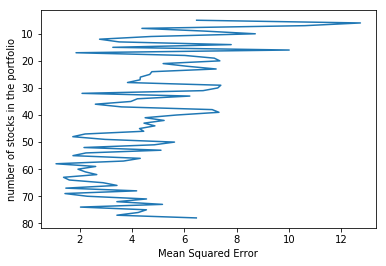

In [19]:
# Plot Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 